# Phase 2: Trajectory Prediction with Auxiliary Depth Estimation

# 🧭 Introduction

"""
Welcome to **Phase 2** of the DLAV Projec! 🚗💨

In this phase, you'll work with a more challenging dataset that includes:
- RGB **camera images**
- Ground-truth **depth maps**
- Ground-truth **semantic segmentation** labels

Your goal is still to predict the **future trajectory** of the self-driving car (SDC), but you now have more tools at your disposal! 🎯

Here, we provide an example where **depth estimation** is used as an auxiliary task to improve trajectory prediction.

However, you're **free to explore** other auxiliary tasks (e.g., using semantic labels), different loss functions, data augmentations, or better architectures! 💡

This notebook will walk you through loading the dataset, building a model, training with and without the auxiliary task, and visualizing results.
"""

In [47]:
# Install gdown to handle Google Drive file download
!pip install -q gdown
import os
import gdown
import zipfile


output_dir = os.path.join("data", "phase2")
if not os.path.exists(output_dir):  # Check if the directory already exists
    os.makedirs(output_dir)  # Create the directory if it doesn't exist

# Download the train dataset
download_url = f"https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr"
output_zip = os.path.join(output_dir, "dlav_train.zip")

if not os.path.exists(output_zip):  # Check if the file already exists
    gdown.download(download_url, output_zip, quiet=False)  # Downloads the file to your drive
if not os.path.exists(os.path.join(output_dir, "train")):  # Check if the directory already exists    
    with zipfile.ZipFile(output_zip, 'r') as zip_ref:  # Extracts the downloaded zip file
        zip_ref.extractall(output_dir)

# Download the validation dataset
download_url = "https://drive.google.com/uc?id=1wtmT_vH9mMUNOwrNOMFP6WFw6e8rbOdu"
output_zip = os.path.join(output_dir, "dlav_val.zip")

if not os.path.exists(output_zip):  # Check if the file already exists
    gdown.download(download_url, output_zip, quiet=False)  # Downloads the file to your drive
if not os.path.exists(os.path.join(output_dir, "val")):  # Check if the directory already exists
    with zipfile.ZipFile(output_zip, 'r') as zip_ref:  # Extracts the downloaded zip file
        zip_ref.extractall(output_dir)

# Download the test dataset
download_url = "https://drive.google.com/uc?id=1G9xGE7s-Ikvvc2-LZTUyuzhWAlNdLTLV"
output_zip = os.path.join(output_dir, "dlav_test_public.zip")

if not os.path.exists(output_zip):  # Check if the file already exists
    gdown.download(download_url, output_zip, quiet=False)  # Downloads the file to your drive
if not os.path.exists(os.path.join(output_dir, "test_public")):  # Check if the directory already exists
    with zipfile.ZipFile(output_zip, 'r') as zip_ref:  # Extracts the downloaded zip file
        zip_ref.extractall(output_dir)

## 📂 The Dataset

We are now working with a richer dataset that includes not just images and trajectories,
but also **depth maps** (and semantic segmentation labels, though unused in this example).

The data is stored in `.pkl` files and each file contains:
- `camera`: RGB image (shape: H x W x 3)
- `sdc_history_feature`: the past trajectory of the car
- `sdc_future_feature`: the future trajectory to predict
- `depth`: ground truth depth map (shape: H x W x 1)

We'll define a `DrivingDataset` class to load and return these tensors in a format our model can work with.

In [48]:
import os
import torch
import pickle
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import csv
import random
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

class DrivingDataset(Dataset):
    def __init__(self, file_list, test=False):
        self.samples = file_list
        self.test = test

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        with open(self.samples[idx], 'rb') as f:
            data = pickle.load(f)

        camera = torch.FloatTensor(data['camera']).permute(2, 0, 1) / 255.0
        history = torch.FloatTensor(data['sdc_history_feature'])

        depth = torch.FloatTensor(data['depth'])
        semantic = torch.FloatTensor(data['semantic_label'])
        if not self.test:
            future = torch.FloatTensor(data['sdc_future_feature'])
            return {
                'camera': camera,
                'history': history,
                'depth': depth,
                'future': future,
                'semantic': semantic
            }
        else:
            return {
                'camera': camera,
                'history': history,
                'depth': depth,
                'semantic': semantic
            }

In [49]:
train_dataset = DrivingDataset(
    [os.path.join("data", "phase2", "train", f) for f in os.listdir(os.path.join("data", "phase2", "train")) if f.endswith('.pkl')]
)
train_dataset[0]['camera'].shape, train_dataset[0]['history'].shape, train_dataset[0]['depth'].shape,  train_dataset[0]['semantic'].shape

(torch.Size([3, 200, 300]),
 torch.Size([21, 3]),
 torch.Size([200, 300, 1]),
 torch.Size([200, 300]))

## Data Augmentation

In [50]:
import os
import random
import matplotlib.pyplot as plt
import pickle
import numpy as np
from tqdm import tqdm

def augment_and_save(file_list, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    new_files = []

    for file_path in tqdm(file_list):
        with open(file_path, 'rb') as f:
            data = pickle.load(f)

        # Flip image horizontally
        camera = data['camera'][:, ::-1, :]  # shape HxWxC, flip width
        depth = data['depth'][:, ::-1, :]
        semantic = data['semantic_label'][:, ::-1]
        # Flip signs for 2nd and 3rd cols in history and future
        data['camera'] = camera
        data['depth'] = depth
        data['sdc_history_feature'][:, 1:] *= -1
        data['semantic_label'] = semantic

        if 'sdc_future_feature' in data:
            data['sdc_future_feature'][:, 1:] *= -1

        

        # Save to new file
        base = os.path.basename(file_path)
        new_path = os.path.join(save_dir, f"flipped_{base}")
        with open(new_path, 'wb') as f:
            pickle.dump(data, f)

        new_files.append(new_path)

    return new_files

augmented_train_path = os.path.join("data", "phase2", "augmented_train")
if not os.path.exists(augmented_train_path):
    train_data_dir = os.path.join("data", "phase2", "train")
    train_files = [os.path.join(train_data_dir, f) for f in os.listdir(train_data_dir) if f.endswith('.pkl')]
    augmented_train = augment_and_save(train_files, save_dir=augmented_train_path)
else:
    print("Augmented training data already exists. Skipping augmentation.")

Augmented training data already exists. Skipping augmentation.


## 🧠 The Model: Trajectory + Depth Prediction

We've extended our trajectory prediction model to optionally include a **depth estimation decoder**.

Why?
- Predicting depth helps the model **learn richer visual features** from the camera input.
- This acts as a form of **multi-task learning**, where learning to estimate depth reinforces scene understanding, ultimately leading to better trajectory predictions.
- This can be especially useful in complex environments with occlusions or sharp turns.

The model has:
- A CNN backbone to extract features from the image
- An MLP to process historical trajectory features
- A trajectory decoder to predict future coordinates
- (Optionally) A depth decoder to predict dense depth maps

This auxiliary task is enabled by setting `use_depth_aux=True`.

## Planners

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import pytorch_lightning as pl
import os
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import seed_everything


class SharedEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet18(weights=True)
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])  # (B, 512, H/32, W/32)
        self.visual_pool = nn.AdaptiveAvgPool2d((1, 1))  # Only for fusion
        self.visual_fc = nn.Linear(512, 256)

    def forward(self, x):
        feat_map = self.encoder(x)  # (B, 512, H, W)
        pooled = self.visual_pool(feat_map).view(x.size(0), -1)  # (B, 512)
        pooled = self.visual_fc(pooled)  # (B, 256)
        return feat_map, pooled

    
class SemanticDecoder(nn.Module):
    def __init__(self, in_channels=256, num_classes=14, output_size=(200, 300)):
        super().__init__()
        self.output_size = output_size
        self.upsample = nn.Sequential(
            nn.Conv2d(in_channels, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, num_classes, kernel_size=3, padding=1)  # → (B, 14, H, W)
        )

    def forward(self, x):
        x = self.upsample(x)
        return F.interpolate(x, size=self.output_size, mode='bilinear', align_corners=False)

class DepthDecoder(nn.Module):
    def __init__(self, in_channels=256, output_size=(200, 300)):
        super().__init__()
        self.output_size = output_size
        self.upsample = nn.Sequential(
            nn.Conv2d(in_channels, 128, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, 3, padding=1)
        )
    def forward(self, x):
        # Initial upsampling through the network
        x = self.upsample(x)  
        # Final resize to match ground truth dimensions
        return F.interpolate(x, size=self.output_size, mode='bilinear', align_corners=False)


class HistoryEncoder(nn.Module):
    def __init__(self, seq_len=21, feat_dim=2, hidden_dim=128): # changed the dimenstion to 2 instead of 3
        super().__init__()
        self.seq_len = seq_len
        self.feat_dim = feat_dim
        
        self.fc = nn.Sequential(
            nn.Linear(seq_len * feat_dim, 256),
            nn.ReLU(),
            nn.Linear(256, hidden_dim),
            nn.ReLU()
        )

    def forward(self, history):
        # history: B x T x 2
        batch_size = history.size(0)
        # Flatten the temporal dimension
        history_flat = history.reshape(batch_size, -1)  # B x (T*3)
        return self.fc(history_flat)  # B x hidden_dim


class MultiModalMultiTaskModel(nn.Module):
    def __init__(self, num_modes=6, pred_len=60, hist_seq_len=21, hist_feat_dim=2, depth_output_size=(200, 300)):
        super().__init__()
        self.num_modes = num_modes
        self.pred_len = pred_len
        
        # Visual encoder
        self.image_encoder = SharedEncoder()
        self.depth_decoder = DepthDecoder(in_channels=256, output_size=depth_output_size)
        self.semantic_decoder = SemanticDecoder(in_channels=256, num_classes=14, output_size=depth_output_size)
        # History encoder
        self.hist_encoder = HistoryEncoder(seq_len=hist_seq_len, feat_dim=hist_feat_dim, hidden_dim=128)
        
        # Fusion layer with batch normlization
        self.fusion = nn.Sequential(
            nn.Linear(256 + 128, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        # Trajectory decoder - predict multiple modes
        self.traj_decoder = nn.Linear(512, num_modes * pred_len * 2)  # Predict x,y coordinates for each mode
        
        # Confidence scores for each mode
        self.confidence_decoder = nn.Linear(512, num_modes)

    def forward(self, img, hist):
        # Encode image
        img_feat_map, img_feat_vector = self.image_encoder(img)

        depth_pred = self.depth_decoder(img_feat_map)
        semantic_pred_logits = self.semantic_decoder(img_feat_map)

        # Encode history
        hist_feat = self.hist_encoder(hist)
        
        combined = torch.cat([img_feat_vector, hist_feat], dim=1)
        
        # Fusion layer
        fused = self.fusion(combined)
        
        # Decode trajectories and confidence scores
        traj_pred = self.traj_decoder(fused)
        traj_pred = traj_pred.view(-1, self.num_modes, self.pred_len, 2)  # B x M x T x 2
        
        # Predict confidence scores
        conf_pred = self.confidence_decoder(fused)
        conf_pred = F.softmax(conf_pred, dim=1)  # Normalize to probabilities
        
        # Select best trajectory based on confidence
        best_mode = torch.argmax(conf_pred, dim=1)  # B
        best_traj = torch.gather(traj_pred, 1, 
                              best_mode.view(-1, 1, 1, 1).expand(-1, 1, self.pred_len, 2))
        best_traj = best_traj.squeeze(1)  # B x T x 2
        
        return depth_pred, traj_pred, conf_pred, best_traj, semantic_pred_logits

def compute_ade_fde(pred_trajectories, gt_trajectory, include_heading = False, confidences=None):
    """
    Compute Average Displacement Error and Final Displacement Error
    
    Args:
        pred_trajectories: Tensor of shape [B, M, T, 2] where M is number of modes
        gt_trajectory: Tensor of shape [B, T, 2+] (the + indicates there might be more features)
        
    Returns:
        ade: Average Displacement Error across all timesteps
        fde: Final Displacement Error (last timestep only)
    """
    # Extract only x, y coordinates from ground truth if needed
    if include_heading:
        gt_xy = gt_trajectory[..., :3]
    else:
        gt_xy = gt_trajectory[..., :2]
    
    # Calculate per-mode errors
    error_per_mode = torch.norm(pred_trajectories - gt_xy.unsqueeze(1), dim=-1)  # [B, M, T]
    
    # If confidences are provided, use them to select best mode
    if confidences is not None:
        best_mode_idx = confidences.argmax(dim=1)  # [B] - Use highest confidence
    else:
        # Fall back to minimum ADE if no confidences provided
        mode_ade = error_per_mode.mean(dim=2)  # [B, M]
        best_mode_idx = mode_ade.argmin(dim=1)  # [B]
    
    # Get errors for best mode per batch element
    batch_indices = torch.arange(pred_trajectories.size(0), device=pred_trajectories.device)
    best_mode_error = error_per_mode[batch_indices, best_mode_idx]  # [B, T]
    
    # Compute metrics
    ade = best_mode_error.mean().item()
    fde = best_mode_error[:, -1].mean().item()
    
    return ade, fde

### Custom Loss Function for Depth

In [52]:

def weighted_smooth_l1_loss(pred, target, beta=0.8, focus_range=(75, 150), importance=0.75):
    """
    pred, target: shape [B, C, H, W]
    focus_range: (start_height, end_height)
    importance: proportion of total loss weight to give to this region
    beta: threshold for smooth L1 loss
    """
    B, C, H, W = pred.shape
    device = pred.device

    # Step 1: Smooth L1 loss without reduction
    diff = pred - target
    abs_diff = torch.abs(diff)
    loss = torch.where(abs_diff < beta, 0.5 * (diff ** 2) / beta, abs_diff - 0.5 * beta)

    # Step 2: Create a height-weight mask
    weights = torch.ones((1, 1, H, 1), device=device)  # [1, 1, H, 1]

    # Assign weights
    low, high = focus_range

    weights[:, :, :low, :] = (1 - importance) * H/(high-low)  # top (sky)
    weights[:, :, low:high, :] = importance * H/(high-low)    # middle (main focus)
    weights[:, :, high:, :] = (1 - importance) * H/(high-low) # bottom (ground)

    # Broadcast weights to [B, C, H, W]
    weights = weights.expand_as(loss)

    # Step 3: Apply weights and reduce
    weighted_loss = loss * weights
    return weighted_loss.mean()

In [ ]:
# Lightning
from pytorch_lightning import LightningModule

class LightningDrivingPlanner(pl.LightningModule):
    def __init__(self, lr=1e-4, weight_decay=1e-4, epochs=50, scheduler_patience=5, 
                 max_pred_len=60, num_modes=4, curriculum_epochs=10, grad_clip=7.0, depth_mask=None, depth_k = 0.1, semantic_k = 0.1, beta=1
                 ):
        super().__init__()
        self.lr = lr
        self.weight_decay = weight_decay
        self.epochs = epochs
        self.max_pred_len = max_pred_len
        self.curriculum_epochs = curriculum_epochs
        self.grad_clip = grad_clip
        self.model = MultiModalMultiTaskModel(num_modes=6, pred_len=60, hist_seq_len=21, hist_feat_dim=2, depth_output_size=(200, 300))
        self.depth_mask = depth_mask
        self.scheduler_patience = scheduler_patience
        self.depth_k = depth_k
        self.semantic_k= semantic_k
        self.beta = beta
        self.save_hyperparameters()

        print("\n====================================\nModel initialized with parameters:")
        print(f"Learning Rate: {self.lr}")
        print(f"Weight Decay: {self.weight_decay}")
        print(f"Number of Epochs: {self.epochs}")
        print(f"Number of Modes: {num_modes}")
        print(f"Scheduler Patience: {self.scheduler_patience}")
        print(f"depth_k: {self.depth_k}")
        print(f"semantic_k: {self.semantic_k}")
        print(f"Mask depth: {depth_mask is not None}\n")
        print(f"Smooth L1 Loss Beta: {self.beta}")
        
    
    def forward(self, camera, history):
        history= history[:, :, :2] # [B, T, 2]
        return self.model(camera, history)
    
    def training_step(self, batch, batch_idx):
        camera = batch['camera']           # [B,3,H,W]
        history = batch['history']         # [B, T, 3]
        future = batch['future']           # [B, T, 3]
        depth_gt = batch['depth'].permute(0, 3, 1, 2)          # [B, 200, 300, 1]
        semantic_gt = batch['semantic'].long()
        # Get current epoch
        current_epoch = self.current_epoch
        
        # Curriculum learning: gradually increase prediction horizon
        if current_epoch < self.curriculum_epochs:
            pred_len = int((current_epoch / self.curriculum_epochs) * self.max_pred_len) + 1
        else:
            pred_len = self.max_pred_len
            

        depth_pred, traj_pred, conf_pred, best_traj, semantic_pred_logits = self(camera, history)
        # Truncate predictions and ground truth
        best_traj = best_traj[:, :pred_len]
        future = future[:, :pred_len]
        
        if self.depth_mask is not None:
            self.depth_mask = self.depth_mask.to(depth_gt.device)
            depth_pred = torch.clamp(self.depth_mask.to(depth_pred.device) + depth_pred, min=0)
        # Compute losses

        depth_loss = nn.SmoothL1Loss(beta=self.beta)(depth_pred, depth_gt)
        traj_loss = nn.SmoothL1Loss(beta=self.beta)(best_traj, future[:, :, :2])
        semantic_loss = nn.CrossEntropyLoss()(semantic_pred_logits, semantic_gt)
        # Combine losses with weighted sum
        loss =  self.depth_k * depth_loss + traj_loss + self.semantic_k * semantic_loss 
        
        # Gradient clipping
        self.clip_gradients(self.trainer.optimizers[0], gradient_clip_val=self.grad_clip)
        
        # Log metrics
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_depth_loss', depth_loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_traj_loss', traj_loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_semantic_loss', semantic_loss, on_step=True, on_epoch=True, prog_bar=True)
        
        return loss

        

    def validation_step(self, batch, batch_idx):
        camera = batch['camera']
        history = batch['history']
        future = batch['future']
        depth_gt = batch['depth']

        semantic_gt = batch['semantic'].long()
        # Forward pass
        depth_pred, traj_pred, conf_pred, best_traj, semantic_pred = self(camera, history)
        depth_gt = depth_gt.permute(0, 3, 1, 2)

        
        if self.depth_mask is not None:
            self.depth_mask = self.depth_mask.to(depth_gt.device)
            depth_pred = torch.clamp(self.depth_mask.to(depth_pred.device) + depth_pred, min=0)
        # Compute losses
        depth_loss = nn.SmoothL1Loss(beta=self.beta)(depth_pred, depth_gt)
        traj_loss = nn.SmoothL1Loss(beta=self.beta)(best_traj, future[:, :, :2])
        semantic_loss = nn.CrossEntropyLoss()(semantic_pred, semantic_gt)
        # Combine losses with weighted sum
        loss =  self.depth_k * depth_loss + traj_loss + self.semantic_k*semantic_loss 
        
        # Compute ADE and FDE
        ade, fde = compute_ade_fde(traj_pred, future)

        # Log validation metrics
        self.log('val_loss', loss, prog_bar=True, sync_dist=True)
        self.log('val_depth_loss', depth_loss, prog_bar=True, sync_dist=True)
        self.log('val_semantic_loss', semantic_loss, prog_bar=True, sync_dist=True)
        self.log('val_traj_loss', traj_loss, prog_bar=True, sync_dist=True)
        self.log('val_ade', ade, prog_bar=True, sync_dist=True)
        self.log('val_fde', fde, prog_bar=True, sync_dist=True)

        return {'val_loss': loss, 'val_depth_loss': depth_loss, 'val_traj_loss': traj_loss, 'val_ade': ade, 'val_fde': fde}

    def test_step(self, batch, batch_idx):
        # dont't do anything because we don't have the ground truth
        return {}

    def configure_optimizers(self):
        # Use AdamW optimizer with better weight decay handling
        optimizer = optim.AdamW(
            self.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay
        )
        
        # Learning rate scheduler with cosine annealing
        scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=self.epochs,
            eta_min=1e-6
        )
        
        # Early stopping callback
        early_stopping = pl.callbacks.EarlyStopping(
            monitor='val_ade',
            min_delta=0.0001,
            patience=10,
            verbose=True,
            mode='min'
        )
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'epoch',
                'frequency': 1
            },
            'callbacks': [early_stopping]
        }

## 🏋️ Training with Auxiliary Loss

The training loop is similar to Phase 1 — except now, if enabled, we also compute a loss on the predicted **depth map**.

We define:
- `trajectory_loss` as standard MSE between predicted and true future trajectory
- `depth_loss` as L1 loss between predicted and ground truth depth

Total loss = `trajectory_loss + lambda * depth_loss`

This helps guide the model to learn better representations from visual input. The weight `lambda` is a hyperparameter you can tune!

In [54]:

def compute_depth_mask_from_loader(loader, max_samples=None):
    total = None
    count = 0

    for i, sample in enumerate(loader.dataset):
        depth = sample['depth']  # shape: [H, W, 1] — NHWC
        right_column = depth[:, -1, :]  # shape: [H, 1]

        right_column = torch.tensor(right_column, dtype=torch.float32)

        if total is None:
            total = right_column
        else:
            total += right_column

        count += 1
        if max_samples is not None and count >= max_samples:
            break

    avg_column = total / count  # shape: [H, 1]

    # Reshape to [1, 1, H, W] for depth subtraction
    depth_mask = avg_column.unsqueeze(0).unsqueeze(0)  # [1, 1, H, 1]
    depth_mask = depth_mask.expand(-1, -1, -1, loader.dataset[0]['depth'].shape[1])  # W = width

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    plt.imshow(depth_mask.squeeze(0).squeeze(0).cpu().numpy(), cmap='viridis')
    plt.title("Depth Mask")
    plt.axis('off')
    plt.show()
    return depth_mask

In [55]:
import random        
# Training function
def run_experiment( max_epochs=70, batch_size=32, lr=2e-4, weight_decay=2.6551e-6, scheduler_patience=5, beta = 1,
                   augment_train=True, augment_val=False, seed=42, logger_name='multitask_driving_planner', mask_depth=False, depth_k = 0.1, semantic_k = 0.1):
    # Set random seed for reproducibility
    pl.seed_everything(seed)

    # Define paths to data
    train_data_dir = os.path.join("data", "phase2", "train")
    val_data_dir = os.path.join("data", "phase2", "val")
    augmented_train_data_dir = os.path.join("data", "phase2", "augmented_train")

    # Get file lists
    train_files = [os.path.join(train_data_dir, f) for f in os.listdir(train_data_dir) if f.endswith('.pkl')]
    val_files = [os.path.join(val_data_dir, f) for f in os.listdir(val_data_dir) if f.endswith('.pkl')]

    augmented_train_files = [os.path.join(augmented_train_data_dir, f) for f in os.listdir(augmented_train_data_dir) if f.endswith('.pkl')]
    
    if augment_train:
        all_train_files = train_files + augmented_train_files
        random.Random(42).shuffle(all_train_files)
        train_dataset = DrivingDataset(all_train_files)
        print("length of train dataset ", len(all_train_files))
        
    else:
        train_dataset = DrivingDataset(train_files)

    if augment_val:
        val_dataset = DrivingDataset(val_files)
    else:
        val_dataset = DrivingDataset(val_files)

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=16,
        shuffle=False,
        pin_memory=True
    )

    depth_mask = None
    if mask_depth:
        depth_mask = compute_depth_mask_from_loader(train_loader, max_samples=1000)

    # Initialize model with Lightning wrapper
    model = LightningDrivingPlanner(
        lr=lr, 
        weight_decay=weight_decay, 
        epochs=max_epochs, 
        scheduler_patience=scheduler_patience,
        depth_mask=depth_mask,  # pass the depth mask to the model
        depth_k=depth_k,  # pass the depth k to the model
        beta=beta,
        semantic_k=semantic_k,
    )
    logger_path = os.path.join("lightning_logs", "phase2")
    if not os.path.exists(logger_path):
        os.makedirs(logger_path)
    # Initialize logger
    logger = TensorBoardLogger(save_dir=logger_path, name=logger_name)
    lr_monitor = LearningRateMonitor(logging_interval='epoch')
    # Setup checkpoint callback
    # get logger version
    version = logger.version
    # get the current time for unique checkpoint names
    filename = f"driving_planner_version_{version}"
    print(f"Model version: {version}\n====================================\n ")
    # create a directory for the checkpoints

    checkpoint_path = os.path.join("checkpoints", "phase2")
    if not os.path.exists(checkpoint_path):
        os.makedirs(checkpoint_path)
    checkpoint_dir = os.path.join(checkpoint_path, logger_name)
    # Checkpoint callback
    checkpoint_callback = ModelCheckpoint(
        dirpath=checkpoint_dir,
        filename= filename + '_{epoch:02d}_{val_ade:.4f}',
        monitor='val_ade',
        mode='min',
        save_top_k=2,
        save_last=True,
        verbose=True
    )

    # Create trainer with limited epochs for quick overfitting test
    trainer = pl.Trainer(
        max_epochs=max_epochs, 
        logger=logger,
        accelerator='auto',  # Automatically select GPU if available
        devices='auto',
        precision=16,  # Use mixed precision
        log_every_n_steps=5,  # Logging freq
        gradient_clip_val=7.0,
        enable_checkpointing=True,  
        callbacks=[checkpoint_callback, lr_monitor],
  
    )

    # Train on the small dataset
    trainer.fit(model, train_loader, val_loader)
    # return best model and validation loader for testing
    best_model_path = checkpoint_callback.best_model_path
    best_model_val_loss = checkpoint_callback.best_model_score
    print(f"Best model val_loss: {best_model_val_loss}\nBest model path: {best_model_path}")
    # Load the best model
    model = LightningDrivingPlanner.load_from_checkpoint(best_model_path)

    # Test the model on the validation set again to be sure
    model.eval()
    trainer.validate(model, val_loader)
    return model, val_loader, best_model_val_loss


In [85]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

random.seed(40)

def visualize_comparison(val_loader, model, device):
    model.eval()
    val_batch = next(iter(val_loader))

    camera = val_batch['camera'].to(device)
    history = val_batch['history'].to(device)
    future = val_batch['future'].to(device)
    depth = val_batch['depth'].to(device)
    semantic_gt = val_batch['semantic'].to(device)

    with torch.no_grad():
        depth_pred, traj_pred, conf_pred, best_traj, semantic_logits = model(camera, history)
        pred_depth = depth_pred.permute(0, 2, 3, 1)  # (B, H, W, 1)
        semantic_pred = torch.argmax(semantic_logits, dim=1)  # (B, H, W)

        if hasattr(model, 'depth_mask') and model.depth_mask is not None:
            pred_depth = model.depth_mask.squeeze(0).squeeze(0).unsqueeze(-1).to(pred_depth.device) + pred_depth

    # Move all to CPU
    camera = camera.cpu().numpy()
    history = history.cpu().numpy()
    future = future.cpu().numpy()
    pred_with_aux = best_traj.cpu().numpy()
    depth = depth.cpu().numpy()
    pred_depth = pred_depth.cpu().numpy() if pred_depth is not None else None
    semantic_pred = semantic_pred.cpu().numpy()
    semantic_gt = semantic_gt.cpu().numpy()

    k = 4
    indices = random.choices(np.arange(len(camera)), k=k)

    # 🖼 Camera inputs
    fig, ax = plt.subplots(1, k, figsize=(4 * k, 4))
    for i, idx in enumerate(indices):
        ax[i].imshow(camera[idx].transpose(1, 2, 0))
        ax[i].set_title(f"Example {i+1}")
        ax[i].axis("off")
    plt.suptitle("Camera Inputs")
    plt.tight_layout()
    plt.show()

    # 🧭 Trajectories
    fig, ax = plt.subplots(1, k, figsize=(4 * k, 8))
    for i, idx in enumerate(indices):
        ax[i].plot(history[idx, :, 0], history[idx, :, 1], 'o-', label='Past', color='gold', markersize=4, linewidth=1.2)
        ax[i].plot(future[idx, :, 0], future[idx, :, 1], 'o-', label='GT Future', color='green', markersize=4, linewidth=1.2)
        ax[i].plot(pred_with_aux[idx, :, 0], pred_with_aux[idx, :, 1], '.-', label='Pred (With Aux)', color='blue', markersize=4, linewidth=1.2)
        ax[i].set_title("With Depth Aux")
        ax[i].axis("equal")

    fig_legend = plt.figure(figsize=(8, 1))
    legend_handles = [
        plt.Line2D([0], [0], color='gold', marker='o', linestyle='-', markersize=5, label='Past'),
        plt.Line2D([0], [0], color='green', marker='o', linestyle='-', markersize=5, label='GT Future'),
        plt.Line2D([0], [0], color='blue', marker='o', linestyle='-', markersize=5, label='Pred (With Aux)')
    ]
    fig_legend.legend(handles=legend_handles, loc='center', ncol=3)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    plt.suptitle("Trajectory Prediction: With Depth Aux Task")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # 🌊 Depth Prediction
    if pred_depth is not None:
        fig, ax = plt.subplots(2, k, figsize=(4 * k, 6))
        for i, idx in enumerate(indices):
            ax[0, i].imshow(depth[idx, :, :, 0], cmap='viridis')
            ax[0, i].set_title("GT Depth", pad=10)
            ax[0, i].axis("off")
            ax[1, i].imshow(pred_depth[idx, :, :, 0], cmap='viridis')
            ax[1, i].set_title("Pred Depth", pad=10)
            ax[1, i].axis("off")
        plt.suptitle("Depth Estimation (GT vs Prediction)", y=1.05)
        plt.subplots_adjust(hspace=0.4)
        plt.tight_layout()
        plt.show()

    # 🗺 Semantic Prediction
    if semantic_gt is not None:
        fig, ax = plt.subplots(2, k, figsize=(4 * k, 6))
        for i, idx in enumerate(indices):
            ax[0, i].imshow(semantic_gt[idx], cmap='tab20', vmin=0, vmax=13)
            ax[0, i].set_title("GT Semantic", pad=10)
            ax[0, i].axis("off")

            ax[1, i].imshow(semantic_pred[idx], cmap='tab20', vmin=0, vmax=13)
            ax[1, i].set_title("Pred Semantic", pad=10)
            ax[1, i].axis("off")
        plt.suptitle("Semantic Segmentation (GT vs Prediction)", y=1.05)
        plt.subplots_adjust(hspace=0.4)
        plt.tight_layout()
        plt.show()

    return future, pred_with_aux, depth, pred_depth


In [66]:
import optuna

def objective(trial):
    # Fixed values
    batch_size = 32
    max_epochs = 80
    lr = 2e-4
    weight_decay = 2.6551e-6
    scheduler_patience = 5
    beta = 1
    seed = 42
    augment_train = True
    augment_val = False
    logger_name = 'optuna_multitask_planner'

    # Suggested hyperparameters
    depth_k = trial.suggest_float("depth_k", 0.01, 1.0, log=True)
    semantic_k = trial.suggest_float("semantic_k", 0.01, 1.0, log=True)

    # Train the model
    model, val_loader, best_val_loss = run_experiment(
        max_epochs=max_epochs,
        batch_size=batch_size,
        lr=lr,
        weight_decay=weight_decay,
        scheduler_patience=scheduler_patience,
        beta=beta,
        augment_train=augment_train,
        augment_val=augment_val,
        seed=seed,
        logger_name=logger_name,
        mask_depth=False,
        depth_k=depth_k,
        semantic_k=semantic_k
    )

    return best_val_loss.item()  # assuming best_val_loss is a torch tensor

# Run the study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=8)

print("Best trial:")
print("  Value: ", study.best_value)
print("  Params: ")
for key, value in study.best_params.items():
    print(f"    {key}: {value}")


[I 2025-05-15 17:03:29,051] A new study created in memory with name: no-name-3f844280-5b81-4a4b-bb5b-694e2bcd9611
Seed set to 42
f:\Utilities\anaconda\envs\IMOS\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
f:\Utilities\anaconda\envs\IMOS\lib\site-packages\lightning_fabric\connector.py:572: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
f:\Utilities\anaconda\envs\IMOS\lib\site-pa

length of train dataset  10000

Model initialized with parameters:
Learning Rate: 0.0002
Weight Decay: 2.6551e-06
Number of Epochs: 80
Number of Modes: 4
Scheduler Patience: 5
depth_k: 0.05718921325224076
semantic_k: 0.2091836329732165
Mask depth: False

Smooth L1 Loss Beta: 1
Model version: 2
 
                                                                           

f:\Utilities\anaconda\envs\IMOS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
f:\Utilities\anaconda\envs\IMOS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 313/313 [00:17<00:00, 17.89it/s, v_num=2, train_loss_step=0.531, train_depth_loss_step=6.750, train_traj_loss_step=0.0487, train_semantic_loss_step=0.464, val_loss=7.840, val_depth_loss=4.050, val_semantic_loss=0.399, val_traj_loss=7.520, val_ade=14.90, val_fde=29.70, train_loss_epoch=1.760, train_depth_loss_epoch=28.00, train_traj_loss_epoch=0.0442, train_semantic_loss_epoch=0.551]

Epoch 0, global step 313: 'val_ade' reached 14.86551 (best 14.86551), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_2_epoch=00_val_ade=14.8655.ckpt' as top 2


Epoch 1: 100%|██████████| 313/313 [00:17<00:00, 18.12it/s, v_num=2, train_loss_step=0.392, train_depth_loss_step=4.040, train_traj_loss_step=0.0634, train_semantic_loss_step=0.463, val_loss=8.040, val_depth_loss=7.900, val_semantic_loss=0.398, val_traj_loss=7.500, val_ade=14.80, val_fde=29.80, train_loss_epoch=0.513, train_depth_loss_epoch=6.270, train_traj_loss_epoch=0.0633, train_semantic_loss_epoch=0.434]

Epoch 1, global step 626: 'val_ade' reached 14.79403 (best 14.79403), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_2_epoch=01_val_ade=14.7940.ckpt' as top 2


Epoch 2: 100%|██████████| 313/313 [00:17<00:00, 18.22it/s, v_num=2, train_loss_step=0.423, train_depth_loss_step=1.840, train_traj_loss_step=0.225, train_semantic_loss_step=0.443, val_loss=7.680, val_depth_loss=3.000, val_semantic_loss=0.331, val_traj_loss=7.440, val_ade=14.70, val_fde=29.80, train_loss_epoch=0.490, train_depth_loss_epoch=5.370, train_traj_loss_epoch=0.0961, train_semantic_loss_epoch=0.417] 

Epoch 2, global step 939: 'val_ade' reached 14.65678 (best 14.65678), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_2_epoch=02_val_ade=14.6568.ckpt' as top 2


Epoch 3: 100%|██████████| 313/313 [00:17<00:00, 18.19it/s, v_num=2, train_loss_step=0.834, train_depth_loss_step=10.60, train_traj_loss_step=0.125, train_semantic_loss_step=0.496, val_loss=8.170, val_depth_loss=13.00, val_semantic_loss=0.336, val_traj_loss=7.350, val_ade=14.50, val_fde=29.70, train_loss_epoch=0.429, train_depth_loss_epoch=3.550, train_traj_loss_epoch=0.142, train_semantic_loss_epoch=0.401]  

Epoch 3, global step 1252: 'val_ade' reached 14.46787 (best 14.46787), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_2_epoch=03_val_ade=14.4679.ckpt' as top 2


Epoch 4: 100%|██████████| 313/313 [00:17<00:00, 18.10it/s, v_num=2, train_loss_step=0.627, train_depth_loss_step=6.340, train_traj_loss_step=0.178, train_semantic_loss_step=0.412, val_loss=7.780, val_depth_loss=8.540, val_semantic_loss=0.356, val_traj_loss=7.210, val_ade=14.20, val_fde=29.90, train_loss_epoch=0.665, train_depth_loss_epoch=6.550, train_traj_loss_epoch=0.202, train_semantic_loss_epoch=0.423] 

Epoch 4, global step 1565: 'val_ade' reached 14.19444 (best 14.19444), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_2_epoch=04_val_ade=14.1944.ckpt' as top 2


Epoch 5: 100%|██████████| 313/313 [00:17<00:00, 18.18it/s, v_num=2, train_loss_step=0.943, train_depth_loss_step=8.070, train_traj_loss_step=0.398, train_semantic_loss_step=0.397, val_loss=7.810, val_depth_loss=11.60, val_semantic_loss=0.341, val_traj_loss=7.080, val_ade=13.90, val_fde=29.80, train_loss_epoch=0.683, train_depth_loss_epoch=5.790, train_traj_loss_epoch=0.268, train_semantic_loss_epoch=0.401] 

Epoch 5, global step 1878: 'val_ade' reached 13.93635 (best 13.93635), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_2_epoch=05_val_ade=13.9364.ckpt' as top 2


Epoch 6: 100%|██████████| 313/313 [00:17<00:00, 18.19it/s, v_num=2, train_loss_step=1.020, train_depth_loss_step=2.610, train_traj_loss_step=0.795, train_semantic_loss_step=0.345, val_loss=7.050, val_depth_loss=2.260, val_semantic_loss=0.312, val_traj_loss=6.860, val_ade=13.50, val_fde=29.70, train_loss_epoch=0.666, train_depth_loss_epoch=5.090, train_traj_loss_epoch=0.294, train_semantic_loss_epoch=0.387] 

Epoch 6, global step 2191: 'val_ade' reached 13.45544 (best 13.45544), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_2_epoch=06_val_ade=13.4554.ckpt' as top 2


Epoch 7: 100%|██████████| 313/313 [00:17<00:00, 18.22it/s, v_num=2, train_loss_step=0.806, train_depth_loss_step=9.470, train_traj_loss_step=0.192, train_semantic_loss_step=0.347, val_loss=7.070, val_depth_loss=6.310, val_semantic_loss=0.297, val_traj_loss=6.640, val_ade=13.00, val_fde=29.90, train_loss_epoch=0.727, train_depth_loss_epoch=5.080, train_traj_loss_epoch=0.358, train_semantic_loss_epoch=0.379] 

Epoch 7, global step 2504: 'val_ade' reached 13.04146 (best 13.04146), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_2_epoch=07_val_ade=13.0415.ckpt' as top 2


Epoch 8: 100%|██████████| 313/313 [00:17<00:00, 18.25it/s, v_num=2, train_loss_step=1.070, train_depth_loss_step=6.460, train_traj_loss_step=0.599, train_semantic_loss_step=0.474, val_loss=6.770, val_depth_loss=5.290, val_semantic_loss=0.295, val_traj_loss=6.410, val_ade=12.60, val_fde=29.80, train_loss_epoch=0.683, train_depth_loss_epoch=3.510, train_traj_loss_epoch=0.400, train_semantic_loss_epoch=0.390]

Epoch 8, global step 2817: 'val_ade' reached 12.58483 (best 12.58483), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_2_epoch=08_val_ade=12.5848.ckpt' as top 2


Epoch 9: 100%|██████████| 313/313 [00:17<00:00, 18.12it/s, v_num=2, train_loss_step=0.952, train_depth_loss_step=1.000, train_traj_loss_step=0.810, train_semantic_loss_step=0.404, val_loss=6.250, val_depth_loss=2.430, val_semantic_loss=0.275, val_traj_loss=6.050, val_ade=11.90, val_fde=29.90, train_loss_epoch=0.707, train_depth_loss_epoch=2.510, train_traj_loss_epoch=0.484, train_semantic_loss_epoch=0.376]

Epoch 9, global step 3130: 'val_ade' reached 11.85653 (best 11.85653), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_2_epoch=09_val_ade=11.8565.ckpt' as top 2


Epoch 10: 100%|██████████| 313/313 [00:17<00:00, 18.16it/s, v_num=2, train_loss_step=0.717, train_depth_loss_step=2.860, train_traj_loss_step=0.475, train_semantic_loss_step=0.374, val_loss=5.910, val_depth_loss=2.300, val_semantic_loss=0.269, val_traj_loss=5.720, val_ade=11.20, val_fde=29.80, train_loss_epoch=0.684, train_depth_loss_epoch=1.800, train_traj_loss_epoch=0.506, train_semantic_loss_epoch=0.361]

Epoch 10, global step 3443: 'val_ade' reached 11.20834 (best 11.20834), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_2_epoch=10_val_ade=11.2083.ckpt' as top 2


Epoch 11: 100%|██████████| 313/313 [00:17<00:00, 18.13it/s, v_num=2, train_loss_step=0.411, train_depth_loss_step=2.740, train_traj_loss_step=0.179, train_semantic_loss_step=0.361, val_loss=5.630, val_depth_loss=1.020, val_semantic_loss=0.264, val_traj_loss=5.520, val_ade=10.80, val_fde=29.80, train_loss_epoch=0.745, train_depth_loss_epoch=1.760, train_traj_loss_epoch=0.570, train_semantic_loss_epoch=0.356]

Epoch 11, global step 3756: 'val_ade' reached 10.79573 (best 10.79573), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_2_epoch=11_val_ade=10.7957.ckpt' as top 2


Epoch 12: 100%|██████████| 313/313 [00:17<00:00, 18.17it/s, v_num=2, train_loss_step=0.445, train_depth_loss_step=0.968, train_traj_loss_step=0.302, train_semantic_loss_step=0.418, val_loss=5.080, val_depth_loss=1.060, val_semantic_loss=0.270, val_traj_loss=4.970, val_ade=9.710, val_fde=29.80, train_loss_epoch=0.822, train_depth_loss_epoch=1.730, train_traj_loss_epoch=0.649, train_semantic_loss_epoch=0.355]

Epoch 12, global step 4069: 'val_ade' reached 9.71014 (best 9.71014), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_2_epoch=12_val_ade=9.7101.ckpt' as top 2


Epoch 13: 100%|██████████| 313/313 [00:17<00:00, 18.15it/s, v_num=2, train_loss_step=0.962, train_depth_loss_step=3.000, train_traj_loss_step=0.703, train_semantic_loss_step=0.419, val_loss=4.790, val_depth_loss=1.860, val_semantic_loss=0.370, val_traj_loss=4.600, val_ade=8.930, val_fde=29.80, train_loss_epoch=0.932, train_depth_loss_epoch=1.990, train_traj_loss_epoch=0.742, train_semantic_loss_epoch=0.365]

Epoch 13, global step 4382: 'val_ade' reached 8.93132 (best 8.93132), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_2_epoch=13_val_ade=8.9313.ckpt' as top 2


Epoch 14: 100%|██████████| 313/313 [00:17<00:00, 18.15it/s, v_num=2, train_loss_step=1.120, train_depth_loss_step=1.370, train_traj_loss_step=0.945, train_semantic_loss_step=0.444, val_loss=4.330, val_depth_loss=2.460, val_semantic_loss=0.299, val_traj_loss=4.120, val_ade=8.070, val_fde=29.90, train_loss_epoch=1.320, train_depth_loss_epoch=5.020, train_traj_loss_epoch=0.947, train_semantic_loss_epoch=0.416]

Epoch 14, global step 4695: 'val_ade' reached 8.07425 (best 8.07425), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_2_epoch=14_val_ade=8.0742.ckpt' as top 2


Epoch 15: 100%|██████████| 313/313 [00:17<00:00, 18.20it/s, v_num=2, train_loss_step=1.290, train_depth_loss_step=6.050, train_traj_loss_step=0.872, train_semantic_loss_step=0.340, val_loss=4.490, val_depth_loss=5.050, val_semantic_loss=0.280, val_traj_loss=4.150, val_ade=8.110, val_fde=29.90, train_loss_epoch=1.290, train_depth_loss_epoch=4.190, train_traj_loss_epoch=0.974, train_semantic_loss_epoch=0.379]

Epoch 15, global step 5008: 'val_ade' reached 8.11302 (best 8.07425), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_2_epoch=15_val_ade=8.1130.ckpt' as top 2


Epoch 16: 100%|██████████| 313/313 [00:17<00:00, 18.23it/s, v_num=2, train_loss_step=1.580, train_depth_loss_step=1.490, train_traj_loss_step=1.420, train_semantic_loss_step=0.372, val_loss=3.210, val_depth_loss=1.190, val_semantic_loss=0.255, val_traj_loss=3.090, val_ade=6.050, val_fde=29.90, train_loss_epoch=1.270, train_depth_loss_epoch=2.650, train_traj_loss_epoch=1.040, train_semantic_loss_epoch=0.370]

Epoch 16, global step 5321: 'val_ade' reached 6.05288 (best 6.05288), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_2_epoch=16_val_ade=6.0529.ckpt' as top 2


Epoch 17: 100%|██████████| 313/313 [00:17<00:00, 18.22it/s, v_num=2, train_loss_step=0.815, train_depth_loss_step=1.260, train_traj_loss_step=0.641, train_semantic_loss_step=0.488, val_loss=2.610, val_depth_loss=1.220, val_semantic_loss=0.259, val_traj_loss=2.490, val_ade=4.850, val_fde=29.90, train_loss_epoch=1.170, train_depth_loss_epoch=1.350, train_traj_loss_epoch=1.020, train_semantic_loss_epoch=0.348]

Epoch 17, global step 5634: 'val_ade' reached 4.85113 (best 4.85113), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_2_epoch=17_val_ade=4.8511.ckpt' as top 2


Epoch 18: 100%|██████████| 313/313 [00:17<00:00, 18.25it/s, v_num=2, train_loss_step=0.649, train_depth_loss_step=1.200, train_traj_loss_step=0.519, train_semantic_loss_step=0.293, val_loss=2.080, val_depth_loss=1.290, val_semantic_loss=0.256, val_traj_loss=1.960, val_ade=3.790, val_fde=29.80, train_loss_epoch=1.210, train_depth_loss_epoch=1.340, train_traj_loss_epoch=1.060, train_semantic_loss_epoch=0.343]

Epoch 18, global step 5947: 'val_ade' reached 3.78534 (best 3.78534), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_2_epoch=18_val_ade=3.7853.ckpt' as top 2


Epoch 19: 100%|██████████| 313/313 [00:17<00:00, 18.25it/s, v_num=2, train_loss_step=1.360, train_depth_loss_step=1.680, train_traj_loss_step=1.200, train_semantic_loss_step=0.312, val_loss=1.670, val_depth_loss=1.090, val_semantic_loss=0.248, val_traj_loss=1.550, val_ade=3.020, val_fde=29.90, train_loss_epoch=1.320, train_depth_loss_epoch=1.330, train_traj_loss_epoch=1.170, train_semantic_loss_epoch=0.340]

Epoch 19, global step 6260: 'val_ade' reached 3.02430 (best 3.02430), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_2_epoch=19_val_ade=3.0243.ckpt' as top 2


Epoch 20: 100%|██████████| 313/313 [00:17<00:00, 18.12it/s, v_num=2, train_loss_step=0.695, train_depth_loss_step=1.160, train_traj_loss_step=0.555, train_semantic_loss_step=0.355, val_loss=0.951, val_depth_loss=1.600, val_semantic_loss=0.247, val_traj_loss=0.808, val_ade=1.560, val_fde=4.630, train_loss_epoch=1.270, train_depth_loss_epoch=1.290, train_traj_loss_epoch=1.130, train_semantic_loss_epoch=0.337]

Epoch 20, global step 6573: 'val_ade' reached 1.56019 (best 1.56019), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_2_epoch=20_val_ade=1.5602.ckpt' as top 2


Epoch 21: 100%|██████████| 313/313 [00:17<00:00, 18.11it/s, v_num=2, train_loss_step=1.090, train_depth_loss_step=1.250, train_traj_loss_step=0.965, train_semantic_loss_step=0.272, val_loss=0.979, val_depth_loss=1.010, val_semantic_loss=0.247, val_traj_loss=0.870, val_ade=1.640, val_fde=4.470, train_loss_epoch=1.130, train_depth_loss_epoch=1.290, train_traj_loss_epoch=0.986, train_semantic_loss_epoch=0.336]

Epoch 21, global step 6886: 'val_ade' reached 1.64423 (best 1.56019), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_2_epoch=21_val_ade=1.6442.ckpt' as top 2


Epoch 22: 100%|██████████| 313/313 [00:17<00:00, 18.04it/s, v_num=2, train_loss_step=0.695, train_depth_loss_step=1.470, train_traj_loss_step=0.550, train_semantic_loss_step=0.287, val_loss=0.919, val_depth_loss=1.100, val_semantic_loss=0.237, val_traj_loss=0.806, val_ade=1.550, val_fde=4.270, train_loss_epoch=1.050, train_depth_loss_epoch=1.300, train_traj_loss_epoch=0.906, train_semantic_loss_epoch=0.331]

Epoch 22, global step 7199: 'val_ade' reached 1.54917 (best 1.54917), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_2_epoch=22_val_ade=1.5492.ckpt' as top 2


Epoch 23: 100%|██████████| 313/313 [00:17<00:00, 17.99it/s, v_num=2, train_loss_step=0.969, train_depth_loss_step=0.706, train_traj_loss_step=0.861, train_semantic_loss_step=0.324, val_loss=0.931, val_depth_loss=1.000, val_semantic_loss=0.233, val_traj_loss=0.825, val_ade=1.620, val_fde=4.540, train_loss_epoch=1.020, train_depth_loss_epoch=1.260, train_traj_loss_epoch=0.881, train_semantic_loss_epoch=0.327]

Epoch 23, global step 7512: 'val_ade' was not in top 2


Epoch 24: 100%|██████████| 313/313 [00:17<00:00, 18.09it/s, v_num=2, train_loss_step=0.968, train_depth_loss_step=1.610, train_traj_loss_step=0.804, train_semantic_loss_step=0.344, val_loss=1.140, val_depth_loss=1.130, val_semantic_loss=0.236, val_traj_loss=1.030, val_ade=1.850, val_fde=5.040, train_loss_epoch=1.000, train_depth_loss_epoch=1.260, train_traj_loss_epoch=0.861, train_semantic_loss_epoch=0.323]

Epoch 24, global step 7825: 'val_ade' was not in top 2


Epoch 25: 100%|██████████| 313/313 [00:17<00:00, 18.24it/s, v_num=2, train_loss_step=1.200, train_depth_loss_step=1.280, train_traj_loss_step=1.040, train_semantic_loss_step=0.425, val_loss=0.930, val_depth_loss=1.090, val_semantic_loss=0.225, val_traj_loss=0.820, val_ade=1.480, val_fde=4.200, train_loss_epoch=0.956, train_depth_loss_epoch=1.210, train_traj_loss_epoch=0.821, train_semantic_loss_epoch=0.317]

Epoch 25, global step 8138: 'val_ade' reached 1.47646 (best 1.47646), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_2_epoch=25_val_ade=1.4765.ckpt' as top 2


Epoch 26: 100%|██████████| 313/313 [00:17<00:00, 18.19it/s, v_num=2, train_loss_step=2.250, train_depth_loss_step=1.070, train_traj_loss_step=2.140, train_semantic_loss_step=0.261, val_loss=1.240, val_depth_loss=1.200, val_semantic_loss=0.224, val_traj_loss=1.120, val_ade=1.980, val_fde=5.200, train_loss_epoch=0.937, train_depth_loss_epoch=1.190, train_traj_loss_epoch=0.804, train_semantic_loss_epoch=0.311]

Epoch 26, global step 8451: 'val_ade' was not in top 2


Epoch 27: 100%|██████████| 313/313 [00:17<00:00, 18.21it/s, v_num=2, train_loss_step=1.030, train_depth_loss_step=0.806, train_traj_loss_step=0.940, train_semantic_loss_step=0.226, val_loss=0.944, val_depth_loss=0.972, val_semantic_loss=0.214, val_traj_loss=0.844, val_ade=1.500, val_fde=4.290, train_loss_epoch=0.915, train_depth_loss_epoch=1.180, train_traj_loss_epoch=0.783, train_semantic_loss_epoch=0.308]

Epoch 27, global step 8764: 'val_ade' reached 1.50026 (best 1.47646), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_2_epoch=27_val_ade=1.5003.ckpt' as top 2


Epoch 28: 100%|██████████| 313/313 [00:17<00:00, 18.09it/s, v_num=2, train_loss_step=0.964, train_depth_loss_step=0.967, train_traj_loss_step=0.845, train_semantic_loss_step=0.303, val_loss=0.927, val_depth_loss=1.000, val_semantic_loss=0.213, val_traj_loss=0.825, val_ade=1.400, val_fde=4.000, train_loss_epoch=0.896, train_depth_loss_epoch=1.220, train_traj_loss_epoch=0.762, train_semantic_loss_epoch=0.306]

Epoch 28, global step 9077: 'val_ade' reached 1.40428 (best 1.40428), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_2_epoch=28_val_ade=1.4043.ckpt' as top 2


Epoch 29: 100%|██████████| 313/313 [00:17<00:00, 18.14it/s, v_num=2, train_loss_step=0.950, train_depth_loss_step=0.635, train_traj_loss_step=0.853, train_semantic_loss_step=0.291, val_loss=0.926, val_depth_loss=1.420, val_semantic_loss=0.219, val_traj_loss=0.799, val_ade=1.390, val_fde=3.980, train_loss_epoch=0.856, train_depth_loss_epoch=1.120, train_traj_loss_epoch=0.730, train_semantic_loss_epoch=0.297]

Epoch 29, global step 9390: 'val_ade' reached 1.38881 (best 1.38881), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_2_epoch=29_val_ade=1.3888.ckpt' as top 2


Epoch 30: 100%|██████████| 313/313 [00:17<00:00, 18.22it/s, v_num=2, train_loss_step=0.898, train_depth_loss_step=2.310, train_traj_loss_step=0.690, train_semantic_loss_step=0.362, val_loss=1.000, val_depth_loss=2.330, val_semantic_loss=0.202, val_traj_loss=0.827, val_ade=1.460, val_fde=4.130, train_loss_epoch=0.901, train_depth_loss_epoch=1.890, train_traj_loss_epoch=0.731, train_semantic_loss_epoch=0.299]

Epoch 30, global step 9703: 'val_ade' was not in top 2


Epoch 31: 100%|██████████| 313/313 [00:17<00:00, 18.18it/s, v_num=2, train_loss_step=0.834, train_depth_loss_step=2.820, train_traj_loss_step=0.626, train_semantic_loss_step=0.222, val_loss=0.995, val_depth_loss=1.860, val_semantic_loss=0.199, val_traj_loss=0.847, val_ade=1.360, val_fde=3.830, train_loss_epoch=0.849, train_depth_loss_epoch=1.800, train_traj_loss_epoch=0.686, train_semantic_loss_epoch=0.287]

Epoch 31, global step 10016: 'val_ade' reached 1.36019 (best 1.36019), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_2_epoch=31_val_ade=1.3602.ckpt' as top 2


Epoch 32: 100%|██████████| 313/313 [00:17<00:00, 18.27it/s, v_num=2, train_loss_step=1.230, train_depth_loss_step=1.520, train_traj_loss_step=1.090, train_semantic_loss_step=0.244, val_loss=0.840, val_depth_loss=0.859, val_semantic_loss=0.196, val_traj_loss=0.750, val_ade=1.310, val_fde=3.720, train_loss_epoch=0.832, train_depth_loss_epoch=1.760, train_traj_loss_epoch=0.673, train_semantic_loss_epoch=0.281]

Epoch 32, global step 10329: 'val_ade' reached 1.30588 (best 1.30588), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_2_epoch=32_val_ade=1.3059.ckpt' as top 2


Epoch 33: 100%|██████████| 313/313 [00:17<00:00, 18.22it/s, v_num=2, train_loss_step=0.769, train_depth_loss_step=2.060, train_traj_loss_step=0.597, train_semantic_loss_step=0.261, val_loss=0.922, val_depth_loss=2.600, val_semantic_loss=0.201, val_traj_loss=0.731, val_ade=1.330, val_fde=3.820, train_loss_epoch=0.823, train_depth_loss_epoch=1.710, train_traj_loss_epoch=0.666, train_semantic_loss_epoch=0.280]

Epoch 33, global step 10642: 'val_ade' reached 1.33485 (best 1.30588), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_2_epoch=33_val_ade=1.3349.ckpt' as top 2


Epoch 34: 100%|██████████| 313/313 [00:17<00:00, 18.16it/s, v_num=2, train_loss_step=4.180, train_depth_loss_step=1.940, train_traj_loss_step=4.020, train_semantic_loss_step=0.244, val_loss=1.270, val_depth_loss=1.350, val_semantic_loss=0.196, val_traj_loss=1.150, val_ade=1.620, val_fde=4.290, train_loss_epoch=0.825, train_depth_loss_epoch=1.600, train_traj_loss_epoch=0.675, train_semantic_loss_epoch=0.277]

Epoch 34, global step 10955: 'val_ade' was not in top 2


Epoch 35: 100%|██████████| 313/313 [00:17<00:00, 18.17it/s, v_num=2, train_loss_step=0.756, train_depth_loss_step=1.280, train_traj_loss_step=0.621, train_semantic_loss_step=0.294, val_loss=0.896, val_depth_loss=1.500, val_semantic_loss=0.194, val_traj_loss=0.770, val_ade=1.270, val_fde=3.670, train_loss_epoch=0.755, train_depth_loss_epoch=1.550, train_traj_loss_epoch=0.610, train_semantic_loss_epoch=0.273]

Epoch 35, global step 11268: 'val_ade' reached 1.27156 (best 1.27156), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_2_epoch=35_val_ade=1.2716.ckpt' as top 2


Epoch 36: 100%|██████████| 313/313 [00:17<00:00, 18.25it/s, v_num=2, train_loss_step=0.992, train_depth_loss_step=1.060, train_traj_loss_step=0.880, train_semantic_loss_step=0.251, val_loss=0.952, val_depth_loss=1.130, val_semantic_loss=0.186, val_traj_loss=0.849, val_ade=1.300, val_fde=3.720, train_loss_epoch=0.739, train_depth_loss_epoch=1.480, train_traj_loss_epoch=0.598, train_semantic_loss_epoch=0.270]

Epoch 36, global step 11581: 'val_ade' reached 1.29528 (best 1.27156), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_2_epoch=36_val_ade=1.2953.ckpt' as top 2


Epoch 37: 100%|██████████| 313/313 [00:17<00:00, 18.15it/s, v_num=2, train_loss_step=0.628, train_depth_loss_step=1.360, train_traj_loss_step=0.498, train_semantic_loss_step=0.249, val_loss=0.889, val_depth_loss=1.320, val_semantic_loss=0.187, val_traj_loss=0.774, val_ade=1.250, val_fde=3.600, train_loss_epoch=0.756, train_depth_loss_epoch=1.410, train_traj_loss_epoch=0.619, train_semantic_loss_epoch=0.267]

Epoch 37, global step 11894: 'val_ade' reached 1.24695 (best 1.24695), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_2_epoch=37_val_ade=1.2469.ckpt' as top 2


Epoch 38: 100%|██████████| 313/313 [00:17<00:00, 18.17it/s, v_num=2, train_loss_step=1.430, train_depth_loss_step=2.220, train_traj_loss_step=1.260, train_semantic_loss_step=0.231, val_loss=0.947, val_depth_loss=0.956, val_semantic_loss=0.184, val_traj_loss=0.854, val_ade=1.300, val_fde=3.720, train_loss_epoch=0.733, train_depth_loss_epoch=1.380, train_traj_loss_epoch=0.599, train_semantic_loss_epoch=0.266]

Epoch 38, global step 12207: 'val_ade' was not in top 2


Epoch 39: 100%|██████████| 313/313 [00:17<00:00, 18.22it/s, v_num=2, train_loss_step=0.568, train_depth_loss_step=0.627, train_traj_loss_step=0.475, train_semantic_loss_step=0.272, val_loss=0.970, val_depth_loss=1.520, val_semantic_loss=0.179, val_traj_loss=0.846, val_ade=1.290, val_fde=3.690, train_loss_epoch=0.713, train_depth_loss_epoch=1.320, train_traj_loss_epoch=0.582, train_semantic_loss_epoch=0.263]

Epoch 39, global step 12520: 'val_ade' was not in top 2


Epoch 40: 100%|██████████| 313/313 [00:17<00:00, 18.20it/s, v_num=2, train_loss_step=0.467, train_depth_loss_step=1.170, train_traj_loss_step=0.352, train_semantic_loss_step=0.228, val_loss=0.984, val_depth_loss=1.720, val_semantic_loss=0.181, val_traj_loss=0.848, val_ade=1.260, val_fde=3.590, train_loss_epoch=0.697, train_depth_loss_epoch=1.280, train_traj_loss_epoch=0.569, train_semantic_loss_epoch=0.261]

Epoch 40, global step 12833: 'val_ade' reached 1.25577 (best 1.24695), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_2_epoch=40_val_ade=1.2558.ckpt' as top 2


Epoch 41: 100%|██████████| 313/313 [00:17<00:00, 18.22it/s, v_num=2, train_loss_step=0.586, train_depth_loss_step=1.470, train_traj_loss_step=0.461, train_semantic_loss_step=0.198, val_loss=0.768, val_depth_loss=0.754, val_semantic_loss=0.177, val_traj_loss=0.688, val_ade=1.300, val_fde=3.690, train_loss_epoch=0.705, train_depth_loss_epoch=1.200, train_traj_loss_epoch=0.582, train_semantic_loss_epoch=0.258]

Epoch 41, global step 13146: 'val_ade' was not in top 2


Epoch 42: 100%|██████████| 313/313 [00:17<00:00, 18.19it/s, v_num=2, train_loss_step=0.560, train_depth_loss_step=1.790, train_traj_loss_step=0.405, train_semantic_loss_step=0.250, val_loss=0.772, val_depth_loss=0.807, val_semantic_loss=0.181, val_traj_loss=0.688, val_ade=1.280, val_fde=3.720, train_loss_epoch=0.664, train_depth_loss_epoch=1.160, train_traj_loss_epoch=0.544, train_semantic_loss_epoch=0.257]

Epoch 42, global step 13459: 'val_ade' was not in top 2


Epoch 43: 100%|██████████| 313/313 [00:17<00:00, 18.23it/s, v_num=2, train_loss_step=0.783, train_depth_loss_step=1.340, train_traj_loss_step=0.648, train_semantic_loss_step=0.281, val_loss=1.100, val_depth_loss=1.530, val_semantic_loss=0.183, val_traj_loss=0.976, val_ade=1.330, val_fde=3.840, train_loss_epoch=0.790, train_depth_loss_epoch=1.520, train_traj_loss_epoch=0.646, train_semantic_loss_epoch=0.272]

Epoch 43, global step 13772: 'val_ade' was not in top 2


Epoch 44: 100%|██████████| 313/313 [00:17<00:00, 18.25it/s, v_num=2, train_loss_step=0.438, train_depth_loss_step=1.050, train_traj_loss_step=0.335, train_semantic_loss_step=0.203, val_loss=0.867, val_depth_loss=0.687, val_semantic_loss=0.175, val_traj_loss=0.791, val_ade=1.200, val_fde=3.440, train_loss_epoch=0.711, train_depth_loss_epoch=1.210, train_traj_loss_epoch=0.588, train_semantic_loss_epoch=0.259]

Epoch 44, global step 14085: 'val_ade' reached 1.20386 (best 1.20386), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_2_epoch=44_val_ade=1.2039.ckpt' as top 2


Epoch 45: 100%|██████████| 313/313 [00:17<00:00, 18.19it/s, v_num=2, train_loss_step=0.430, train_depth_loss_step=0.682, train_traj_loss_step=0.349, train_semantic_loss_step=0.202, val_loss=0.781, val_depth_loss=0.957, val_semantic_loss=0.172, val_traj_loss=0.690, val_ade=1.220, val_fde=3.550, train_loss_epoch=0.634, train_depth_loss_epoch=0.953, train_traj_loss_epoch=0.527, train_semantic_loss_epoch=0.250]

Epoch 45, global step 14398: 'val_ade' reached 1.22219 (best 1.20386), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_2_epoch=45_val_ade=1.2222.ckpt' as top 2


Epoch 46: 100%|██████████| 313/313 [00:17<00:00, 18.18it/s, v_num=2, train_loss_step=2.680, train_depth_loss_step=0.768, train_traj_loss_step=2.590, train_semantic_loss_step=0.239, val_loss=0.932, val_depth_loss=0.723, val_semantic_loss=0.170, val_traj_loss=0.855, val_ade=1.240, val_fde=3.560, train_loss_epoch=0.650, train_depth_loss_epoch=1.080, train_traj_loss_epoch=0.536, train_semantic_loss_epoch=0.252]

Epoch 46, global step 14711: 'val_ade' was not in top 2


Epoch 47: 100%|██████████| 313/313 [00:17<00:00, 18.25it/s, v_num=2, train_loss_step=0.401, train_depth_loss_step=1.390, train_traj_loss_step=0.273, train_semantic_loss_step=0.231, val_loss=0.841, val_depth_loss=2.210, val_semantic_loss=0.173, val_traj_loss=0.679, val_ade=1.210, val_fde=3.510, train_loss_epoch=0.621, train_depth_loss_epoch=1.030, train_traj_loss_epoch=0.509, train_semantic_loss_epoch=0.251]

Epoch 47, global step 15024: 'val_ade' reached 1.20907 (best 1.20386), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_2_epoch=47_val_ade=1.2091.ckpt' as top 2


Epoch 48: 100%|██████████| 313/313 [00:17<00:00, 18.22it/s, v_num=2, train_loss_step=0.799, train_depth_loss_step=1.080, train_traj_loss_step=0.681, train_semantic_loss_step=0.267, val_loss=0.917, val_depth_loss=1.410, val_semantic_loss=0.179, val_traj_loss=0.798, val_ade=1.230, val_fde=3.510, train_loss_epoch=0.692, train_depth_loss_epoch=1.420, train_traj_loss_epoch=0.557, train_semantic_loss_epoch=0.257]

Epoch 48, global step 15337: 'val_ade' was not in top 2


Epoch 49: 100%|██████████| 313/313 [00:17<00:00, 18.17it/s, v_num=2, train_loss_step=1.130, train_depth_loss_step=0.350, train_traj_loss_step=1.070, train_semantic_loss_step=0.178, val_loss=0.801, val_depth_loss=1.020, val_semantic_loss=0.172, val_traj_loss=0.707, val_ade=1.250, val_fde=3.620, train_loss_epoch=0.682, train_depth_loss_epoch=1.140, train_traj_loss_epoch=0.563, train_semantic_loss_epoch=0.255]

Epoch 49, global step 15650: 'val_ade' was not in top 2


Epoch 50: 100%|██████████| 313/313 [00:17<00:00, 18.21it/s, v_num=2, train_loss_step=0.652, train_depth_loss_step=0.706, train_traj_loss_step=0.552, train_semantic_loss_step=0.287, val_loss=0.877, val_depth_loss=0.591, val_semantic_loss=0.173, val_traj_loss=0.807, val_ade=1.230, val_fde=3.510, train_loss_epoch=0.649, train_depth_loss_epoch=0.797, train_traj_loss_epoch=0.551, train_semantic_loss_epoch=0.250]

Epoch 50, global step 15963: 'val_ade' was not in top 2


Epoch 51: 100%|██████████| 313/313 [00:17<00:00, 18.26it/s, v_num=2, train_loss_step=0.468, train_depth_loss_step=0.803, train_traj_loss_step=0.365, train_semantic_loss_step=0.271, val_loss=0.826, val_depth_loss=1.030, val_semantic_loss=0.173, val_traj_loss=0.731, val_ade=1.220, val_fde=3.510, train_loss_epoch=0.615, train_depth_loss_epoch=0.844, train_traj_loss_epoch=0.515, train_semantic_loss_epoch=0.246]

Epoch 51, global step 16276: 'val_ade' was not in top 2


Epoch 52: 100%|██████████| 313/313 [00:17<00:00, 18.28it/s, v_num=2, train_loss_step=0.894, train_depth_loss_step=0.493, train_traj_loss_step=0.807, train_semantic_loss_step=0.281, val_loss=0.769, val_depth_loss=0.535, val_semantic_loss=0.168, val_traj_loss=0.704, val_ade=1.240, val_fde=3.510, train_loss_epoch=0.609, train_depth_loss_epoch=0.965, train_traj_loss_epoch=0.503, train_semantic_loss_epoch=0.247]

Epoch 52, global step 16589: 'val_ade' was not in top 2


Epoch 53: 100%|██████████| 313/313 [00:17<00:00, 18.29it/s, v_num=2, train_loss_step=0.468, train_depth_loss_step=0.528, train_traj_loss_step=0.389, train_semantic_loss_step=0.234, val_loss=0.761, val_depth_loss=0.894, val_semantic_loss=0.171, val_traj_loss=0.674, val_ade=1.240, val_fde=3.550, train_loss_epoch=0.584, train_depth_loss_epoch=0.756, train_traj_loss_epoch=0.490, train_semantic_loss_epoch=0.242]

Epoch 53, global step 16902: 'val_ade' was not in top 2


Epoch 54: 100%|██████████| 313/313 [00:17<00:00, 18.28it/s, v_num=2, train_loss_step=0.959, train_depth_loss_step=0.891, train_traj_loss_step=0.853, train_semantic_loss_step=0.263, val_loss=0.876, val_depth_loss=0.882, val_semantic_loss=0.166, val_traj_loss=0.791, val_ade=1.230, val_fde=3.560, train_loss_epoch=0.583, train_depth_loss_epoch=0.853, train_traj_loss_epoch=0.484, train_semantic_loss_epoch=0.242]

Epoch 54, global step 17215: 'val_ade' was not in top 2


Epoch 55: 100%|██████████| 313/313 [00:17<00:00, 18.29it/s, v_num=2, train_loss_step=0.621, train_depth_loss_step=0.413, train_traj_loss_step=0.536, train_semantic_loss_step=0.294, val_loss=1.020, val_depth_loss=0.593, val_semantic_loss=0.173, val_traj_loss=0.954, val_ade=1.310, val_fde=3.670, train_loss_epoch=0.576, train_depth_loss_epoch=0.792, train_traj_loss_epoch=0.480, train_semantic_loss_epoch=0.241]

Epoch 55, global step 17528: 'val_ade' was not in top 2


Epoch 56: 100%|██████████| 313/313 [00:17<00:00, 18.20it/s, v_num=2, train_loss_step=2.480, train_depth_loss_step=0.216, train_traj_loss_step=2.420, train_semantic_loss_step=0.232, val_loss=0.790, val_depth_loss=0.476, val_semantic_loss=0.165, val_traj_loss=0.728, val_ade=1.190, val_fde=3.470, train_loss_epoch=0.582, train_depth_loss_epoch=0.780, train_traj_loss_epoch=0.487, train_semantic_loss_epoch=0.240]

Epoch 56, global step 17841: 'val_ade' reached 1.19146 (best 1.19146), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_2_epoch=56_val_ade=1.1915.ckpt' as top 2


Epoch 57: 100%|██████████| 313/313 [00:17<00:00, 18.23it/s, v_num=2, train_loss_step=0.627, train_depth_loss_step=0.452, train_traj_loss_step=0.551, train_semantic_loss_step=0.241, val_loss=0.801, val_depth_loss=0.546, val_semantic_loss=0.166, val_traj_loss=0.735, val_ade=1.160, val_fde=3.360, train_loss_epoch=0.567, train_depth_loss_epoch=0.673, train_traj_loss_epoch=0.478, train_semantic_loss_epoch=0.241]

Epoch 57, global step 18154: 'val_ade' reached 1.16497 (best 1.16497), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_2_epoch=57_val_ade=1.1650.ckpt' as top 2


Epoch 58: 100%|██████████| 313/313 [00:17<00:00, 18.19it/s, v_num=2, train_loss_step=0.658, train_depth_loss_step=0.668, train_traj_loss_step=0.555, train_semantic_loss_step=0.308, val_loss=0.744, val_depth_loss=0.538, val_semantic_loss=0.165, val_traj_loss=0.678, val_ade=1.260, val_fde=3.560, train_loss_epoch=0.553, train_depth_loss_epoch=0.608, train_traj_loss_epoch=0.468, train_semantic_loss_epoch=0.239]

Epoch 58, global step 18467: 'val_ade' was not in top 2


Epoch 59: 100%|██████████| 313/313 [00:17<00:00, 18.08it/s, v_num=2, train_loss_step=1.300, train_depth_loss_step=0.598, train_traj_loss_step=1.210, train_semantic_loss_step=0.248, val_loss=0.772, val_depth_loss=0.517, val_semantic_loss=0.163, val_traj_loss=0.708, val_ade=1.210, val_fde=3.440, train_loss_epoch=0.530, train_depth_loss_epoch=0.674, train_traj_loss_epoch=0.442, train_semantic_loss_epoch=0.237]

Epoch 59, global step 18780: 'val_ade' was not in top 2


Epoch 60: 100%|██████████| 313/313 [00:17<00:00, 18.22it/s, v_num=2, train_loss_step=0.548, train_depth_loss_step=0.609, train_traj_loss_step=0.458, train_semantic_loss_step=0.260, val_loss=0.728, val_depth_loss=0.512, val_semantic_loss=0.164, val_traj_loss=0.665, val_ade=1.250, val_fde=3.550, train_loss_epoch=0.529, train_depth_loss_epoch=0.681, train_traj_loss_epoch=0.441, train_semantic_loss_epoch=0.235]

Epoch 60, global step 19093: 'val_ade' was not in top 2


Epoch 61: 100%|██████████| 313/313 [00:17<00:00, 18.20it/s, v_num=2, train_loss_step=0.712, train_depth_loss_step=0.513, train_traj_loss_step=0.631, train_semantic_loss_step=0.246, val_loss=0.807, val_depth_loss=0.537, val_semantic_loss=0.164, val_traj_loss=0.742, val_ade=1.190, val_fde=3.400, train_loss_epoch=0.539, train_depth_loss_epoch=0.589, train_traj_loss_epoch=0.457, train_semantic_loss_epoch=0.234]

Epoch 61, global step 19406: 'val_ade' reached 1.18907 (best 1.16497), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_2_epoch=61_val_ade=1.1891.ckpt' as top 2


Epoch 62: 100%|██████████| 313/313 [00:17<00:00, 18.14it/s, v_num=2, train_loss_step=0.836, train_depth_loss_step=0.411, train_traj_loss_step=0.770, train_semantic_loss_step=0.205, val_loss=0.779, val_depth_loss=0.451, val_semantic_loss=0.162, val_traj_loss=0.719, val_ade=1.190, val_fde=3.480, train_loss_epoch=0.521, train_depth_loss_epoch=0.589, train_traj_loss_epoch=0.439, train_semantic_loss_epoch=0.234]

Epoch 62, global step 19719: 'val_ade' reached 1.18731 (best 1.16497), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_2_epoch=62_val_ade=1.1873.ckpt' as top 2


Epoch 63: 100%|██████████| 313/313 [00:17<00:00, 17.93it/s, v_num=2, train_loss_step=0.516, train_depth_loss_step=0.458, train_traj_loss_step=0.439, train_semantic_loss_step=0.240, val_loss=0.774, val_depth_loss=0.588, val_semantic_loss=0.160, val_traj_loss=0.707, val_ade=1.180, val_fde=3.420, train_loss_epoch=0.516, train_depth_loss_epoch=0.629, train_traj_loss_epoch=0.432, train_semantic_loss_epoch=0.232]

Epoch 63, global step 20032: 'val_ade' reached 1.18145 (best 1.16497), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_2_epoch=63_val_ade=1.1814.ckpt' as top 2


Epoch 64: 100%|██████████| 313/313 [00:17<00:00, 18.14it/s, v_num=2, train_loss_step=1.150, train_depth_loss_step=0.632, train_traj_loss_step=1.040, train_semantic_loss_step=0.323, val_loss=0.794, val_depth_loss=0.478, val_semantic_loss=0.160, val_traj_loss=0.733, val_ade=1.210, val_fde=3.480, train_loss_epoch=0.511, train_depth_loss_epoch=0.561, train_traj_loss_epoch=0.430, train_semantic_loss_epoch=0.231]

Epoch 64, global step 20345: 'val_ade' was not in top 2


Epoch 65: 100%|██████████| 313/313 [00:17<00:00, 18.20it/s, v_num=2, train_loss_step=0.316, train_depth_loss_step=0.543, train_traj_loss_step=0.234, train_semantic_loss_step=0.243, val_loss=0.768, val_depth_loss=0.529, val_semantic_loss=0.161, val_traj_loss=0.704, val_ade=1.200, val_fde=3.470, train_loss_epoch=0.521, train_depth_loss_epoch=0.512, train_traj_loss_epoch=0.443, train_semantic_loss_epoch=0.231]

Epoch 65, global step 20658: 'val_ade' was not in top 2


Epoch 66: 100%|██████████| 313/313 [00:17<00:00, 18.20it/s, v_num=2, train_loss_step=0.771, train_depth_loss_step=0.325, train_traj_loss_step=0.704, train_semantic_loss_step=0.233, val_loss=0.717, val_depth_loss=0.560, val_semantic_loss=0.160, val_traj_loss=0.651, val_ade=1.210, val_fde=3.460, train_loss_epoch=0.475, train_depth_loss_epoch=0.519, train_traj_loss_epoch=0.397, train_semantic_loss_epoch=0.231]

Epoch 66, global step 20971: 'val_ade' was not in top 2


Epoch 67: 100%|██████████| 313/313 [00:17<00:00, 18.20it/s, v_num=2, train_loss_step=0.381, train_depth_loss_step=0.705, train_traj_loss_step=0.287, train_semantic_loss_step=0.257, val_loss=0.750, val_depth_loss=0.447, val_semantic_loss=0.160, val_traj_loss=0.691, val_ade=1.190, val_fde=3.450, train_loss_epoch=0.478, train_depth_loss_epoch=0.502, train_traj_loss_epoch=0.401, train_semantic_loss_epoch=0.230]

Epoch 67, global step 21284: 'val_ade' was not in top 2


Epoch 68: 100%|██████████| 313/313 [00:17<00:00, 18.23it/s, v_num=2, train_loss_step=0.452, train_depth_loss_step=0.402, train_traj_loss_step=0.390, train_semantic_loss_step=0.188, val_loss=0.851, val_depth_loss=0.472, val_semantic_loss=0.159, val_traj_loss=0.790, val_ade=1.230, val_fde=3.530, train_loss_epoch=0.479, train_depth_loss_epoch=0.489, train_traj_loss_epoch=0.403, train_semantic_loss_epoch=0.229]

Epoch 68, global step 21597: 'val_ade' was not in top 2


Epoch 69: 100%|██████████| 313/313 [00:17<00:00, 18.23it/s, v_num=2, train_loss_step=0.397, train_depth_loss_step=0.273, train_traj_loss_step=0.335, train_semantic_loss_step=0.220, val_loss=0.747, val_depth_loss=0.453, val_semantic_loss=0.159, val_traj_loss=0.688, val_ade=1.210, val_fde=3.510, train_loss_epoch=0.488, train_depth_loss_epoch=0.474, train_traj_loss_epoch=0.414, train_semantic_loss_epoch=0.228]

Epoch 69, global step 21910: 'val_ade' was not in top 2


Epoch 70: 100%|██████████| 313/313 [00:17<00:00, 18.12it/s, v_num=2, train_loss_step=0.550, train_depth_loss_step=0.418, train_traj_loss_step=0.485, train_semantic_loss_step=0.192, val_loss=0.722, val_depth_loss=0.447, val_semantic_loss=0.158, val_traj_loss=0.664, val_ade=1.180, val_fde=3.420, train_loss_epoch=0.477, train_depth_loss_epoch=0.473, train_traj_loss_epoch=0.402, train_semantic_loss_epoch=0.228]

Epoch 70, global step 22223: 'val_ade' was not in top 2


Epoch 71: 100%|██████████| 313/313 [00:17<00:00, 18.20it/s, v_num=2, train_loss_step=0.570, train_depth_loss_step=0.429, train_traj_loss_step=0.498, train_semantic_loss_step=0.226, val_loss=0.768, val_depth_loss=0.464, val_semantic_loss=0.158, val_traj_loss=0.709, val_ade=1.190, val_fde=3.460, train_loss_epoch=0.462, train_depth_loss_epoch=0.470, train_traj_loss_epoch=0.387, train_semantic_loss_epoch=0.228]

Epoch 71, global step 22536: 'val_ade' was not in top 2


Epoch 72: 100%|██████████| 313/313 [00:17<00:00, 18.21it/s, v_num=2, train_loss_step=0.755, train_depth_loss_step=0.616, train_traj_loss_step=0.683, train_semantic_loss_step=0.177, val_loss=0.752, val_depth_loss=0.460, val_semantic_loss=0.158, val_traj_loss=0.693, val_ade=1.180, val_fde=3.440, train_loss_epoch=0.468, train_depth_loss_epoch=0.455, train_traj_loss_epoch=0.394, train_semantic_loss_epoch=0.227]

Epoch 72, global step 22849: 'val_ade' was not in top 2


Epoch 73: 100%|██████████| 313/313 [00:17<00:00, 18.20it/s, v_num=2, train_loss_step=0.324, train_depth_loss_step=0.514, train_traj_loss_step=0.248, train_semantic_loss_step=0.223, val_loss=0.742, val_depth_loss=0.461, val_semantic_loss=0.158, val_traj_loss=0.683, val_ade=1.170, val_fde=3.420, train_loss_epoch=0.461, train_depth_loss_epoch=0.448, train_traj_loss_epoch=0.388, train_semantic_loss_epoch=0.227]

Epoch 73, global step 23162: 'val_ade' reached 1.17344 (best 1.16497), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_2_epoch=73_val_ade=1.1734.ckpt' as top 2


Epoch 74: 100%|██████████| 313/313 [00:17<00:00, 18.17it/s, v_num=2, train_loss_step=0.628, train_depth_loss_step=0.540, train_traj_loss_step=0.549, train_semantic_loss_step=0.232, val_loss=0.744, val_depth_loss=0.441, val_semantic_loss=0.158, val_traj_loss=0.686, val_ade=1.190, val_fde=3.430, train_loss_epoch=0.496, train_depth_loss_epoch=0.444, train_traj_loss_epoch=0.423, train_semantic_loss_epoch=0.227]

Epoch 74, global step 23475: 'val_ade' was not in top 2


Epoch 75: 100%|██████████| 313/313 [00:17<00:00, 18.17it/s, v_num=2, train_loss_step=0.516, train_depth_loss_step=0.470, train_traj_loss_step=0.446, train_semantic_loss_step=0.207, val_loss=0.750, val_depth_loss=0.436, val_semantic_loss=0.158, val_traj_loss=0.693, val_ade=1.210, val_fde=3.480, train_loss_epoch=0.454, train_depth_loss_epoch=0.443, train_traj_loss_epoch=0.382, train_semantic_loss_epoch=0.226]

Epoch 75, global step 23788: 'val_ade' was not in top 2


Epoch 76: 100%|██████████| 313/313 [00:17<00:00, 18.14it/s, v_num=2, train_loss_step=0.935, train_depth_loss_step=0.453, train_traj_loss_step=0.857, train_semantic_loss_step=0.249, val_loss=0.732, val_depth_loss=0.437, val_semantic_loss=0.158, val_traj_loss=0.674, val_ade=1.190, val_fde=3.490, train_loss_epoch=0.457, train_depth_loss_epoch=0.438, train_traj_loss_epoch=0.385, train_semantic_loss_epoch=0.226]

Epoch 76, global step 24101: 'val_ade' was not in top 2


Epoch 77: 100%|██████████| 313/313 [00:17<00:00, 18.26it/s, v_num=2, train_loss_step=0.706, train_depth_loss_step=0.888, train_traj_loss_step=0.590, train_semantic_loss_step=0.314, val_loss=0.759, val_depth_loss=0.454, val_semantic_loss=0.158, val_traj_loss=0.701, val_ade=1.210, val_fde=3.470, train_loss_epoch=0.478, train_depth_loss_epoch=0.442, train_traj_loss_epoch=0.406, train_semantic_loss_epoch=0.226]

Epoch 77, global step 24414: 'val_ade' was not in top 2


Epoch 78: 100%|██████████| 313/313 [00:17<00:00, 18.27it/s, v_num=2, train_loss_step=0.750, train_depth_loss_step=0.347, train_traj_loss_step=0.677, train_semantic_loss_step=0.253, val_loss=0.788, val_depth_loss=0.436, val_semantic_loss=0.157, val_traj_loss=0.730, val_ade=1.190, val_fde=3.420, train_loss_epoch=0.462, train_depth_loss_epoch=0.436, train_traj_loss_epoch=0.390, train_semantic_loss_epoch=0.226]

Epoch 78, global step 24727: 'val_ade' was not in top 2


Epoch 79: 100%|██████████| 313/313 [00:17<00:00, 18.15it/s, v_num=2, train_loss_step=0.777, train_depth_loss_step=0.518, train_traj_loss_step=0.700, train_semantic_loss_step=0.228, val_loss=0.778, val_depth_loss=0.438, val_semantic_loss=0.158, val_traj_loss=0.720, val_ade=1.200, val_fde=3.450, train_loss_epoch=0.447, train_depth_loss_epoch=0.436, train_traj_loss_epoch=0.375, train_semantic_loss_epoch=0.226]

Epoch 79, global step 25040: 'val_ade' was not in top 2
`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 79: 100%|██████████| 313/313 [00:17<00:00, 17.58it/s, v_num=2, train_loss_step=0.777, train_depth_loss_step=0.518, train_traj_loss_step=0.700, train_semantic_loss_step=0.228, val_loss=0.778, val_depth_loss=0.438, val_semantic_loss=0.158, val_traj_loss=0.720, val_ade=1.200, val_fde=3.450, train_loss_epoch=0.447, train_depth_loss_epoch=0.436, train_traj_loss_epoch=0.375, train_semantic_loss_epoch=0.226]
Best model val_loss: 1.1649709939956665
Best model path: D:\Usefull Stuff\Usefull Stuff\Course Related\EPFL\Semester 4\DLAV\DLAV-2025\euro_truck_simulators_private\checkpoints\phase2\optuna_multitask_planner\driving_planner_version_2_epoch=57_val_ade=1.1650.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Model initialized with parameters:
Learning Rate: 0.0002
Weight Decay: 2.6551e-06
Number of Epochs: 80
Number of Modes: 4
Scheduler Patience: 5
depth_k: 0.05718921325224076
semantic_k: 0.2091836329732165
Mask depth: False

Smooth L1 Loss Beta: 1
Validation DataLoader 0: 100%|██████████| 63/63 [00:01<00:00, 61.04it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_ade          │    1.1649709939956665     │
│      val_depth_loss       │    0.5462565422058105     │
│          val_fde          │    3.3562939167022705     │
│         val_loss          │    0.8011476993560791     │
│     val_semantic_loss     │    0.16576313972473145    │
│       val_traj_loss       │    0.7352328300476074     │
└───────────────────────────┴───────────────────────────┘

[I 2025-05-15 17:27:39,336] Trial 0 finished with value: 1.1649709939956665 and parameters: {'depth_k': 0.05718921325224076, 'semantic_k': 0.2091836329732165}. Best is trial 0 with value: 1.1649709939956665.
Seed set to 42


length of train dataset  10000


Using 16bit Automatic Mixed Precision (AMP)



Model initialized with parameters:
Learning Rate: 0.0002
Weight Decay: 2.6551e-06
Number of Epochs: 80
Number of Modes: 4
Scheduler Patience: 5
depth_k: 0.03333051352439053
semantic_k: 0.3765842535528271
Mask depth: False

Smooth L1 Loss Beta: 1
Model version: 3
 


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
f:\Utilities\anaconda\envs\IMOS\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory D:\Usefull Stuff\Usefull Stuff\Course Related\EPFL\Semester 4\DLAV\DLAV-2025\euro_truck_simulators_private\checkpoints\phase2\optuna_multitask_planner exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                     | Params | Mode 
-----------------------------------------------------------
0 | model | MultiModalMultiTaskModel | 15.3 M | train
-----------------------------------------------------------
15.3 M    Trainable params
0         Non-trainable params
15.3 M    Total params
61.168    Total estimated model params size (MB)
108       Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 313/313 [00:17<00:00, 18.30it/s, v_num=3, train_loss_step=0.287, train_depth_loss_step=3.280, train_traj_loss_step=0.024, train_semantic_loss_step=0.407, val_loss=7.860, val_depth_loss=5.760, val_semantic_loss=0.361, val_traj_loss=7.530, val_ade=14.90, val_fde=29.80, train_loss_epoch=1.200, train_depth_loss_epoch=28.80, train_traj_loss_epoch=0.0442, train_semantic_loss_epoch=0.525]

Epoch 0, global step 313: 'val_ade' reached 14.86415 (best 14.86415), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_3_epoch=00_val_ade=14.8642.ckpt' as top 2


Epoch 1: 100%|██████████| 313/313 [00:17<00:00, 18.24it/s, v_num=3, train_loss_step=0.544, train_depth_loss_step=9.540, train_traj_loss_step=0.0511, train_semantic_loss_step=0.466, val_loss=8.000, val_depth_loss=11.20, val_semantic_loss=0.351, val_traj_loss=7.500, val_ade=14.80, val_fde=29.70, train_loss_epoch=0.398, train_depth_loss_epoch=5.330, train_traj_loss_epoch=0.0641, train_semantic_loss_epoch=0.415]

Epoch 1, global step 626: 'val_ade' reached 14.78472 (best 14.78472), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_3_epoch=01_val_ade=14.7847.ckpt' as top 2


Epoch 2: 100%|██████████| 313/313 [00:17<00:00, 18.28it/s, v_num=3, train_loss_step=0.483, train_depth_loss_step=3.600, train_traj_loss_step=0.215, train_semantic_loss_step=0.391, val_loss=7.670, val_depth_loss=3.750, val_semantic_loss=0.300, val_traj_loss=7.430, val_ade=14.60, val_fde=29.80, train_loss_epoch=0.382, train_depth_loss_epoch=4.250, train_traj_loss_epoch=0.0939, train_semantic_loss_epoch=0.388] 

Epoch 2, global step 939: 'val_ade' reached 14.63384 (best 14.63384), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_3_epoch=02_val_ade=14.6338.ckpt' as top 2


Epoch 3: 100%|██████████| 313/313 [00:17<00:00, 18.22it/s, v_num=3, train_loss_step=0.386, train_depth_loss_step=4.470, train_traj_loss_step=0.0474, train_semantic_loss_step=0.504, val_loss=7.570, val_depth_loss=3.470, val_semantic_loss=0.305, val_traj_loss=7.340, val_ade=14.40, val_fde=29.70, train_loss_epoch=0.526, train_depth_loss_epoch=7.310, train_traj_loss_epoch=0.138, train_semantic_loss_epoch=0.383] 

Epoch 3, global step 1252: 'val_ade' reached 14.44636 (best 14.44636), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_3_epoch=03_val_ade=14.4464.ckpt' as top 2


Epoch 4: 100%|██████████| 313/313 [00:17<00:00, 18.26it/s, v_num=3, train_loss_step=0.439, train_depth_loss_step=4.510, train_traj_loss_step=0.163, train_semantic_loss_step=0.334, val_loss=7.460, val_depth_loss=4.420, val_semantic_loss=0.283, val_traj_loss=7.210, val_ade=14.20, val_fde=29.70, train_loss_epoch=0.485, train_depth_loss_epoch=5.180, train_traj_loss_epoch=0.179, train_semantic_loss_epoch=0.354] 

Epoch 4, global step 1565: 'val_ade' reached 14.15815 (best 14.15815), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_3_epoch=04_val_ade=14.1581.ckpt' as top 2


Epoch 5: 100%|██████████| 313/313 [00:17<00:00, 18.30it/s, v_num=3, train_loss_step=0.655, train_depth_loss_step=5.110, train_traj_loss_step=0.361, train_semantic_loss_step=0.330, val_loss=7.320, val_depth_loss=5.430, val_semantic_loss=0.248, val_traj_loss=7.050, val_ade=13.80, val_fde=29.80, train_loss_epoch=0.528, train_depth_loss_epoch=5.000, train_traj_loss_epoch=0.232, train_semantic_loss_epoch=0.342] 

Epoch 5, global step 1878: 'val_ade' reached 13.83651 (best 13.83651), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_3_epoch=05_val_ade=13.8365.ckpt' as top 2


Epoch 6: 100%|██████████| 313/313 [00:17<00:00, 18.26it/s, v_num=3, train_loss_step=0.986, train_depth_loss_step=7.070, train_traj_loss_step=0.642, train_semantic_loss_step=0.289, val_loss=7.180, val_depth_loss=5.770, val_semantic_loss=0.233, val_traj_loss=6.900, val_ade=13.60, val_fde=29.80, train_loss_epoch=0.516, train_depth_loss_epoch=4.020, train_traj_loss_epoch=0.264, train_semantic_loss_epoch=0.313] 

Epoch 6, global step 2191: 'val_ade' reached 13.55036 (best 13.55036), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_3_epoch=06_val_ade=13.5504.ckpt' as top 2


Epoch 7: 100%|██████████| 313/313 [00:17<00:00, 18.17it/s, v_num=3, train_loss_step=0.295, train_depth_loss_step=1.530, train_traj_loss_step=0.143, train_semantic_loss_step=0.266, val_loss=6.800, val_depth_loss=3.000, val_semantic_loss=0.222, val_traj_loss=6.620, val_ade=13.00, val_fde=29.70, train_loss_epoch=0.587, train_depth_loss_epoch=4.350, train_traj_loss_epoch=0.323, train_semantic_loss_epoch=0.316]

Epoch 7, global step 2504: 'val_ade' reached 12.96740 (best 12.96740), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_3_epoch=07_val_ade=12.9674.ckpt' as top 2


Epoch 8: 100%|██████████| 313/313 [00:17<00:00, 18.25it/s, v_num=3, train_loss_step=0.684, train_depth_loss_step=1.280, train_traj_loss_step=0.504, train_semantic_loss_step=0.363, val_loss=6.470, val_depth_loss=1.000, val_semantic_loss=0.210, val_traj_loss=6.360, val_ade=12.50, val_fde=29.80, train_loss_epoch=0.552, train_depth_loss_epoch=2.490, train_traj_loss_epoch=0.356, train_semantic_loss_epoch=0.300] 

Epoch 8, global step 2817: 'val_ade' reached 12.46486 (best 12.46486), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_3_epoch=08_val_ade=12.4649.ckpt' as top 2


Epoch 9: 100%|██████████| 313/313 [00:17<00:00, 18.17it/s, v_num=3, train_loss_step=0.838, train_depth_loss_step=1.110, train_traj_loss_step=0.695, train_semantic_loss_step=0.281, val_loss=6.230, val_depth_loss=2.440, val_semantic_loss=0.200, val_traj_loss=6.070, val_ade=11.90, val_fde=29.70, train_loss_epoch=0.572, train_depth_loss_epoch=1.790, train_traj_loss_epoch=0.407, train_semantic_loss_epoch=0.279]

Epoch 9, global step 3130: 'val_ade' reached 11.90689 (best 11.90689), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_3_epoch=09_val_ade=11.9069.ckpt' as top 2


Epoch 10: 100%|██████████| 313/313 [00:17<00:00, 18.13it/s, v_num=3, train_loss_step=0.701, train_depth_loss_step=2.600, train_traj_loss_step=0.512, train_semantic_loss_step=0.272, val_loss=5.890, val_depth_loss=2.390, val_semantic_loss=0.202, val_traj_loss=5.740, val_ade=11.20, val_fde=29.90, train_loss_epoch=0.626, train_depth_loss_epoch=1.780, train_traj_loss_epoch=0.464, train_semantic_loss_epoch=0.272]

Epoch 10, global step 3443: 'val_ade' reached 11.24356 (best 11.24356), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_3_epoch=10_val_ade=11.2436.ckpt' as top 2


Epoch 11: 100%|██████████| 313/313 [00:17<00:00, 18.27it/s, v_num=3, train_loss_step=0.442, train_depth_loss_step=2.240, train_traj_loss_step=0.263, train_semantic_loss_step=0.279, val_loss=5.570, val_depth_loss=1.320, val_semantic_loss=0.204, val_traj_loss=5.450, val_ade=10.60, val_fde=29.70, train_loss_epoch=0.692, train_depth_loss_epoch=1.750, train_traj_loss_epoch=0.532, train_semantic_loss_epoch=0.269]

Epoch 11, global step 3756: 'val_ade' reached 10.63773 (best 10.63773), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_3_epoch=11_val_ade=10.6377.ckpt' as top 2


Epoch 12: 100%|██████████| 313/313 [00:17<00:00, 18.22it/s, v_num=3, train_loss_step=0.505, train_depth_loss_step=1.070, train_traj_loss_step=0.352, train_semantic_loss_step=0.312, val_loss=5.050, val_depth_loss=1.080, val_semantic_loss=0.195, val_traj_loss=4.940, val_ade=9.690, val_fde=29.90, train_loss_epoch=0.763, train_depth_loss_epoch=1.720, train_traj_loss_epoch=0.605, train_semantic_loss_epoch=0.267]

Epoch 12, global step 4069: 'val_ade' reached 9.68573 (best 9.68573), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_3_epoch=12_val_ade=9.6857.ckpt' as top 2


Epoch 13: 100%|██████████| 313/313 [00:17<00:00, 18.25it/s, v_num=3, train_loss_step=0.825, train_depth_loss_step=2.000, train_traj_loss_step=0.647, train_semantic_loss_step=0.295, val_loss=4.690, val_depth_loss=2.150, val_semantic_loss=0.212, val_traj_loss=4.540, val_ade=8.870, val_fde=29.90, train_loss_epoch=0.847, train_depth_loss_epoch=1.940, train_traj_loss_epoch=0.679, train_semantic_loss_epoch=0.273]

Epoch 13, global step 4382: 'val_ade' reached 8.87290 (best 8.87290), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_3_epoch=13_val_ade=8.8729.ckpt' as top 2


Epoch 14: 100%|██████████| 313/313 [00:17<00:00, 18.22it/s, v_num=3, train_loss_step=0.793, train_depth_loss_step=1.680, train_traj_loss_step=0.598, train_semantic_loss_step=0.369, val_loss=4.300, val_depth_loss=2.070, val_semantic_loss=0.191, val_traj_loss=4.160, val_ade=8.070, val_fde=29.80, train_loss_epoch=0.877, train_depth_loss_epoch=1.700, train_traj_loss_epoch=0.721, train_semantic_loss_epoch=0.262]

Epoch 14, global step 4695: 'val_ade' reached 8.07012 (best 8.07012), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_3_epoch=14_val_ade=8.0701.ckpt' as top 2


Epoch 15: 100%|██████████| 313/313 [00:17<00:00, 18.24it/s, v_num=3, train_loss_step=1.050, train_depth_loss_step=1.580, train_traj_loss_step=0.907, train_semantic_loss_step=0.246, val_loss=3.870, val_depth_loss=0.827, val_semantic_loss=0.184, val_traj_loss=3.770, val_ade=7.300, val_fde=29.80, train_loss_epoch=0.910, train_depth_loss_epoch=1.650, train_traj_loss_epoch=0.757, train_semantic_loss_epoch=0.260]

Epoch 15, global step 5008: 'val_ade' reached 7.30157 (best 7.30157), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_3_epoch=15_val_ade=7.3016.ckpt' as top 2


Epoch 16: 100%|██████████| 313/313 [00:17<00:00, 18.22it/s, v_num=3, train_loss_step=1.480, train_depth_loss_step=1.800, train_traj_loss_step=1.320, train_semantic_loss_step=0.267, val_loss=3.190, val_depth_loss=1.410, val_semantic_loss=0.193, val_traj_loss=3.070, val_ade=5.990, val_fde=29.90, train_loss_epoch=1.010, train_depth_loss_epoch=1.610, train_traj_loss_epoch=0.855, train_semantic_loss_epoch=0.257]

Epoch 16, global step 5321: 'val_ade' reached 5.98778 (best 5.98778), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_3_epoch=16_val_ade=5.9878.ckpt' as top 2


Epoch 17: 100%|██████████| 313/313 [00:17<00:00, 18.22it/s, v_num=3, train_loss_step=1.210, train_depth_loss_step=2.500, train_traj_loss_step=0.984, train_semantic_loss_step=0.368, val_loss=2.710, val_depth_loss=3.270, val_semantic_loss=0.205, val_traj_loss=2.520, val_ade=4.900, val_fde=29.90, train_loss_epoch=1.310, train_depth_loss_epoch=4.070, train_traj_loss_epoch=1.060, train_semantic_loss_epoch=0.316]

Epoch 17, global step 5634: 'val_ade' reached 4.89895 (best 4.89895), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_3_epoch=17_val_ade=4.8990.ckpt' as top 2


Epoch 18: 100%|██████████| 313/313 [00:17<00:00, 18.24it/s, v_num=3, train_loss_step=0.843, train_depth_loss_step=3.000, train_traj_loss_step=0.652, train_semantic_loss_step=0.241, val_loss=1.980, val_depth_loss=1.310, val_semantic_loss=0.184, val_traj_loss=1.870, val_ade=3.690, val_fde=29.90, train_loss_epoch=1.200, train_depth_loss_epoch=2.520, train_traj_loss_epoch=1.010, train_semantic_loss_epoch=0.265]

Epoch 18, global step 5947: 'val_ade' reached 3.68793 (best 3.68793), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_3_epoch=18_val_ade=3.6879.ckpt' as top 2


Epoch 19: 100%|██████████| 313/313 [00:17<00:00, 18.13it/s, v_num=3, train_loss_step=1.310, train_depth_loss_step=1.610, train_traj_loss_step=1.170, train_semantic_loss_step=0.243, val_loss=1.860, val_depth_loss=1.780, val_semantic_loss=0.185, val_traj_loss=1.730, val_ade=3.290, val_fde=29.80, train_loss_epoch=1.270, train_depth_loss_epoch=2.460, train_traj_loss_epoch=1.090, train_semantic_loss_epoch=0.258]

Epoch 19, global step 6260: 'val_ade' reached 3.28667 (best 3.28667), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_3_epoch=19_val_ade=3.2867.ckpt' as top 2


Epoch 20: 100%|██████████| 313/313 [00:17<00:00, 18.21it/s, v_num=3, train_loss_step=0.934, train_depth_loss_step=1.490, train_traj_loss_step=0.783, train_semantic_loss_step=0.271, val_loss=0.927, val_depth_loss=2.210, val_semantic_loss=0.181, val_traj_loss=0.785, val_ade=1.620, val_fde=5.820, train_loss_epoch=1.210, train_depth_loss_epoch=2.390, train_traj_loss_epoch=1.040, train_semantic_loss_epoch=0.254]

Epoch 20, global step 6573: 'val_ade' reached 1.61869 (best 1.61869), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_3_epoch=20_val_ade=1.6187.ckpt' as top 2


Epoch 21: 100%|██████████| 313/313 [00:17<00:00, 18.25it/s, v_num=3, train_loss_step=0.950, train_depth_loss_step=1.970, train_traj_loss_step=0.811, train_semantic_loss_step=0.197, val_loss=0.961, val_depth_loss=3.290, val_semantic_loss=0.181, val_traj_loss=0.783, val_ade=1.560, val_fde=4.760, train_loss_epoch=1.050, train_depth_loss_epoch=2.370, train_traj_loss_epoch=0.874, train_semantic_loss_epoch=0.251]

Epoch 21, global step 6886: 'val_ade' reached 1.56269 (best 1.56269), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_3_epoch=21_val_ade=1.5627.ckpt' as top 2


Epoch 22: 100%|██████████| 313/313 [00:17<00:00, 18.21it/s, v_num=3, train_loss_step=0.807, train_depth_loss_step=3.100, train_traj_loss_step=0.620, train_semantic_loss_step=0.221, val_loss=0.903, val_depth_loss=1.870, val_semantic_loss=0.180, val_traj_loss=0.773, val_ade=1.490, val_fde=4.500, train_loss_epoch=0.973, train_depth_loss_epoch=2.300, train_traj_loss_epoch=0.803, train_semantic_loss_epoch=0.249]

Epoch 22, global step 7199: 'val_ade' reached 1.49427 (best 1.49427), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_3_epoch=22_val_ade=1.4943.ckpt' as top 2


Epoch 23: 100%|██████████| 313/313 [00:17<00:00, 18.21it/s, v_num=3, train_loss_step=0.950, train_depth_loss_step=0.775, train_traj_loss_step=0.834, train_semantic_loss_step=0.240, val_loss=1.070, val_depth_loss=1.640, val_semantic_loss=0.181, val_traj_loss=0.942, val_ade=1.710, val_fde=4.870, train_loss_epoch=0.997, train_depth_loss_epoch=2.000, train_traj_loss_epoch=0.833, train_semantic_loss_epoch=0.259]

Epoch 23, global step 7512: 'val_ade' was not in top 2


Epoch 24: 100%|██████████| 313/313 [00:17<00:00, 18.21it/s, v_num=3, train_loss_step=1.060, train_depth_loss_step=2.140, train_traj_loss_step=0.881, train_semantic_loss_step=0.273, val_loss=1.120, val_depth_loss=1.890, val_semantic_loss=0.176, val_traj_loss=0.988, val_ade=1.780, val_fde=4.900, train_loss_epoch=0.996, train_depth_loss_epoch=3.180, train_traj_loss_epoch=0.796, train_semantic_loss_epoch=0.250]

Epoch 24, global step 7825: 'val_ade' was not in top 2


Epoch 25: 100%|██████████| 313/313 [00:17<00:00, 18.20it/s, v_num=3, train_loss_step=0.830, train_depth_loss_step=2.630, train_traj_loss_step=0.621, train_semantic_loss_step=0.323, val_loss=0.939, val_depth_loss=4.110, val_semantic_loss=0.174, val_traj_loss=0.736, val_ade=1.450, val_fde=4.150, train_loss_epoch=0.957, train_depth_loss_epoch=3.470, train_traj_loss_epoch=0.749, train_semantic_loss_epoch=0.245]

Epoch 25, global step 8138: 'val_ade' reached 1.44722 (best 1.44722), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_3_epoch=25_val_ade=1.4472.ckpt' as top 2


Epoch 26: 100%|██████████| 313/313 [00:17<00:00, 18.16it/s, v_num=3, train_loss_step=2.230, train_depth_loss_step=2.080, train_traj_loss_step=2.080, train_semantic_loss_step=0.215, val_loss=1.030, val_depth_loss=2.290, val_semantic_loss=0.179, val_traj_loss=0.890, val_ade=1.530, val_fde=4.400, train_loss_epoch=1.010, train_depth_loss_epoch=3.080, train_traj_loss_epoch=0.804, train_semantic_loss_epoch=0.267]

Epoch 26, global step 8451: 'val_ade' was not in top 2


Epoch 27: 100%|██████████| 313/313 [00:17<00:00, 18.25it/s, v_num=3, train_loss_step=1.080, train_depth_loss_step=1.910, train_traj_loss_step=0.949, train_semantic_loss_step=0.174, val_loss=0.909, val_depth_loss=1.770, val_semantic_loss=0.167, val_traj_loss=0.787, val_ade=1.410, val_fde=4.060, train_loss_epoch=0.914, train_depth_loss_epoch=3.090, train_traj_loss_epoch=0.719, train_semantic_loss_epoch=0.244]

Epoch 27, global step 8764: 'val_ade' reached 1.40935 (best 1.40935), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_3_epoch=27_val_ade=1.4094.ckpt' as top 2


Epoch 28: 100%|██████████| 313/313 [00:17<00:00, 18.19it/s, v_num=3, train_loss_step=0.688, train_depth_loss_step=1.130, train_traj_loss_step=0.562, train_semantic_loss_step=0.234, val_loss=1.000, val_depth_loss=2.030, val_semantic_loss=0.171, val_traj_loss=0.868, val_ade=1.520, val_fde=4.310, train_loss_epoch=0.921, train_depth_loss_epoch=2.160, train_traj_loss_epoch=0.754, train_semantic_loss_epoch=0.254]

Epoch 28, global step 9077: 'val_ade' was not in top 2


Epoch 29: 100%|██████████| 313/313 [00:17<00:00, 18.23it/s, v_num=3, train_loss_step=0.979, train_depth_loss_step=2.590, train_traj_loss_step=0.806, train_semantic_loss_step=0.231, val_loss=0.928, val_depth_loss=2.810, val_semantic_loss=0.168, val_traj_loss=0.771, val_ade=1.400, val_fde=4.030, train_loss_epoch=0.813, train_depth_loss_epoch=1.760, train_traj_loss_epoch=0.665, train_semantic_loss_epoch=0.238]

Epoch 29, global step 9390: 'val_ade' reached 1.40344 (best 1.40344), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_3_epoch=29_val_ade=1.4034.ckpt' as top 2


Epoch 30: 100%|██████████| 313/313 [00:17<00:00, 18.17it/s, v_num=3, train_loss_step=0.849, train_depth_loss_step=2.860, train_traj_loss_step=0.643, train_semantic_loss_step=0.296, val_loss=1.010, val_depth_loss=2.110, val_semantic_loss=0.167, val_traj_loss=0.881, val_ade=1.570, val_fde=4.380, train_loss_epoch=0.801, train_depth_loss_epoch=1.720, train_traj_loss_epoch=0.655, train_semantic_loss_epoch=0.235]

Epoch 30, global step 9703: 'val_ade' was not in top 2


Epoch 31: 100%|██████████| 313/313 [00:17<00:00, 18.28it/s, v_num=3, train_loss_step=1.030, train_depth_loss_step=4.700, train_traj_loss_step=0.794, train_semantic_loss_step=0.203, val_loss=1.660, val_depth_loss=6.620, val_semantic_loss=0.182, val_traj_loss=1.370, val_ade=2.290, val_fde=5.990, train_loss_epoch=0.852, train_depth_loss_epoch=1.670, train_traj_loss_epoch=0.705, train_semantic_loss_epoch=0.244]

Epoch 31, global step 10016: 'val_ade' was not in top 2


Epoch 32: 100%|██████████| 313/313 [00:17<00:00, 18.18it/s, v_num=3, train_loss_step=1.050, train_depth_loss_step=1.630, train_traj_loss_step=0.915, train_semantic_loss_step=0.205, val_loss=0.898, val_depth_loss=0.987, val_semantic_loss=0.162, val_traj_loss=0.804, val_ade=1.370, val_fde=3.940, train_loss_epoch=0.869, train_depth_loss_epoch=2.120, train_traj_loss_epoch=0.707, train_semantic_loss_epoch=0.242]

Epoch 32, global step 10329: 'val_ade' reached 1.36955 (best 1.36955), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_3_epoch=32_val_ade=1.3696.ckpt' as top 2


Epoch 33: 100%|██████████| 313/313 [00:17<00:00, 18.16it/s, v_num=3, train_loss_step=0.735, train_depth_loss_step=2.170, train_traj_loss_step=0.573, train_semantic_loss_step=0.237, val_loss=1.140, val_depth_loss=2.670, val_semantic_loss=0.170, val_traj_loss=0.991, val_ade=1.520, val_fde=4.210, train_loss_epoch=0.759, train_depth_loss_epoch=1.640, train_traj_loss_epoch=0.617, train_semantic_loss_epoch=0.230]

Epoch 33, global step 10642: 'val_ade' was not in top 2


Epoch 34: 100%|██████████| 313/313 [00:17<00:00, 18.21it/s, v_num=3, train_loss_step=3.590, train_depth_loss_step=1.190, train_traj_loss_step=3.470, train_semantic_loss_step=0.214, val_loss=0.959, val_depth_loss=1.410, val_semantic_loss=0.163, val_traj_loss=0.851, val_ade=1.400, val_fde=4.000, train_loss_epoch=0.875, train_depth_loss_epoch=1.610, train_traj_loss_epoch=0.730, train_semantic_loss_epoch=0.243]

Epoch 34, global step 10955: 'val_ade' was not in top 2


Epoch 35: 100%|██████████| 313/313 [00:17<00:00, 18.24it/s, v_num=3, train_loss_step=0.818, train_depth_loss_step=3.100, train_traj_loss_step=0.625, train_semantic_loss_step=0.238, val_loss=1.000, val_depth_loss=0.862, val_semantic_loss=0.158, val_traj_loss=0.912, val_ade=1.460, val_fde=4.110, train_loss_epoch=0.776, train_depth_loss_epoch=1.950, train_traj_loss_epoch=0.624, train_semantic_loss_epoch=0.231]

Epoch 35, global step 11268: 'val_ade' was not in top 2


Epoch 36: 100%|██████████| 313/313 [00:17<00:00, 18.28it/s, v_num=3, train_loss_step=1.230, train_depth_loss_step=2.020, train_traj_loss_step=1.080, train_semantic_loss_step=0.208, val_loss=0.877, val_depth_loss=0.865, val_semantic_loss=0.158, val_traj_loss=0.788, val_ade=1.340, val_fde=3.770, train_loss_epoch=0.770, train_depth_loss_epoch=2.520, train_traj_loss_epoch=0.600, train_semantic_loss_epoch=0.227]

Epoch 36, global step 11581: 'val_ade' reached 1.33720 (best 1.33720), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_3_epoch=36_val_ade=1.3372.ckpt' as top 2


Epoch 37: 100%|██████████| 313/313 [00:17<00:00, 18.29it/s, v_num=3, train_loss_step=0.637, train_depth_loss_step=2.040, train_traj_loss_step=0.489, train_semantic_loss_step=0.213, val_loss=0.834, val_depth_loss=0.807, val_semantic_loss=0.158, val_traj_loss=0.747, val_ade=1.380, val_fde=3.950, train_loss_epoch=0.734, train_depth_loss_epoch=1.360, train_traj_loss_epoch=0.604, train_semantic_loss_epoch=0.226]

Epoch 37, global step 11894: 'val_ade' was not in top 2


Epoch 38: 100%|██████████| 313/313 [00:17<00:00, 18.21it/s, v_num=3, train_loss_step=1.210, train_depth_loss_step=1.420, train_traj_loss_step=1.080, train_semantic_loss_step=0.210, val_loss=0.872, val_depth_loss=1.060, val_semantic_loss=0.169, val_traj_loss=0.773, val_ade=1.440, val_fde=4.070, train_loss_epoch=0.749, train_depth_loss_epoch=1.520, train_traj_loss_epoch=0.611, train_semantic_loss_epoch=0.229]

Epoch 38, global step 12207: 'val_ade' was not in top 2


Epoch 39: 100%|██████████| 313/313 [00:17<00:00, 18.19it/s, v_num=3, train_loss_step=0.547, train_depth_loss_step=0.600, train_traj_loss_step=0.439, train_semantic_loss_step=0.232, val_loss=0.864, val_depth_loss=1.900, val_semantic_loss=0.154, val_traj_loss=0.743, val_ade=1.330, val_fde=3.790, train_loss_epoch=0.707, train_depth_loss_epoch=1.850, train_traj_loss_epoch=0.562, train_semantic_loss_epoch=0.221]

Epoch 39, global step 12520: 'val_ade' reached 1.33121 (best 1.33121), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_3_epoch=39_val_ade=1.3312.ckpt' as top 2


Epoch 40: 100%|██████████| 313/313 [00:17<00:00, 18.14it/s, v_num=3, train_loss_step=0.584, train_depth_loss_step=1.040, train_traj_loss_step=0.474, train_semantic_loss_step=0.199, val_loss=0.972, val_depth_loss=1.770, val_semantic_loss=0.158, val_traj_loss=0.854, val_ade=1.430, val_fde=3.910, train_loss_epoch=0.689, train_depth_loss_epoch=1.200, train_traj_loss_epoch=0.565, train_semantic_loss_epoch=0.224]

Epoch 40, global step 12833: 'val_ade' was not in top 2


Epoch 41: 100%|██████████| 313/313 [00:17<00:00, 18.19it/s, v_num=3, train_loss_step=0.723, train_depth_loss_step=0.629, train_traj_loss_step=0.636, train_semantic_loss_step=0.174, val_loss=0.860, val_depth_loss=1.270, val_semantic_loss=0.152, val_traj_loss=0.761, val_ade=1.310, val_fde=3.740, train_loss_epoch=0.679, train_depth_loss_epoch=1.130, train_traj_loss_epoch=0.558, train_semantic_loss_epoch=0.222]

Epoch 41, global step 13146: 'val_ade' reached 1.30508 (best 1.30508), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_3_epoch=41_val_ade=1.3051.ckpt' as top 2


Epoch 42: 100%|██████████| 313/313 [00:17<00:00, 17.99it/s, v_num=3, train_loss_step=0.604, train_depth_loss_step=1.290, train_traj_loss_step=0.487, train_semantic_loss_step=0.195, val_loss=0.835, val_depth_loss=1.060, val_semantic_loss=0.153, val_traj_loss=0.742, val_ade=1.330, val_fde=3.830, train_loss_epoch=0.650, train_depth_loss_epoch=1.060, train_traj_loss_epoch=0.531, train_semantic_loss_epoch=0.223]

Epoch 42, global step 13459: 'val_ade' reached 1.32513 (best 1.30508), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_3_epoch=42_val_ade=1.3251.ckpt' as top 2


Epoch 43: 100%|██████████| 313/313 [00:17<00:00, 17.61it/s, v_num=3, train_loss_step=0.602, train_depth_loss_step=1.040, train_traj_loss_step=0.484, train_semantic_loss_step=0.220, val_loss=0.918, val_depth_loss=0.836, val_semantic_loss=0.159, val_traj_loss=0.831, val_ade=1.360, val_fde=3.800, train_loss_epoch=0.665, train_depth_loss_epoch=1.000, train_traj_loss_epoch=0.549, train_semantic_loss_epoch=0.218]

Epoch 43, global step 13772: 'val_ade' was not in top 2


Epoch 44: 100%|██████████| 313/313 [00:17<00:00, 17.80it/s, v_num=3, train_loss_step=0.523, train_depth_loss_step=1.570, train_traj_loss_step=0.403, train_semantic_loss_step=0.181, val_loss=0.801, val_depth_loss=1.190, val_semantic_loss=0.152, val_traj_loss=0.704, val_ade=1.310, val_fde=3.700, train_loss_epoch=0.633, train_depth_loss_epoch=1.400, train_traj_loss_epoch=0.506, train_semantic_loss_epoch=0.212]

Epoch 44, global step 14085: 'val_ade' reached 1.30746 (best 1.30508), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_3_epoch=44_val_ade=1.3075.ckpt' as top 2


Epoch 45: 100%|██████████| 313/313 [00:17<00:00, 17.82it/s, v_num=3, train_loss_step=0.509, train_depth_loss_step=0.579, train_traj_loss_step=0.420, train_semantic_loss_step=0.184, val_loss=0.890, val_depth_loss=1.320, val_semantic_loss=0.150, val_traj_loss=0.790, val_ade=1.330, val_fde=3.840, train_loss_epoch=0.627, train_depth_loss_epoch=1.200, train_traj_loss_epoch=0.506, train_semantic_loss_epoch=0.213]

Epoch 45, global step 14398: 'val_ade' was not in top 2


Epoch 46: 100%|██████████| 313/313 [00:17<00:00, 17.83it/s, v_num=3, train_loss_step=2.460, train_depth_loss_step=0.694, train_traj_loss_step=2.370, train_semantic_loss_step=0.188, val_loss=0.998, val_depth_loss=0.668, val_semantic_loss=0.147, val_traj_loss=0.921, val_ade=1.480, val_fde=4.050, train_loss_epoch=0.618, train_depth_loss_epoch=1.030, train_traj_loss_epoch=0.504, train_semantic_loss_epoch=0.213]

Epoch 46, global step 14711: 'val_ade' was not in top 2


Epoch 47: 100%|██████████| 313/313 [00:17<00:00, 17.76it/s, v_num=3, train_loss_step=0.477, train_depth_loss_step=1.120, train_traj_loss_step=0.368, train_semantic_loss_step=0.190, val_loss=0.827, val_depth_loss=0.595, val_semantic_loss=0.150, val_traj_loss=0.751, val_ade=1.320, val_fde=3.780, train_loss_epoch=0.604, train_depth_loss_epoch=1.010, train_traj_loss_epoch=0.491, train_semantic_loss_epoch=0.213]

Epoch 47, global step 15024: 'val_ade' was not in top 2


Epoch 48: 100%|██████████| 313/313 [00:17<00:00, 17.74it/s, v_num=3, train_loss_step=0.991, train_depth_loss_step=0.866, train_traj_loss_step=0.871, train_semantic_loss_step=0.241, val_loss=0.804, val_depth_loss=1.280, val_semantic_loss=0.157, val_traj_loss=0.703, val_ade=1.360, val_fde=3.870, train_loss_epoch=0.596, train_depth_loss_epoch=0.996, train_traj_loss_epoch=0.484, train_semantic_loss_epoch=0.209]

Epoch 48, global step 15337: 'val_ade' was not in top 2


Epoch 49: 100%|██████████| 313/313 [00:17<00:00, 18.16it/s, v_num=3, train_loss_step=1.400, train_depth_loss_step=0.584, train_traj_loss_step=1.320, train_semantic_loss_step=0.147, val_loss=0.778, val_depth_loss=0.758, val_semantic_loss=0.152, val_traj_loss=0.696, val_ade=1.350, val_fde=3.840, train_loss_epoch=0.616, train_depth_loss_epoch=0.998, train_traj_loss_epoch=0.505, train_semantic_loss_epoch=0.208]

Epoch 49, global step 15650: 'val_ade' was not in top 2


Epoch 50: 100%|██████████| 313/313 [00:17<00:00, 18.18it/s, v_num=3, train_loss_step=0.573, train_depth_loss_step=1.380, train_traj_loss_step=0.430, train_semantic_loss_step=0.256, val_loss=0.879, val_depth_loss=0.840, val_semantic_loss=0.154, val_traj_loss=0.793, val_ade=1.360, val_fde=3.880, train_loss_epoch=0.610, train_depth_loss_epoch=0.920, train_traj_loss_epoch=0.501, train_semantic_loss_epoch=0.208]

Epoch 50, global step 15963: 'val_ade' was not in top 2


Epoch 51: 100%|██████████| 313/313 [00:17<00:00, 18.20it/s, v_num=3, train_loss_step=0.579, train_depth_loss_step=0.610, train_traj_loss_step=0.475, train_semantic_loss_step=0.223, val_loss=0.900, val_depth_loss=1.030, val_semantic_loss=0.147, val_traj_loss=0.810, val_ade=1.290, val_fde=3.710, train_loss_epoch=0.591, train_depth_loss_epoch=0.803, train_traj_loss_epoch=0.486, train_semantic_loss_epoch=0.207]

Epoch 51, global step 16276: 'val_ade' reached 1.29235 (best 1.29235), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_3_epoch=51_val_ade=1.2924.ckpt' as top 2


Epoch 52: 100%|██████████| 313/313 [00:17<00:00, 18.22it/s, v_num=3, train_loss_step=0.666, train_depth_loss_step=0.442, train_traj_loss_step=0.576, train_semantic_loss_step=0.200, val_loss=0.778, val_depth_loss=0.859, val_semantic_loss=0.146, val_traj_loss=0.695, val_ade=1.270, val_fde=3.680, train_loss_epoch=0.560, train_depth_loss_epoch=0.791, train_traj_loss_epoch=0.457, train_semantic_loss_epoch=0.204]

Epoch 52, global step 16589: 'val_ade' reached 1.27364 (best 1.27364), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_3_epoch=52_val_ade=1.2736.ckpt' as top 2


Epoch 53: 100%|██████████| 313/313 [00:17<00:00, 18.25it/s, v_num=3, train_loss_step=0.573, train_depth_loss_step=0.507, train_traj_loss_step=0.482, train_semantic_loss_step=0.198, val_loss=0.789, val_depth_loss=0.586, val_semantic_loss=0.145, val_traj_loss=0.715, val_ade=1.270, val_fde=3.710, train_loss_epoch=0.557, train_depth_loss_epoch=0.780, train_traj_loss_epoch=0.455, train_semantic_loss_epoch=0.201]

Epoch 53, global step 16902: 'val_ade' reached 1.27407 (best 1.27364), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_3_epoch=53_val_ade=1.2741.ckpt' as top 2


Epoch 54: 100%|██████████| 313/313 [00:17<00:00, 18.26it/s, v_num=3, train_loss_step=0.758, train_depth_loss_step=1.130, train_traj_loss_step=0.635, train_semantic_loss_step=0.225, val_loss=0.787, val_depth_loss=0.886, val_semantic_loss=0.146, val_traj_loss=0.702, val_ade=1.340, val_fde=3.850, train_loss_epoch=0.557, train_depth_loss_epoch=0.742, train_traj_loss_epoch=0.456, train_semantic_loss_epoch=0.201]

Epoch 54, global step 17215: 'val_ade' was not in top 2


Epoch 55: 100%|██████████| 313/313 [00:17<00:00, 18.27it/s, v_num=3, train_loss_step=0.594, train_depth_loss_step=0.478, train_traj_loss_step=0.487, train_semantic_loss_step=0.243, val_loss=0.908, val_depth_loss=0.669, val_semantic_loss=0.145, val_traj_loss=0.831, val_ade=1.370, val_fde=3.850, train_loss_epoch=0.543, train_depth_loss_epoch=0.628, train_traj_loss_epoch=0.446, train_semantic_loss_epoch=0.200]

Epoch 55, global step 17528: 'val_ade' was not in top 2


Epoch 56: 100%|██████████| 313/313 [00:17<00:00, 18.18it/s, v_num=3, train_loss_step=2.340, train_depth_loss_step=0.561, train_traj_loss_step=2.250, train_semantic_loss_step=0.190, val_loss=0.814, val_depth_loss=0.831, val_semantic_loss=0.143, val_traj_loss=0.732, val_ade=1.310, val_fde=3.740, train_loss_epoch=0.544, train_depth_loss_epoch=0.654, train_traj_loss_epoch=0.448, train_semantic_loss_epoch=0.198]

Epoch 56, global step 17841: 'val_ade' was not in top 2


Epoch 57: 100%|██████████| 313/313 [00:17<00:00, 18.26it/s, v_num=3, train_loss_step=0.811, train_depth_loss_step=0.520, train_traj_loss_step=0.719, train_semantic_loss_step=0.200, val_loss=0.782, val_depth_loss=0.682, val_semantic_loss=0.145, val_traj_loss=0.705, val_ade=1.280, val_fde=3.690, train_loss_epoch=0.527, train_depth_loss_epoch=0.697, train_traj_loss_epoch=0.430, train_semantic_loss_epoch=0.197]

Epoch 57, global step 18154: 'val_ade' was not in top 2


Epoch 58: 100%|██████████| 313/313 [00:17<00:00, 18.07it/s, v_num=3, train_loss_step=0.645, train_depth_loss_step=0.634, train_traj_loss_step=0.535, train_semantic_loss_step=0.236, val_loss=0.799, val_depth_loss=0.730, val_semantic_loss=0.144, val_traj_loss=0.721, val_ade=1.280, val_fde=3.710, train_loss_epoch=0.526, train_depth_loss_epoch=0.671, train_traj_loss_epoch=0.430, train_semantic_loss_epoch=0.196]

Epoch 58, global step 18467: 'val_ade' was not in top 2


Epoch 59: 100%|██████████| 313/313 [00:17<00:00, 18.13it/s, v_num=3, train_loss_step=1.710, train_depth_loss_step=0.794, train_traj_loss_step=1.610, train_semantic_loss_step=0.195, val_loss=0.777, val_depth_loss=0.938, val_semantic_loss=0.144, val_traj_loss=0.692, val_ade=1.270, val_fde=3.640, train_loss_epoch=0.503, train_depth_loss_epoch=0.635, train_traj_loss_epoch=0.409, train_semantic_loss_epoch=0.195]

Epoch 59, global step 18780: 'val_ade' reached 1.26758 (best 1.26758), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_3_epoch=59_val_ade=1.2676.ckpt' as top 2


Epoch 60: 100%|██████████| 313/313 [00:17<00:00, 17.44it/s, v_num=3, train_loss_step=0.486, train_depth_loss_step=0.968, train_traj_loss_step=0.377, train_semantic_loss_step=0.203, val_loss=0.810, val_depth_loss=1.180, val_semantic_loss=0.143, val_traj_loss=0.716, val_ade=1.290, val_fde=3.700, train_loss_epoch=0.502, train_depth_loss_epoch=0.585, train_traj_loss_epoch=0.410, train_semantic_loss_epoch=0.193]

Epoch 60, global step 19093: 'val_ade' was not in top 2


Epoch 61: 100%|██████████| 313/313 [00:17<00:00, 18.13it/s, v_num=3, train_loss_step=0.738, train_depth_loss_step=0.554, train_traj_loss_step=0.645, train_semantic_loss_step=0.197, val_loss=0.795, val_depth_loss=0.507, val_semantic_loss=0.144, val_traj_loss=0.724, val_ade=1.260, val_fde=3.630, train_loss_epoch=0.509, train_depth_loss_epoch=0.625, train_traj_loss_epoch=0.415, train_semantic_loss_epoch=0.192]

Epoch 61, global step 19406: 'val_ade' reached 1.26491 (best 1.26491), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_3_epoch=61_val_ade=1.2649.ckpt' as top 2


Epoch 62: 100%|██████████| 313/313 [00:17<00:00, 18.10it/s, v_num=3, train_loss_step=0.863, train_depth_loss_step=0.423, train_traj_loss_step=0.783, train_semantic_loss_step=0.173, val_loss=0.761, val_depth_loss=0.530, val_semantic_loss=0.143, val_traj_loss=0.689, val_ade=1.300, val_fde=3.780, train_loss_epoch=0.491, train_depth_loss_epoch=0.544, train_traj_loss_epoch=0.400, train_semantic_loss_epoch=0.192]

Epoch 62, global step 19719: 'val_ade' was not in top 2


Epoch 63: 100%|██████████| 313/313 [00:17<00:00, 18.15it/s, v_num=3, train_loss_step=0.656, train_depth_loss_step=0.475, train_traj_loss_step=0.563, train_semantic_loss_step=0.204, val_loss=0.784, val_depth_loss=0.517, val_semantic_loss=0.144, val_traj_loss=0.712, val_ade=1.270, val_fde=3.660, train_loss_epoch=0.486, train_depth_loss_epoch=0.558, train_traj_loss_epoch=0.396, train_semantic_loss_epoch=0.191]

Epoch 63, global step 20032: 'val_ade' was not in top 2


Epoch 64: 100%|██████████| 313/313 [00:17<00:00, 18.05it/s, v_num=3, train_loss_step=0.917, train_depth_loss_step=0.646, train_traj_loss_step=0.800, train_semantic_loss_step=0.252, val_loss=0.860, val_depth_loss=0.477, val_semantic_loss=0.141, val_traj_loss=0.790, val_ade=1.310, val_fde=3.740, train_loss_epoch=0.486, train_depth_loss_epoch=0.533, train_traj_loss_epoch=0.396, train_semantic_loss_epoch=0.190]

Epoch 64, global step 20345: 'val_ade' was not in top 2


Epoch 65: 100%|██████████| 313/313 [00:17<00:00, 18.00it/s, v_num=3, train_loss_step=0.538, train_depth_loss_step=0.565, train_traj_loss_step=0.447, train_semantic_loss_step=0.191, val_loss=0.781, val_depth_loss=0.667, val_semantic_loss=0.142, val_traj_loss=0.705, val_ade=1.280, val_fde=3.700, train_loss_epoch=0.491, train_depth_loss_epoch=0.518, train_traj_loss_epoch=0.402, train_semantic_loss_epoch=0.189]

Epoch 65, global step 20658: 'val_ade' was not in top 2


Epoch 66: 100%|██████████| 313/313 [00:17<00:00, 18.19it/s, v_num=3, train_loss_step=0.640, train_depth_loss_step=0.420, train_traj_loss_step=0.547, train_semantic_loss_step=0.208, val_loss=0.759, val_depth_loss=0.463, val_semantic_loss=0.141, val_traj_loss=0.690, val_ade=1.250, val_fde=3.620, train_loss_epoch=0.464, train_depth_loss_epoch=0.504, train_traj_loss_epoch=0.377, train_semantic_loss_epoch=0.188]

Epoch 66, global step 20971: 'val_ade' reached 1.25125 (best 1.25125), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_3_epoch=66_val_ade=1.2513.ckpt' as top 2


Epoch 67: 100%|██████████| 313/313 [00:17<00:00, 18.20it/s, v_num=3, train_loss_step=0.435, train_depth_loss_step=0.728, train_traj_loss_step=0.337, train_semantic_loss_step=0.196, val_loss=0.771, val_depth_loss=0.474, val_semantic_loss=0.142, val_traj_loss=0.702, val_ade=1.260, val_fde=3.660, train_loss_epoch=0.453, train_depth_loss_epoch=0.503, train_traj_loss_epoch=0.366, train_semantic_loss_epoch=0.188]

Epoch 67, global step 21284: 'val_ade' reached 1.25846 (best 1.25125), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_3_epoch=67_val_ade=1.2585.ckpt' as top 2


Epoch 68: 100%|██████████| 313/313 [00:17<00:00, 18.21it/s, v_num=3, train_loss_step=0.359, train_depth_loss_step=0.305, train_traj_loss_step=0.291, train_semantic_loss_step=0.152, val_loss=0.857, val_depth_loss=0.464, val_semantic_loss=0.140, val_traj_loss=0.788, val_ade=1.360, val_fde=3.860, train_loss_epoch=0.465, train_depth_loss_epoch=0.508, train_traj_loss_epoch=0.378, train_semantic_loss_epoch=0.187]

Epoch 68, global step 21597: 'val_ade' was not in top 2


Epoch 69: 100%|██████████| 313/313 [00:17<00:00, 18.20it/s, v_num=3, train_loss_step=0.507, train_depth_loss_step=0.316, train_traj_loss_step=0.431, train_semantic_loss_step=0.176, val_loss=0.800, val_depth_loss=0.476, val_semantic_loss=0.140, val_traj_loss=0.732, val_ade=1.310, val_fde=3.750, train_loss_epoch=0.467, train_depth_loss_epoch=0.489, train_traj_loss_epoch=0.380, train_semantic_loss_epoch=0.186]

Epoch 69, global step 21910: 'val_ade' was not in top 2


Epoch 70: 100%|██████████| 313/313 [00:17<00:00, 18.22it/s, v_num=3, train_loss_step=0.583, train_depth_loss_step=0.593, train_traj_loss_step=0.501, train_semantic_loss_step=0.164, val_loss=0.769, val_depth_loss=0.688, val_semantic_loss=0.140, val_traj_loss=0.694, val_ade=1.260, val_fde=3.640, train_loss_epoch=0.457, train_depth_loss_epoch=0.485, train_traj_loss_epoch=0.370, train_semantic_loss_epoch=0.186]

Epoch 70, global step 22223: 'val_ade' was not in top 2


Epoch 71: 100%|██████████| 313/313 [00:17<00:00, 18.18it/s, v_num=3, train_loss_step=0.522, train_depth_loss_step=0.573, train_traj_loss_step=0.434, train_semantic_loss_step=0.183, val_loss=0.770, val_depth_loss=0.498, val_semantic_loss=0.140, val_traj_loss=0.701, val_ade=1.300, val_fde=3.730, train_loss_epoch=0.452, train_depth_loss_epoch=0.480, train_traj_loss_epoch=0.366, train_semantic_loss_epoch=0.185]

Epoch 71, global step 22536: 'val_ade' was not in top 2


Epoch 72: 100%|██████████| 313/313 [00:17<00:00, 18.27it/s, v_num=3, train_loss_step=0.787, train_depth_loss_step=0.554, train_traj_loss_step=0.711, train_semantic_loss_step=0.154, val_loss=0.767, val_depth_loss=0.463, val_semantic_loss=0.140, val_traj_loss=0.698, val_ade=1.280, val_fde=3.720, train_loss_epoch=0.448, train_depth_loss_epoch=0.475, train_traj_loss_epoch=0.363, train_semantic_loss_epoch=0.185]

Epoch 72, global step 22849: 'val_ade' was not in top 2


Epoch 73: 100%|██████████| 313/313 [00:17<00:00, 18.20it/s, v_num=3, train_loss_step=0.347, train_depth_loss_step=0.504, train_traj_loss_step=0.258, train_semantic_loss_step=0.193, val_loss=0.758, val_depth_loss=0.462, val_semantic_loss=0.140, val_traj_loss=0.690, val_ade=1.270, val_fde=3.690, train_loss_epoch=0.449, train_depth_loss_epoch=0.467, train_traj_loss_epoch=0.364, train_semantic_loss_epoch=0.185]

Epoch 73, global step 23162: 'val_ade' was not in top 2


Epoch 74: 100%|██████████| 313/313 [00:17<00:00, 18.19it/s, v_num=3, train_loss_step=0.529, train_depth_loss_step=0.583, train_traj_loss_step=0.437, train_semantic_loss_step=0.194, val_loss=0.774, val_depth_loss=0.458, val_semantic_loss=0.140, val_traj_loss=0.706, val_ade=1.270, val_fde=3.660, train_loss_epoch=0.463, train_depth_loss_epoch=0.462, train_traj_loss_epoch=0.378, train_semantic_loss_epoch=0.184]

Epoch 74, global step 23475: 'val_ade' was not in top 2


Epoch 75: 100%|██████████| 313/313 [00:17<00:00, 18.18it/s, v_num=3, train_loss_step=0.466, train_depth_loss_step=0.494, train_traj_loss_step=0.391, train_semantic_loss_step=0.156, val_loss=0.801, val_depth_loss=0.455, val_semantic_loss=0.140, val_traj_loss=0.733, val_ade=1.290, val_fde=3.720, train_loss_epoch=0.445, train_depth_loss_epoch=0.459, train_traj_loss_epoch=0.361, train_semantic_loss_epoch=0.184]

Epoch 75, global step 23788: 'val_ade' was not in top 2


Epoch 76: 100%|██████████| 313/313 [00:17<00:00, 18.24it/s, v_num=3, train_loss_step=0.796, train_depth_loss_step=0.483, train_traj_loss_step=0.703, train_semantic_loss_step=0.204, val_loss=0.785, val_depth_loss=0.473, val_semantic_loss=0.140, val_traj_loss=0.716, val_ade=1.280, val_fde=3.700, train_loss_epoch=0.439, train_depth_loss_epoch=0.458, train_traj_loss_epoch=0.354, train_semantic_loss_epoch=0.184]

Epoch 76, global step 24101: 'val_ade' was not in top 2


Epoch 77: 100%|██████████| 313/313 [00:17<00:00, 18.15it/s, v_num=3, train_loss_step=0.582, train_depth_loss_step=0.761, train_traj_loss_step=0.463, train_semantic_loss_step=0.249, val_loss=0.814, val_depth_loss=0.456, val_semantic_loss=0.140, val_traj_loss=0.746, val_ade=1.320, val_fde=3.700, train_loss_epoch=0.457, train_depth_loss_epoch=0.460, train_traj_loss_epoch=0.372, train_semantic_loss_epoch=0.184]

Epoch 77, global step 24414: 'val_ade' was not in top 2


Epoch 78: 100%|██████████| 313/313 [00:17<00:00, 18.15it/s, v_num=3, train_loss_step=0.696, train_depth_loss_step=0.378, train_traj_loss_step=0.605, train_semantic_loss_step=0.208, val_loss=0.794, val_depth_loss=0.478, val_semantic_loss=0.140, val_traj_loss=0.725, val_ade=1.290, val_fde=3.690, train_loss_epoch=0.447, train_depth_loss_epoch=0.455, train_traj_loss_epoch=0.363, train_semantic_loss_epoch=0.184]

Epoch 78, global step 24727: 'val_ade' was not in top 2


Epoch 79: 100%|██████████| 313/313 [00:17<00:00, 18.15it/s, v_num=3, train_loss_step=0.726, train_depth_loss_step=0.539, train_traj_loss_step=0.635, train_semantic_loss_step=0.194, val_loss=0.820, val_depth_loss=0.453, val_semantic_loss=0.140, val_traj_loss=0.752, val_ade=1.320, val_fde=3.740, train_loss_epoch=0.440, train_depth_loss_epoch=0.456, train_traj_loss_epoch=0.356, train_semantic_loss_epoch=0.184]

Epoch 79, global step 25040: 'val_ade' was not in top 2
`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 79: 100%|██████████| 313/313 [00:17<00:00, 17.63it/s, v_num=3, train_loss_step=0.726, train_depth_loss_step=0.539, train_traj_loss_step=0.635, train_semantic_loss_step=0.194, val_loss=0.820, val_depth_loss=0.453, val_semantic_loss=0.140, val_traj_loss=0.752, val_ade=1.320, val_fde=3.740, train_loss_epoch=0.440, train_depth_loss_epoch=0.456, train_traj_loss_epoch=0.356, train_semantic_loss_epoch=0.184]
Best model val_loss: 1.25125253200531
Best model path: D:\Usefull Stuff\Usefull Stuff\Course Related\EPFL\Semester 4\DLAV\DLAV-2025\euro_truck_simulators_private\checkpoints\phase2\optuna_multitask_planner\driving_planner_version_3_epoch=66_val_ade=1.2513.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Model initialized with parameters:
Learning Rate: 0.0002
Weight Decay: 2.6551e-06
Number of Epochs: 80
Number of Modes: 4
Scheduler Patience: 5
depth_k: 0.03333051352439053
semantic_k: 0.3765842535528271
Mask depth: False

Smooth L1 Loss Beta: 1
Validation DataLoader 0: 100%|██████████| 63/63 [00:00<00:00, 64.69it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_ade          │     1.25125253200531      │
│      val_depth_loss       │    0.46336883306503296    │
│          val_fde          │     3.618824005126953     │
│         val_loss          │    0.7587231993675232     │
│     val_semantic_loss     │    0.1412370353937149     │
│       val_traj_loss       │    0.6900909543037415     │
└───────────────────────────┴───────────────────────────┘

[I 2025-05-15 17:51:46,883] Trial 1 finished with value: 1.25125253200531 and parameters: {'depth_k': 0.03333051352439053, 'semantic_k': 0.3765842535528271}. Best is trial 0 with value: 1.1649709939956665.
Seed set to 42


length of train dataset  10000

Model initialized with parameters:
Learning Rate: 0.0002
Weight Decay: 2.6551e-06
Number of Epochs: 80
Number of Modes: 4
Scheduler Patience: 5
depth_k: 0.6328611278013522
semantic_k: 0.013674214349917467
Mask depth: False

Smooth L1 Loss Beta: 1


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True


Model version: 4
 


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                     | Params | Mode 
-----------------------------------------------------------
0 | model | MultiModalMultiTaskModel | 15.3 M | train
-----------------------------------------------------------
15.3 M    Trainable params
0         Non-trainable params
15.3 M    Total params
61.168    Total estimated model params size (MB)
108       Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 313/313 [00:17<00:00, 18.22it/s, v_num=4, train_loss_step=7.090, train_depth_loss_step=11.10, train_traj_loss_step=0.0295, train_semantic_loss_step=0.544, val_loss=14.40, val_depth_loss=10.90, val_semantic_loss=0.523, val_traj_loss=7.520, val_ade=14.90, val_fde=29.90, train_loss_epoch=19.60, train_depth_loss_epoch=30.80, train_traj_loss_epoch=0.0537, train_semantic_loss_epoch=0.703]

Epoch 0, global step 313: 'val_ade' reached 14.85918 (best 14.85918), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_4_epoch=00_val_ade=14.8592.ckpt' as top 2


Epoch 1: 100%|██████████| 313/313 [00:17<00:00, 18.17it/s, v_num=4, train_loss_step=1.420, train_depth_loss_step=2.150, train_traj_loss_step=0.050, train_semantic_loss_step=0.549, val_loss=10.10, val_depth_loss=4.160, val_semantic_loss=0.483, val_traj_loss=7.490, val_ade=14.80, val_fde=29.90, train_loss_epoch=4.290, train_depth_loss_epoch=6.650, train_traj_loss_epoch=0.0706, train_semantic_loss_epoch=0.520] 

Epoch 1, global step 626: 'val_ade' reached 14.80200 (best 14.80200), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_4_epoch=01_val_ade=14.8020.ckpt' as top 2


Epoch 2: 100%|██████████| 313/313 [00:17<00:00, 18.24it/s, v_num=4, train_loss_step=2.480, train_depth_loss_step=3.510, train_traj_loss_step=0.253, train_semantic_loss_step=0.534, val_loss=9.690, val_depth_loss=3.550, val_semantic_loss=0.477, val_traj_loss=7.440, val_ade=14.70, val_fde=29.90, train_loss_epoch=3.020, train_depth_loss_epoch=4.590, train_traj_loss_epoch=0.108, train_semantic_loss_epoch=0.500]  

Epoch 2, global step 939: 'val_ade' reached 14.67723 (best 14.67723), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_4_epoch=02_val_ade=14.6772.ckpt' as top 2


Epoch 3: 100%|██████████| 313/313 [00:17<00:00, 18.23it/s, v_num=4, train_loss_step=5.650, train_depth_loss_step=8.710, train_traj_loss_step=0.125, train_semantic_loss_step=0.598, val_loss=12.30, val_depth_loss=7.800, val_semantic_loss=0.515, val_traj_loss=7.390, val_ade=14.60, val_fde=29.80, train_loss_epoch=3.970, train_depth_loss_epoch=6.010, train_traj_loss_epoch=0.157, train_semantic_loss_epoch=0.511] 

Epoch 3, global step 1252: 'val_ade' reached 14.57576 (best 14.57576), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_4_epoch=03_val_ade=14.5758.ckpt' as top 2


Epoch 4: 100%|██████████| 313/313 [00:17<00:00, 18.23it/s, v_num=4, train_loss_step=3.990, train_depth_loss_step=5.940, train_traj_loss_step=0.222, train_semantic_loss_step=0.490, val_loss=9.580, val_depth_loss=3.760, val_semantic_loss=0.447, val_traj_loss=7.200, val_ade=14.20, val_fde=29.70, train_loss_epoch=3.970, train_depth_loss_epoch=5.940, train_traj_loss_epoch=0.203, train_semantic_loss_epoch=0.503] 

Epoch 4, global step 1565: 'val_ade' reached 14.16946 (best 14.16946), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_4_epoch=04_val_ade=14.1695.ckpt' as top 2


Epoch 5: 100%|██████████| 313/313 [00:17<00:00, 18.15it/s, v_num=4, train_loss_step=2.460, train_depth_loss_step=3.380, train_traj_loss_step=0.318, train_semantic_loss_step=0.483, val_loss=9.050, val_depth_loss=3.170, val_semantic_loss=0.444, val_traj_loss=7.040, val_ade=13.80, val_fde=29.70, train_loss_epoch=3.450, train_depth_loss_epoch=5.030, train_traj_loss_epoch=0.258, train_semantic_loss_epoch=0.492] 

Epoch 5, global step 1878: 'val_ade' reached 13.84497 (best 13.84497), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_4_epoch=05_val_ade=13.8450.ckpt' as top 2


Epoch 6: 100%|██████████| 313/313 [00:17<00:00, 18.20it/s, v_num=4, train_loss_step=1.770, train_depth_loss_step=1.470, train_traj_loss_step=0.835, train_semantic_loss_step=0.388, val_loss=7.760, val_depth_loss=1.370, val_semantic_loss=0.428, val_traj_loss=6.890, val_ade=13.60, val_fde=29.80, train_loss_epoch=3.560, train_depth_loss_epoch=5.140, train_traj_loss_epoch=0.301, train_semantic_loss_epoch=0.484] 

Epoch 6, global step 2191: 'val_ade' reached 13.56540 (best 13.56540), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_4_epoch=06_val_ade=13.5654.ckpt' as top 2


Epoch 7: 100%|██████████| 313/313 [00:17<00:00, 18.31it/s, v_num=4, train_loss_step=4.910, train_depth_loss_step=7.370, train_traj_loss_step=0.242, train_semantic_loss_step=0.417, val_loss=8.560, val_depth_loss=3.070, val_semantic_loss=0.435, val_traj_loss=6.610, val_ade=13.00, val_fde=29.70, train_loss_epoch=3.450, train_depth_loss_epoch=4.850, train_traj_loss_epoch=0.368, train_semantic_loss_epoch=0.493]

Epoch 7, global step 2504: 'val_ade' reached 12.98894 (best 12.98894), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_4_epoch=07_val_ade=12.9889.ckpt' as top 2


Epoch 8: 100%|██████████| 313/313 [00:17<00:00, 18.27it/s, v_num=4, train_loss_step=1.800, train_depth_loss_step=2.050, train_traj_loss_step=0.495, train_semantic_loss_step=0.533, val_loss=8.510, val_depth_loss=3.350, val_semantic_loss=0.414, val_traj_loss=6.390, val_ade=12.60, val_fde=29.80, train_loss_epoch=3.260, train_depth_loss_epoch=4.510, train_traj_loss_epoch=0.398, train_semantic_loss_epoch=0.472]

Epoch 8, global step 2817: 'val_ade' reached 12.56455 (best 12.56455), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_4_epoch=08_val_ade=12.5646.ckpt' as top 2


Epoch 9: 100%|██████████| 313/313 [00:17<00:00, 18.31it/s, v_num=4, train_loss_step=1.810, train_depth_loss_step=1.530, train_traj_loss_step=0.836, train_semantic_loss_step=0.475, val_loss=6.950, val_depth_loss=1.190, val_semantic_loss=0.420, val_traj_loss=6.190, val_ade=12.20, val_fde=29.80, train_loss_epoch=3.520, train_depth_loss_epoch=4.700, train_traj_loss_epoch=0.535, train_semantic_loss_epoch=0.479]

Epoch 9, global step 3130: 'val_ade' reached 12.16002 (best 12.16002), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_4_epoch=09_val_ade=12.1600.ckpt' as top 2


Epoch 10: 100%|██████████| 313/313 [00:17<00:00, 18.14it/s, v_num=4, train_loss_step=2.060, train_depth_loss_step=2.540, train_traj_loss_step=0.441, train_semantic_loss_step=0.457, val_loss=6.420, val_depth_loss=1.100, val_semantic_loss=0.393, val_traj_loss=5.720, val_ade=11.20, val_fde=29.70, train_loss_epoch=1.780, train_depth_loss_epoch=1.930, train_traj_loss_epoch=0.554, train_semantic_loss_epoch=0.455]

Epoch 10, global step 3443: 'val_ade' reached 11.21673 (best 11.21673), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_4_epoch=10_val_ade=11.2167.ckpt' as top 2


Epoch 11: 100%|██████████| 313/313 [00:17<00:00, 18.15it/s, v_num=4, train_loss_step=1.600, train_depth_loss_step=2.110, train_traj_loss_step=0.256, train_semantic_loss_step=0.458, val_loss=6.310, val_depth_loss=1.490, val_semantic_loss=0.407, val_traj_loss=5.360, val_ade=10.50, val_fde=29.70, train_loss_epoch=3.010, train_depth_loss_epoch=3.720, train_traj_loss_epoch=0.655, train_semantic_loss_epoch=0.466]

Epoch 11, global step 3756: 'val_ade' reached 10.49590 (best 10.49590), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_4_epoch=11_val_ade=10.4959.ckpt' as top 2


Epoch 12: 100%|██████████| 313/313 [00:17<00:00, 18.20it/s, v_num=4, train_loss_step=3.630, train_depth_loss_step=5.120, train_traj_loss_step=0.384, train_semantic_loss_step=0.496, val_loss=7.410, val_depth_loss=3.760, val_semantic_loss=0.384, val_traj_loss=5.030, val_ade=9.880, val_fde=29.80, train_loss_epoch=4.730, train_depth_loss_epoch=6.160, train_traj_loss_epoch=0.821, train_semantic_loss_epoch=0.447]

Epoch 12, global step 4069: 'val_ade' reached 9.87974 (best 9.87974), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_4_epoch=12_val_ade=9.8797.ckpt' as top 2


Epoch 13: 100%|██████████| 313/313 [00:17<00:00, 17.87it/s, v_num=4, train_loss_step=3.880, train_depth_loss_step=5.060, train_traj_loss_step=0.670, train_semantic_loss_step=0.605, val_loss=8.340, val_depth_loss=5.570, val_semantic_loss=0.505, val_traj_loss=4.810, val_ade=9.480, val_fde=29.80, train_loss_epoch=4.030, train_depth_loss_epoch=4.970, train_traj_loss_epoch=0.878, train_semantic_loss_epoch=0.453]

Epoch 13, global step 4382: 'val_ade' reached 9.47795 (best 9.47795), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_4_epoch=13_val_ade=9.4779.ckpt' as top 2


Epoch 14: 100%|██████████| 313/313 [00:17<00:00, 17.48it/s, v_num=4, train_loss_step=2.630, train_depth_loss_step=2.560, train_traj_loss_step=1.000, train_semantic_loss_step=0.595, val_loss=5.800, val_depth_loss=2.220, val_semantic_loss=0.426, val_traj_loss=4.390, val_ade=8.490, val_fde=29.90, train_loss_epoch=3.260, train_depth_loss_epoch=3.570, train_traj_loss_epoch=0.994, train_semantic_loss_epoch=0.458]

Epoch 14, global step 4695: 'val_ade' reached 8.48972 (best 8.48972), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_4_epoch=14_val_ade=8.4897.ckpt' as top 2


Epoch 15: 100%|██████████| 313/313 [00:17<00:00, 17.53it/s, v_num=4, train_loss_step=1.500, train_depth_loss_step=1.060, train_traj_loss_step=0.826, train_semantic_loss_step=0.442, val_loss=5.080, val_depth_loss=2.250, val_semantic_loss=0.361, val_traj_loss=3.660, val_ade=7.180, val_fde=29.70, train_loss_epoch=2.790, train_depth_loss_epoch=2.830, train_traj_loss_epoch=0.995, train_semantic_loss_epoch=0.436]

Epoch 15, global step 5008: 'val_ade' reached 7.17990 (best 7.17990), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_4_epoch=15_val_ade=7.1799.ckpt' as top 2


Epoch 16: 100%|██████████| 313/313 [00:17<00:00, 17.58it/s, v_num=4, train_loss_step=3.230, train_depth_loss_step=2.590, train_traj_loss_step=1.580, train_semantic_loss_step=0.419, val_loss=3.990, val_depth_loss=1.220, val_semantic_loss=0.353, val_traj_loss=3.210, val_ade=6.340, val_fde=29.70, train_loss_epoch=2.720, train_depth_loss_epoch=2.570, train_traj_loss_epoch=1.090, train_semantic_loss_epoch=0.425]

Epoch 16, global step 5321: 'val_ade' reached 6.33778 (best 6.33778), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_4_epoch=16_val_ade=6.3378.ckpt' as top 2


Epoch 17: 100%|██████████| 313/313 [00:17<00:00, 17.56it/s, v_num=4, train_loss_step=3.400, train_depth_loss_step=4.150, train_traj_loss_step=0.769, train_semantic_loss_step=0.526, val_loss=6.470, val_depth_loss=6.200, val_semantic_loss=0.370, val_traj_loss=2.540, val_ade=4.980, val_fde=29.80, train_loss_epoch=3.340, train_depth_loss_epoch=3.440, train_traj_loss_epoch=1.160, train_semantic_loss_epoch=0.441]

Epoch 17, global step 5634: 'val_ade' reached 4.98254 (best 4.98254), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_4_epoch=17_val_ade=4.9825.ckpt' as top 2


Epoch 18: 100%|██████████| 313/313 [00:18<00:00, 17.11it/s, v_num=4, train_loss_step=4.600, train_depth_loss_step=5.830, train_traj_loss_step=0.904, train_semantic_loss_step=0.421, val_loss=4.990, val_depth_loss=4.310, val_semantic_loss=0.381, val_traj_loss=2.250, val_ade=4.190, val_fde=29.80, train_loss_epoch=3.670, train_depth_loss_epoch=3.760, train_traj_loss_epoch=1.280, train_semantic_loss_epoch=0.432]

Epoch 18, global step 5947: 'val_ade' reached 4.18737 (best 4.18737), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_4_epoch=18_val_ade=4.1874.ckpt' as top 2


Epoch 19: 100%|██████████| 313/313 [00:17<00:00, 17.60it/s, v_num=4, train_loss_step=3.170, train_depth_loss_step=2.460, train_traj_loss_step=1.610, train_semantic_loss_step=0.396, val_loss=2.060, val_depth_loss=0.912, val_semantic_loss=0.358, val_traj_loss=1.480, val_ade=3.000, val_fde=29.70, train_loss_epoch=3.190, train_depth_loss_epoch=2.620, train_traj_loss_epoch=1.530, train_semantic_loss_epoch=0.431]

Epoch 19, global step 6260: 'val_ade' reached 2.99715 (best 2.99715), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_4_epoch=19_val_ade=2.9972.ckpt' as top 2


Epoch 20: 100%|██████████| 313/313 [00:17<00:00, 17.53it/s, v_num=4, train_loss_step=4.690, train_depth_loss_step=6.050, train_traj_loss_step=0.856, train_semantic_loss_step=0.457, val_loss=4.380, val_depth_loss=5.260, val_semantic_loss=0.356, val_traj_loss=1.050, val_ade=2.190, val_fde=7.540, train_loss_epoch=3.330, train_depth_loss_epoch=2.950, train_traj_loss_epoch=1.450, train_semantic_loss_epoch=0.436]

Epoch 20, global step 6573: 'val_ade' reached 2.19107 (best 2.19107), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_4_epoch=20_val_ade=2.1911.ckpt' as top 2


Epoch 21: 100%|██████████| 313/313 [00:17<00:00, 17.50it/s, v_num=4, train_loss_step=2.340, train_depth_loss_step=2.110, train_traj_loss_step=0.992, train_semantic_loss_step=0.406, val_loss=1.530, val_depth_loss=0.699, val_semantic_loss=0.415, val_traj_loss=1.090, val_ade=2.130, val_fde=5.370, train_loss_epoch=3.400, train_depth_loss_epoch=3.280, train_traj_loss_epoch=1.320, train_semantic_loss_epoch=0.435]

Epoch 21, global step 6886: 'val_ade' reached 2.12547 (best 2.12547), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_4_epoch=21_val_ade=2.1255.ckpt' as top 2


Epoch 22: 100%|██████████| 313/313 [00:18<00:00, 16.74it/s, v_num=4, train_loss_step=3.530, train_depth_loss_step=3.950, train_traj_loss_step=1.020, train_semantic_loss_step=0.363, val_loss=3.750, val_depth_loss=4.160, val_semantic_loss=0.361, val_traj_loss=1.110, val_ade=1.990, val_fde=5.140, train_loss_epoch=3.880, train_depth_loss_epoch=4.190, train_traj_loss_epoch=1.220, train_semantic_loss_epoch=0.435]

Epoch 22, global step 7199: 'val_ade' reached 1.98644 (best 1.98644), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_4_epoch=22_val_ade=1.9864.ckpt' as top 2


Epoch 23: 100%|██████████| 313/313 [00:18<00:00, 17.02it/s, v_num=4, train_loss_step=1.370, train_depth_loss_step=0.644, train_traj_loss_step=0.960, train_semantic_loss_step=0.423, val_loss=2.530, val_depth_loss=2.330, val_semantic_loss=0.364, val_traj_loss=1.050, val_ade=2.150, val_fde=5.890, train_loss_epoch=3.330, train_depth_loss_epoch=3.340, train_traj_loss_epoch=1.210, train_semantic_loss_epoch=0.437]

Epoch 23, global step 7512: 'val_ade' was not in top 2


Epoch 24: 100%|██████████| 313/313 [00:17<00:00, 17.52it/s, v_num=4, train_loss_step=1.930, train_depth_loss_step=1.770, train_traj_loss_step=0.796, train_semantic_loss_step=0.430, val_loss=1.740, val_depth_loss=1.130, val_semantic_loss=0.349, val_traj_loss=1.020, val_ade=2.150, val_fde=5.520, train_loss_epoch=2.560, train_depth_loss_epoch=2.240, train_traj_loss_epoch=1.140, train_semantic_loss_epoch=0.427]

Epoch 24, global step 7825: 'val_ade' was not in top 2


Epoch 25: 100%|██████████| 313/313 [00:17<00:00, 17.50it/s, v_num=4, train_loss_step=1.440, train_depth_loss_step=0.766, train_traj_loss_step=0.953, train_semantic_loss_step=0.520, val_loss=1.670, val_depth_loss=1.370, val_semantic_loss=0.342, val_traj_loss=0.801, val_ade=1.570, val_fde=4.310, train_loss_epoch=2.220, train_depth_loss_epoch=1.820, train_traj_loss_epoch=1.070, train_semantic_loss_epoch=0.415]

Epoch 25, global step 8138: 'val_ade' reached 1.57393 (best 1.57393), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_4_epoch=25_val_ade=1.5739.ckpt' as top 2


Epoch 26: 100%|██████████| 313/313 [00:17<00:00, 17.59it/s, v_num=4, train_loss_step=3.000, train_depth_loss_step=1.000, train_traj_loss_step=2.360, train_semantic_loss_step=0.352, val_loss=1.860, val_depth_loss=1.650, val_semantic_loss=0.342, val_traj_loss=0.814, val_ade=1.700, val_fde=4.700, train_loss_epoch=2.190, train_depth_loss_epoch=1.770, train_traj_loss_epoch=1.070, train_semantic_loss_epoch=0.412]

Epoch 26, global step 8451: 'val_ade' reached 1.69831 (best 1.57393), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_4_epoch=26_val_ade=1.6983.ckpt' as top 2


Epoch 27: 100%|██████████| 313/313 [00:17<00:00, 17.61it/s, v_num=4, train_loss_step=1.340, train_depth_loss_step=0.558, train_traj_loss_step=0.986, train_semantic_loss_step=0.343, val_loss=1.640, val_depth_loss=1.170, val_semantic_loss=0.339, val_traj_loss=0.897, val_ade=1.860, val_fde=5.020, train_loss_epoch=1.890, train_depth_loss_epoch=1.290, train_traj_loss_epoch=1.070, train_semantic_loss_epoch=0.425]

Epoch 27, global step 8764: 'val_ade' was not in top 2


Epoch 28: 100%|██████████| 313/313 [00:17<00:00, 17.58it/s, v_num=4, train_loss_step=2.090, train_depth_loss_step=1.340, train_traj_loss_step=1.240, train_semantic_loss_step=0.429, val_loss=1.650, val_depth_loss=1.200, val_semantic_loss=0.335, val_traj_loss=0.889, val_ade=1.810, val_fde=5.010, train_loss_epoch=1.620, train_depth_loss_epoch=0.951, train_traj_loss_epoch=1.010, train_semantic_loss_epoch=0.415]

Epoch 28, global step 9077: 'val_ade' was not in top 2


Epoch 29: 100%|██████████| 313/313 [00:17<00:00, 17.60it/s, v_num=4, train_loss_step=1.640, train_depth_loss_step=0.820, train_traj_loss_step=1.110, train_semantic_loss_step=0.439, val_loss=1.340, val_depth_loss=0.753, val_semantic_loss=0.326, val_traj_loss=0.860, val_ade=1.680, val_fde=4.410, train_loss_epoch=1.570, train_depth_loss_epoch=0.940, train_traj_loss_epoch=0.972, train_semantic_loss_epoch=0.408]

Epoch 29, global step 9390: 'val_ade' reached 1.67737 (best 1.57393), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_4_epoch=29_val_ade=1.6774.ckpt' as top 2


Epoch 30: 100%|██████████| 313/313 [00:17<00:00, 17.59it/s, v_num=4, train_loss_step=1.190, train_depth_loss_step=0.707, train_traj_loss_step=0.738, train_semantic_loss_step=0.483, val_loss=1.720, val_depth_loss=0.619, val_semantic_loss=0.329, val_traj_loss=1.320, val_ade=2.650, val_fde=6.410, train_loss_epoch=1.530, train_depth_loss_epoch=0.909, train_traj_loss_epoch=0.953, train_semantic_loss_epoch=0.405]

Epoch 30, global step 9703: 'val_ade' was not in top 2


Epoch 31: 100%|██████████| 313/313 [00:17<00:00, 17.50it/s, v_num=4, train_loss_step=0.965, train_depth_loss_step=0.597, train_traj_loss_step=0.582, train_semantic_loss_step=0.327, val_loss=1.940, val_depth_loss=1.080, val_semantic_loss=0.322, val_traj_loss=1.250, val_ade=2.280, val_fde=5.940, train_loss_epoch=1.500, train_depth_loss_epoch=0.882, train_traj_loss_epoch=0.932, train_semantic_loss_epoch=0.404]

Epoch 31, global step 10016: 'val_ade' was not in top 2


Epoch 32: 100%|██████████| 313/313 [00:17<00:00, 17.59it/s, v_num=4, train_loss_step=1.970, train_depth_loss_step=0.607, train_traj_loss_step=1.580, train_semantic_loss_step=0.402, val_loss=1.600, val_depth_loss=1.060, val_semantic_loss=0.333, val_traj_loss=0.919, val_ade=1.850, val_fde=4.960, train_loss_epoch=1.460, train_depth_loss_epoch=0.876, train_traj_loss_epoch=0.899, train_semantic_loss_epoch=0.403]

Epoch 32, global step 10329: 'val_ade' was not in top 2


Epoch 33: 100%|██████████| 313/313 [00:17<00:00, 17.57it/s, v_num=4, train_loss_step=1.130, train_depth_loss_step=0.959, train_traj_loss_step=0.514, train_semantic_loss_step=0.367, val_loss=1.390, val_depth_loss=0.817, val_semantic_loss=0.326, val_traj_loss=0.871, val_ade=1.550, val_fde=4.270, train_loss_epoch=1.430, train_depth_loss_epoch=0.850, train_traj_loss_epoch=0.885, train_semantic_loss_epoch=0.399]

Epoch 33, global step 10642: 'val_ade' reached 1.55030 (best 1.55030), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_4_epoch=33_val_ade=1.5503.ckpt' as top 2


Epoch 34: 100%|██████████| 313/313 [00:17<00:00, 17.53it/s, v_num=4, train_loss_step=6.210, train_depth_loss_step=2.640, train_traj_loss_step=4.540, train_semantic_loss_step=0.372, val_loss=2.630, val_depth_loss=1.870, val_semantic_loss=0.375, val_traj_loss=1.440, val_ade=2.640, val_fde=6.560, train_loss_epoch=1.920, train_depth_loss_epoch=1.510, train_traj_loss_epoch=0.964, train_semantic_loss_epoch=0.414]

Epoch 34, global step 10955: 'val_ade' was not in top 2


Epoch 35: 100%|██████████| 313/313 [00:17<00:00, 17.65it/s, v_num=4, train_loss_step=1.890, train_depth_loss_step=1.760, train_traj_loss_step=0.767, train_semantic_loss_step=0.467, val_loss=1.490, val_depth_loss=0.937, val_semantic_loss=0.323, val_traj_loss=0.892, val_ade=1.620, val_fde=4.620, train_loss_epoch=2.310, train_depth_loss_epoch=2.070, train_traj_loss_epoch=0.993, train_semantic_loss_epoch=0.429]

Epoch 35, global step 11268: 'val_ade' was not in top 2


Epoch 36: 100%|██████████| 313/313 [00:17<00:00, 17.61it/s, v_num=4, train_loss_step=1.730, train_depth_loss_step=0.588, train_traj_loss_step=1.360, train_semantic_loss_step=0.396, val_loss=1.890, val_depth_loss=1.640, val_semantic_loss=0.313, val_traj_loss=0.850, val_ade=1.610, val_fde=4.500, train_loss_epoch=1.680, train_depth_loss_epoch=1.290, train_traj_loss_epoch=0.853, train_semantic_loss_epoch=0.401]

Epoch 36, global step 11581: 'val_ade' was not in top 2


Epoch 37: 100%|██████████| 313/313 [00:17<00:00, 17.60it/s, v_num=4, train_loss_step=1.730, train_depth_loss_step=1.480, train_traj_loss_step=0.787, train_semantic_loss_step=0.365, val_loss=1.870, val_depth_loss=1.750, val_semantic_loss=0.309, val_traj_loss=0.760, val_ade=1.490, val_fde=4.240, train_loss_epoch=1.880, train_depth_loss_epoch=1.500, train_traj_loss_epoch=0.920, train_semantic_loss_epoch=0.408]

Epoch 37, global step 11894: 'val_ade' reached 1.48799 (best 1.48799), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_4_epoch=37_val_ade=1.4880.ckpt' as top 2


Epoch 38: 100%|██████████| 313/313 [00:17<00:00, 17.60it/s, v_num=4, train_loss_step=2.910, train_depth_loss_step=1.940, train_traj_loss_step=1.680, train_semantic_loss_step=0.328, val_loss=1.420, val_depth_loss=1.050, val_semantic_loss=0.307, val_traj_loss=0.745, val_ade=1.450, val_fde=4.140, train_loss_epoch=1.570, train_depth_loss_epoch=1.200, train_traj_loss_epoch=0.806, train_semantic_loss_epoch=0.397]

Epoch 38, global step 12207: 'val_ade' reached 1.45063 (best 1.45063), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_4_epoch=38_val_ade=1.4506.ckpt' as top 2


Epoch 39: 100%|██████████| 313/313 [00:17<00:00, 17.56it/s, v_num=4, train_loss_step=1.800, train_depth_loss_step=1.300, train_traj_loss_step=0.976, train_semantic_loss_step=0.477, val_loss=2.330, val_depth_loss=1.500, val_semantic_loss=0.444, val_traj_loss=1.380, val_ade=2.560, val_fde=6.530, train_loss_epoch=1.850, train_depth_loss_epoch=1.560, train_traj_loss_epoch=0.862, train_semantic_loss_epoch=0.407]

Epoch 39, global step 12520: 'val_ade' was not in top 2


Epoch 40: 100%|██████████| 313/313 [00:17<00:00, 17.57it/s, v_num=4, train_loss_step=0.988, train_depth_loss_step=0.631, train_traj_loss_step=0.584, train_semantic_loss_step=0.327, val_loss=1.280, val_depth_loss=0.617, val_semantic_loss=0.304, val_traj_loss=0.885, val_ade=1.650, val_fde=4.600, train_loss_epoch=1.250, train_depth_loss_epoch=0.681, train_traj_loss_epoch=0.813, train_semantic_loss_epoch=0.396]

Epoch 40, global step 12833: 'val_ade' was not in top 2


Epoch 41: 100%|██████████| 313/313 [00:17<00:00, 17.56it/s, v_num=4, train_loss_step=2.830, train_depth_loss_step=2.660, train_traj_loss_step=1.140, train_semantic_loss_step=0.396, val_loss=5.470, val_depth_loss=1.980, val_semantic_loss=0.487, val_traj_loss=4.210, val_ade=6.900, val_fde=14.90, train_loss_epoch=1.210, train_depth_loss_epoch=0.667, train_traj_loss_epoch=0.781, train_semantic_loss_epoch=0.396]

Epoch 41, global step 13146: 'val_ade' was not in top 2


Epoch 42: 100%|██████████| 313/313 [00:17<00:00, 17.54it/s, v_num=4, train_loss_step=2.510, train_depth_loss_step=2.940, train_traj_loss_step=0.643, train_semantic_loss_step=0.390, val_loss=2.870, val_depth_loss=2.110, val_semantic_loss=0.382, val_traj_loss=1.530, val_ade=2.890, val_fde=7.050, train_loss_epoch=2.390, train_depth_loss_epoch=2.340, train_traj_loss_epoch=0.901, train_semantic_loss_epoch=0.429]

Epoch 42, global step 13459: 'val_ade' was not in top 2


Epoch 43: 100%|██████████| 313/313 [00:17<00:00, 17.53it/s, v_num=4, train_loss_step=1.900, train_depth_loss_step=1.850, train_traj_loss_step=0.725, train_semantic_loss_step=0.381, val_loss=1.440, val_depth_loss=0.965, val_semantic_loss=0.306, val_traj_loss=0.827, val_ade=1.480, val_fde=4.220, train_loss_epoch=1.460, train_depth_loss_epoch=1.010, train_traj_loss_epoch=0.817, train_semantic_loss_epoch=0.396]

Epoch 43, global step 13772: 'val_ade' reached 1.48115 (best 1.45063), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_4_epoch=43_val_ade=1.4812.ckpt' as top 2


Epoch 44: 100%|██████████| 313/313 [00:17<00:00, 17.60it/s, v_num=4, train_loss_step=1.040, train_depth_loss_step=0.661, train_traj_loss_step=0.621, train_semantic_loss_step=0.326, val_loss=1.340, val_depth_loss=0.761, val_semantic_loss=0.307, val_traj_loss=0.859, val_ade=1.580, val_fde=4.480, train_loss_epoch=1.310, train_depth_loss_epoch=0.911, train_traj_loss_epoch=0.724, train_semantic_loss_epoch=0.390]

Epoch 44, global step 14085: 'val_ade' was not in top 2


Epoch 45: 100%|██████████| 313/313 [00:17<00:00, 17.58it/s, v_num=4, train_loss_step=1.170, train_depth_loss_step=0.862, train_traj_loss_step=0.621, train_semantic_loss_step=0.325, val_loss=1.390, val_depth_loss=0.652, val_semantic_loss=0.300, val_traj_loss=0.977, val_ade=1.850, val_fde=5.040, train_loss_epoch=1.290, train_depth_loss_epoch=0.888, train_traj_loss_epoch=0.721, train_semantic_loss_epoch=0.389]

Epoch 45, global step 14398: 'val_ade' was not in top 2


Epoch 46: 100%|██████████| 313/313 [00:17<00:00, 17.58it/s, v_num=4, train_loss_step=3.220, train_depth_loss_step=0.538, train_traj_loss_step=2.880, train_semantic_loss_step=0.381, val_loss=1.500, val_depth_loss=0.932, val_semantic_loss=0.307, val_traj_loss=0.909, val_ade=1.770, val_fde=4.890, train_loss_epoch=1.270, train_depth_loss_epoch=0.868, train_traj_loss_epoch=0.718, train_semantic_loss_epoch=0.390]

Epoch 46, global step 14711: 'val_ade' was not in top 2


Epoch 47: 100%|██████████| 313/313 [00:17<00:00, 17.59it/s, v_num=4, train_loss_step=1.110, train_depth_loss_step=0.911, train_traj_loss_step=0.528, train_semantic_loss_step=0.376, val_loss=1.130, val_depth_loss=0.517, val_semantic_loss=0.295, val_traj_loss=0.799, val_ade=1.540, val_fde=4.380, train_loss_epoch=1.200, train_depth_loss_epoch=0.825, train_traj_loss_epoch=0.672, train_semantic_loss_epoch=0.393]

Epoch 47, global step 15024: 'val_ade' was not in top 2


Epoch 48: 100%|██████████| 313/313 [00:17<00:00, 17.58it/s, v_num=4, train_loss_step=0.954, train_depth_loss_step=0.422, train_traj_loss_step=0.682, train_semantic_loss_step=0.380, val_loss=1.170, val_depth_loss=0.734, val_semantic_loss=0.298, val_traj_loss=0.703, val_ade=1.330, val_fde=3.890, train_loss_epoch=1.190, train_depth_loss_epoch=0.790, train_traj_loss_epoch=0.680, train_semantic_loss_epoch=0.391]

Epoch 48, global step 15337: 'val_ade' reached 1.33430 (best 1.33430), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_4_epoch=48_val_ade=1.3343.ckpt' as top 2


Epoch 49: 100%|██████████| 313/313 [00:17<00:00, 17.57it/s, v_num=4, train_loss_step=1.200, train_depth_loss_step=0.525, train_traj_loss_step=0.867, train_semantic_loss_step=0.287, val_loss=1.370, val_depth_loss=0.940, val_semantic_loss=0.381, val_traj_loss=0.773, val_ade=1.500, val_fde=4.280, train_loss_epoch=1.190, train_depth_loss_epoch=0.761, train_traj_loss_epoch=0.700, train_semantic_loss_epoch=0.403]

Epoch 49, global step 15650: 'val_ade' was not in top 2


Epoch 50: 100%|██████████| 313/313 [00:17<00:00, 17.58it/s, v_num=4, train_loss_step=1.110, train_depth_loss_step=0.994, train_traj_loss_step=0.473, train_semantic_loss_step=0.464, val_loss=1.270, val_depth_loss=0.622, val_semantic_loss=0.298, val_traj_loss=0.875, val_ade=1.620, val_fde=4.650, train_loss_epoch=1.160, train_depth_loss_epoch=0.717, train_traj_loss_epoch=0.704, train_semantic_loss_epoch=0.393]

Epoch 50, global step 15963: 'val_ade' was not in top 2


Epoch 51: 100%|██████████| 313/313 [00:18<00:00, 17.32it/s, v_num=4, train_loss_step=1.390, train_depth_loss_step=1.080, train_traj_loss_step=0.701, train_semantic_loss_step=0.430, val_loss=1.250, val_depth_loss=0.517, val_semantic_loss=0.294, val_traj_loss=0.924, val_ade=1.520, val_fde=4.440, train_loss_epoch=1.140, train_depth_loss_epoch=0.695, train_traj_loss_epoch=0.694, train_semantic_loss_epoch=0.390]

Epoch 51, global step 16276: 'val_ade' was not in top 2


Epoch 52: 100%|██████████| 313/313 [00:17<00:00, 17.57it/s, v_num=4, train_loss_step=0.999, train_depth_loss_step=0.332, train_traj_loss_step=0.783, train_semantic_loss_step=0.442, val_loss=1.170, val_depth_loss=0.577, val_semantic_loss=0.295, val_traj_loss=0.802, val_ade=1.460, val_fde=4.160, train_loss_epoch=1.060, train_depth_loss_epoch=0.660, train_traj_loss_epoch=0.642, train_semantic_loss_epoch=0.384]

Epoch 52, global step 16589: 'val_ade' was not in top 2


Epoch 53: 100%|██████████| 313/313 [00:17<00:00, 17.63it/s, v_num=4, train_loss_step=1.050, train_depth_loss_step=0.651, train_traj_loss_step=0.630, train_semantic_loss_step=0.389, val_loss=1.420, val_depth_loss=0.831, val_semantic_loss=0.293, val_traj_loss=0.894, val_ade=1.560, val_fde=4.350, train_loss_epoch=1.080, train_depth_loss_epoch=0.623, train_traj_loss_epoch=0.677, train_semantic_loss_epoch=0.410]

Epoch 53, global step 16902: 'val_ade' was not in top 2


Epoch 54: 100%|██████████| 313/313 [00:17<00:00, 17.54it/s, v_num=4, train_loss_step=1.450, train_depth_loss_step=0.565, train_traj_loss_step=1.080, train_semantic_loss_step=0.475, val_loss=1.120, val_depth_loss=0.520, val_semantic_loss=0.377, val_traj_loss=0.786, val_ade=1.460, val_fde=4.250, train_loss_epoch=1.040, train_depth_loss_epoch=0.591, train_traj_loss_epoch=0.656, train_semantic_loss_epoch=0.385]

Epoch 54, global step 17215: 'val_ade' was not in top 2


Epoch 55: 100%|██████████| 313/313 [00:17<00:00, 17.55it/s, v_num=4, train_loss_step=0.975, train_depth_loss_step=0.439, train_traj_loss_step=0.691, train_semantic_loss_step=0.428, val_loss=1.360, val_depth_loss=0.661, val_semantic_loss=0.290, val_traj_loss=0.934, val_ade=1.680, val_fde=4.580, train_loss_epoch=1.010, train_depth_loss_epoch=0.566, train_traj_loss_epoch=0.646, train_semantic_loss_epoch=0.390]

Epoch 55, global step 17528: 'val_ade' was not in top 2


Epoch 56: 100%|██████████| 313/313 [00:17<00:00, 17.53it/s, v_num=4, train_loss_step=3.090, train_depth_loss_step=0.524, train_traj_loss_step=2.750, train_semantic_loss_step=0.352, val_loss=1.120, val_depth_loss=0.473, val_semantic_loss=0.291, val_traj_loss=0.814, val_ade=1.470, val_fde=4.230, train_loss_epoch=0.986, train_depth_loss_epoch=0.540, train_traj_loss_epoch=0.640, train_semantic_loss_epoch=0.381]

Epoch 56, global step 17841: 'val_ade' was not in top 2


Epoch 57: 100%|██████████| 313/313 [00:17<00:00, 17.59it/s, v_num=4, train_loss_step=1.200, train_depth_loss_step=0.413, train_traj_loss_step=0.934, train_semantic_loss_step=0.369, val_loss=1.050, val_depth_loss=0.476, val_semantic_loss=0.285, val_traj_loss=0.742, val_ade=1.330, val_fde=3.910, train_loss_epoch=0.964, train_depth_loss_epoch=0.516, train_traj_loss_epoch=0.632, train_semantic_loss_epoch=0.379]

Epoch 57, global step 18154: 'val_ade' reached 1.32911 (best 1.32911), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_4_epoch=57_val_ade=1.3291.ckpt' as top 2


Epoch 58: 100%|██████████| 313/313 [00:17<00:00, 17.55it/s, v_num=4, train_loss_step=1.240, train_depth_loss_step=0.492, train_traj_loss_step=0.920, train_semantic_loss_step=0.452, val_loss=1.210, val_depth_loss=0.553, val_semantic_loss=0.324, val_traj_loss=0.859, val_ade=1.510, val_fde=4.200, train_loss_epoch=0.953, train_depth_loss_epoch=0.499, train_traj_loss_epoch=0.632, train_semantic_loss_epoch=0.378]

Epoch 58, global step 18467: 'val_ade' was not in top 2


Epoch 59: 100%|██████████| 313/313 [00:17<00:00, 17.53it/s, v_num=4, train_loss_step=1.950, train_depth_loss_step=0.512, train_traj_loss_step=1.620, train_semantic_loss_step=0.484, val_loss=1.090, val_depth_loss=0.409, val_semantic_loss=0.342, val_traj_loss=0.831, val_ade=1.380, val_fde=4.080, train_loss_epoch=0.926, train_depth_loss_epoch=0.494, train_traj_loss_epoch=0.609, train_semantic_loss_epoch=0.384]

Epoch 59, global step 18780: 'val_ade' was not in top 2


Epoch 60: 100%|██████████| 313/313 [00:17<00:00, 17.52it/s, v_num=4, train_loss_step=0.914, train_depth_loss_step=0.585, train_traj_loss_step=0.538, train_semantic_loss_step=0.455, val_loss=1.020, val_depth_loss=0.435, val_semantic_loss=0.284, val_traj_loss=0.743, val_ade=1.320, val_fde=3.890, train_loss_epoch=1.060, train_depth_loss_epoch=0.663, train_traj_loss_epoch=0.633, train_semantic_loss_epoch=0.382]

Epoch 60, global step 19093: 'val_ade' reached 1.32310 (best 1.32310), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_4_epoch=60_val_ade=1.3231.ckpt' as top 2


Epoch 61: 100%|██████████| 313/313 [00:17<00:00, 17.47it/s, v_num=4, train_loss_step=1.110, train_depth_loss_step=0.504, train_traj_loss_step=0.786, train_semantic_loss_step=0.407, val_loss=1.230, val_depth_loss=0.686, val_semantic_loss=0.281, val_traj_loss=0.793, val_ade=1.320, val_fde=3.980, train_loss_epoch=1.010, train_depth_loss_epoch=0.591, train_traj_loss_epoch=0.633, train_semantic_loss_epoch=0.376]

Epoch 61, global step 19406: 'val_ade' reached 1.32137 (best 1.32137), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_4_epoch=61_val_ade=1.3214.ckpt' as top 2


Epoch 62: 100%|██████████| 313/313 [00:17<00:00, 17.52it/s, v_num=4, train_loss_step=1.390, train_depth_loss_step=0.372, train_traj_loss_step=1.150, train_semantic_loss_step=0.307, val_loss=1.270, val_depth_loss=0.517, val_semantic_loss=0.317, val_traj_loss=0.938, val_ade=1.670, val_fde=4.640, train_loss_epoch=0.947, train_depth_loss_epoch=0.494, train_traj_loss_epoch=0.629, train_semantic_loss_epoch=0.386]

Epoch 62, global step 19719: 'val_ade' was not in top 2


Epoch 63: 100%|██████████| 313/313 [00:17<00:00, 17.48it/s, v_num=4, train_loss_step=0.995, train_depth_loss_step=0.575, train_traj_loss_step=0.625, train_semantic_loss_step=0.417, val_loss=1.120, val_depth_loss=0.636, val_semantic_loss=0.286, val_traj_loss=0.718, val_ade=1.300, val_fde=3.870, train_loss_epoch=0.967, train_depth_loss_epoch=0.516, train_traj_loss_epoch=0.635, train_semantic_loss_epoch=0.378]

Epoch 63, global step 20032: 'val_ade' reached 1.29850 (best 1.29850), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_4_epoch=63_val_ade=1.2985.ckpt' as top 2


Epoch 64: 100%|██████████| 313/313 [00:17<00:00, 17.52it/s, v_num=4, train_loss_step=1.150, train_depth_loss_step=0.593, train_traj_loss_step=0.771, train_semantic_loss_step=0.471, val_loss=1.260, val_depth_loss=0.698, val_semantic_loss=0.279, val_traj_loss=0.817, val_ade=1.370, val_fde=4.060, train_loss_epoch=0.945, train_depth_loss_epoch=0.512, train_traj_loss_epoch=0.616, train_semantic_loss_epoch=0.375]

Epoch 64, global step 20345: 'val_ade' was not in top 2


Epoch 65: 100%|██████████| 313/313 [00:17<00:00, 17.50it/s, v_num=4, train_loss_step=0.975, train_depth_loss_step=0.464, train_traj_loss_step=0.676, train_semantic_loss_step=0.362, val_loss=1.010, val_depth_loss=0.403, val_semantic_loss=0.283, val_traj_loss=0.756, val_ade=1.330, val_fde=3.940, train_loss_epoch=0.942, train_depth_loss_epoch=0.474, train_traj_loss_epoch=0.638, train_semantic_loss_epoch=0.373]

Epoch 65, global step 20658: 'val_ade' was not in top 2


Epoch 66: 100%|██████████| 313/313 [00:17<00:00, 17.51it/s, v_num=4, train_loss_step=1.060, train_depth_loss_step=0.512, train_traj_loss_step=0.728, train_semantic_loss_step=0.386, val_loss=1.060, val_depth_loss=0.502, val_semantic_loss=0.274, val_traj_loss=0.737, val_ade=1.270, val_fde=3.790, train_loss_epoch=0.867, train_depth_loss_epoch=0.442, train_traj_loss_epoch=0.583, train_semantic_loss_epoch=0.376]

Epoch 66, global step 20971: 'val_ade' reached 1.27347 (best 1.27347), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_4_epoch=66_val_ade=1.2735.ckpt' as top 2


Epoch 67: 100%|██████████| 313/313 [00:17<00:00, 17.51it/s, v_num=4, train_loss_step=0.851, train_depth_loss_step=0.550, train_traj_loss_step=0.496, train_semantic_loss_step=0.438, val_loss=1.070, val_depth_loss=0.515, val_semantic_loss=0.274, val_traj_loss=0.740, val_ade=1.310, val_fde=3.920, train_loss_epoch=0.837, train_depth_loss_epoch=0.425, train_traj_loss_epoch=0.563, train_semantic_loss_epoch=0.368]

Epoch 67, global step 21284: 'val_ade' was not in top 2


Epoch 68: 100%|██████████| 313/313 [00:17<00:00, 17.51it/s, v_num=4, train_loss_step=0.779, train_depth_loss_step=0.243, train_traj_loss_step=0.621, train_semantic_loss_step=0.326, val_loss=1.160, val_depth_loss=0.407, val_semantic_loss=0.276, val_traj_loss=0.896, val_ade=1.550, val_fde=4.480, train_loss_epoch=0.853, train_depth_loss_epoch=0.443, train_traj_loss_epoch=0.567, train_semantic_loss_epoch=0.369]

Epoch 68, global step 21597: 'val_ade' was not in top 2


Epoch 69: 100%|██████████| 313/313 [00:17<00:00, 17.56it/s, v_num=4, train_loss_step=0.655, train_depth_loss_step=0.230, train_traj_loss_step=0.505, train_semantic_loss_step=0.352, val_loss=0.999, val_depth_loss=0.376, val_semantic_loss=0.277, val_traj_loss=0.758, val_ade=1.370, val_fde=4.010, train_loss_epoch=0.844, train_depth_loss_epoch=0.398, train_traj_loss_epoch=0.588, train_semantic_loss_epoch=0.368]

Epoch 69, global step 21910: 'val_ade' was not in top 2


Epoch 70: 100%|██████████| 313/313 [00:17<00:00, 17.56it/s, v_num=4, train_loss_step=0.752, train_depth_loss_step=0.543, train_traj_loss_step=0.404, train_semantic_loss_step=0.342, val_loss=1.100, val_depth_loss=0.577, val_semantic_loss=0.273, val_traj_loss=0.736, val_ade=1.280, val_fde=3.810, train_loss_epoch=0.829, train_depth_loss_epoch=0.398, train_traj_loss_epoch=0.572, train_semantic_loss_epoch=0.369]

Epoch 70, global step 22223: 'val_ade' reached 1.28179 (best 1.27347), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_4_epoch=70_val_ade=1.2818.ckpt' as top 2


Epoch 71: 100%|██████████| 313/313 [00:17<00:00, 17.53it/s, v_num=4, train_loss_step=0.894, train_depth_loss_step=0.304, train_traj_loss_step=0.696, train_semantic_loss_step=0.379, val_loss=1.070, val_depth_loss=0.417, val_semantic_loss=0.272, val_traj_loss=0.800, val_ade=1.420, val_fde=4.130, train_loss_epoch=0.819, train_depth_loss_epoch=0.389, train_traj_loss_epoch=0.568, train_semantic_loss_epoch=0.367]

Epoch 71, global step 22536: 'val_ade' was not in top 2


Epoch 72: 100%|██████████| 313/313 [00:17<00:00, 17.61it/s, v_num=4, train_loss_step=1.500, train_depth_loss_step=0.489, train_traj_loss_step=1.180, train_semantic_loss_step=0.308, val_loss=0.975, val_depth_loss=0.389, val_semantic_loss=0.271, val_traj_loss=0.725, val_ade=1.330, val_fde=3.990, train_loss_epoch=0.810, train_depth_loss_epoch=0.374, train_traj_loss_epoch=0.569, train_semantic_loss_epoch=0.366]

Epoch 72, global step 22849: 'val_ade' was not in top 2


Epoch 73: 100%|██████████| 313/313 [00:17<00:00, 17.52it/s, v_num=4, train_loss_step=0.705, train_depth_loss_step=0.426, train_traj_loss_step=0.431, train_semantic_loss_step=0.357, val_loss=0.959, val_depth_loss=0.372, val_semantic_loss=0.270, val_traj_loss=0.720, val_ade=1.310, val_fde=3.910, train_loss_epoch=0.804, train_depth_loss_epoch=0.375, train_traj_loss_epoch=0.562, train_semantic_loss_epoch=0.365]

Epoch 73, global step 23162: 'val_ade' was not in top 2


Epoch 74: 100%|██████████| 313/313 [00:17<00:00, 17.57it/s, v_num=4, train_loss_step=0.829, train_depth_loss_step=0.469, train_traj_loss_step=0.527, train_semantic_loss_step=0.403, val_loss=0.963, val_depth_loss=0.381, val_semantic_loss=0.272, val_traj_loss=0.718, val_ade=1.300, val_fde=3.870, train_loss_epoch=0.855, train_depth_loss_epoch=0.372, train_traj_loss_epoch=0.615, train_semantic_loss_epoch=0.365]

Epoch 74, global step 23475: 'val_ade' was not in top 2


Epoch 75: 100%|██████████| 313/313 [00:17<00:00, 17.58it/s, v_num=4, train_loss_step=0.674, train_depth_loss_step=0.411, train_traj_loss_step=0.410, train_semantic_loss_step=0.319, val_loss=1.010, val_depth_loss=0.379, val_semantic_loss=0.269, val_traj_loss=0.767, val_ade=1.320, val_fde=3.960, train_loss_epoch=0.794, train_depth_loss_epoch=0.366, train_traj_loss_epoch=0.557, train_semantic_loss_epoch=0.364]

Epoch 75, global step 23788: 'val_ade' was not in top 2


Epoch 76: 100%|██████████| 313/313 [00:17<00:00, 17.53it/s, v_num=4, train_loss_step=1.190, train_depth_loss_step=0.393, train_traj_loss_step=0.939, train_semantic_loss_step=0.408, val_loss=1.010, val_depth_loss=0.382, val_semantic_loss=0.269, val_traj_loss=0.762, val_ade=1.340, val_fde=4.010, train_loss_epoch=0.783, train_depth_loss_epoch=0.364, train_traj_loss_epoch=0.548, train_semantic_loss_epoch=0.364]

Epoch 76, global step 24101: 'val_ade' was not in top 2


Epoch 77: 100%|██████████| 313/313 [00:17<00:00, 17.59it/s, v_num=4, train_loss_step=1.140, train_depth_loss_step=0.590, train_traj_loss_step=0.760, train_semantic_loss_step=0.483, val_loss=0.974, val_depth_loss=0.370, val_semantic_loss=0.270, val_traj_loss=0.736, val_ade=1.300, val_fde=3.880, train_loss_epoch=0.814, train_depth_loss_epoch=0.363, train_traj_loss_epoch=0.579, train_semantic_loss_epoch=0.364]

Epoch 77, global step 24414: 'val_ade' was not in top 2


Epoch 78: 100%|██████████| 313/313 [00:17<00:00, 17.52it/s, v_num=4, train_loss_step=1.350, train_depth_loss_step=0.297, train_traj_loss_step=1.150, train_semantic_loss_step=0.408, val_loss=0.999, val_depth_loss=0.380, val_semantic_loss=0.270, val_traj_loss=0.755, val_ade=1.330, val_fde=3.980, train_loss_epoch=0.800, train_depth_loss_epoch=0.361, train_traj_loss_epoch=0.566, train_semantic_loss_epoch=0.364]

Epoch 78, global step 24727: 'val_ade' was not in top 2


Epoch 79: 100%|██████████| 313/313 [00:17<00:00, 17.56it/s, v_num=4, train_loss_step=1.160, train_depth_loss_step=0.445, train_traj_loss_step=0.878, train_semantic_loss_step=0.352, val_loss=0.977, val_depth_loss=0.369, val_semantic_loss=0.269, val_traj_loss=0.740, val_ade=1.310, val_fde=3.930, train_loss_epoch=0.781, train_depth_loss_epoch=0.361, train_traj_loss_epoch=0.548, train_semantic_loss_epoch=0.364]

Epoch 79, global step 25040: 'val_ade' was not in top 2
`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 79: 100%|██████████| 313/313 [00:18<00:00, 17.05it/s, v_num=4, train_loss_step=1.160, train_depth_loss_step=0.445, train_traj_loss_step=0.878, train_semantic_loss_step=0.352, val_loss=0.977, val_depth_loss=0.369, val_semantic_loss=0.269, val_traj_loss=0.740, val_ade=1.310, val_fde=3.930, train_loss_epoch=0.781, train_depth_loss_epoch=0.361, train_traj_loss_epoch=0.548, train_semantic_loss_epoch=0.364]
Best model val_loss: 1.2734720706939697
Best model path: D:\Usefull Stuff\Usefull Stuff\Course Related\EPFL\Semester 4\DLAV\DLAV-2025\euro_truck_simulators_private\checkpoints\phase2\optuna_multitask_planner\driving_planner_version_4_epoch=66_val_ade=1.2735.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Model initialized with parameters:
Learning Rate: 0.0002
Weight Decay: 2.6551e-06
Number of Epochs: 80
Number of Modes: 4
Scheduler Patience: 5
depth_k: 0.6328611278013522
semantic_k: 0.013674214349917467
Mask depth: False

Smooth L1 Loss Beta: 1
Validation DataLoader 0: 100%|██████████| 63/63 [00:01<00:00, 59.61it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_ade          │    1.2734720706939697     │
│      val_depth_loss       │    0.5016716122627258     │
│          val_fde          │     3.788651466369629     │
│         val_loss          │    1.0578981637954712     │
│     val_semantic_loss     │    0.2736220061779022     │
│       val_traj_loss       │    0.7366681098937988     │
└───────────────────────────┴───────────────────────────┘

[I 2025-05-15 18:16:35,361] Trial 2 finished with value: 1.2734720706939697 and parameters: {'depth_k': 0.6328611278013522, 'semantic_k': 0.013674214349917467}. Best is trial 0 with value: 1.1649709939956665.
Seed set to 42


length of train dataset  10000


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True



Model initialized with parameters:
Learning Rate: 0.0002
Weight Decay: 2.6551e-06
Number of Epochs: 80
Number of Modes: 4
Scheduler Patience: 5
depth_k: 0.03414491288731359
semantic_k: 0.11395295283668799
Mask depth: False

Smooth L1 Loss Beta: 1
Model version: 5
 


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                     | Params | Mode 
-----------------------------------------------------------
0 | model | MultiModalMultiTaskModel | 15.3 M | train
-----------------------------------------------------------
15.3 M    Trainable params
0         Non-trainable params
15.3 M    Total params
61.168    Total estimated model params size (MB)
108       Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 313/313 [00:17<00:00, 17.71it/s, v_num=5, train_loss_step=0.294, train_depth_loss_step=6.740, train_traj_loss_step=0.0163, train_semantic_loss_step=0.419, val_loss=7.900, val_depth_loss=9.610, val_semantic_loss=0.376, val_traj_loss=7.530, val_ade=14.90, val_fde=29.80, train_loss_epoch=1.080, train_depth_loss_epoch=28.60, train_traj_loss_epoch=0.0432, train_semantic_loss_epoch=0.538]

Epoch 0, global step 313: 'val_ade' reached 14.86843 (best 14.86843), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_5_epoch=00_val_ade=14.8684.ckpt' as top 2


Epoch 1: 100%|██████████| 313/313 [00:17<00:00, 17.66it/s, v_num=5, train_loss_step=0.237, train_depth_loss_step=4.450, train_traj_loss_step=0.0332, train_semantic_loss_step=0.456, val_loss=7.730, val_depth_loss=5.570, val_semantic_loss=0.346, val_traj_loss=7.500, val_ade=14.80, val_fde=29.80, train_loss_epoch=0.284, train_depth_loss_epoch=5.110, train_traj_loss_epoch=0.0608, train_semantic_loss_epoch=0.431]

Epoch 1, global step 626: 'val_ade' reached 14.79500 (best 14.79500), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_5_epoch=01_val_ade=14.7950.ckpt' as top 2


Epoch 2: 100%|██████████| 313/313 [00:17<00:00, 17.70it/s, v_num=5, train_loss_step=0.441, train_depth_loss_step=4.920, train_traj_loss_step=0.221, train_semantic_loss_step=0.453, val_loss=7.610, val_depth_loss=4.030, val_semantic_loss=0.332, val_traj_loss=7.440, val_ade=14.70, val_fde=29.80, train_loss_epoch=0.309, train_depth_loss_epoch=5.030, train_traj_loss_epoch=0.0906, train_semantic_loss_epoch=0.413] 

Epoch 2, global step 939: 'val_ade' reached 14.66646 (best 14.66646), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_5_epoch=02_val_ade=14.6665.ckpt' as top 2


Epoch 3: 100%|██████████| 313/313 [00:17<00:00, 17.67it/s, v_num=5, train_loss_step=0.333, train_depth_loss_step=4.160, train_traj_loss_step=0.135, train_semantic_loss_step=0.492, val_loss=7.550, val_depth_loss=3.980, val_semantic_loss=0.328, val_traj_loss=7.380, val_ade=14.50, val_fde=29.80, train_loss_epoch=0.382, train_depth_loss_epoch=5.700, train_traj_loss_epoch=0.141, train_semantic_loss_epoch=0.402]  

Epoch 3, global step 1252: 'val_ade' reached 14.54495 (best 14.54495), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_5_epoch=03_val_ade=14.5449.ckpt' as top 2


Epoch 4: 100%|██████████| 313/313 [00:17<00:00, 17.65it/s, v_num=5, train_loss_step=0.263, train_depth_loss_step=1.290, train_traj_loss_step=0.177, train_semantic_loss_step=0.374, val_loss=7.280, val_depth_loss=1.190, val_semantic_loss=0.302, val_traj_loss=7.210, val_ade=14.20, val_fde=29.80, train_loss_epoch=0.323, train_depth_loss_epoch=2.890, train_traj_loss_epoch=0.180, train_semantic_loss_epoch=0.390] 

Epoch 4, global step 1565: 'val_ade' reached 14.17514 (best 14.17514), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_5_epoch=04_val_ade=14.1751.ckpt' as top 2


Epoch 5: 100%|██████████| 313/313 [00:17<00:00, 17.63it/s, v_num=5, train_loss_step=0.607, train_depth_loss_step=6.220, train_traj_loss_step=0.353, train_semantic_loss_step=0.365, val_loss=7.210, val_depth_loss=3.700, val_semantic_loss=0.295, val_traj_loss=7.050, val_ade=13.90, val_fde=29.70, train_loss_epoch=0.412, train_depth_loss_epoch=4.040, train_traj_loss_epoch=0.230, train_semantic_loss_epoch=0.390] 

Epoch 5, global step 1878: 'val_ade' reached 13.85674 (best 13.85674), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_5_epoch=05_val_ade=13.8567.ckpt' as top 2


Epoch 6: 100%|██████████| 313/313 [00:17<00:00, 17.65it/s, v_num=5, train_loss_step=0.876, train_depth_loss_step=3.280, train_traj_loss_step=0.724, train_semantic_loss_step=0.350, val_loss=7.060, val_depth_loss=3.180, val_semantic_loss=0.327, val_traj_loss=6.910, val_ade=13.60, val_fde=29.80, train_loss_epoch=0.434, train_depth_loss_epoch=3.630, train_traj_loss_epoch=0.267, train_semantic_loss_epoch=0.380] 

Epoch 6, global step 2191: 'val_ade' reached 13.55566 (best 13.55566), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_5_epoch=06_val_ade=13.5557.ckpt' as top 2


Epoch 7: 100%|██████████| 313/313 [00:17<00:00, 17.73it/s, v_num=5, train_loss_step=0.289, train_depth_loss_step=3.280, train_traj_loss_step=0.138, train_semantic_loss_step=0.346, val_loss=6.740, val_depth_loss=2.500, val_semantic_loss=0.296, val_traj_loss=6.620, val_ade=13.00, val_fde=29.80, train_loss_epoch=0.584, train_depth_loss_epoch=5.220, train_traj_loss_epoch=0.360, train_semantic_loss_epoch=0.400] 

Epoch 7, global step 2504: 'val_ade' reached 13.00740 (best 13.00740), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_5_epoch=07_val_ade=13.0074.ckpt' as top 2


Epoch 8: 100%|██████████| 313/313 [00:17<00:00, 17.68it/s, v_num=5, train_loss_step=0.616, train_depth_loss_step=4.330, train_traj_loss_step=0.415, train_semantic_loss_step=0.471, val_loss=6.490, val_depth_loss=2.490, val_semantic_loss=0.301, val_traj_loss=6.370, val_ade=12.50, val_fde=29.90, train_loss_epoch=0.537, train_depth_loss_epoch=3.820, train_traj_loss_epoch=0.363, train_semantic_loss_epoch=0.377]

Epoch 8, global step 2817: 'val_ade' reached 12.48775 (best 12.48775), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_5_epoch=08_val_ade=12.4878.ckpt' as top 2


Epoch 9: 100%|██████████| 313/313 [00:17<00:00, 17.68it/s, v_num=5, train_loss_step=0.916, train_depth_loss_step=2.160, train_traj_loss_step=0.795, train_semantic_loss_step=0.409, val_loss=6.250, val_depth_loss=3.640, val_semantic_loss=0.273, val_traj_loss=6.090, val_ade=12.00, val_fde=29.80, train_loss_epoch=0.648, train_depth_loss_epoch=3.810, train_traj_loss_epoch=0.475, train_semantic_loss_epoch=0.375]

Epoch 9, global step 3130: 'val_ade' reached 11.96136 (best 11.96136), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_5_epoch=09_val_ade=11.9614.ckpt' as top 2


Epoch 10: 100%|██████████| 313/313 [00:17<00:00, 17.73it/s, v_num=5, train_loss_step=0.522, train_depth_loss_step=2.500, train_traj_loss_step=0.391, train_semantic_loss_step=0.392, val_loss=5.780, val_depth_loss=1.140, val_semantic_loss=0.275, val_traj_loss=5.710, val_ade=11.20, val_fde=29.90, train_loss_epoch=0.638, train_depth_loss_epoch=2.840, train_traj_loss_epoch=0.499, train_semantic_loss_epoch=0.371]

Epoch 10, global step 3443: 'val_ade' reached 11.17552 (best 11.17552), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_5_epoch=10_val_ade=11.1755.ckpt' as top 2


Epoch 11: 100%|██████████| 313/313 [00:17<00:00, 17.69it/s, v_num=5, train_loss_step=0.238, train_depth_loss_step=1.540, train_traj_loss_step=0.144, train_semantic_loss_step=0.364, val_loss=5.440, val_depth_loss=1.250, val_semantic_loss=0.272, val_traj_loss=5.370, val_ade=10.50, val_fde=29.80, train_loss_epoch=0.659, train_depth_loss_epoch=1.720, train_traj_loss_epoch=0.559, train_semantic_loss_epoch=0.361]

Epoch 11, global step 3756: 'val_ade' reached 10.51308 (best 10.51308), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_5_epoch=11_val_ade=10.5131.ckpt' as top 2


Epoch 12: 100%|██████████| 313/313 [00:17<00:00, 17.70it/s, v_num=5, train_loss_step=0.561, train_depth_loss_step=1.000, train_traj_loss_step=0.479, train_semantic_loss_step=0.416, val_loss=5.150, val_depth_loss=2.210, val_semantic_loss=0.266, val_traj_loss=5.050, val_ade=9.770, val_fde=29.80, train_loss_epoch=0.717, train_depth_loss_epoch=1.700, train_traj_loss_epoch=0.618, train_semantic_loss_epoch=0.359]

Epoch 12, global step 4069: 'val_ade' reached 9.77277 (best 9.77277), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_5_epoch=12_val_ade=9.7728.ckpt' as top 2


Epoch 13: 100%|██████████| 313/313 [00:17<00:00, 17.60it/s, v_num=5, train_loss_step=0.788, train_depth_loss_step=1.370, train_traj_loss_step=0.701, train_semantic_loss_step=0.355, val_loss=4.630, val_depth_loss=1.970, val_semantic_loss=0.273, val_traj_loss=4.530, val_ade=8.840, val_fde=29.90, train_loss_epoch=0.774, train_depth_loss_epoch=1.700, train_traj_loss_epoch=0.675, train_semantic_loss_epoch=0.360]

Epoch 13, global step 4382: 'val_ade' reached 8.83615 (best 8.83615), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_5_epoch=13_val_ade=8.8362.ckpt' as top 2


Epoch 14: 100%|██████████| 313/313 [00:17<00:00, 17.68it/s, v_num=5, train_loss_step=0.837, train_depth_loss_step=1.720, train_traj_loss_step=0.730, train_semantic_loss_step=0.424, val_loss=4.440, val_depth_loss=1.180, val_semantic_loss=0.270, val_traj_loss=4.370, val_ade=8.590, val_fde=30.00, train_loss_epoch=0.856, train_depth_loss_epoch=1.670, train_traj_loss_epoch=0.759, train_semantic_loss_epoch=0.359]

Epoch 14, global step 4695: 'val_ade' reached 8.58580 (best 8.58580), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_5_epoch=14_val_ade=8.5858.ckpt' as top 2


Epoch 15: 100%|██████████| 313/313 [00:17<00:00, 17.72it/s, v_num=5, train_loss_step=0.965, train_depth_loss_step=1.890, train_traj_loss_step=0.862, train_semantic_loss_step=0.341, val_loss=3.910, val_depth_loss=1.600, val_semantic_loss=0.263, val_traj_loss=3.830, val_ade=7.520, val_fde=29.80, train_loss_epoch=0.894, train_depth_loss_epoch=1.650, train_traj_loss_epoch=0.797, train_semantic_loss_epoch=0.358]

Epoch 15, global step 5008: 'val_ade' reached 7.51656 (best 7.51656), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_5_epoch=15_val_ade=7.5166.ckpt' as top 2


Epoch 16: 100%|██████████| 313/313 [00:18<00:00, 17.21it/s, v_num=5, train_loss_step=1.380, train_depth_loss_step=1.480, train_traj_loss_step=1.290, train_semantic_loss_step=0.373, val_loss=3.220, val_depth_loss=2.910, val_semantic_loss=0.265, val_traj_loss=3.090, val_ade=6.050, val_fde=29.90, train_loss_epoch=1.060, train_depth_loss_epoch=2.920, train_traj_loss_epoch=0.922, train_semantic_loss_epoch=0.366]

Epoch 16, global step 5321: 'val_ade' reached 6.04958 (best 6.04958), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_5_epoch=16_val_ade=6.0496.ckpt' as top 2


Epoch 17: 100%|██████████| 313/313 [00:18<00:00, 17.33it/s, v_num=5, train_loss_step=1.000, train_depth_loss_step=3.360, train_traj_loss_step=0.832, train_semantic_loss_step=0.495, val_loss=2.660, val_depth_loss=1.900, val_semantic_loss=0.269, val_traj_loss=2.560, val_ade=5.010, val_fde=30.00, train_loss_epoch=1.100, train_depth_loss_epoch=2.830, train_traj_loss_epoch=0.958, train_semantic_loss_epoch=0.356]

Epoch 17, global step 5634: 'val_ade' reached 5.01465 (best 5.01465), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_5_epoch=17_val_ade=5.0146.ckpt' as top 2


Epoch 18: 100%|██████████| 313/313 [00:18<00:00, 17.33it/s, v_num=5, train_loss_step=0.653, train_depth_loss_step=1.720, train_traj_loss_step=0.559, train_semantic_loss_step=0.309, val_loss=2.050, val_depth_loss=2.510, val_semantic_loss=0.263, val_traj_loss=1.940, val_ade=3.670, val_fde=29.80, train_loss_epoch=1.160, train_depth_loss_epoch=2.790, train_traj_loss_epoch=1.020, train_semantic_loss_epoch=0.356]

Epoch 18, global step 5947: 'val_ade' reached 3.67056 (best 3.67056), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_5_epoch=18_val_ade=3.6706.ckpt' as top 2


Epoch 19: 100%|██████████| 313/313 [00:18<00:00, 17.30it/s, v_num=5, train_loss_step=1.460, train_depth_loss_step=1.670, train_traj_loss_step=1.360, train_semantic_loss_step=0.333, val_loss=1.900, val_depth_loss=2.420, val_semantic_loss=0.273, val_traj_loss=1.780, val_ade=3.530, val_fde=29.90, train_loss_epoch=1.250, train_depth_loss_epoch=2.610, train_traj_loss_epoch=1.120, train_semantic_loss_epoch=0.349]

Epoch 19, global step 6260: 'val_ade' reached 3.52787 (best 3.52787), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_5_epoch=19_val_ade=3.5279.ckpt' as top 2


Epoch 20: 100%|██████████| 313/313 [00:18<00:00, 17.32it/s, v_num=5, train_loss_step=0.802, train_depth_loss_step=1.730, train_traj_loss_step=0.688, train_semantic_loss_step=0.479, val_loss=1.180, val_depth_loss=1.470, val_semantic_loss=0.351, val_traj_loss=1.090, val_ade=2.140, val_fde=7.520, train_loss_epoch=1.340, train_depth_loss_epoch=3.040, train_traj_loss_epoch=1.200, train_semantic_loss_epoch=0.393]

Epoch 20, global step 6573: 'val_ade' reached 2.13949 (best 2.13949), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_5_epoch=20_val_ade=2.1395.ckpt' as top 2


Epoch 21: 100%|██████████| 313/313 [00:18<00:00, 17.36it/s, v_num=5, train_loss_step=1.150, train_depth_loss_step=1.910, train_traj_loss_step=1.050, train_semantic_loss_step=0.314, val_loss=1.020, val_depth_loss=3.380, val_semantic_loss=0.302, val_traj_loss=0.867, val_ade=1.680, val_fde=4.970, train_loss_epoch=1.240, train_depth_loss_epoch=2.890, train_traj_loss_epoch=1.090, train_semantic_loss_epoch=0.389]

Epoch 21, global step 6886: 'val_ade' reached 1.68250 (best 1.68250), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_5_epoch=21_val_ade=1.6825.ckpt' as top 2


Epoch 22: 100%|██████████| 313/313 [00:18<00:00, 17.36it/s, v_num=5, train_loss_step=0.844, train_depth_loss_step=2.030, train_traj_loss_step=0.740, train_semantic_loss_step=0.306, val_loss=0.950, val_depth_loss=2.870, val_semantic_loss=0.260, val_traj_loss=0.823, val_ade=1.580, val_fde=4.640, train_loss_epoch=1.100, train_depth_loss_epoch=3.030, train_traj_loss_epoch=0.954, train_semantic_loss_epoch=0.364]

Epoch 22, global step 7199: 'val_ade' reached 1.58176 (best 1.58176), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_5_epoch=22_val_ade=1.5818.ckpt' as top 2


Epoch 23: 100%|██████████| 313/313 [00:18<00:00, 17.37it/s, v_num=5, train_loss_step=0.885, train_depth_loss_step=1.910, train_traj_loss_step=0.781, train_semantic_loss_step=0.336, val_loss=0.966, val_depth_loss=2.880, val_semantic_loss=0.252, val_traj_loss=0.839, val_ade=1.590, val_fde=5.010, train_loss_epoch=0.948, train_depth_loss_epoch=2.100, train_traj_loss_epoch=0.837, train_semantic_loss_epoch=0.347]

Epoch 23, global step 7512: 'val_ade' reached 1.59226 (best 1.58176), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_5_epoch=23_val_ade=1.5923.ckpt' as top 2


Epoch 24: 100%|██████████| 313/313 [00:17<00:00, 17.40it/s, v_num=5, train_loss_step=1.010, train_depth_loss_step=5.770, train_traj_loss_step=0.771, train_semantic_loss_step=0.384, val_loss=1.060, val_depth_loss=4.420, val_semantic_loss=0.296, val_traj_loss=0.876, val_ade=1.680, val_fde=4.950, train_loss_epoch=0.955, train_depth_loss_epoch=2.170, train_traj_loss_epoch=0.841, train_semantic_loss_epoch=0.354]

Epoch 24, global step 7825: 'val_ade' was not in top 2


Epoch 25: 100%|██████████| 313/313 [00:17<00:00, 17.43it/s, v_num=5, train_loss_step=0.828, train_depth_loss_step=2.640, train_traj_loss_step=0.686, train_semantic_loss_step=0.451, val_loss=0.845, val_depth_loss=1.400, val_semantic_loss=0.253, val_traj_loss=0.768, val_ade=1.450, val_fde=4.490, train_loss_epoch=1.020, train_depth_loss_epoch=2.150, train_traj_loss_epoch=0.901, train_semantic_loss_epoch=0.360]

Epoch 25, global step 8138: 'val_ade' reached 1.44927 (best 1.44927), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_5_epoch=25_val_ade=1.4493.ckpt' as top 2


Epoch 26: 100%|██████████| 313/313 [00:18<00:00, 17.34it/s, v_num=5, train_loss_step=2.310, train_depth_loss_step=2.790, train_traj_loss_step=2.190, train_semantic_loss_step=0.280, val_loss=0.933, val_depth_loss=1.250, val_semantic_loss=0.246, val_traj_loss=0.862, val_ade=1.700, val_fde=4.930, train_loss_epoch=0.906, train_depth_loss_epoch=1.910, train_traj_loss_epoch=0.802, train_semantic_loss_epoch=0.342]

Epoch 26, global step 8451: 'val_ade' was not in top 2


Epoch 27: 100%|██████████| 313/313 [00:18<00:00, 17.39it/s, v_num=5, train_loss_step=0.984, train_depth_loss_step=1.230, train_traj_loss_step=0.913, train_semantic_loss_step=0.256, val_loss=0.935, val_depth_loss=1.780, val_semantic_loss=0.241, val_traj_loss=0.846, val_ade=1.570, val_fde=4.700, train_loss_epoch=0.852, train_depth_loss_epoch=1.840, train_traj_loss_epoch=0.751, train_semantic_loss_epoch=0.338]

Epoch 27, global step 8764: 'val_ade' reached 1.57479 (best 1.44927), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_5_epoch=27_val_ade=1.5748.ckpt' as top 2


Epoch 28: 100%|██████████| 313/313 [00:18<00:00, 17.34it/s, v_num=5, train_loss_step=0.869, train_depth_loss_step=1.510, train_traj_loss_step=0.778, train_semantic_loss_step=0.348, val_loss=0.991, val_depth_loss=2.590, val_semantic_loss=0.255, val_traj_loss=0.873, val_ade=1.610, val_fde=4.690, train_loss_epoch=0.818, train_depth_loss_epoch=1.860, train_traj_loss_epoch=0.716, train_semantic_loss_epoch=0.339]

Epoch 28, global step 9077: 'val_ade' was not in top 2


Epoch 29: 100%|██████████| 313/313 [00:18<00:00, 17.35it/s, v_num=5, train_loss_step=0.894, train_depth_loss_step=2.130, train_traj_loss_step=0.783, train_semantic_loss_step=0.337, val_loss=0.875, val_depth_loss=3.440, val_semantic_loss=0.235, val_traj_loss=0.730, val_ade=1.380, val_fde=4.120, train_loss_epoch=0.872, train_depth_loss_epoch=2.830, train_traj_loss_epoch=0.737, train_semantic_loss_epoch=0.338]

Epoch 29, global step 9390: 'val_ade' reached 1.38177 (best 1.38177), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_5_epoch=29_val_ade=1.3818.ckpt' as top 2


Epoch 30: 100%|██████████| 313/313 [00:18<00:00, 17.36it/s, v_num=5, train_loss_step=0.815, train_depth_loss_step=3.650, train_traj_loss_step=0.646, train_semantic_loss_step=0.394, val_loss=0.974, val_depth_loss=3.600, val_semantic_loss=0.237, val_traj_loss=0.824, val_ade=1.580, val_fde=4.670, train_loss_epoch=0.818, train_depth_loss_epoch=2.750, train_traj_loss_epoch=0.686, train_semantic_loss_epoch=0.328]

Epoch 30, global step 9703: 'val_ade' was not in top 2


Epoch 31: 100%|██████████| 313/313 [00:18<00:00, 17.37it/s, v_num=5, train_loss_step=0.555, train_depth_loss_step=3.780, train_traj_loss_step=0.399, train_semantic_loss_step=0.236, val_loss=1.060, val_depth_loss=2.260, val_semantic_loss=0.233, val_traj_loss=0.959, val_ade=1.780, val_fde=5.070, train_loss_epoch=0.810, train_depth_loss_epoch=2.670, train_traj_loss_epoch=0.681, train_semantic_loss_epoch=0.326]

Epoch 31, global step 10016: 'val_ade' was not in top 2


Epoch 32: 100%|██████████| 313/313 [00:17<00:00, 17.39it/s, v_num=5, train_loss_step=1.130, train_depth_loss_step=3.630, train_traj_loss_step=0.973, train_semantic_loss_step=0.292, val_loss=0.829, val_depth_loss=1.550, val_semantic_loss=0.234, val_traj_loss=0.749, val_ade=1.420, val_fde=4.270, train_loss_epoch=0.792, train_depth_loss_epoch=2.580, train_traj_loss_epoch=0.667, train_semantic_loss_epoch=0.324]

Epoch 32, global step 10329: 'val_ade' reached 1.41841 (best 1.38177), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_5_epoch=32_val_ade=1.4184.ckpt' as top 2


Epoch 33: 100%|██████████| 313/313 [00:18<00:00, 17.34it/s, v_num=5, train_loss_step=0.563, train_depth_loss_step=1.710, train_traj_loss_step=0.468, train_semantic_loss_step=0.326, val_loss=0.878, val_depth_loss=2.010, val_semantic_loss=0.226, val_traj_loss=0.784, val_ade=1.420, val_fde=4.170, train_loss_epoch=0.783, train_depth_loss_epoch=2.490, train_traj_loss_epoch=0.662, train_semantic_loss_epoch=0.321]

Epoch 33, global step 10642: 'val_ade' was not in top 2


Epoch 34: 100%|██████████| 313/313 [00:18<00:00, 17.37it/s, v_num=5, train_loss_step=3.530, train_depth_loss_step=0.692, train_traj_loss_step=3.480, train_semantic_loss_step=0.291, val_loss=0.899, val_depth_loss=1.610, val_semantic_loss=0.238, val_traj_loss=0.817, val_ade=1.410, val_fde=4.110, train_loss_epoch=0.890, train_depth_loss_epoch=1.950, train_traj_loss_epoch=0.784, train_semantic_loss_epoch=0.344]

Epoch 34, global step 10955: 'val_ade' reached 1.40985 (best 1.38177), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_5_epoch=34_val_ade=1.4099.ckpt' as top 2


Epoch 35: 100%|██████████| 313/313 [00:17<00:00, 17.41it/s, v_num=5, train_loss_step=0.910, train_depth_loss_step=2.230, train_traj_loss_step=0.793, train_semantic_loss_step=0.362, val_loss=0.937, val_depth_loss=1.550, val_semantic_loss=0.222, val_traj_loss=0.859, val_ade=1.480, val_fde=4.240, train_loss_epoch=0.739, train_depth_loss_epoch=1.440, train_traj_loss_epoch=0.653, train_semantic_loss_epoch=0.321]

Epoch 35, global step 11268: 'val_ade' was not in top 2


Epoch 36: 100%|██████████| 313/313 [00:17<00:00, 17.41it/s, v_num=5, train_loss_step=1.140, train_depth_loss_step=0.973, train_traj_loss_step=1.070, train_semantic_loss_step=0.292, val_loss=0.800, val_depth_loss=1.270, val_semantic_loss=0.218, val_traj_loss=0.732, val_ade=1.330, val_fde=3.920, train_loss_epoch=0.690, train_depth_loss_epoch=1.360, train_traj_loss_epoch=0.608, train_semantic_loss_epoch=0.314]

Epoch 36, global step 11581: 'val_ade' reached 1.33394 (best 1.33394), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_5_epoch=36_val_ade=1.3339.ckpt' as top 2


Epoch 37: 100%|██████████| 313/313 [00:18<00:00, 17.35it/s, v_num=5, train_loss_step=0.558, train_depth_loss_step=2.000, train_traj_loss_step=0.455, train_semantic_loss_step=0.308, val_loss=1.220, val_depth_loss=2.180, val_semantic_loss=0.233, val_traj_loss=1.120, val_ade=1.930, val_fde=5.290, train_loss_epoch=0.764, train_depth_loss_epoch=1.730, train_traj_loss_epoch=0.668, train_semantic_loss_epoch=0.320]

Epoch 37, global step 11894: 'val_ade' was not in top 2


Epoch 38: 100%|██████████| 313/313 [00:17<00:00, 17.39it/s, v_num=5, train_loss_step=1.110, train_depth_loss_step=1.170, train_traj_loss_step=1.040, train_semantic_loss_step=0.249, val_loss=0.853, val_depth_loss=1.400, val_semantic_loss=0.209, val_traj_loss=0.782, val_ade=1.420, val_fde=4.040, train_loss_epoch=0.744, train_depth_loss_epoch=1.460, train_traj_loss_epoch=0.658, train_semantic_loss_epoch=0.317]

Epoch 38, global step 12207: 'val_ade' was not in top 2


Epoch 39: 100%|██████████| 313/313 [00:17<00:00, 17.41it/s, v_num=5, train_loss_step=1.040, train_depth_loss_step=0.552, train_traj_loss_step=0.985, train_semantic_loss_step=0.342, val_loss=1.180, val_depth_loss=1.200, val_semantic_loss=0.217, val_traj_loss=1.120, val_ade=1.920, val_fde=5.110, train_loss_epoch=0.667, train_depth_loss_epoch=1.200, train_traj_loss_epoch=0.592, train_semantic_loss_epoch=0.304]

Epoch 39, global step 12520: 'val_ade' was not in top 2


Epoch 40: 100%|██████████| 313/313 [00:18<00:00, 17.38it/s, v_num=5, train_loss_step=0.637, train_depth_loss_step=2.700, train_traj_loss_step=0.517, train_semantic_loss_step=0.249, val_loss=1.020, val_depth_loss=2.740, val_semantic_loss=0.202, val_traj_loss=0.905, val_ade=1.530, val_fde=4.390, train_loss_epoch=0.709, train_depth_loss_epoch=1.570, train_traj_loss_epoch=0.620, train_semantic_loss_epoch=0.308]

Epoch 40, global step 12833: 'val_ade' was not in top 2


Epoch 41: 100%|██████████| 313/313 [00:18<00:00, 17.37it/s, v_num=5, train_loss_step=0.745, train_depth_loss_step=1.370, train_traj_loss_step=0.673, train_semantic_loss_step=0.224, val_loss=0.814, val_depth_loss=0.617, val_semantic_loss=0.203, val_traj_loss=0.770, val_ade=1.360, val_fde=3.960, train_loss_epoch=0.667, train_depth_loss_epoch=1.800, train_traj_loss_epoch=0.572, train_semantic_loss_epoch=0.299]

Epoch 41, global step 13146: 'val_ade' reached 1.35752 (best 1.33394), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_5_epoch=41_val_ade=1.3575.ckpt' as top 2


Epoch 42: 100%|██████████| 313/313 [00:17<00:00, 17.51it/s, v_num=5, train_loss_step=0.571, train_depth_loss_step=1.360, train_traj_loss_step=0.492, train_semantic_loss_step=0.283, val_loss=0.812, val_depth_loss=0.735, val_semantic_loss=0.219, val_traj_loss=0.762, val_ade=1.400, val_fde=4.020, train_loss_epoch=0.650, train_depth_loss_epoch=1.360, train_traj_loss_epoch=0.569, train_semantic_loss_epoch=0.304]

Epoch 42, global step 13459: 'val_ade' was not in top 2


Epoch 43: 100%|██████████| 313/313 [00:17<00:00, 17.72it/s, v_num=5, train_loss_step=0.651, train_depth_loss_step=0.941, train_traj_loss_step=0.585, train_semantic_loss_step=0.295, val_loss=0.811, val_depth_loss=0.957, val_semantic_loss=0.207, val_traj_loss=0.755, val_ade=1.310, val_fde=3.940, train_loss_epoch=0.659, train_depth_loss_epoch=1.090, train_traj_loss_epoch=0.588, train_semantic_loss_epoch=0.299]

Epoch 43, global step 13772: 'val_ade' reached 1.31086 (best 1.31086), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_5_epoch=43_val_ade=1.3109.ckpt' as top 2


Epoch 44: 100%|██████████| 313/313 [00:17<00:00, 17.68it/s, v_num=5, train_loss_step=0.585, train_depth_loss_step=0.664, train_traj_loss_step=0.536, train_semantic_loss_step=0.239, val_loss=0.767, val_depth_loss=0.987, val_semantic_loss=0.204, val_traj_loss=0.710, val_ade=1.400, val_fde=3.980, train_loss_epoch=0.633, train_depth_loss_epoch=1.230, train_traj_loss_epoch=0.557, train_semantic_loss_epoch=0.297]

Epoch 44, global step 14085: 'val_ade' was not in top 2


Epoch 45: 100%|██████████| 313/313 [00:17<00:00, 17.68it/s, v_num=5, train_loss_step=0.586, train_depth_loss_step=0.693, train_traj_loss_step=0.535, train_semantic_loss_step=0.238, val_loss=0.784, val_depth_loss=1.020, val_semantic_loss=0.205, val_traj_loss=0.725, val_ade=1.340, val_fde=3.900, train_loss_epoch=0.644, train_depth_loss_epoch=1.130, train_traj_loss_epoch=0.571, train_semantic_loss_epoch=0.301]

Epoch 45, global step 14398: 'val_ade' was not in top 2


Epoch 46: 100%|██████████| 313/313 [00:17<00:00, 17.73it/s, v_num=5, train_loss_step=2.330, train_depth_loss_step=0.844, train_traj_loss_step=2.270, train_semantic_loss_step=0.270, val_loss=0.920, val_depth_loss=0.581, val_semantic_loss=0.193, val_traj_loss=0.878, val_ade=1.520, val_fde=4.270, train_loss_epoch=0.623, train_depth_loss_epoch=1.060, train_traj_loss_epoch=0.553, train_semantic_loss_epoch=0.295]

Epoch 46, global step 14711: 'val_ade' was not in top 2


Epoch 47: 100%|██████████| 313/313 [00:17<00:00, 17.69it/s, v_num=5, train_loss_step=0.520, train_depth_loss_step=1.170, train_traj_loss_step=0.449, train_semantic_loss_step=0.268, val_loss=0.759, val_depth_loss=0.583, val_semantic_loss=0.200, val_traj_loss=0.717, val_ade=1.350, val_fde=3.930, train_loss_epoch=0.597, train_depth_loss_epoch=0.847, train_traj_loss_epoch=0.535, train_semantic_loss_epoch=0.292]

Epoch 47, global step 15024: 'val_ade' was not in top 2


Epoch 48: 100%|██████████| 313/313 [00:17<00:00, 17.65it/s, v_num=5, train_loss_step=0.712, train_depth_loss_step=0.939, train_traj_loss_step=0.646, train_semantic_loss_step=0.293, val_loss=0.871, val_depth_loss=1.700, val_semantic_loss=0.190, val_traj_loss=0.792, val_ade=1.400, val_fde=4.040, train_loss_epoch=0.596, train_depth_loss_epoch=1.210, train_traj_loss_epoch=0.522, train_semantic_loss_epoch=0.288]

Epoch 48, global step 15337: 'val_ade' was not in top 2


Epoch 49: 100%|██████████| 313/313 [00:17<00:00, 17.69it/s, v_num=5, train_loss_step=0.984, train_depth_loss_step=0.571, train_traj_loss_step=0.943, train_semantic_loss_step=0.188, val_loss=0.767, val_depth_loss=0.709, val_semantic_loss=0.195, val_traj_loss=0.721, val_ade=1.350, val_fde=3.920, train_loss_epoch=0.611, train_depth_loss_epoch=0.853, train_traj_loss_epoch=0.549, train_semantic_loss_epoch=0.290]

Epoch 49, global step 15650: 'val_ade' was not in top 2


Epoch 50: 100%|██████████| 313/313 [00:17<00:00, 17.66it/s, v_num=5, train_loss_step=0.463, train_depth_loss_step=1.100, train_traj_loss_step=0.387, train_semantic_loss_step=0.334, val_loss=0.840, val_depth_loss=0.926, val_semantic_loss=0.194, val_traj_loss=0.786, val_ade=1.380, val_fde=4.000, train_loss_epoch=0.594, train_depth_loss_epoch=0.869, train_traj_loss_epoch=0.532, train_semantic_loss_epoch=0.286]

Epoch 50, global step 15963: 'val_ade' was not in top 2


Epoch 51: 100%|██████████| 313/313 [00:17<00:00, 17.73it/s, v_num=5, train_loss_step=0.511, train_depth_loss_step=0.586, train_traj_loss_step=0.454, train_semantic_loss_step=0.325, val_loss=0.774, val_depth_loss=0.869, val_semantic_loss=0.186, val_traj_loss=0.723, val_ade=1.290, val_fde=3.760, train_loss_epoch=0.576, train_depth_loss_epoch=0.799, train_traj_loss_epoch=0.517, train_semantic_loss_epoch=0.283]

Epoch 51, global step 16276: 'val_ade' reached 1.28728 (best 1.28728), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_5_epoch=51_val_ade=1.2873.ckpt' as top 2


Epoch 52: 100%|██████████| 313/313 [00:17<00:00, 17.73it/s, v_num=5, train_loss_step=0.766, train_depth_loss_step=0.643, train_traj_loss_step=0.707, train_semantic_loss_step=0.320, val_loss=0.719, val_depth_loss=0.748, val_semantic_loss=0.184, val_traj_loss=0.672, val_ade=1.270, val_fde=3.760, train_loss_epoch=0.550, train_depth_loss_epoch=0.815, train_traj_loss_epoch=0.490, train_semantic_loss_epoch=0.282]

Epoch 52, global step 16589: 'val_ade' reached 1.26517 (best 1.26517), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_5_epoch=52_val_ade=1.2652.ckpt' as top 2


Epoch 53: 100%|██████████| 313/313 [00:17<00:00, 17.72it/s, v_num=5, train_loss_step=0.560, train_depth_loss_step=0.666, train_traj_loss_step=0.507, train_semantic_loss_step=0.269, val_loss=0.724, val_depth_loss=0.559, val_semantic_loss=0.184, val_traj_loss=0.684, val_ade=1.270, val_fde=3.740, train_loss_epoch=0.547, train_depth_loss_epoch=0.752, train_traj_loss_epoch=0.489, train_semantic_loss_epoch=0.280]

Epoch 53, global step 16902: 'val_ade' reached 1.27114 (best 1.26517), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_5_epoch=53_val_ade=1.2711.ckpt' as top 2


Epoch 54: 100%|██████████| 313/313 [00:17<00:00, 17.71it/s, v_num=5, train_loss_step=0.923, train_depth_loss_step=0.790, train_traj_loss_step=0.861, train_semantic_loss_step=0.309, val_loss=0.836, val_depth_loss=0.930, val_semantic_loss=0.182, val_traj_loss=0.784, val_ade=1.420, val_fde=4.090, train_loss_epoch=0.544, train_depth_loss_epoch=0.656, train_traj_loss_epoch=0.489, train_semantic_loss_epoch=0.279]

Epoch 54, global step 17215: 'val_ade' was not in top 2


Epoch 55: 100%|██████████| 313/313 [00:17<00:00, 17.72it/s, v_num=5, train_loss_step=0.603, train_depth_loss_step=1.000, train_traj_loss_step=0.531, train_semantic_loss_step=0.332, val_loss=0.893, val_depth_loss=0.995, val_semantic_loss=0.184, val_traj_loss=0.838, val_ade=1.460, val_fde=4.200, train_loss_epoch=0.536, train_depth_loss_epoch=0.664, train_traj_loss_epoch=0.481, train_semantic_loss_epoch=0.277]

Epoch 55, global step 17528: 'val_ade' was not in top 2


Epoch 56: 100%|██████████| 313/313 [00:17<00:00, 17.76it/s, v_num=5, train_loss_step=2.250, train_depth_loss_step=0.879, train_traj_loss_step=2.190, train_semantic_loss_step=0.254, val_loss=0.860, val_depth_loss=0.954, val_semantic_loss=0.185, val_traj_loss=0.806, val_ade=1.450, val_fde=4.080, train_loss_epoch=0.540, train_depth_loss_epoch=0.713, train_traj_loss_epoch=0.484, train_semantic_loss_epoch=0.277]

Epoch 56, global step 17841: 'val_ade' was not in top 2


Epoch 57: 100%|██████████| 313/313 [00:17<00:00, 17.74it/s, v_num=5, train_loss_step=0.701, train_depth_loss_step=0.478, train_traj_loss_step=0.653, train_semantic_loss_step=0.274, val_loss=0.827, val_depth_loss=0.565, val_semantic_loss=0.180, val_traj_loss=0.788, val_ade=1.360, val_fde=3.910, train_loss_epoch=0.524, train_depth_loss_epoch=0.662, train_traj_loss_epoch=0.470, train_semantic_loss_epoch=0.275]

Epoch 57, global step 18154: 'val_ade' was not in top 2


Epoch 58: 100%|██████████| 313/313 [00:17<00:00, 17.69it/s, v_num=5, train_loss_step=0.549, train_depth_loss_step=1.310, train_traj_loss_step=0.467, train_semantic_loss_step=0.328, val_loss=0.731, val_depth_loss=0.503, val_semantic_loss=0.180, val_traj_loss=0.694, val_ade=1.250, val_fde=3.680, train_loss_epoch=0.502, train_depth_loss_epoch=0.672, train_traj_loss_epoch=0.448, train_semantic_loss_epoch=0.273]

Epoch 58, global step 18467: 'val_ade' reached 1.24653 (best 1.24653), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_5_epoch=58_val_ade=1.2465.ckpt' as top 2


Epoch 59: 100%|██████████| 313/313 [00:17<00:00, 17.63it/s, v_num=5, train_loss_step=1.070, train_depth_loss_step=0.872, train_traj_loss_step=1.010, train_semantic_loss_step=0.288, val_loss=0.790, val_depth_loss=0.583, val_semantic_loss=0.180, val_traj_loss=0.749, val_ade=1.270, val_fde=3.740, train_loss_epoch=0.494, train_depth_loss_epoch=0.648, train_traj_loss_epoch=0.440, train_semantic_loss_epoch=0.271]

Epoch 59, global step 18780: 'val_ade' was not in top 2


Epoch 60: 100%|██████████| 313/313 [00:17<00:00, 17.71it/s, v_num=5, train_loss_step=0.714, train_depth_loss_step=0.712, train_traj_loss_step=0.657, train_semantic_loss_step=0.293, val_loss=0.691, val_depth_loss=0.516, val_semantic_loss=0.180, val_traj_loss=0.653, val_ade=1.270, val_fde=3.710, train_loss_epoch=0.496, train_depth_loss_epoch=0.627, train_traj_loss_epoch=0.444, train_semantic_loss_epoch=0.270]

Epoch 60, global step 19093: 'val_ade' was not in top 2


Epoch 61: 100%|██████████| 313/313 [00:17<00:00, 17.72it/s, v_num=5, train_loss_step=0.915, train_depth_loss_step=0.409, train_traj_loss_step=0.867, train_semantic_loss_step=0.297, val_loss=0.740, val_depth_loss=0.562, val_semantic_loss=0.178, val_traj_loss=0.700, val_ade=1.250, val_fde=3.670, train_loss_epoch=0.503, train_depth_loss_epoch=0.608, train_traj_loss_epoch=0.451, train_semantic_loss_epoch=0.270]

Epoch 61, global step 19406: 'val_ade' reached 1.25402 (best 1.24653), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_5_epoch=61_val_ade=1.2540.ckpt' as top 2


Epoch 62: 100%|██████████| 313/313 [00:17<00:00, 17.77it/s, v_num=5, train_loss_step=0.632, train_depth_loss_step=0.451, train_traj_loss_step=0.591, train_semantic_loss_step=0.223, val_loss=0.799, val_depth_loss=0.506, val_semantic_loss=0.175, val_traj_loss=0.762, val_ade=1.430, val_fde=4.010, train_loss_epoch=0.480, train_depth_loss_epoch=0.585, train_traj_loss_epoch=0.429, train_semantic_loss_epoch=0.268]

Epoch 62, global step 19719: 'val_ade' was not in top 2


Epoch 63: 100%|██████████| 313/313 [00:17<00:00, 17.82it/s, v_num=5, train_loss_step=0.443, train_depth_loss_step=0.510, train_traj_loss_step=0.394, train_semantic_loss_step=0.275, val_loss=0.756, val_depth_loss=0.702, val_semantic_loss=0.177, val_traj_loss=0.712, val_ade=1.280, val_fde=3.750, train_loss_epoch=0.478, train_depth_loss_epoch=0.591, train_traj_loss_epoch=0.427, train_semantic_loss_epoch=0.267]

Epoch 63, global step 20032: 'val_ade' was not in top 2


Epoch 64: 100%|██████████| 313/313 [00:17<00:00, 17.86it/s, v_num=5, train_loss_step=0.497, train_depth_loss_step=0.639, train_traj_loss_step=0.432, train_semantic_loss_step=0.379, val_loss=0.857, val_depth_loss=0.511, val_semantic_loss=0.175, val_traj_loss=0.819, val_ade=1.410, val_fde=4.050, train_loss_epoch=0.468, train_depth_loss_epoch=0.549, train_traj_loss_epoch=0.419, train_semantic_loss_epoch=0.267]

Epoch 64, global step 20345: 'val_ade' was not in top 2


Epoch 65: 100%|██████████| 313/313 [00:17<00:00, 17.84it/s, v_num=5, train_loss_step=0.414, train_depth_loss_step=0.647, train_traj_loss_step=0.362, train_semantic_loss_step=0.262, val_loss=0.742, val_depth_loss=0.547, val_semantic_loss=0.175, val_traj_loss=0.703, val_ade=1.330, val_fde=3.830, train_loss_epoch=0.479, train_depth_loss_epoch=0.538, train_traj_loss_epoch=0.431, train_semantic_loss_epoch=0.266]

Epoch 65, global step 20658: 'val_ade' was not in top 2


Epoch 66: 100%|██████████| 313/313 [00:17<00:00, 17.84it/s, v_num=5, train_loss_step=0.537, train_depth_loss_step=0.363, train_traj_loss_step=0.494, train_semantic_loss_step=0.269, val_loss=0.721, val_depth_loss=0.500, val_semantic_loss=0.175, val_traj_loss=0.684, val_ade=1.240, val_fde=3.670, train_loss_epoch=0.439, train_depth_loss_epoch=0.533, train_traj_loss_epoch=0.390, train_semantic_loss_epoch=0.266]

Epoch 66, global step 20971: 'val_ade' reached 1.24461 (best 1.24461), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_5_epoch=66_val_ade=1.2446.ckpt' as top 2


Epoch 67: 100%|██████████| 313/313 [00:17<00:00, 17.78it/s, v_num=5, train_loss_step=0.280, train_depth_loss_step=0.803, train_traj_loss_step=0.219, train_semantic_loss_step=0.293, val_loss=0.759, val_depth_loss=0.480, val_semantic_loss=0.174, val_traj_loss=0.723, val_ade=1.300, val_fde=3.800, train_loss_epoch=0.440, train_depth_loss_epoch=0.532, train_traj_loss_epoch=0.391, train_semantic_loss_epoch=0.265]

Epoch 67, global step 21284: 'val_ade' was not in top 2


Epoch 68: 100%|██████████| 313/313 [00:17<00:00, 17.82it/s, v_num=5, train_loss_step=0.399, train_depth_loss_step=0.373, train_traj_loss_step=0.362, train_semantic_loss_step=0.214, val_loss=0.823, val_depth_loss=0.517, val_semantic_loss=0.175, val_traj_loss=0.785, val_ade=1.440, val_fde=4.080, train_loss_epoch=0.447, train_depth_loss_epoch=0.512, train_traj_loss_epoch=0.400, train_semantic_loss_epoch=0.264]

Epoch 68, global step 21597: 'val_ade' was not in top 2


Epoch 69: 100%|██████████| 313/313 [00:17<00:00, 17.86it/s, v_num=5, train_loss_step=0.325, train_depth_loss_step=0.295, train_traj_loss_step=0.285, train_semantic_loss_step=0.260, val_loss=0.751, val_depth_loss=0.491, val_semantic_loss=0.173, val_traj_loss=0.714, val_ade=1.340, val_fde=3.830, train_loss_epoch=0.446, train_depth_loss_epoch=0.509, train_traj_loss_epoch=0.399, train_semantic_loss_epoch=0.263]

Epoch 69, global step 21910: 'val_ade' was not in top 2


Epoch 70: 100%|██████████| 313/313 [00:17<00:00, 17.79it/s, v_num=5, train_loss_step=0.388, train_depth_loss_step=0.653, train_traj_loss_step=0.341, train_semantic_loss_step=0.214, val_loss=0.741, val_depth_loss=0.687, val_semantic_loss=0.173, val_traj_loss=0.697, val_ade=1.270, val_fde=3.720, train_loss_epoch=0.440, train_depth_loss_epoch=0.518, train_traj_loss_epoch=0.392, train_semantic_loss_epoch=0.263]

Epoch 70, global step 22223: 'val_ade' was not in top 2


Epoch 71: 100%|██████████| 313/313 [00:17<00:00, 17.85it/s, v_num=5, train_loss_step=0.570, train_depth_loss_step=0.449, train_traj_loss_step=0.525, train_semantic_loss_step=0.264, val_loss=0.720, val_depth_loss=0.498, val_semantic_loss=0.174, val_traj_loss=0.684, val_ade=1.280, val_fde=3.750, train_loss_epoch=0.438, train_depth_loss_epoch=0.495, train_traj_loss_epoch=0.391, train_semantic_loss_epoch=0.263]

Epoch 71, global step 22536: 'val_ade' was not in top 2


Epoch 72: 100%|██████████| 313/313 [00:17<00:00, 17.90it/s, v_num=5, train_loss_step=0.778, train_depth_loss_step=0.693, train_traj_loss_step=0.731, train_semantic_loss_step=0.201, val_loss=0.723, val_depth_loss=0.487, val_semantic_loss=0.174, val_traj_loss=0.687, val_ade=1.280, val_fde=3.780, train_loss_epoch=0.432, train_depth_loss_epoch=0.494, train_traj_loss_epoch=0.385, train_semantic_loss_epoch=0.263]

Epoch 72, global step 22849: 'val_ade' was not in top 2


Epoch 73: 100%|██████████| 313/313 [00:17<00:00, 17.79it/s, v_num=5, train_loss_step=0.317, train_depth_loss_step=0.531, train_traj_loss_step=0.269, train_semantic_loss_step=0.259, val_loss=0.728, val_depth_loss=0.485, val_semantic_loss=0.173, val_traj_loss=0.692, val_ade=1.300, val_fde=3.780, train_loss_epoch=0.438, train_depth_loss_epoch=0.489, train_traj_loss_epoch=0.391, train_semantic_loss_epoch=0.262]

Epoch 73, global step 23162: 'val_ade' was not in top 2


Epoch 74: 100%|██████████| 313/313 [00:17<00:00, 17.78it/s, v_num=5, train_loss_step=0.445, train_depth_loss_step=0.588, train_traj_loss_step=0.394, train_semantic_loss_step=0.271, val_loss=0.746, val_depth_loss=0.517, val_semantic_loss=0.174, val_traj_loss=0.709, val_ade=1.310, val_fde=3.810, train_loss_epoch=0.465, train_depth_loss_epoch=0.483, train_traj_loss_epoch=0.419, train_semantic_loss_epoch=0.262]

Epoch 74, global step 23475: 'val_ade' was not in top 2


Epoch 75: 100%|██████████| 313/313 [00:17<00:00, 17.81it/s, v_num=5, train_loss_step=0.573, train_depth_loss_step=0.538, train_traj_loss_step=0.529, train_semantic_loss_step=0.224, val_loss=0.778, val_depth_loss=0.475, val_semantic_loss=0.173, val_traj_loss=0.742, val_ade=1.320, val_fde=3.810, train_loss_epoch=0.432, train_depth_loss_epoch=0.480, train_traj_loss_epoch=0.386, train_semantic_loss_epoch=0.262]

Epoch 75, global step 23788: 'val_ade' was not in top 2


Epoch 76: 100%|██████████| 313/313 [00:17<00:00, 17.68it/s, v_num=5, train_loss_step=0.858, train_depth_loss_step=0.482, train_traj_loss_step=0.807, train_semantic_loss_step=0.297, val_loss=0.731, val_depth_loss=0.496, val_semantic_loss=0.173, val_traj_loss=0.694, val_ade=1.300, val_fde=3.800, train_loss_epoch=0.426, train_depth_loss_epoch=0.479, train_traj_loss_epoch=0.380, train_semantic_loss_epoch=0.261]

Epoch 76, global step 24101: 'val_ade' was not in top 2


Epoch 77: 100%|██████████| 313/313 [00:17<00:00, 17.74it/s, v_num=5, train_loss_step=0.690, train_depth_loss_step=0.770, train_traj_loss_step=0.624, train_semantic_loss_step=0.344, val_loss=0.764, val_depth_loss=0.483, val_semantic_loss=0.173, val_traj_loss=0.728, val_ade=1.310, val_fde=3.790, train_loss_epoch=0.444, train_depth_loss_epoch=0.483, train_traj_loss_epoch=0.398, train_semantic_loss_epoch=0.261]

Epoch 77, global step 24414: 'val_ade' was not in top 2


Epoch 78: 100%|██████████| 313/313 [00:17<00:00, 17.65it/s, v_num=5, train_loss_step=0.865, train_depth_loss_step=0.406, train_traj_loss_step=0.818, train_semantic_loss_step=0.290, val_loss=0.749, val_depth_loss=0.482, val_semantic_loss=0.173, val_traj_loss=0.713, val_ade=1.300, val_fde=3.800, train_loss_epoch=0.440, train_depth_loss_epoch=0.476, train_traj_loss_epoch=0.394, train_semantic_loss_epoch=0.261]

Epoch 78, global step 24727: 'val_ade' was not in top 2


Epoch 79: 100%|██████████| 313/313 [00:17<00:00, 17.63it/s, v_num=5, train_loss_step=0.858, train_depth_loss_step=0.571, train_traj_loss_step=0.810, train_semantic_loss_step=0.254, val_loss=0.794, val_depth_loss=0.473, val_semantic_loss=0.173, val_traj_loss=0.758, val_ade=1.350, val_fde=3.890, train_loss_epoch=0.424, train_depth_loss_epoch=0.478, train_traj_loss_epoch=0.378, train_semantic_loss_epoch=0.261]

Epoch 79, global step 25040: 'val_ade' was not in top 2
`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 79: 100%|██████████| 313/313 [00:18<00:00, 17.09it/s, v_num=5, train_loss_step=0.858, train_depth_loss_step=0.571, train_traj_loss_step=0.810, train_semantic_loss_step=0.254, val_loss=0.794, val_depth_loss=0.473, val_semantic_loss=0.173, val_traj_loss=0.758, val_ade=1.350, val_fde=3.890, train_loss_epoch=0.424, train_depth_loss_epoch=0.478, train_traj_loss_epoch=0.378, train_semantic_loss_epoch=0.261]
Best model val_loss: 1.2446136474609375
Best model path: D:\Usefull Stuff\Usefull Stuff\Course Related\EPFL\Semester 4\DLAV\DLAV-2025\euro_truck_simulators_private\checkpoints\phase2\optuna_multitask_planner\driving_planner_version_5_epoch=66_val_ade=1.2446.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Model initialized with parameters:
Learning Rate: 0.0002
Weight Decay: 2.6551e-06
Number of Epochs: 80
Number of Modes: 4
Scheduler Patience: 5
depth_k: 0.03414491288731359
semantic_k: 0.11395295283668799
Mask depth: False

Smooth L1 Loss Beta: 1
Validation DataLoader 0: 100%|██████████| 63/63 [00:01<00:00, 61.13it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_ade          │    1.2446136474609375     │
│      val_depth_loss       │    0.4999963045120239     │
│          val_fde          │    3.6697020530700684     │
│         val_loss          │    0.7210339903831482     │
│     val_semantic_loss     │    0.17516043782234192    │
│       val_traj_loss       │    0.6840015053749084     │
└───────────────────────────┴───────────────────────────┘

[I 2025-05-15 18:41:27,661] Trial 3 finished with value: 1.2446136474609375 and parameters: {'depth_k': 0.03414491288731359, 'semantic_k': 0.11395295283668799}. Best is trial 0 with value: 1.1649709939956665.
Seed set to 42


length of train dataset  10000


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Model initialized with parameters:
Learning Rate: 0.0002
Weight Decay: 2.6551e-06
Number of Epochs: 80
Number of Modes: 4
Scheduler Patience: 5
depth_k: 0.15941221959982949
semantic_k: 0.024862635401819218
Mask depth: False

Smooth L1 Loss Beta: 1
Model version: 6
 



  | Name  | Type                     | Params | Mode 
-----------------------------------------------------------
0 | model | MultiModalMultiTaskModel | 15.3 M | train
-----------------------------------------------------------
15.3 M    Trainable params
0         Non-trainable params
15.3 M    Total params
61.168    Total estimated model params size (MB)
108       Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 313/313 [00:17<00:00, 17.76it/s, v_num=6, train_loss_step=1.070, train_depth_loss_step=6.330, train_traj_loss_step=0.044, train_semantic_loss_step=0.522, val_loss=8.880, val_depth_loss=8.480, val_semantic_loss=0.479, val_traj_loss=7.510, val_ade=14.80, val_fde=29.70, train_loss_epoch=5.010, train_depth_loss_epoch=31.00, train_traj_loss_epoch=0.0492, train_semantic_loss_epoch=0.632]

Epoch 0, global step 313: 'val_ade' reached 14.84763 (best 14.84763), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_6_epoch=00_val_ade=14.8476.ckpt' as top 2


Epoch 1: 100%|██████████| 313/313 [00:17<00:00, 17.75it/s, v_num=6, train_loss_step=0.549, train_depth_loss_step=3.090, train_traj_loss_step=0.0437, train_semantic_loss_step=0.527, val_loss=7.870, val_depth_loss=2.340, val_semantic_loss=0.453, val_traj_loss=7.490, val_ade=14.80, val_fde=29.80, train_loss_epoch=1.180, train_depth_loss_epoch=6.910, train_traj_loss_epoch=0.0649, train_semantic_loss_epoch=0.511]

Epoch 1, global step 626: 'val_ade' reached 14.78058 (best 14.78058), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_6_epoch=01_val_ade=14.7806.ckpt' as top 2


Epoch 2: 100%|██████████| 313/313 [00:17<00:00, 17.67it/s, v_num=6, train_loss_step=0.874, train_depth_loss_step=3.850, train_traj_loss_step=0.248, train_semantic_loss_step=0.506, val_loss=7.970, val_depth_loss=3.360, val_semantic_loss=0.430, val_traj_loss=7.430, val_ade=14.60, val_fde=29.80, train_loss_epoch=0.501, train_depth_loss_epoch=2.480, train_traj_loss_epoch=0.0946, train_semantic_loss_epoch=0.479] 

Epoch 2, global step 939: 'val_ade' reached 14.64243 (best 14.64243), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_6_epoch=02_val_ade=14.6424.ckpt' as top 2


Epoch 3: 100%|██████████| 313/313 [00:17<00:00, 17.69it/s, v_num=6, train_loss_step=1.580, train_depth_loss_step=9.230, train_traj_loss_step=0.0928, train_semantic_loss_step=0.615, val_loss=8.830, val_depth_loss=9.140, val_semantic_loss=0.512, val_traj_loss=7.360, val_ade=14.50, val_fde=29.80, train_loss_epoch=1.190, train_depth_loss_epoch=6.440, train_traj_loss_epoch=0.149, train_semantic_loss_epoch=0.512] 

Epoch 3, global step 1252: 'val_ade' reached 14.50213 (best 14.50213), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_6_epoch=03_val_ade=14.5021.ckpt' as top 2


Epoch 4: 100%|██████████| 313/313 [00:17<00:00, 17.67it/s, v_num=6, train_loss_step=0.699, train_depth_loss_step=3.090, train_traj_loss_step=0.194, train_semantic_loss_step=0.485, val_loss=7.600, val_depth_loss=2.340, val_semantic_loss=0.440, val_traj_loss=7.210, val_ade=14.20, val_fde=29.80, train_loss_epoch=1.160, train_depth_loss_epoch=5.990, train_traj_loss_epoch=0.198, train_semantic_loss_epoch=0.486] 

Epoch 4, global step 1565: 'val_ade' reached 14.18676 (best 14.18676), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_6_epoch=04_val_ade=14.1868.ckpt' as top 2


Epoch 5: 100%|██████████| 313/313 [00:17<00:00, 17.62it/s, v_num=6, train_loss_step=1.970, train_depth_loss_step=9.490, train_traj_loss_step=0.442, train_semantic_loss_step=0.505, val_loss=8.310, val_depth_loss=7.790, val_semantic_loss=0.468, val_traj_loss=7.050, val_ade=13.90, val_fde=29.80, train_loss_epoch=1.060, train_depth_loss_epoch=5.060, train_traj_loss_epoch=0.241, train_semantic_loss_epoch=0.480] 

Epoch 5, global step 1878: 'val_ade' reached 13.89312 (best 13.89312), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_6_epoch=05_val_ade=13.8931.ckpt' as top 2


Epoch 6: 100%|██████████| 313/313 [00:17<00:00, 17.65it/s, v_num=6, train_loss_step=1.530, train_depth_loss_step=4.850, train_traj_loss_step=0.749, train_semantic_loss_step=0.382, val_loss=7.930, val_depth_loss=6.380, val_semantic_loss=0.421, val_traj_loss=6.900, val_ade=13.60, val_fde=29.70, train_loss_epoch=1.310, train_depth_loss_epoch=6.230, train_traj_loss_epoch=0.304, train_semantic_loss_epoch=0.483] 

Epoch 6, global step 2191: 'val_ade' reached 13.55821 (best 13.55821), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_6_epoch=06_val_ade=13.5582.ckpt' as top 2


Epoch 7: 100%|██████████| 313/313 [00:17<00:00, 17.71it/s, v_num=6, train_loss_step=0.516, train_depth_loss_step=2.190, train_traj_loss_step=0.158, train_semantic_loss_step=0.403, val_loss=6.910, val_depth_loss=1.640, val_semantic_loss=0.406, val_traj_loss=6.640, val_ade=13.00, val_fde=29.80, train_loss_epoch=1.030, train_depth_loss_epoch=4.260, train_traj_loss_epoch=0.340, train_semantic_loss_epoch=0.465] 

Epoch 7, global step 2504: 'val_ade' reached 13.04264 (best 13.04264), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_6_epoch=07_val_ade=13.0426.ckpt' as top 2


Epoch 8: 100%|██████████| 313/313 [00:17<00:00, 17.69it/s, v_num=6, train_loss_step=0.718, train_depth_loss_step=1.340, train_traj_loss_step=0.493, train_semantic_loss_step=0.502, val_loss=6.530, val_depth_loss=0.911, val_semantic_loss=0.377, val_traj_loss=6.380, val_ade=12.50, val_fde=29.80, train_loss_epoch=0.672, train_depth_loss_epoch=1.880, train_traj_loss_epoch=0.362, train_semantic_loss_epoch=0.451] 

Epoch 8, global step 2817: 'val_ade' reached 12.50290 (best 12.50290), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_6_epoch=08_val_ade=12.5029.ckpt' as top 2


Epoch 9: 100%|██████████| 313/313 [00:17<00:00, 17.60it/s, v_num=6, train_loss_step=0.919, train_depth_loss_step=0.762, train_traj_loss_step=0.786, train_semantic_loss_step=0.447, val_loss=6.470, val_depth_loss=2.620, val_semantic_loss=0.366, val_traj_loss=6.050, val_ade=11.90, val_fde=29.80, train_loss_epoch=0.746, train_depth_loss_epoch=1.840, train_traj_loss_epoch=0.441, train_semantic_loss_epoch=0.441]

Epoch 9, global step 3130: 'val_ade' reached 11.85144 (best 11.85144), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_6_epoch=09_val_ade=11.8514.ckpt' as top 2


Epoch 10: 100%|██████████| 313/313 [00:17<00:00, 17.68it/s, v_num=6, train_loss_step=0.756, train_depth_loss_step=1.970, train_traj_loss_step=0.428, train_semantic_loss_step=0.519, val_loss=6.040, val_depth_loss=1.040, val_semantic_loss=0.470, val_traj_loss=5.860, val_ade=11.40, val_fde=29.70, train_loss_epoch=1.330, train_depth_loss_epoch=4.730, train_traj_loss_epoch=0.561, train_semantic_loss_epoch=0.500]

Epoch 10, global step 3443: 'val_ade' reached 11.42758 (best 11.42758), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_6_epoch=10_val_ade=11.4276.ckpt' as top 2


Epoch 11: 100%|██████████| 313/313 [00:17<00:00, 17.61it/s, v_num=6, train_loss_step=0.631, train_depth_loss_step=2.400, train_traj_loss_step=0.238, train_semantic_loss_step=0.448, val_loss=5.530, val_depth_loss=0.893, val_semantic_loss=0.398, val_traj_loss=5.370, val_ade=10.50, val_fde=29.60, train_loss_epoch=1.640, train_depth_loss_epoch=6.100, train_traj_loss_epoch=0.657, train_semantic_loss_epoch=0.485]

Epoch 11, global step 3756: 'val_ade' reached 10.48754 (best 10.48754), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_6_epoch=11_val_ade=10.4875.ckpt' as top 2


Epoch 12: 100%|██████████| 313/313 [00:17<00:00, 17.50it/s, v_num=6, train_loss_step=0.920, train_depth_loss_step=3.790, train_traj_loss_step=0.302, train_semantic_loss_step=0.560, val_loss=5.770, val_depth_loss=4.970, val_semantic_loss=0.391, val_traj_loss=4.970, val_ade=9.730, val_fde=29.80, train_loss_epoch=1.490, train_depth_loss_epoch=4.920, train_traj_loss_epoch=0.699, train_semantic_loss_epoch=0.446]

Epoch 12, global step 4069: 'val_ade' reached 9.73254 (best 9.73254), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_6_epoch=12_val_ade=9.7325.ckpt' as top 2


Epoch 13: 100%|██████████| 313/313 [00:17<00:00, 17.62it/s, v_num=6, train_loss_step=1.050, train_depth_loss_step=2.430, train_traj_loss_step=0.651, train_semantic_loss_step=0.421, val_loss=4.840, val_depth_loss=0.954, val_semantic_loss=0.364, val_traj_loss=4.680, val_ade=9.170, val_fde=29.90, train_loss_epoch=1.230, train_depth_loss_epoch=2.780, train_traj_loss_epoch=0.772, train_semantic_loss_epoch=0.447]

Epoch 13, global step 4382: 'val_ade' reached 9.17172 (best 9.17172), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_6_epoch=13_val_ade=9.1717.ckpt' as top 2


Epoch 14: 100%|██████████| 313/313 [00:17<00:00, 17.66it/s, v_num=6, train_loss_step=1.700, train_depth_loss_step=4.780, train_traj_loss_step=0.920, train_semantic_loss_step=0.539, val_loss=5.490, val_depth_loss=4.740, val_semantic_loss=0.439, val_traj_loss=4.720, val_ade=9.200, val_fde=29.90, train_loss_epoch=1.640, train_depth_loss_epoch=3.590, train_traj_loss_epoch=1.050, train_semantic_loss_epoch=0.458]

Epoch 14, global step 4695: 'val_ade' reached 9.20141 (best 9.17172), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_6_epoch=14_val_ade=9.2014.ckpt' as top 2


Epoch 15: 100%|██████████| 313/313 [00:17<00:00, 17.61it/s, v_num=6, train_loss_step=1.170, train_depth_loss_step=3.160, train_traj_loss_step=0.652, train_semantic_loss_step=0.434, val_loss=3.970, val_depth_loss=1.060, val_semantic_loss=0.356, val_traj_loss=3.800, val_ade=7.480, val_fde=29.90, train_loss_epoch=1.450, train_depth_loss_epoch=2.870, train_traj_loss_epoch=0.982, train_semantic_loss_epoch=0.433]

Epoch 15, global step 5008: 'val_ade' reached 7.48083 (best 7.48083), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_6_epoch=15_val_ade=7.4808.ckpt' as top 2


Epoch 16: 100%|██████████| 313/313 [00:17<00:00, 17.57it/s, v_num=6, train_loss_step=2.350, train_depth_loss_step=3.740, train_traj_loss_step=1.750, train_semantic_loss_step=0.462, val_loss=3.760, val_depth_loss=3.840, val_semantic_loss=0.391, val_traj_loss=3.130, val_ade=6.130, val_fde=29.80, train_loss_epoch=1.510, train_depth_loss_epoch=2.680, train_traj_loss_epoch=1.070, train_semantic_loss_epoch=0.426]

Epoch 16, global step 5321: 'val_ade' reached 6.12895 (best 6.12895), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_6_epoch=16_val_ade=6.1290.ckpt' as top 2


Epoch 17: 100%|██████████| 313/313 [00:17<00:00, 17.62it/s, v_num=6, train_loss_step=1.350, train_depth_loss_step=3.250, train_traj_loss_step=0.816, train_semantic_loss_step=0.556, val_loss=3.120, val_depth_loss=3.190, val_semantic_loss=0.431, val_traj_loss=2.600, val_ade=5.080, val_fde=29.90, train_loss_epoch=1.830, train_depth_loss_epoch=3.840, train_traj_loss_epoch=1.210, train_semantic_loss_epoch=0.435]

Epoch 17, global step 5634: 'val_ade' reached 5.07547 (best 5.07547), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_6_epoch=17_val_ade=5.0755.ckpt' as top 2


Epoch 18: 100%|██████████| 313/313 [00:17<00:00, 17.62it/s, v_num=6, train_loss_step=0.874, train_depth_loss_step=0.779, train_traj_loss_step=0.740, train_semantic_loss_step=0.384, val_loss=2.120, val_depth_loss=1.540, val_semantic_loss=0.342, val_traj_loss=1.870, val_ade=3.670, val_fde=29.90, train_loss_epoch=1.540, train_depth_loss_epoch=2.220, train_traj_loss_epoch=1.180, train_semantic_loss_epoch=0.420]

Epoch 18, global step 5947: 'val_ade' reached 3.66531 (best 3.66531), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_6_epoch=18_val_ade=3.6653.ckpt' as top 2


Epoch 19: 100%|██████████| 313/313 [00:17<00:00, 17.57it/s, v_num=6, train_loss_step=1.350, train_depth_loss_step=0.871, train_traj_loss_step=1.200, train_semantic_loss_step=0.373, val_loss=1.970, val_depth_loss=1.480, val_semantic_loss=0.322, val_traj_loss=1.730, val_ade=3.430, val_fde=29.90, train_loss_epoch=1.480, train_depth_loss_epoch=1.220, train_traj_loss_epoch=1.280, train_semantic_loss_epoch=0.409]

Epoch 19, global step 6260: 'val_ade' reached 3.42596 (best 3.42596), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_6_epoch=19_val_ade=3.4260.ckpt' as top 2


Epoch 20: 100%|██████████| 313/313 [00:17<00:00, 17.62it/s, v_num=6, train_loss_step=0.812, train_depth_loss_step=1.680, train_traj_loss_step=0.533, train_semantic_loss_step=0.444, val_loss=1.080, val_depth_loss=1.450, val_semantic_loss=0.329, val_traj_loss=0.839, val_ade=1.580, val_fde=5.270, train_loss_epoch=1.430, train_depth_loss_epoch=1.210, train_traj_loss_epoch=1.230, train_semantic_loss_epoch=0.407]

Epoch 20, global step 6573: 'val_ade' reached 1.58415 (best 1.58415), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_6_epoch=20_val_ade=1.5841.ckpt' as top 2


Epoch 21: 100%|██████████| 313/313 [00:17<00:00, 17.64it/s, v_num=6, train_loss_step=1.050, train_depth_loss_step=1.060, train_traj_loss_step=0.872, train_semantic_loss_step=0.347, val_loss=1.040, val_depth_loss=1.130, val_semantic_loss=0.338, val_traj_loss=0.849, val_ade=1.550, val_fde=4.810, train_loss_epoch=1.280, train_depth_loss_epoch=1.190, train_traj_loss_epoch=1.080, train_semantic_loss_epoch=0.408]

Epoch 21, global step 6886: 'val_ade' reached 1.55089 (best 1.55089), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_6_epoch=21_val_ade=1.5509.ckpt' as top 2


Epoch 22: 100%|██████████| 313/313 [00:17<00:00, 17.66it/s, v_num=6, train_loss_step=0.721, train_depth_loss_step=0.879, train_traj_loss_step=0.572, train_semantic_loss_step=0.350, val_loss=0.978, val_depth_loss=0.795, val_semantic_loss=0.319, val_traj_loss=0.843, val_ade=1.670, val_fde=4.730, train_loss_epoch=1.200, train_depth_loss_epoch=1.180, train_traj_loss_epoch=0.999, train_semantic_loss_epoch=0.406]

Epoch 22, global step 7199: 'val_ade' was not in top 2


Epoch 23: 100%|██████████| 313/313 [00:17<00:00, 17.66it/s, v_num=6, train_loss_step=1.000, train_depth_loss_step=0.745, train_traj_loss_step=0.873, train_semantic_loss_step=0.387, val_loss=1.060, val_depth_loss=1.430, val_semantic_loss=0.319, val_traj_loss=0.823, val_ade=1.440, val_fde=4.060, train_loss_epoch=1.170, train_depth_loss_epoch=1.170, train_traj_loss_epoch=0.974, train_semantic_loss_epoch=0.402]

Epoch 23, global step 7512: 'val_ade' reached 1.44371 (best 1.44371), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_6_epoch=23_val_ade=1.4437.ckpt' as top 2


Epoch 24: 100%|██████████| 313/313 [00:17<00:00, 17.62it/s, v_num=6, train_loss_step=1.010, train_depth_loss_step=1.410, train_traj_loss_step=0.774, train_semantic_loss_step=0.420, val_loss=1.270, val_depth_loss=1.130, val_semantic_loss=0.323, val_traj_loss=1.090, val_ade=2.020, val_fde=5.370, train_loss_epoch=1.130, train_depth_loss_epoch=1.160, train_traj_loss_epoch=0.934, train_semantic_loss_epoch=0.401]

Epoch 24, global step 7825: 'val_ade' was not in top 2


Epoch 25: 100%|██████████| 313/313 [00:17<00:00, 17.59it/s, v_num=6, train_loss_step=0.850, train_depth_loss_step=1.500, train_traj_loss_step=0.598, train_semantic_loss_step=0.524, val_loss=1.090, val_depth_loss=1.110, val_semantic_loss=0.314, val_traj_loss=0.908, val_ade=1.690, val_fde=4.680, train_loss_epoch=1.090, train_depth_loss_epoch=1.120, train_traj_loss_epoch=0.902, train_semantic_loss_epoch=0.399]

Epoch 25, global step 8138: 'val_ade' was not in top 2


Epoch 26: 100%|██████████| 313/313 [00:17<00:00, 17.65it/s, v_num=6, train_loss_step=2.250, train_depth_loss_step=1.470, train_traj_loss_step=2.010, train_semantic_loss_step=0.320, val_loss=1.140, val_depth_loss=0.979, val_semantic_loss=0.314, val_traj_loss=0.973, val_ade=1.830, val_fde=4.990, train_loss_epoch=1.060, train_depth_loss_epoch=1.100, train_traj_loss_epoch=0.879, train_semantic_loss_epoch=0.398]

Epoch 26, global step 8451: 'val_ade' was not in top 2


Epoch 27: 100%|██████████| 313/313 [00:17<00:00, 17.66it/s, v_num=6, train_loss_step=0.991, train_depth_loss_step=0.778, train_traj_loss_step=0.859, train_semantic_loss_step=0.319, val_loss=1.000, val_depth_loss=0.798, val_semantic_loss=0.299, val_traj_loss=0.867, val_ade=1.500, val_fde=4.180, train_loss_epoch=1.030, train_depth_loss_epoch=1.080, train_traj_loss_epoch=0.850, train_semantic_loss_epoch=0.393]

Epoch 27, global step 8764: 'val_ade' reached 1.49703 (best 1.44371), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_6_epoch=27_val_ade=1.4970.ckpt' as top 2


Epoch 28: 100%|██████████| 313/313 [00:17<00:00, 17.64it/s, v_num=6, train_loss_step=1.010, train_depth_loss_step=0.785, train_traj_loss_step=0.874, train_semantic_loss_step=0.399, val_loss=1.040, val_depth_loss=1.290, val_semantic_loss=0.302, val_traj_loss=0.825, val_ade=1.540, val_fde=4.210, train_loss_epoch=0.971, train_depth_loss_epoch=1.050, train_traj_loss_epoch=0.794, train_semantic_loss_epoch=0.391]

Epoch 28, global step 9077: 'val_ade' was not in top 2


Epoch 29: 100%|██████████| 313/313 [00:17<00:00, 17.63it/s, v_num=6, train_loss_step=1.190, train_depth_loss_step=0.938, train_traj_loss_step=1.030, train_semantic_loss_step=0.411, val_loss=0.923, val_depth_loss=0.973, val_semantic_loss=0.301, val_traj_loss=0.761, val_ade=1.360, val_fde=3.770, train_loss_epoch=0.939, train_depth_loss_epoch=1.020, train_traj_loss_epoch=0.766, train_semantic_loss_epoch=0.390]

Epoch 29, global step 9390: 'val_ade' reached 1.35870 (best 1.35870), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_6_epoch=29_val_ade=1.3587.ckpt' as top 2


Epoch 30: 100%|██████████| 313/313 [00:17<00:00, 17.61it/s, v_num=6, train_loss_step=0.901, train_depth_loss_step=1.510, train_traj_loss_step=0.649, train_semantic_loss_step=0.474, val_loss=1.500, val_depth_loss=1.380, val_semantic_loss=0.340, val_traj_loss=1.270, val_ade=2.300, val_fde=5.990, train_loss_epoch=0.923, train_depth_loss_epoch=0.986, train_traj_loss_epoch=0.757, train_semantic_loss_epoch=0.387]

Epoch 30, global step 9703: 'val_ade' was not in top 2


Epoch 31: 100%|██████████| 313/313 [00:17<00:00, 17.60it/s, v_num=6, train_loss_step=0.710, train_depth_loss_step=0.875, train_traj_loss_step=0.563, train_semantic_loss_step=0.299, val_loss=1.070, val_depth_loss=1.010, val_semantic_loss=0.292, val_traj_loss=0.901, val_ade=1.480, val_fde=4.180, train_loss_epoch=0.930, train_depth_loss_epoch=0.988, train_traj_loss_epoch=0.763, train_semantic_loss_epoch=0.386]

Epoch 31, global step 10016: 'val_ade' was not in top 2


Epoch 32: 100%|██████████| 313/313 [00:17<00:00, 17.64it/s, v_num=6, train_loss_step=1.360, train_depth_loss_step=0.893, train_traj_loss_step=1.210, train_semantic_loss_step=0.366, val_loss=0.907, val_depth_loss=0.705, val_semantic_loss=0.293, val_traj_loss=0.788, val_ade=1.380, val_fde=3.960, train_loss_epoch=0.880, train_depth_loss_epoch=0.931, train_traj_loss_epoch=0.722, train_semantic_loss_epoch=0.384]

Epoch 32, global step 10329: 'val_ade' reached 1.37728 (best 1.35870), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_6_epoch=32_val_ade=1.3773.ckpt' as top 2


Epoch 33: 100%|██████████| 313/313 [00:17<00:00, 17.62it/s, v_num=6, train_loss_step=0.802, train_depth_loss_step=0.857, train_traj_loss_step=0.656, train_semantic_loss_step=0.360, val_loss=1.030, val_depth_loss=0.873, val_semantic_loss=0.283, val_traj_loss=0.883, val_ade=1.480, val_fde=4.110, train_loss_epoch=0.864, train_depth_loss_epoch=0.951, train_traj_loss_epoch=0.703, train_semantic_loss_epoch=0.381]

Epoch 33, global step 10642: 'val_ade' was not in top 2


Epoch 34: 100%|██████████| 313/313 [00:17<00:00, 17.62it/s, v_num=6, train_loss_step=4.070, train_depth_loss_step=0.688, train_traj_loss_step=3.950, train_semantic_loss_step=0.338, val_loss=0.940, val_depth_loss=0.796, val_semantic_loss=0.287, val_traj_loss=0.806, val_ade=1.450, val_fde=3.970, train_loss_epoch=0.882, train_depth_loss_epoch=0.944, train_traj_loss_epoch=0.722, train_semantic_loss_epoch=0.380]

Epoch 34, global step 10955: 'val_ade' was not in top 2


Epoch 35: 100%|██████████| 313/313 [00:17<00:00, 17.61it/s, v_num=6, train_loss_step=0.791, train_depth_loss_step=0.612, train_traj_loss_step=0.682, train_semantic_loss_step=0.448, val_loss=0.980, val_depth_loss=0.916, val_semantic_loss=0.297, val_traj_loss=0.826, val_ade=1.320, val_fde=3.800, train_loss_epoch=0.778, train_depth_loss_epoch=0.840, train_traj_loss_epoch=0.635, train_semantic_loss_epoch=0.375]

Epoch 35, global step 11268: 'val_ade' reached 1.31885 (best 1.31885), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_6_epoch=35_val_ade=1.3188.ckpt' as top 2


Epoch 36: 100%|██████████| 313/313 [00:17<00:00, 17.64it/s, v_num=6, train_loss_step=1.040, train_depth_loss_step=0.804, train_traj_loss_step=0.900, train_semantic_loss_step=0.371, val_loss=1.170, val_depth_loss=0.682, val_semantic_loss=0.286, val_traj_loss=1.060, val_ade=1.510, val_fde=4.190, train_loss_epoch=0.758, train_depth_loss_epoch=0.814, train_traj_loss_epoch=0.619, train_semantic_loss_epoch=0.374]

Epoch 36, global step 11581: 'val_ade' was not in top 2


Epoch 37: 100%|██████████| 313/313 [00:17<00:00, 17.66it/s, v_num=6, train_loss_step=0.633, train_depth_loss_step=0.663, train_traj_loss_step=0.519, train_semantic_loss_step=0.339, val_loss=0.833, val_depth_loss=0.652, val_semantic_loss=0.274, val_traj_loss=0.722, val_ade=1.270, val_fde=3.650, train_loss_epoch=0.767, train_depth_loss_epoch=0.790, train_traj_loss_epoch=0.632, train_semantic_loss_epoch=0.371]

Epoch 37, global step 11894: 'val_ade' reached 1.26585 (best 1.26585), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_6_epoch=37_val_ade=1.2658.ckpt' as top 2


Epoch 38: 100%|██████████| 313/313 [00:17<00:00, 17.60it/s, v_num=6, train_loss_step=1.280, train_depth_loss_step=0.860, train_traj_loss_step=1.130, train_semantic_loss_step=0.298, val_loss=1.100, val_depth_loss=0.661, val_semantic_loss=0.275, val_traj_loss=0.990, val_ade=1.460, val_fde=3.980, train_loss_epoch=0.744, train_depth_loss_epoch=0.760, train_traj_loss_epoch=0.614, train_semantic_loss_epoch=0.370]

Epoch 38, global step 12207: 'val_ade' was not in top 2


Epoch 39: 100%|██████████| 313/313 [00:17<00:00, 17.61it/s, v_num=6, train_loss_step=0.757, train_depth_loss_step=0.493, train_traj_loss_step=0.668, train_semantic_loss_step=0.418, val_loss=0.898, val_depth_loss=0.599, val_semantic_loss=0.284, val_traj_loss=0.795, val_ade=1.460, val_fde=4.060, train_loss_epoch=0.728, train_depth_loss_epoch=0.751, train_traj_loss_epoch=0.599, train_semantic_loss_epoch=0.370]

Epoch 39, global step 12520: 'val_ade' was not in top 2


Epoch 40: 100%|██████████| 313/313 [00:17<00:00, 17.63it/s, v_num=6, train_loss_step=0.631, train_depth_loss_step=0.781, train_traj_loss_step=0.499, train_semantic_loss_step=0.295, val_loss=1.050, val_depth_loss=0.761, val_semantic_loss=0.271, val_traj_loss=0.919, val_ade=1.360, val_fde=3.750, train_loss_epoch=0.704, train_depth_loss_epoch=0.715, train_traj_loss_epoch=0.581, train_semantic_loss_epoch=0.366]

Epoch 40, global step 12833: 'val_ade' was not in top 2


Epoch 41: 100%|██████████| 313/313 [00:17<00:00, 17.75it/s, v_num=6, train_loss_step=0.616, train_depth_loss_step=0.618, train_traj_loss_step=0.511, train_semantic_loss_step=0.258, val_loss=0.845, val_depth_loss=0.622, val_semantic_loss=0.271, val_traj_loss=0.739, val_ade=1.350, val_fde=3.620, train_loss_epoch=0.700, train_depth_loss_epoch=0.678, train_traj_loss_epoch=0.583, train_semantic_loss_epoch=0.361]

Epoch 41, global step 13146: 'val_ade' was not in top 2


Epoch 42: 100%|██████████| 313/313 [00:17<00:00, 17.83it/s, v_num=6, train_loss_step=0.561, train_depth_loss_step=0.782, train_traj_loss_step=0.428, train_semantic_loss_step=0.314, val_loss=0.812, val_depth_loss=0.633, val_semantic_loss=0.271, val_traj_loss=0.705, val_ade=1.260, val_fde=3.590, train_loss_epoch=0.655, train_depth_loss_epoch=0.659, train_traj_loss_epoch=0.541, train_semantic_loss_epoch=0.361]

Epoch 42, global step 13459: 'val_ade' reached 1.25587 (best 1.25587), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_6_epoch=42_val_ade=1.2559.ckpt' as top 2


Epoch 43: 100%|██████████| 313/313 [00:17<00:00, 17.69it/s, v_num=6, train_loss_step=0.757, train_depth_loss_step=0.810, train_traj_loss_step=0.619, train_semantic_loss_step=0.352, val_loss=1.050, val_depth_loss=0.668, val_semantic_loss=0.265, val_traj_loss=0.934, val_ade=1.260, val_fde=3.380, train_loss_epoch=0.681, train_depth_loss_epoch=0.644, train_traj_loss_epoch=0.569, train_semantic_loss_epoch=0.358]

Epoch 43, global step 13772: 'val_ade' reached 1.25719 (best 1.25587), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_6_epoch=43_val_ade=1.2572.ckpt' as top 2


Epoch 44: 100%|██████████| 313/313 [00:17<00:00, 17.92it/s, v_num=6, train_loss_step=0.721, train_depth_loss_step=0.462, train_traj_loss_step=0.641, train_semantic_loss_step=0.269, val_loss=0.929, val_depth_loss=0.576, val_semantic_loss=0.257, val_traj_loss=0.830, val_ade=1.320, val_fde=3.610, train_loss_epoch=0.647, train_depth_loss_epoch=0.624, train_traj_loss_epoch=0.538, train_semantic_loss_epoch=0.357]

Epoch 44, global step 14085: 'val_ade' was not in top 2


Epoch 45: 100%|██████████| 313/313 [00:17<00:00, 17.88it/s, v_num=6, train_loss_step=0.545, train_depth_loss_step=0.698, train_traj_loss_step=0.427, train_semantic_loss_step=0.288, val_loss=0.856, val_depth_loss=0.853, val_semantic_loss=0.260, val_traj_loss=0.714, val_ade=1.230, val_fde=3.620, train_loss_epoch=0.627, train_depth_loss_epoch=0.612, train_traj_loss_epoch=0.520, train_semantic_loss_epoch=0.355]

Epoch 45, global step 14398: 'val_ade' reached 1.22842 (best 1.22842), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_6_epoch=45_val_ade=1.2284.ckpt' as top 2


Epoch 46: 100%|██████████| 313/313 [00:17<00:00, 17.80it/s, v_num=6, train_loss_step=2.530, train_depth_loss_step=0.825, train_traj_loss_step=2.390, train_semantic_loss_step=0.327, val_loss=1.000, val_depth_loss=1.280, val_semantic_loss=0.260, val_traj_loss=0.793, val_ade=1.300, val_fde=3.720, train_loss_epoch=0.805, train_depth_loss_epoch=1.270, train_traj_loss_epoch=0.594, train_semantic_loss_epoch=0.372]

Epoch 46, global step 14711: 'val_ade' was not in top 2


Epoch 47: 100%|██████████| 313/313 [00:17<00:00, 17.96it/s, v_num=6, train_loss_step=0.607, train_depth_loss_step=1.050, train_traj_loss_step=0.432, train_semantic_loss_step=0.330, val_loss=0.822, val_depth_loss=0.577, val_semantic_loss=0.251, val_traj_loss=0.724, val_ade=1.200, val_fde=3.480, train_loss_epoch=0.652, train_depth_loss_epoch=0.845, train_traj_loss_epoch=0.509, train_semantic_loss_epoch=0.350]

Epoch 47, global step 15024: 'val_ade' reached 1.20273 (best 1.20273), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_6_epoch=47_val_ade=1.2027.ckpt' as top 2


Epoch 48: 100%|██████████| 313/313 [00:17<00:00, 17.87it/s, v_num=6, train_loss_step=0.793, train_depth_loss_step=0.565, train_traj_loss_step=0.695, train_semantic_loss_step=0.349, val_loss=0.802, val_depth_loss=0.706, val_semantic_loss=0.250, val_traj_loss=0.683, val_ade=1.170, val_fde=3.360, train_loss_epoch=0.636, train_depth_loss_epoch=0.805, train_traj_loss_epoch=0.499, train_semantic_loss_epoch=0.348]

Epoch 48, global step 15337: 'val_ade' reached 1.17218 (best 1.17218), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_6_epoch=48_val_ade=1.1722.ckpt' as top 2


Epoch 49: 100%|██████████| 313/313 [00:17<00:00, 17.81it/s, v_num=6, train_loss_step=1.130, train_depth_loss_step=0.421, train_traj_loss_step=1.060, train_semantic_loss_step=0.246, val_loss=0.868, val_depth_loss=0.765, val_semantic_loss=0.249, val_traj_loss=0.739, val_ade=1.270, val_fde=3.630, train_loss_epoch=0.624, train_depth_loss_epoch=0.767, train_traj_loss_epoch=0.494, train_semantic_loss_epoch=0.346]

Epoch 49, global step 15650: 'val_ade' was not in top 2


Epoch 50: 100%|██████████| 313/313 [00:17<00:00, 17.92it/s, v_num=6, train_loss_step=1.020, train_depth_loss_step=0.960, train_traj_loss_step=0.859, train_semantic_loss_step=0.414, val_loss=0.807, val_depth_loss=0.548, val_semantic_loss=0.252, val_traj_loss=0.714, val_ade=1.230, val_fde=3.560, train_loss_epoch=0.630, train_depth_loss_epoch=0.748, train_traj_loss_epoch=0.502, train_semantic_loss_epoch=0.348]

Epoch 50, global step 15963: 'val_ade' was not in top 2


Epoch 51: 100%|██████████| 313/313 [00:17<00:00, 17.81it/s, v_num=6, train_loss_step=0.622, train_depth_loss_step=1.070, train_traj_loss_step=0.442, train_semantic_loss_step=0.382, val_loss=0.851, val_depth_loss=0.521, val_semantic_loss=0.247, val_traj_loss=0.762, val_ade=1.210, val_fde=3.380, train_loss_epoch=0.609, train_depth_loss_epoch=0.695, train_traj_loss_epoch=0.490, train_semantic_loss_epoch=0.345]

Epoch 51, global step 16276: 'val_ade' was not in top 2


Epoch 52: 100%|██████████| 313/313 [00:17<00:00, 17.79it/s, v_num=6, train_loss_step=0.597, train_depth_loss_step=0.268, train_traj_loss_step=0.544, train_semantic_loss_step=0.392, val_loss=0.822, val_depth_loss=0.731, val_semantic_loss=0.244, val_traj_loss=0.699, val_ade=1.220, val_fde=3.530, train_loss_epoch=0.576, train_depth_loss_epoch=0.673, train_traj_loss_epoch=0.460, train_semantic_loss_epoch=0.344]

Epoch 52, global step 16589: 'val_ade' was not in top 2


Epoch 53: 100%|██████████| 313/313 [00:17<00:00, 17.82it/s, v_num=6, train_loss_step=0.568, train_depth_loss_step=0.656, train_traj_loss_step=0.455, train_semantic_loss_step=0.348, val_loss=0.805, val_depth_loss=0.819, val_semantic_loss=0.259, val_traj_loss=0.668, val_ade=1.210, val_fde=3.440, train_loss_epoch=0.575, train_depth_loss_epoch=0.643, train_traj_loss_epoch=0.464, train_semantic_loss_epoch=0.343]

Epoch 53, global step 16902: 'val_ade' was not in top 2


Epoch 54: 100%|██████████| 313/313 [00:17<00:00, 17.80it/s, v_num=6, train_loss_step=1.050, train_depth_loss_step=0.815, train_traj_loss_step=0.913, train_semantic_loss_step=0.424, val_loss=0.933, val_depth_loss=0.847, val_semantic_loss=0.277, val_traj_loss=0.791, val_ade=1.360, val_fde=3.950, train_loss_epoch=0.592, train_depth_loss_epoch=0.639, train_traj_loss_epoch=0.481, train_semantic_loss_epoch=0.352]

Epoch 54, global step 17215: 'val_ade' was not in top 2


Epoch 55: 100%|██████████| 313/313 [00:18<00:00, 16.83it/s, v_num=6, train_loss_step=0.754, train_depth_loss_step=0.425, train_traj_loss_step=0.677, train_semantic_loss_step=0.385, val_loss=0.903, val_depth_loss=0.537, val_semantic_loss=0.242, val_traj_loss=0.811, val_ade=1.280, val_fde=3.650, train_loss_epoch=0.614, train_depth_loss_epoch=0.736, train_traj_loss_epoch=0.488, train_semantic_loss_epoch=0.348]

Epoch 55, global step 17528: 'val_ade' was not in top 2


Epoch 56: 100%|██████████| 313/313 [00:17<00:00, 17.58it/s, v_num=6, train_loss_step=2.300, train_depth_loss_step=0.228, train_traj_loss_step=2.250, train_semantic_loss_step=0.311, val_loss=0.830, val_depth_loss=0.583, val_semantic_loss=0.244, val_traj_loss=0.731, val_ade=1.220, val_fde=3.470, train_loss_epoch=0.563, train_depth_loss_epoch=0.553, train_traj_loss_epoch=0.467, train_semantic_loss_epoch=0.340]

Epoch 56, global step 17841: 'val_ade' was not in top 2


Epoch 57: 100%|██████████| 313/313 [00:17<00:00, 17.77it/s, v_num=6, train_loss_step=0.818, train_depth_loss_step=0.479, train_traj_loss_step=0.733, train_semantic_loss_step=0.322, val_loss=0.865, val_depth_loss=0.723, val_semantic_loss=0.244, val_traj_loss=0.744, val_ade=1.230, val_fde=3.460, train_loss_epoch=0.594, train_depth_loss_epoch=0.685, train_traj_loss_epoch=0.476, train_semantic_loss_epoch=0.343]

Epoch 57, global step 18154: 'val_ade' was not in top 2


Epoch 58: 100%|██████████| 313/313 [00:17<00:00, 17.76it/s, v_num=6, train_loss_step=0.657, train_depth_loss_step=0.917, train_traj_loss_step=0.501, train_semantic_loss_step=0.391, val_loss=0.854, val_depth_loss=0.898, val_semantic_loss=0.258, val_traj_loss=0.704, val_ade=1.240, val_fde=3.550, train_loss_epoch=0.608, train_depth_loss_epoch=0.696, train_traj_loss_epoch=0.488, train_semantic_loss_epoch=0.348]

Epoch 58, global step 18467: 'val_ade' was not in top 2


Epoch 59: 100%|██████████| 313/313 [00:17<00:00, 17.76it/s, v_num=6, train_loss_step=1.220, train_depth_loss_step=0.729, train_traj_loss_step=1.090, train_semantic_loss_step=0.380, val_loss=1.020, val_depth_loss=1.120, val_semantic_loss=0.245, val_traj_loss=0.832, val_ade=1.260, val_fde=3.430, train_loss_epoch=0.570, train_depth_loss_epoch=0.585, train_traj_loss_epoch=0.468, train_semantic_loss_epoch=0.344]

Epoch 59, global step 18780: 'val_ade' was not in top 2


Epoch 60: 100%|██████████| 313/313 [00:17<00:00, 17.83it/s, v_num=6, train_loss_step=0.415, train_depth_loss_step=0.521, train_traj_loss_step=0.322, train_semantic_loss_step=0.416, val_loss=0.846, val_depth_loss=0.652, val_semantic_loss=0.239, val_traj_loss=0.736, val_ade=1.190, val_fde=3.360, train_loss_epoch=0.554, train_depth_loss_epoch=0.559, train_traj_loss_epoch=0.457, train_semantic_loss_epoch=0.339]

Epoch 60, global step 19093: 'val_ade' reached 1.18601 (best 1.17218), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_6_epoch=60_val_ade=1.1860.ckpt' as top 2


Epoch 61: 100%|██████████| 313/313 [00:17<00:00, 17.82it/s, v_num=6, train_loss_step=0.739, train_depth_loss_step=0.331, train_traj_loss_step=0.677, train_semantic_loss_step=0.384, val_loss=0.819, val_depth_loss=0.412, val_semantic_loss=0.236, val_traj_loss=0.748, val_ade=1.180, val_fde=3.310, train_loss_epoch=0.563, train_depth_loss_epoch=0.570, train_traj_loss_epoch=0.464, train_semantic_loss_epoch=0.337]

Epoch 61, global step 19406: 'val_ade' reached 1.17820 (best 1.17218), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_6_epoch=61_val_ade=1.1782.ckpt' as top 2


Epoch 62: 100%|██████████| 313/313 [00:17<00:00, 17.82it/s, v_num=6, train_loss_step=0.841, train_depth_loss_step=0.556, train_traj_loss_step=0.746, train_semantic_loss_step=0.276, val_loss=0.784, val_depth_loss=0.552, val_semantic_loss=0.249, val_traj_loss=0.690, val_ade=1.240, val_fde=3.590, train_loss_epoch=0.524, train_depth_loss_epoch=0.455, train_traj_loss_epoch=0.443, train_semantic_loss_epoch=0.337]

Epoch 62, global step 19719: 'val_ade' was not in top 2


Epoch 63: 100%|██████████| 313/313 [00:17<00:00, 17.80it/s, v_num=6, train_loss_step=0.709, train_depth_loss_step=0.396, train_traj_loss_step=0.637, train_semantic_loss_step=0.362, val_loss=0.797, val_depth_loss=0.455, val_semantic_loss=0.237, val_traj_loss=0.719, val_ade=1.180, val_fde=3.330, train_loss_epoch=0.532, train_depth_loss_epoch=0.500, train_traj_loss_epoch=0.444, train_semantic_loss_epoch=0.335]

Epoch 63, global step 20032: 'val_ade' was not in top 2


Epoch 64: 100%|██████████| 313/313 [00:17<00:00, 17.82it/s, v_num=6, train_loss_step=0.436, train_depth_loss_step=0.554, train_traj_loss_step=0.336, train_semantic_loss_step=0.436, val_loss=0.794, val_depth_loss=0.421, val_semantic_loss=0.241, val_traj_loss=0.721, val_ade=1.190, val_fde=3.410, train_loss_epoch=0.516, train_depth_loss_epoch=0.476, train_traj_loss_epoch=0.432, train_semantic_loss_epoch=0.335]

Epoch 64, global step 20345: 'val_ade' was not in top 2


Epoch 65: 100%|██████████| 313/313 [00:17<00:00, 17.83it/s, v_num=6, train_loss_step=0.537, train_depth_loss_step=0.544, train_traj_loss_step=0.442, train_semantic_loss_step=0.326, val_loss=0.795, val_depth_loss=0.532, val_semantic_loss=0.241, val_traj_loss=0.704, val_ade=1.190, val_fde=3.440, train_loss_epoch=0.528, train_depth_loss_epoch=0.483, train_traj_loss_epoch=0.442, train_semantic_loss_epoch=0.334]

Epoch 65, global step 20658: 'val_ade' was not in top 2


Epoch 66: 100%|██████████| 313/313 [00:17<00:00, 17.83it/s, v_num=6, train_loss_step=0.509, train_depth_loss_step=0.295, train_traj_loss_step=0.454, train_semantic_loss_step=0.345, val_loss=0.764, val_depth_loss=0.412, val_semantic_loss=0.238, val_traj_loss=0.692, val_ade=1.190, val_fde=3.360, train_loss_epoch=0.489, train_depth_loss_epoch=0.467, train_traj_loss_epoch=0.407, train_semantic_loss_epoch=0.335]

Epoch 66, global step 20971: 'val_ade' was not in top 2


Epoch 67: 100%|██████████| 313/313 [00:17<00:00, 17.79it/s, v_num=6, train_loss_step=0.422, train_depth_loss_step=0.574, train_traj_loss_step=0.321, train_semantic_loss_step=0.382, val_loss=0.803, val_depth_loss=0.405, val_semantic_loss=0.233, val_traj_loss=0.733, val_ade=1.190, val_fde=3.380, train_loss_epoch=0.485, train_depth_loss_epoch=0.449, train_traj_loss_epoch=0.405, train_semantic_loss_epoch=0.334]

Epoch 67, global step 21284: 'val_ade' was not in top 2


Epoch 68: 100%|██████████| 313/313 [00:17<00:00, 17.84it/s, v_num=6, train_loss_step=0.431, train_depth_loss_step=0.291, train_traj_loss_step=0.377, train_semantic_loss_step=0.283, val_loss=0.832, val_depth_loss=0.477, val_semantic_loss=0.235, val_traj_loss=0.751, val_ade=1.270, val_fde=3.650, train_loss_epoch=0.493, train_depth_loss_epoch=0.418, train_traj_loss_epoch=0.418, train_semantic_loss_epoch=0.333]

Epoch 68, global step 21597: 'val_ade' was not in top 2


Epoch 69: 100%|██████████| 313/313 [00:17<00:00, 17.86it/s, v_num=6, train_loss_step=0.383, train_depth_loss_step=0.265, train_traj_loss_step=0.332, train_semantic_loss_step=0.321, val_loss=0.781, val_depth_loss=0.401, val_semantic_loss=0.230, val_traj_loss=0.712, val_ade=1.240, val_fde=3.570, train_loss_epoch=0.488, train_depth_loss_epoch=0.428, train_traj_loss_epoch=0.412, train_semantic_loss_epoch=0.331]

Epoch 69, global step 21910: 'val_ade' was not in top 2


Epoch 70: 100%|██████████| 313/313 [00:17<00:00, 17.82it/s, v_num=6, train_loss_step=0.439, train_depth_loss_step=0.471, train_traj_loss_step=0.357, train_semantic_loss_step=0.298, val_loss=0.811, val_depth_loss=0.474, val_semantic_loss=0.231, val_traj_loss=0.729, val_ade=1.210, val_fde=3.400, train_loss_epoch=0.480, train_depth_loss_epoch=0.429, train_traj_loss_epoch=0.404, train_semantic_loss_epoch=0.331]

Epoch 70, global step 22223: 'val_ade' was not in top 2


Epoch 71: 100%|██████████| 313/313 [00:17<00:00, 17.82it/s, v_num=6, train_loss_step=0.444, train_depth_loss_step=0.403, train_traj_loss_step=0.371, train_semantic_loss_step=0.346, val_loss=0.782, val_depth_loss=0.438, val_semantic_loss=0.232, val_traj_loss=0.706, val_ade=1.220, val_fde=3.530, train_loss_epoch=0.473, train_depth_loss_epoch=0.415, train_traj_loss_epoch=0.398, train_semantic_loss_epoch=0.330]

Epoch 71, global step 22536: 'val_ade' was not in top 2


Epoch 72: 100%|██████████| 313/313 [00:17<00:00, 17.86it/s, v_num=6, train_loss_step=0.896, train_depth_loss_step=0.527, train_traj_loss_step=0.806, train_semantic_loss_step=0.257, val_loss=0.752, val_depth_loss=0.409, val_semantic_loss=0.230, val_traj_loss=0.681, val_ade=1.210, val_fde=3.500, train_loss_epoch=0.475, train_depth_loss_epoch=0.406, train_traj_loss_epoch=0.402, train_semantic_loss_epoch=0.330]

Epoch 72, global step 22849: 'val_ade' was not in top 2


Epoch 73: 100%|██████████| 313/313 [00:17<00:00, 17.84it/s, v_num=6, train_loss_step=0.449, train_depth_loss_step=0.476, train_traj_loss_step=0.365, train_semantic_loss_step=0.319, val_loss=0.755, val_depth_loss=0.407, val_semantic_loss=0.231, val_traj_loss=0.685, val_ade=1.210, val_fde=3.540, train_loss_epoch=0.470, train_depth_loss_epoch=0.399, train_traj_loss_epoch=0.398, train_semantic_loss_epoch=0.330]

Epoch 73, global step 23162: 'val_ade' was not in top 2


Epoch 74: 100%|██████████| 313/313 [00:17<00:00, 17.84it/s, v_num=6, train_loss_step=0.357, train_depth_loss_step=0.495, train_traj_loss_step=0.269, train_semantic_loss_step=0.365, val_loss=0.798, val_depth_loss=0.397, val_semantic_loss=0.230, val_traj_loss=0.729, val_ade=1.200, val_fde=3.450, train_loss_epoch=0.504, train_depth_loss_epoch=0.396, train_traj_loss_epoch=0.433, train_semantic_loss_epoch=0.330]

Epoch 74, global step 23475: 'val_ade' was not in top 2


Epoch 75: 100%|██████████| 313/313 [00:17<00:00, 17.96it/s, v_num=6, train_loss_step=0.423, train_depth_loss_step=0.470, train_traj_loss_step=0.341, train_semantic_loss_step=0.291, val_loss=0.818, val_depth_loss=0.409, val_semantic_loss=0.231, val_traj_loss=0.747, val_ade=1.220, val_fde=3.460, train_loss_epoch=0.471, train_depth_loss_epoch=0.397, train_traj_loss_epoch=0.399, train_semantic_loss_epoch=0.329]

Epoch 75, global step 23788: 'val_ade' was not in top 2


Epoch 76: 100%|██████████| 313/313 [00:17<00:00, 17.85it/s, v_num=6, train_loss_step=1.070, train_depth_loss_step=0.407, train_traj_loss_step=0.995, train_semantic_loss_step=0.360, val_loss=0.763, val_depth_loss=0.400, val_semantic_loss=0.231, val_traj_loss=0.694, val_ade=1.190, val_fde=3.450, train_loss_epoch=0.462, train_depth_loss_epoch=0.394, train_traj_loss_epoch=0.391, train_semantic_loss_epoch=0.329]

Epoch 76, global step 24101: 'val_ade' was not in top 2


Epoch 77: 100%|██████████| 313/313 [00:17<00:00, 17.85it/s, v_num=6, train_loss_step=0.694, train_depth_loss_step=0.597, train_traj_loss_step=0.588, train_semantic_loss_step=0.434, val_loss=0.785, val_depth_loss=0.401, val_semantic_loss=0.231, val_traj_loss=0.715, val_ade=1.190, val_fde=3.380, train_loss_epoch=0.485, train_depth_loss_epoch=0.394, train_traj_loss_epoch=0.414, train_semantic_loss_epoch=0.329]

Epoch 77, global step 24414: 'val_ade' was not in top 2


Epoch 78: 100%|██████████| 313/313 [00:17<00:00, 17.82it/s, v_num=6, train_loss_step=0.696, train_depth_loss_step=0.331, train_traj_loss_step=0.634, train_semantic_loss_step=0.371, val_loss=0.785, val_depth_loss=0.414, val_semantic_loss=0.230, val_traj_loss=0.713, val_ade=1.210, val_fde=3.450, train_loss_epoch=0.469, train_depth_loss_epoch=0.389, train_traj_loss_epoch=0.399, train_semantic_loss_epoch=0.329]

Epoch 78, global step 24727: 'val_ade' was not in top 2


Epoch 79: 100%|██████████| 313/313 [00:17<00:00, 17.78it/s, v_num=6, train_loss_step=0.783, train_depth_loss_step=0.470, train_traj_loss_step=0.700, train_semantic_loss_step=0.320, val_loss=0.793, val_depth_loss=0.397, val_semantic_loss=0.230, val_traj_loss=0.724, val_ade=1.210, val_fde=3.430, train_loss_epoch=0.459, train_depth_loss_epoch=0.389, train_traj_loss_epoch=0.388, train_semantic_loss_epoch=0.329]

Epoch 79, global step 25040: 'val_ade' was not in top 2
`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 79: 100%|██████████| 313/313 [00:18<00:00, 17.26it/s, v_num=6, train_loss_step=0.783, train_depth_loss_step=0.470, train_traj_loss_step=0.700, train_semantic_loss_step=0.320, val_loss=0.793, val_depth_loss=0.397, val_semantic_loss=0.230, val_traj_loss=0.724, val_ade=1.210, val_fde=3.430, train_loss_epoch=0.459, train_depth_loss_epoch=0.389, train_traj_loss_epoch=0.388, train_semantic_loss_epoch=0.329]
Best model val_loss: 1.1721806526184082
Best model path: D:\Usefull Stuff\Usefull Stuff\Course Related\EPFL\Semester 4\DLAV\DLAV-2025\euro_truck_simulators_private\checkpoints\phase2\optuna_multitask_planner\driving_planner_version_6_epoch=48_val_ade=1.1722.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Model initialized with parameters:
Learning Rate: 0.0002
Weight Decay: 2.6551e-06
Number of Epochs: 80
Number of Modes: 4
Scheduler Patience: 5
depth_k: 0.15941221959982949
semantic_k: 0.024862635401819218
Mask depth: False

Smooth L1 Loss Beta: 1
Validation DataLoader 0: 100%|██████████| 63/63 [00:00<00:00, 63.31it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_ade          │    1.1721806526184082     │
│      val_depth_loss       │    0.7064444422721863     │
│          val_fde          │    3.3568928241729736     │
│         val_loss          │    0.8019115328788757     │
│     val_semantic_loss     │    0.2497584968805313     │
│       val_traj_loss       │    0.6830859184265137     │
└───────────────────────────┴───────────────────────────┘

[I 2025-05-15 19:06:06,295] Trial 4 finished with value: 1.1721806526184082 and parameters: {'depth_k': 0.15941221959982949, 'semantic_k': 0.024862635401819218}. Best is trial 0 with value: 1.1649709939956665.
Seed set to 42


length of train dataset  10000

Model initialized with parameters:
Learning Rate: 0.0002
Weight Decay: 2.6551e-06
Number of Epochs: 80
Number of Modes: 4
Scheduler Patience: 5
depth_k: 0.06772901498583667
semantic_k: 0.06614313542381191
Mask depth: False

Smooth L1 Loss Beta: 1


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True


Model version: 7
 


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                     | Params | Mode 
-----------------------------------------------------------
0 | model | MultiModalMultiTaskModel | 15.3 M | train
-----------------------------------------------------------
15.3 M    Trainable params
0         Non-trainable params
15.3 M    Total params
61.168    Total estimated model params size (MB)
108       Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 313/313 [00:17<00:00, 18.05it/s, v_num=7, train_loss_step=0.656, train_depth_loss_step=8.760, train_traj_loss_step=0.0322, train_semantic_loss_step=0.457, val_loss=8.330, val_depth_loss=11.60, val_semantic_loss=0.413, val_traj_loss=7.520, val_ade=14.90, val_fde=29.80, train_loss_epoch=2.190, train_depth_loss_epoch=31.00, train_traj_loss_epoch=0.0472, train_semantic_loss_epoch=0.586]

Epoch 0, global step 313: 'val_ade' reached 14.85464 (best 14.85464), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_7_epoch=00_val_ade=14.8546.ckpt' as top 2


Epoch 1: 100%|██████████| 313/313 [00:17<00:00, 17.80it/s, v_num=7, train_loss_step=0.253, train_depth_loss_step=2.650, train_traj_loss_step=0.0419, train_semantic_loss_step=0.481, val_loss=7.710, val_depth_loss=2.770, val_semantic_loss=0.377, val_traj_loss=7.500, val_ade=14.80, val_fde=29.80, train_loss_epoch=0.620, train_depth_loss_epoch=7.780, train_traj_loss_epoch=0.0629, train_semantic_loss_epoch=0.465]

Epoch 1, global step 626: 'val_ade' reached 14.78871 (best 14.78871), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_7_epoch=01_val_ade=14.7887.ckpt' as top 2


Epoch 2: 100%|██████████| 313/313 [00:17<00:00, 17.82it/s, v_num=7, train_loss_step=0.445, train_depth_loss_step=2.840, train_traj_loss_step=0.222, train_semantic_loss_step=0.459, val_loss=7.680, val_depth_loss=3.300, val_semantic_loss=0.351, val_traj_loss=7.430, val_ade=14.70, val_fde=29.70, train_loss_epoch=0.462, train_depth_loss_epoch=5.000, train_traj_loss_epoch=0.0948, train_semantic_loss_epoch=0.430] 

Epoch 2, global step 939: 'val_ade' reached 14.65216 (best 14.65216), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_7_epoch=02_val_ade=14.6522.ckpt' as top 2


Epoch 3: 100%|██████████| 313/313 [00:17<00:00, 17.99it/s, v_num=7, train_loss_step=0.196, train_depth_loss_step=1.660, train_traj_loss_step=0.0509, train_semantic_loss_step=0.502, val_loss=7.510, val_depth_loss=2.180, val_semantic_loss=0.338, val_traj_loss=7.340, val_ade=14.50, val_fde=29.70, train_loss_epoch=0.417, train_depth_loss_epoch=3.800, train_traj_loss_epoch=0.132, train_semantic_loss_epoch=0.415] 

Epoch 3, global step 1252: 'val_ade' reached 14.45580 (best 14.45580), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_7_epoch=03_val_ade=14.4558.ckpt' as top 2


Epoch 4: 100%|██████████| 313/313 [00:17<00:00, 17.77it/s, v_num=7, train_loss_step=0.315, train_depth_loss_step=1.170, train_traj_loss_step=0.208, train_semantic_loss_step=0.416, val_loss=7.340, val_depth_loss=1.430, val_semantic_loss=0.361, val_traj_loss=7.220, val_ade=14.20, val_fde=29.70, train_loss_epoch=0.573, train_depth_loss_epoch=5.070, train_traj_loss_epoch=0.202, train_semantic_loss_epoch=0.430] 

Epoch 4, global step 1565: 'val_ade' reached 14.21726 (best 14.21726), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_7_epoch=04_val_ade=14.2173.ckpt' as top 2


Epoch 5: 100%|██████████| 313/313 [00:17<00:00, 17.86it/s, v_num=7, train_loss_step=0.519, train_depth_loss_step=1.640, train_traj_loss_step=0.383, train_semantic_loss_step=0.378, val_loss=7.150, val_depth_loss=1.080, val_semantic_loss=0.325, val_traj_loss=7.060, val_ade=13.90, val_fde=29.70, train_loss_epoch=0.337, train_depth_loss_epoch=1.290, train_traj_loss_epoch=0.223, train_semantic_loss_epoch=0.405] 

Epoch 5, global step 1878: 'val_ade' reached 13.88249 (best 13.88249), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_7_epoch=05_val_ade=13.8825.ckpt' as top 2


Epoch 6: 100%|██████████| 313/313 [00:18<00:00, 17.27it/s, v_num=7, train_loss_step=1.100, train_depth_loss_step=3.480, train_traj_loss_step=0.836, train_semantic_loss_step=0.360, val_loss=7.240, val_depth_loss=4.700, val_semantic_loss=0.407, val_traj_loss=6.890, val_ade=13.50, val_fde=29.60, train_loss_epoch=0.402, train_depth_loss_epoch=1.570, train_traj_loss_epoch=0.269, train_semantic_loss_epoch=0.403] 

Epoch 6, global step 2191: 'val_ade' reached 13.50447 (best 13.50447), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_7_epoch=06_val_ade=13.5045.ckpt' as top 2


Epoch 7: 100%|██████████| 313/313 [00:17<00:00, 17.44it/s, v_num=7, train_loss_step=0.526, train_depth_loss_step=5.660, train_traj_loss_step=0.116, train_semantic_loss_step=0.409, val_loss=7.040, val_depth_loss=4.990, val_semantic_loss=0.374, val_traj_loss=6.670, val_ade=13.10, val_fde=29.80, train_loss_epoch=0.817, train_depth_loss_epoch=6.170, train_traj_loss_epoch=0.370, train_semantic_loss_epoch=0.437]

Epoch 7, global step 2504: 'val_ade' reached 13.11746 (best 13.11746), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_7_epoch=07_val_ade=13.1175.ckpt' as top 2


Epoch 8: 100%|██████████| 313/313 [00:17<00:00, 17.43it/s, v_num=7, train_loss_step=0.862, train_depth_loss_step=4.990, train_traj_loss_step=0.492, train_semantic_loss_step=0.489, val_loss=6.550, val_depth_loss=1.310, val_semantic_loss=0.326, val_traj_loss=6.440, val_ade=12.60, val_fde=29.80, train_loss_epoch=0.626, train_depth_loss_epoch=3.330, train_traj_loss_epoch=0.374, train_semantic_loss_epoch=0.400]

Epoch 8, global step 2817: 'val_ade' reached 12.64225 (best 12.64225), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_7_epoch=08_val_ade=12.6422.ckpt' as top 2


Epoch 9: 100%|██████████| 313/313 [00:18<00:00, 17.33it/s, v_num=7, train_loss_step=0.875, train_depth_loss_step=0.754, train_traj_loss_step=0.796, train_semantic_loss_step=0.425, val_loss=6.350, val_depth_loss=4.280, val_semantic_loss=0.313, val_traj_loss=6.040, val_ade=11.80, val_fde=29.80, train_loss_epoch=0.833, train_depth_loss_epoch=4.850, train_traj_loss_epoch=0.477, train_semantic_loss_epoch=0.415]

Epoch 9, global step 3130: 'val_ade' reached 11.83912 (best 11.83912), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_7_epoch=09_val_ade=11.8391.ckpt' as top 2


Epoch 10: 100%|██████████| 313/313 [00:17<00:00, 17.45it/s, v_num=7, train_loss_step=0.933, train_depth_loss_step=7.460, train_traj_loss_step=0.400, train_semantic_loss_step=0.426, val_loss=6.320, val_depth_loss=7.100, val_semantic_loss=0.310, val_traj_loss=5.810, val_ade=11.30, val_fde=29.70, train_loss_epoch=0.925, train_depth_loss_epoch=5.000, train_traj_loss_epoch=0.560, train_semantic_loss_epoch=0.408]

Epoch 10, global step 3443: 'val_ade' reached 11.30432 (best 11.30432), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_7_epoch=10_val_ade=11.3043.ckpt' as top 2


Epoch 11: 100%|██████████| 313/313 [00:18<00:00, 17.29it/s, v_num=7, train_loss_step=0.425, train_depth_loss_step=2.330, train_traj_loss_step=0.242, train_semantic_loss_step=0.386, val_loss=5.420, val_depth_loss=0.864, val_semantic_loss=0.298, val_traj_loss=5.340, val_ade=10.50, val_fde=29.70, train_loss_epoch=0.898, train_depth_loss_epoch=4.160, train_traj_loss_epoch=0.590, train_semantic_loss_epoch=0.393]

Epoch 11, global step 3756: 'val_ade' reached 10.46723 (best 10.46723), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_7_epoch=11_val_ade=10.4672.ckpt' as top 2


Epoch 12: 100%|██████████| 313/313 [00:18<00:00, 17.36it/s, v_num=7, train_loss_step=0.403, train_depth_loss_step=0.991, train_traj_loss_step=0.307, train_semantic_loss_step=0.423, val_loss=5.280, val_depth_loss=3.600, val_semantic_loss=0.294, val_traj_loss=5.020, val_ade=9.870, val_fde=29.80, train_loss_epoch=0.876, train_depth_loss_epoch=2.830, train_traj_loss_epoch=0.659, train_semantic_loss_epoch=0.383]

Epoch 12, global step 4069: 'val_ade' reached 9.87475 (best 9.87475), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_7_epoch=12_val_ade=9.8748.ckpt' as top 2


Epoch 13: 100%|██████████| 313/313 [00:18<00:00, 17.36it/s, v_num=7, train_loss_step=0.811, train_depth_loss_step=2.840, train_traj_loss_step=0.594, train_semantic_loss_step=0.378, val_loss=4.750, val_depth_loss=1.800, val_semantic_loss=0.306, val_traj_loss=4.610, val_ade=9.000, val_fde=29.70, train_loss_epoch=0.989, train_depth_loss_epoch=2.950, train_traj_loss_epoch=0.763, train_semantic_loss_epoch=0.398]

Epoch 13, global step 4382: 'val_ade' reached 8.99503 (best 8.99503), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_7_epoch=13_val_ade=8.9950.ckpt' as top 2


Epoch 14: 100%|██████████| 313/313 [00:18<00:00, 17.32it/s, v_num=7, train_loss_step=0.997, train_depth_loss_step=3.900, train_traj_loss_step=0.702, train_semantic_loss_step=0.451, val_loss=4.410, val_depth_loss=4.600, val_semantic_loss=0.312, val_traj_loss=4.080, val_ade=8.000, val_fde=29.80, train_loss_epoch=1.130, train_depth_loss_epoch=3.730, train_traj_loss_epoch=0.851, train_semantic_loss_epoch=0.418]

Epoch 14, global step 4695: 'val_ade' reached 8.00110 (best 8.00110), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_7_epoch=14_val_ade=8.0011.ckpt' as top 2


Epoch 15: 100%|██████████| 313/313 [00:18<00:00, 17.34it/s, v_num=7, train_loss_step=1.390, train_depth_loss_step=7.420, train_traj_loss_step=0.854, train_semantic_loss_step=0.455, val_loss=4.490, val_depth_loss=7.800, val_semantic_loss=0.343, val_traj_loss=3.940, val_ade=7.570, val_fde=29.80, train_loss_epoch=1.200, train_depth_loss_epoch=4.410, train_traj_loss_epoch=0.880, train_semantic_loss_epoch=0.402]

Epoch 15, global step 5008: 'val_ade' reached 7.56869 (best 7.56869), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_7_epoch=15_val_ade=7.5687.ckpt' as top 2


Epoch 16: 100%|██████████| 313/313 [00:18<00:00, 17.39it/s, v_num=7, train_loss_step=2.000, train_depth_loss_step=1.480, train_traj_loss_step=1.880, train_semantic_loss_step=0.413, val_loss=3.290, val_depth_loss=1.350, val_semantic_loss=0.306, val_traj_loss=3.180, val_ade=6.230, val_fde=29.80, train_loss_epoch=1.420, train_depth_loss_epoch=3.820, train_traj_loss_epoch=1.130, train_semantic_loss_epoch=0.404]

Epoch 16, global step 5321: 'val_ade' reached 6.22939 (best 6.22939), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_7_epoch=16_val_ade=6.2294.ckpt' as top 2


Epoch 17: 100%|██████████| 313/313 [00:17<00:00, 17.49it/s, v_num=7, train_loss_step=1.090, train_depth_loss_step=4.120, train_traj_loss_step=0.780, train_semantic_loss_step=0.510, val_loss=2.770, val_depth_loss=2.230, val_semantic_loss=0.289, val_traj_loss=2.600, val_ade=5.090, val_fde=29.80, train_loss_epoch=1.340, train_depth_loss_epoch=2.370, train_traj_loss_epoch=1.160, train_semantic_loss_epoch=0.386]

Epoch 17, global step 5634: 'val_ade' reached 5.08564 (best 5.08564), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_7_epoch=17_val_ade=5.0856.ckpt' as top 2


Epoch 18: 100%|██████████| 313/313 [00:18<00:00, 17.39it/s, v_num=7, train_loss_step=0.804, train_depth_loss_step=1.750, train_traj_loss_step=0.664, train_semantic_loss_step=0.324, val_loss=1.990, val_depth_loss=1.330, val_semantic_loss=0.284, val_traj_loss=1.880, val_ade=3.720, val_fde=29.90, train_loss_epoch=1.270, train_depth_loss_epoch=2.260, train_traj_loss_epoch=1.090, train_semantic_loss_epoch=0.380]

Epoch 18, global step 5947: 'val_ade' reached 3.71880 (best 3.71880), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_7_epoch=18_val_ade=3.7188.ckpt' as top 2


Epoch 19: 100%|██████████| 313/313 [00:18<00:00, 17.30it/s, v_num=7, train_loss_step=1.110, train_depth_loss_step=1.710, train_traj_loss_step=0.968, train_semantic_loss_step=0.350, val_loss=1.760, val_depth_loss=2.680, val_semantic_loss=0.286, val_traj_loss=1.560, val_ade=3.010, val_fde=29.90, train_loss_epoch=1.360, train_depth_loss_epoch=2.220, train_traj_loss_epoch=1.190, train_semantic_loss_epoch=0.378]

Epoch 19, global step 6260: 'val_ade' reached 3.00739 (best 3.00739), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_7_epoch=19_val_ade=3.0074.ckpt' as top 2


Epoch 20: 100%|██████████| 313/313 [00:18<00:00, 17.38it/s, v_num=7, train_loss_step=0.750, train_depth_loss_step=1.390, train_traj_loss_step=0.628, train_semantic_loss_step=0.414, val_loss=1.010, val_depth_loss=2.120, val_semantic_loss=0.285, val_traj_loss=0.845, val_ade=1.670, val_fde=6.540, train_loss_epoch=1.310, train_depth_loss_epoch=2.200, train_traj_loss_epoch=1.140, train_semantic_loss_epoch=0.377]

Epoch 20, global step 6573: 'val_ade' reached 1.67214 (best 1.67214), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_7_epoch=20_val_ade=1.6721.ckpt' as top 2


Epoch 21: 100%|██████████| 313/313 [00:18<00:00, 17.34it/s, v_num=7, train_loss_step=0.967, train_depth_loss_step=2.270, train_traj_loss_step=0.793, train_semantic_loss_step=0.305, val_loss=1.190, val_depth_loss=0.943, val_semantic_loss=0.288, val_traj_loss=1.110, val_ade=1.750, val_fde=4.670, train_loss_epoch=1.160, train_depth_loss_epoch=2.150, train_traj_loss_epoch=0.989, train_semantic_loss_epoch=0.377]

Epoch 21, global step 6886: 'val_ade' reached 1.74606 (best 1.67214), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_7_epoch=21_val_ade=1.7461.ckpt' as top 2


Epoch 22: 100%|██████████| 313/313 [00:17<00:00, 17.46it/s, v_num=7, train_loss_step=0.723, train_depth_loss_step=1.450, train_traj_loss_step=0.603, train_semantic_loss_step=0.325, val_loss=1.160, val_depth_loss=1.950, val_semantic_loss=0.275, val_traj_loss=1.010, val_ade=1.630, val_fde=4.600, train_loss_epoch=1.080, train_depth_loss_epoch=2.110, train_traj_loss_epoch=0.915, train_semantic_loss_epoch=0.375]

Epoch 22, global step 7199: 'val_ade' reached 1.63202 (best 1.63202), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_7_epoch=22_val_ade=1.6320.ckpt' as top 2


Epoch 23: 100%|██████████| 313/313 [00:17<00:00, 17.41it/s, v_num=7, train_loss_step=0.891, train_depth_loss_step=1.510, train_traj_loss_step=0.765, train_semantic_loss_step=0.366, val_loss=1.110, val_depth_loss=2.670, val_semantic_loss=0.274, val_traj_loss=0.911, val_ade=1.620, val_fde=4.490, train_loss_epoch=1.040, train_depth_loss_epoch=2.060, train_traj_loss_epoch=0.871, train_semantic_loss_epoch=0.373]

Epoch 23, global step 7512: 'val_ade' reached 1.62122 (best 1.62122), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_7_epoch=23_val_ade=1.6212.ckpt' as top 2


Epoch 24: 100%|██████████| 313/313 [00:18<00:00, 17.33it/s, v_num=7, train_loss_step=0.932, train_depth_loss_step=2.450, train_traj_loss_step=0.740, train_semantic_loss_step=0.393, val_loss=1.470, val_depth_loss=0.875, val_semantic_loss=0.280, val_traj_loss=1.390, val_ade=2.350, val_fde=5.850, train_loss_epoch=0.998, train_depth_loss_epoch=2.010, train_traj_loss_epoch=0.837, train_semantic_loss_epoch=0.374]

Epoch 24, global step 7825: 'val_ade' was not in top 2


Epoch 25: 100%|██████████| 313/313 [00:17<00:00, 17.54it/s, v_num=7, train_loss_step=0.949, train_depth_loss_step=1.810, train_traj_loss_step=0.795, train_semantic_loss_step=0.473, val_loss=0.965, val_depth_loss=1.670, val_semantic_loss=0.276, val_traj_loss=0.834, val_ade=1.410, val_fde=3.940, train_loss_epoch=0.972, train_depth_loss_epoch=1.980, train_traj_loss_epoch=0.814, train_semantic_loss_epoch=0.369]

Epoch 25, global step 8138: 'val_ade' reached 1.41191 (best 1.41191), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_7_epoch=25_val_ade=1.4119.ckpt' as top 2


Epoch 26: 100%|██████████| 313/313 [00:18<00:00, 17.28it/s, v_num=7, train_loss_step=2.010, train_depth_loss_step=1.220, train_traj_loss_step=1.910, train_semantic_loss_step=0.300, val_loss=0.969, val_depth_loss=1.870, val_semantic_loss=0.280, val_traj_loss=0.824, val_ade=1.400, val_fde=3.990, train_loss_epoch=0.947, train_depth_loss_epoch=1.930, train_traj_loss_epoch=0.792, train_semantic_loss_epoch=0.368]

Epoch 26, global step 8451: 'val_ade' reached 1.39714 (best 1.39714), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_7_epoch=26_val_ade=1.3971.ckpt' as top 2


Epoch 27: 100%|██████████| 313/313 [00:18<00:00, 17.37it/s, v_num=7, train_loss_step=1.040, train_depth_loss_step=1.680, train_traj_loss_step=0.908, train_semantic_loss_step=0.284, val_loss=0.986, val_depth_loss=2.270, val_semantic_loss=0.266, val_traj_loss=0.814, val_ade=1.400, val_fde=3.880, train_loss_epoch=0.916, train_depth_loss_epoch=1.890, train_traj_loss_epoch=0.764, train_semantic_loss_epoch=0.365]

Epoch 27, global step 8764: 'val_ade' reached 1.40278 (best 1.39714), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_7_epoch=27_val_ade=1.4028.ckpt' as top 2


Epoch 28: 100%|██████████| 313/313 [00:17<00:00, 17.41it/s, v_num=7, train_loss_step=0.977, train_depth_loss_step=2.430, train_traj_loss_step=0.789, train_semantic_loss_step=0.356, val_loss=1.010, val_depth_loss=1.430, val_semantic_loss=0.261, val_traj_loss=0.892, val_ade=1.610, val_fde=4.590, train_loss_epoch=0.873, train_depth_loss_epoch=1.810, train_traj_loss_epoch=0.726, train_semantic_loss_epoch=0.362]

Epoch 28, global step 9077: 'val_ade' was not in top 2


Epoch 29: 100%|██████████| 313/313 [00:18<00:00, 17.34it/s, v_num=7, train_loss_step=0.861, train_depth_loss_step=1.780, train_traj_loss_step=0.715, train_semantic_loss_step=0.379, val_loss=1.540, val_depth_loss=1.510, val_semantic_loss=0.290, val_traj_loss=1.420, val_ade=1.450, val_fde=3.780, train_loss_epoch=0.852, train_depth_loss_epoch=1.790, train_traj_loss_epoch=0.707, train_semantic_loss_epoch=0.361]

Epoch 29, global step 9390: 'val_ade' was not in top 2


Epoch 30: 100%|██████████| 313/313 [00:18<00:00, 17.38it/s, v_num=7, train_loss_step=0.773, train_depth_loss_step=1.940, train_traj_loss_step=0.613, train_semantic_loss_step=0.435, val_loss=1.210, val_depth_loss=2.310, val_semantic_loss=0.274, val_traj_loss=1.030, val_ade=1.410, val_fde=3.970, train_loss_epoch=0.846, train_depth_loss_epoch=1.710, train_traj_loss_epoch=0.707, train_semantic_loss_epoch=0.359]

Epoch 30, global step 9703: 'val_ade' was not in top 2


Epoch 31: 100%|██████████| 313/313 [00:17<00:00, 17.43it/s, v_num=7, train_loss_step=0.614, train_depth_loss_step=2.390, train_traj_loss_step=0.434, train_semantic_loss_step=0.263, val_loss=1.040, val_depth_loss=1.520, val_semantic_loss=0.262, val_traj_loss=0.924, val_ade=1.380, val_fde=3.940, train_loss_epoch=0.832, train_depth_loss_epoch=1.650, train_traj_loss_epoch=0.696, train_semantic_loss_epoch=0.355]

Epoch 31, global step 10016: 'val_ade' reached 1.37639 (best 1.37639), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_7_epoch=31_val_ade=1.3764.ckpt' as top 2


Epoch 32: 100%|██████████| 313/313 [00:18<00:00, 17.33it/s, v_num=7, train_loss_step=1.280, train_depth_loss_step=1.650, train_traj_loss_step=1.140, train_semantic_loss_step=0.344, val_loss=0.949, val_depth_loss=1.090, val_semantic_loss=0.261, val_traj_loss=0.858, val_ade=1.430, val_fde=3.920, train_loss_epoch=0.790, train_depth_loss_epoch=1.620, train_traj_loss_epoch=0.657, train_semantic_loss_epoch=0.353]

Epoch 32, global step 10329: 'val_ade' was not in top 2


Epoch 33: 100%|██████████| 313/313 [00:18<00:00, 17.34it/s, v_num=7, train_loss_step=0.570, train_depth_loss_step=1.210, train_traj_loss_step=0.467, train_semantic_loss_step=0.322, val_loss=1.070, val_depth_loss=1.370, val_semantic_loss=0.251, val_traj_loss=0.964, val_ade=1.440, val_fde=3.930, train_loss_epoch=0.761, train_depth_loss_epoch=1.550, train_traj_loss_epoch=0.632, train_semantic_loss_epoch=0.351]

Epoch 33, global step 10642: 'val_ade' was not in top 2


Epoch 34: 100%|██████████| 313/313 [00:18<00:00, 17.37it/s, v_num=7, train_loss_step=3.760, train_depth_loss_step=1.400, train_traj_loss_step=3.650, train_semantic_loss_step=0.307, val_loss=0.935, val_depth_loss=2.170, val_semantic_loss=0.254, val_traj_loss=0.771, val_ade=1.360, val_fde=3.650, train_loss_epoch=0.770, train_depth_loss_epoch=1.490, train_traj_loss_epoch=0.646, train_semantic_loss_epoch=0.346]

Epoch 34, global step 10955: 'val_ade' reached 1.35991 (best 1.35991), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_7_epoch=34_val_ade=1.3599.ckpt' as top 2


Epoch 35: 100%|██████████| 313/313 [00:17<00:00, 17.44it/s, v_num=7, train_loss_step=0.876, train_depth_loss_step=1.800, train_traj_loss_step=0.728, train_semantic_loss_step=0.392, val_loss=0.824, val_depth_loss=0.826, val_semantic_loss=0.257, val_traj_loss=0.751, val_ade=1.270, val_fde=3.540, train_loss_epoch=0.702, train_depth_loss_epoch=1.450, train_traj_loss_epoch=0.581, train_semantic_loss_epoch=0.344]

Epoch 35, global step 11268: 'val_ade' reached 1.27153 (best 1.27153), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_7_epoch=35_val_ade=1.2715.ckpt' as top 2


Epoch 36: 100%|██████████| 313/313 [00:18<00:00, 17.25it/s, v_num=7, train_loss_step=0.948, train_depth_loss_step=0.972, train_traj_loss_step=0.861, train_semantic_loss_step=0.326, val_loss=0.974, val_depth_loss=1.060, val_semantic_loss=0.243, val_traj_loss=0.887, val_ade=1.300, val_fde=3.560, train_loss_epoch=0.704, train_depth_loss_epoch=1.390, train_traj_loss_epoch=0.588, train_semantic_loss_epoch=0.342]

Epoch 36, global step 11581: 'val_ade' reached 1.30225 (best 1.27153), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_7_epoch=36_val_ade=1.3023.ckpt' as top 2


Epoch 37: 100%|██████████| 313/313 [00:17<00:00, 17.41it/s, v_num=7, train_loss_step=0.574, train_depth_loss_step=1.080, train_traj_loss_step=0.481, train_semantic_loss_step=0.311, val_loss=0.976, val_depth_loss=1.100, val_semantic_loss=0.243, val_traj_loss=0.885, val_ade=1.360, val_fde=3.740, train_loss_epoch=0.696, train_depth_loss_epoch=1.330, train_traj_loss_epoch=0.584, train_semantic_loss_epoch=0.338]

Epoch 37, global step 11894: 'val_ade' was not in top 2


Epoch 38: 100%|██████████| 313/313 [00:18<00:00, 17.36it/s, v_num=7, train_loss_step=1.210, train_depth_loss_step=2.050, train_traj_loss_step=1.050, train_semantic_loss_step=0.270, val_loss=0.941, val_depth_loss=0.972, val_semantic_loss=0.233, val_traj_loss=0.860, val_ade=1.350, val_fde=3.690, train_loss_epoch=0.688, train_depth_loss_epoch=1.280, train_traj_loss_epoch=0.579, train_semantic_loss_epoch=0.334]

Epoch 38, global step 12207: 'val_ade' was not in top 2


Epoch 39: 100%|██████████| 313/313 [00:18<00:00, 17.25it/s, v_num=7, train_loss_step=0.606, train_depth_loss_step=0.796, train_traj_loss_step=0.529, train_semantic_loss_step=0.352, val_loss=0.817, val_depth_loss=0.614, val_semantic_loss=0.233, val_traj_loss=0.760, val_ade=1.280, val_fde=3.590, train_loss_epoch=0.661, train_depth_loss_epoch=1.240, train_traj_loss_epoch=0.555, train_semantic_loss_epoch=0.331]

Epoch 39, global step 12520: 'val_ade' reached 1.28295 (best 1.27153), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_7_epoch=39_val_ade=1.2829.ckpt' as top 2


Epoch 40: 100%|██████████| 313/313 [00:18<00:00, 17.27it/s, v_num=7, train_loss_step=0.574, train_depth_loss_step=1.230, train_traj_loss_step=0.473, train_semantic_loss_step=0.270, val_loss=1.040, val_depth_loss=0.898, val_semantic_loss=0.235, val_traj_loss=0.964, val_ade=1.310, val_fde=3.610, train_loss_epoch=0.638, train_depth_loss_epoch=1.220, train_traj_loss_epoch=0.534, train_semantic_loss_epoch=0.328]

Epoch 40, global step 12833: 'val_ade' was not in top 2


Epoch 41: 100%|██████████| 313/313 [00:18<00:00, 17.27it/s, v_num=7, train_loss_step=0.865, train_depth_loss_step=1.340, train_traj_loss_step=0.757, train_semantic_loss_step=0.264, val_loss=1.090, val_depth_loss=1.060, val_semantic_loss=0.244, val_traj_loss=1.010, val_ade=1.540, val_fde=4.230, train_loss_epoch=0.645, train_depth_loss_epoch=1.130, train_traj_loss_epoch=0.546, train_semantic_loss_epoch=0.327]

Epoch 41, global step 13146: 'val_ade' was not in top 2


Epoch 42: 100%|██████████| 313/313 [00:18<00:00, 17.32it/s, v_num=7, train_loss_step=0.693, train_depth_loss_step=2.040, train_traj_loss_step=0.537, train_semantic_loss_step=0.278, val_loss=0.867, val_depth_loss=1.170, val_semantic_loss=0.236, val_traj_loss=0.772, val_ade=1.310, val_fde=3.690, train_loss_epoch=0.760, train_depth_loss_epoch=1.440, train_traj_loss_epoch=0.639, train_semantic_loss_epoch=0.343]

Epoch 42, global step 13459: 'val_ade' was not in top 2


Epoch 43: 100%|██████████| 313/313 [00:17<00:00, 17.40it/s, v_num=7, train_loss_step=0.437, train_depth_loss_step=0.896, train_traj_loss_step=0.355, train_semantic_loss_step=0.318, val_loss=0.932, val_depth_loss=1.090, val_semantic_loss=0.229, val_traj_loss=0.843, val_ade=1.270, val_fde=3.600, train_loss_epoch=0.650, train_depth_loss_epoch=1.040, train_traj_loss_epoch=0.558, train_semantic_loss_epoch=0.322]

Epoch 43, global step 13772: 'val_ade' reached 1.27491 (best 1.27153), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_7_epoch=43_val_ade=1.2749.ckpt' as top 2


Epoch 44: 100%|██████████| 313/313 [00:18<00:00, 17.31it/s, v_num=7, train_loss_step=0.585, train_depth_loss_step=1.000, train_traj_loss_step=0.501, train_semantic_loss_step=0.243, val_loss=0.802, val_depth_loss=0.648, val_semantic_loss=0.218, val_traj_loss=0.744, val_ade=1.230, val_fde=3.450, train_loss_epoch=0.607, train_depth_loss_epoch=0.943, train_traj_loss_epoch=0.523, train_semantic_loss_epoch=0.318]

Epoch 44, global step 14085: 'val_ade' reached 1.23241 (best 1.23241), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_7_epoch=44_val_ade=1.2324.ckpt' as top 2


Epoch 45: 100%|██████████| 313/313 [00:18<00:00, 17.38it/s, v_num=7, train_loss_step=0.661, train_depth_loss_step=0.976, train_traj_loss_step=0.578, train_semantic_loss_step=0.260, val_loss=0.789, val_depth_loss=1.040, val_semantic_loss=0.227, val_traj_loss=0.704, val_ade=1.220, val_fde=3.540, train_loss_epoch=0.590, train_depth_loss_epoch=0.968, train_traj_loss_epoch=0.503, train_semantic_loss_epoch=0.325]

Epoch 45, global step 14398: 'val_ade' reached 1.21775 (best 1.21775), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_7_epoch=45_val_ade=1.2177.ckpt' as top 2


Epoch 46: 100%|██████████| 313/313 [00:18<00:00, 17.24it/s, v_num=7, train_loss_step=2.290, train_depth_loss_step=0.414, train_traj_loss_step=2.240, train_semantic_loss_step=0.286, val_loss=0.874, val_depth_loss=1.000, val_semantic_loss=0.215, val_traj_loss=0.792, val_ade=1.290, val_fde=3.670, train_loss_epoch=0.632, train_depth_loss_epoch=0.977, train_traj_loss_epoch=0.544, train_semantic_loss_epoch=0.324]

Epoch 46, global step 14711: 'val_ade' was not in top 2


Epoch 47: 100%|██████████| 313/313 [00:17<00:00, 17.47it/s, v_num=7, train_loss_step=0.440, train_depth_loss_step=0.811, train_traj_loss_step=0.367, train_semantic_loss_step=0.278, val_loss=0.818, val_depth_loss=1.120, val_semantic_loss=0.211, val_traj_loss=0.728, val_ade=1.190, val_fde=3.470, train_loss_epoch=0.562, train_depth_loss_epoch=0.837, train_traj_loss_epoch=0.485, train_semantic_loss_epoch=0.311]

Epoch 47, global step 15024: 'val_ade' reached 1.19470 (best 1.19470), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_7_epoch=47_val_ade=1.1947.ckpt' as top 2


Epoch 48: 100%|██████████| 313/313 [00:17<00:00, 17.39it/s, v_num=7, train_loss_step=0.829, train_depth_loss_step=1.510, train_traj_loss_step=0.706, train_semantic_loss_step=0.312, val_loss=0.784, val_depth_loss=0.852, val_semantic_loss=0.211, val_traj_loss=0.712, val_ade=1.180, val_fde=3.330, train_loss_epoch=0.553, train_depth_loss_epoch=0.815, train_traj_loss_epoch=0.477, train_semantic_loss_epoch=0.310]

Epoch 48, global step 15337: 'val_ade' reached 1.17944 (best 1.17944), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_7_epoch=48_val_ade=1.1794.ckpt' as top 2


Epoch 49: 100%|██████████| 313/313 [00:17<00:00, 17.39it/s, v_num=7, train_loss_step=0.987, train_depth_loss_step=2.030, train_traj_loss_step=0.835, train_semantic_loss_step=0.221, val_loss=0.803, val_depth_loss=0.936, val_semantic_loss=0.212, val_traj_loss=0.726, val_ade=1.330, val_fde=3.740, train_loss_epoch=0.623, train_depth_loss_epoch=1.220, train_traj_loss_epoch=0.520, train_semantic_loss_epoch=0.315]

Epoch 49, global step 15650: 'val_ade' was not in top 2


Epoch 50: 100%|██████████| 313/313 [00:18<00:00, 17.33it/s, v_num=7, train_loss_step=0.471, train_depth_loss_step=0.682, train_traj_loss_step=0.400, train_semantic_loss_step=0.372, val_loss=0.866, val_depth_loss=0.729, val_semantic_loss=0.220, val_traj_loss=0.802, val_ade=1.350, val_fde=3.800, train_loss_epoch=0.631, train_depth_loss_epoch=1.460, train_traj_loss_epoch=0.512, train_semantic_loss_epoch=0.316]

Epoch 50, global step 15963: 'val_ade' was not in top 2


Epoch 51: 100%|██████████| 313/313 [00:18<00:00, 17.25it/s, v_num=7, train_loss_step=0.541, train_depth_loss_step=1.780, train_traj_loss_step=0.397, train_semantic_loss_step=0.356, val_loss=0.854, val_depth_loss=1.130, val_semantic_loss=0.208, val_traj_loss=0.763, val_ade=1.200, val_fde=3.300, train_loss_epoch=0.614, train_depth_loss_epoch=1.020, train_traj_loss_epoch=0.524, train_semantic_loss_epoch=0.314]

Epoch 51, global step 16276: 'val_ade' was not in top 2


Epoch 52: 100%|██████████| 313/313 [00:18<00:00, 17.35it/s, v_num=7, train_loss_step=0.803, train_depth_loss_step=0.422, train_traj_loss_step=0.752, train_semantic_loss_step=0.340, val_loss=0.743, val_depth_loss=0.804, val_semantic_loss=0.206, val_traj_loss=0.675, val_ade=1.180, val_fde=3.360, train_loss_epoch=0.550, train_depth_loss_epoch=1.040, train_traj_loss_epoch=0.459, train_semantic_loss_epoch=0.305]

Epoch 52, global step 16589: 'val_ade' reached 1.18344 (best 1.17944), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_7_epoch=52_val_ade=1.1834.ckpt' as top 2


Epoch 53: 100%|██████████| 313/313 [00:17<00:00, 17.40it/s, v_num=7, train_loss_step=0.329, train_depth_loss_step=0.457, train_traj_loss_step=0.277, train_semantic_loss_step=0.324, val_loss=0.854, val_depth_loss=0.978, val_semantic_loss=0.208, val_traj_loss=0.774, val_ade=1.250, val_fde=3.580, train_loss_epoch=0.572, train_depth_loss_epoch=0.839, train_traj_loss_epoch=0.494, train_semantic_loss_epoch=0.311]

Epoch 53, global step 16902: 'val_ade' was not in top 2


Epoch 54: 100%|██████████| 313/313 [00:18<00:00, 17.33it/s, v_num=7, train_loss_step=0.819, train_depth_loss_step=0.641, train_traj_loss_step=0.753, train_semantic_loss_step=0.344, val_loss=0.756, val_depth_loss=0.501, val_semantic_loss=0.205, val_traj_loss=0.709, val_ade=1.210, val_fde=3.530, train_loss_epoch=0.568, train_depth_loss_epoch=0.782, train_traj_loss_epoch=0.495, train_semantic_loss_epoch=0.310]

Epoch 54, global step 17215: 'val_ade' was not in top 2


Epoch 55: 100%|██████████| 313/313 [00:17<00:00, 17.40it/s, v_num=7, train_loss_step=0.538, train_depth_loss_step=0.476, train_traj_loss_step=0.481, train_semantic_loss_step=0.369, val_loss=0.861, val_depth_loss=0.535, val_semantic_loss=0.207, val_traj_loss=0.811, val_ade=1.290, val_fde=3.700, train_loss_epoch=0.559, train_depth_loss_epoch=0.724, train_traj_loss_epoch=0.489, train_semantic_loss_epoch=0.305]

Epoch 55, global step 17528: 'val_ade' was not in top 2


Epoch 56: 100%|██████████| 313/313 [00:17<00:00, 17.42it/s, v_num=7, train_loss_step=2.380, train_depth_loss_step=0.266, train_traj_loss_step=2.340, train_semantic_loss_step=0.290, val_loss=0.809, val_depth_loss=0.653, val_semantic_loss=0.207, val_traj_loss=0.751, val_ade=1.260, val_fde=3.490, train_loss_epoch=0.541, train_depth_loss_epoch=0.612, train_traj_loss_epoch=0.479, train_semantic_loss_epoch=0.305]

Epoch 56, global step 17841: 'val_ade' was not in top 2


Epoch 57: 100%|██████████| 313/313 [00:17<00:00, 17.44it/s, v_num=7, train_loss_step=0.933, train_depth_loss_step=0.555, train_traj_loss_step=0.876, train_semantic_loss_step=0.294, val_loss=0.759, val_depth_loss=0.820, val_semantic_loss=0.197, val_traj_loss=0.690, val_ade=1.190, val_fde=3.360, train_loss_epoch=0.532, train_depth_loss_epoch=0.688, train_traj_loss_epoch=0.466, train_semantic_loss_epoch=0.301]

Epoch 57, global step 18154: 'val_ade' was not in top 2


Epoch 58: 100%|██████████| 313/313 [00:18<00:00, 17.23it/s, v_num=7, train_loss_step=0.779, train_depth_loss_step=0.756, train_traj_loss_step=0.706, train_semantic_loss_step=0.336, val_loss=0.768, val_depth_loss=0.542, val_semantic_loss=0.199, val_traj_loss=0.718, val_ade=1.180, val_fde=3.340, train_loss_epoch=0.523, train_depth_loss_epoch=0.760, train_traj_loss_epoch=0.451, train_semantic_loss_epoch=0.299]

Epoch 58, global step 18467: 'val_ade' reached 1.18061 (best 1.17944), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_7_epoch=58_val_ade=1.1806.ckpt' as top 2


Epoch 59: 100%|██████████| 313/313 [00:18<00:00, 17.33it/s, v_num=7, train_loss_step=1.300, train_depth_loss_step=1.430, train_traj_loss_step=1.180, train_semantic_loss_step=0.331, val_loss=0.810, val_depth_loss=1.020, val_semantic_loss=0.200, val_traj_loss=0.728, val_ade=1.170, val_fde=3.280, train_loss_epoch=0.495, train_depth_loss_epoch=0.605, train_traj_loss_epoch=0.434, train_semantic_loss_epoch=0.299]

Epoch 59, global step 18780: 'val_ade' reached 1.16757 (best 1.16757), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_7_epoch=59_val_ade=1.1676.ckpt' as top 2


Epoch 60: 100%|██████████| 313/313 [00:17<00:00, 17.39it/s, v_num=7, train_loss_step=0.395, train_depth_loss_step=0.577, train_traj_loss_step=0.332, train_semantic_loss_step=0.351, val_loss=0.720, val_depth_loss=0.468, val_semantic_loss=0.202, val_traj_loss=0.675, val_ade=1.180, val_fde=3.360, train_loss_epoch=0.497, train_depth_loss_epoch=0.544, train_traj_loss_epoch=0.440, train_semantic_loss_epoch=0.299]

Epoch 60, global step 19093: 'val_ade' was not in top 2


Epoch 61: 100%|██████████| 313/313 [00:18<00:00, 17.24it/s, v_num=7, train_loss_step=0.802, train_depth_loss_step=0.403, train_traj_loss_step=0.752, train_semantic_loss_step=0.333, val_loss=0.782, val_depth_loss=0.581, val_semantic_loss=0.196, val_traj_loss=0.729, val_ade=1.180, val_fde=3.270, train_loss_epoch=0.505, train_depth_loss_epoch=0.572, train_traj_loss_epoch=0.447, train_semantic_loss_epoch=0.296]

Epoch 61, global step 19406: 'val_ade' reached 1.17616 (best 1.16757), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_7_epoch=61_val_ade=1.1762.ckpt' as top 2


Epoch 62: 100%|██████████| 313/313 [00:17<00:00, 17.40it/s, v_num=7, train_loss_step=0.963, train_depth_loss_step=0.591, train_traj_loss_step=0.907, train_semantic_loss_step=0.236, val_loss=0.753, val_depth_loss=0.580, val_semantic_loss=0.197, val_traj_loss=0.701, val_ade=1.220, val_fde=3.560, train_loss_epoch=0.495, train_depth_loss_epoch=0.628, train_traj_loss_epoch=0.433, train_semantic_loss_epoch=0.297]

Epoch 62, global step 19719: 'val_ade' was not in top 2


Epoch 63: 100%|██████████| 313/313 [00:17<00:00, 17.40it/s, v_num=7, train_loss_step=0.385, train_depth_loss_step=0.410, train_traj_loss_step=0.337, train_semantic_loss_step=0.317, val_loss=0.757, val_depth_loss=0.469, val_semantic_loss=0.202, val_traj_loss=0.712, val_ade=1.190, val_fde=3.340, train_loss_epoch=0.495, train_depth_loss_epoch=0.533, train_traj_loss_epoch=0.440, train_semantic_loss_epoch=0.295]

Epoch 63, global step 20032: 'val_ade' was not in top 2


Epoch 64: 100%|██████████| 313/313 [00:18<00:00, 17.33it/s, v_num=7, train_loss_step=0.538, train_depth_loss_step=0.598, train_traj_loss_step=0.470, train_semantic_loss_step=0.413, val_loss=0.777, val_depth_loss=0.447, val_semantic_loss=0.195, val_traj_loss=0.734, val_ade=1.220, val_fde=3.420, train_loss_epoch=0.479, train_depth_loss_epoch=0.509, train_traj_loss_epoch=0.425, train_semantic_loss_epoch=0.294]

Epoch 64, global step 20345: 'val_ade' was not in top 2


Epoch 65: 100%|██████████| 313/313 [00:17<00:00, 17.41it/s, v_num=7, train_loss_step=0.381, train_depth_loss_step=0.518, train_traj_loss_step=0.328, train_semantic_loss_step=0.281, val_loss=0.735, val_depth_loss=0.457, val_semantic_loss=0.193, val_traj_loss=0.691, val_ade=1.180, val_fde=3.390, train_loss_epoch=0.494, train_depth_loss_epoch=0.488, train_traj_loss_epoch=0.442, train_semantic_loss_epoch=0.293]

Epoch 65, global step 20658: 'val_ade' was not in top 2


Epoch 66: 100%|██████████| 313/313 [00:18<00:00, 17.34it/s, v_num=7, train_loss_step=0.377, train_depth_loss_step=0.740, train_traj_loss_step=0.307, train_semantic_loss_step=0.305, val_loss=0.776, val_depth_loss=0.766, val_semantic_loss=0.194, val_traj_loss=0.711, val_ade=1.220, val_fde=3.400, train_loss_epoch=0.459, train_depth_loss_epoch=0.505, train_traj_loss_epoch=0.405, train_semantic_loss_epoch=0.292]

Epoch 66, global step 20971: 'val_ade' was not in top 2


Epoch 67: 100%|██████████| 313/313 [00:18<00:00, 17.37it/s, v_num=7, train_loss_step=0.483, train_depth_loss_step=0.946, train_traj_loss_step=0.397, train_semantic_loss_step=0.324, val_loss=0.728, val_depth_loss=0.477, val_semantic_loss=0.192, val_traj_loss=0.682, val_ade=1.170, val_fde=3.330, train_loss_epoch=0.442, train_depth_loss_epoch=0.476, train_traj_loss_epoch=0.391, train_semantic_loss_epoch=0.292]

Epoch 67, global step 21284: 'val_ade' reached 1.17129 (best 1.16757), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_7_epoch=67_val_ade=1.1713.ckpt' as top 2


Epoch 68: 100%|██████████| 313/313 [00:18<00:00, 17.36it/s, v_num=7, train_loss_step=0.361, train_depth_loss_step=0.321, train_traj_loss_step=0.323, train_semantic_loss_step=0.247, val_loss=0.770, val_depth_loss=0.488, val_semantic_loss=0.195, val_traj_loss=0.724, val_ade=1.210, val_fde=3.490, train_loss_epoch=0.452, train_depth_loss_epoch=0.466, train_traj_loss_epoch=0.402, train_semantic_loss_epoch=0.291]

Epoch 68, global step 21597: 'val_ade' was not in top 2


Epoch 69: 100%|██████████| 313/313 [00:18<00:00, 17.38it/s, v_num=7, train_loss_step=0.376, train_depth_loss_step=0.318, train_traj_loss_step=0.336, train_semantic_loss_step=0.281, val_loss=0.742, val_depth_loss=0.448, val_semantic_loss=0.192, val_traj_loss=0.699, val_ade=1.210, val_fde=3.460, train_loss_epoch=0.452, train_depth_loss_epoch=0.451, train_traj_loss_epoch=0.402, train_semantic_loss_epoch=0.290]

Epoch 69, global step 21910: 'val_ade' was not in top 2


Epoch 70: 100%|██████████| 313/313 [00:18<00:00, 17.30it/s, v_num=7, train_loss_step=0.283, train_depth_loss_step=0.533, train_traj_loss_step=0.231, train_semantic_loss_step=0.241, val_loss=0.748, val_depth_loss=0.520, val_semantic_loss=0.192, val_traj_loss=0.700, val_ade=1.190, val_fde=3.380, train_loss_epoch=0.443, train_depth_loss_epoch=0.462, train_traj_loss_epoch=0.392, train_semantic_loss_epoch=0.289]

Epoch 70, global step 22223: 'val_ade' was not in top 2


Epoch 71: 100%|██████████| 313/313 [00:18<00:00, 17.37it/s, v_num=7, train_loss_step=0.407, train_depth_loss_step=0.488, train_traj_loss_step=0.355, train_semantic_loss_step=0.279, val_loss=0.745, val_depth_loss=0.448, val_semantic_loss=0.191, val_traj_loss=0.702, val_ade=1.180, val_fde=3.390, train_loss_epoch=0.438, train_depth_loss_epoch=0.456, train_traj_loss_epoch=0.388, train_semantic_loss_epoch=0.289]

Epoch 71, global step 22536: 'val_ade' was not in top 2


Epoch 72: 100%|██████████| 313/313 [00:18<00:00, 17.23it/s, v_num=7, train_loss_step=0.848, train_depth_loss_step=0.525, train_traj_loss_step=0.799, train_semantic_loss_step=0.215, val_loss=0.728, val_depth_loss=0.442, val_semantic_loss=0.192, val_traj_loss=0.686, val_ade=1.170, val_fde=3.370, train_loss_epoch=0.442, train_depth_loss_epoch=0.444, train_traj_loss_epoch=0.393, train_semantic_loss_epoch=0.289]

Epoch 72, global step 22849: 'val_ade' was not in top 2


Epoch 73: 100%|██████████| 313/313 [00:18<00:00, 17.23it/s, v_num=7, train_loss_step=0.299, train_depth_loss_step=0.511, train_traj_loss_step=0.245, train_semantic_loss_step=0.293, val_loss=0.711, val_depth_loss=0.459, val_semantic_loss=0.192, val_traj_loss=0.667, val_ade=1.150, val_fde=3.340, train_loss_epoch=0.441, train_depth_loss_epoch=0.439, train_traj_loss_epoch=0.392, train_semantic_loss_epoch=0.289]

Epoch 73, global step 23162: 'val_ade' reached 1.15124 (best 1.15124), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_7_epoch=73_val_ade=1.1512.ckpt' as top 2


Epoch 74: 100%|██████████| 313/313 [00:18<00:00, 17.36it/s, v_num=7, train_loss_step=0.342, train_depth_loss_step=0.530, train_traj_loss_step=0.286, train_semantic_loss_step=0.307, val_loss=0.733, val_depth_loss=0.433, val_semantic_loss=0.192, val_traj_loss=0.691, val_ade=1.180, val_fde=3.330, train_loss_epoch=0.469, train_depth_loss_epoch=0.434, train_traj_loss_epoch=0.420, train_semantic_loss_epoch=0.288]

Epoch 74, global step 23475: 'val_ade' was not in top 2


Epoch 75: 100%|██████████| 313/313 [00:18<00:00, 17.31it/s, v_num=7, train_loss_step=0.372, train_depth_loss_step=0.518, train_traj_loss_step=0.319, train_semantic_loss_step=0.257, val_loss=0.770, val_depth_loss=0.448, val_semantic_loss=0.191, val_traj_loss=0.727, val_ade=1.220, val_fde=3.450, train_loss_epoch=0.438, train_depth_loss_epoch=0.433, train_traj_loss_epoch=0.390, train_semantic_loss_epoch=0.288]

Epoch 75, global step 23788: 'val_ade' was not in top 2


Epoch 76: 100%|██████████| 313/313 [00:18<00:00, 17.32it/s, v_num=7, train_loss_step=0.916, train_depth_loss_step=0.441, train_traj_loss_step=0.866, train_semantic_loss_step=0.314, val_loss=0.744, val_depth_loss=0.431, val_semantic_loss=0.191, val_traj_loss=0.702, val_ade=1.170, val_fde=3.350, train_loss_epoch=0.423, train_depth_loss_epoch=0.429, train_traj_loss_epoch=0.374, train_semantic_loss_epoch=0.288]

Epoch 76, global step 24101: 'val_ade' was not in top 2


Epoch 77: 100%|██████████| 313/313 [00:18<00:00, 17.34it/s, v_num=7, train_loss_step=0.670, train_depth_loss_step=0.774, train_traj_loss_step=0.593, train_semantic_loss_step=0.373, val_loss=0.748, val_depth_loss=0.429, val_semantic_loss=0.191, val_traj_loss=0.707, val_ade=1.200, val_fde=3.370, train_loss_epoch=0.451, train_depth_loss_epoch=0.433, train_traj_loss_epoch=0.403, train_semantic_loss_epoch=0.288]

Epoch 77, global step 24414: 'val_ade' was not in top 2


Epoch 78: 100%|██████████| 313/313 [00:18<00:00, 17.32it/s, v_num=7, train_loss_step=0.749, train_depth_loss_step=0.390, train_traj_loss_step=0.702, train_semantic_loss_step=0.318, val_loss=0.763, val_depth_loss=0.449, val_semantic_loss=0.191, val_traj_loss=0.720, val_ade=1.200, val_fde=3.370, train_loss_epoch=0.446, train_depth_loss_epoch=0.426, train_traj_loss_epoch=0.398, train_semantic_loss_epoch=0.288]

Epoch 78, global step 24727: 'val_ade' was not in top 2


Epoch 79: 100%|██████████| 313/313 [00:18<00:00, 17.34it/s, v_num=7, train_loss_step=0.866, train_depth_loss_step=0.503, train_traj_loss_step=0.813, train_semantic_loss_step=0.287, val_loss=0.778, val_depth_loss=0.428, val_semantic_loss=0.190, val_traj_loss=0.736, val_ade=1.230, val_fde=3.450, train_loss_epoch=0.424, train_depth_loss_epoch=0.426, train_traj_loss_epoch=0.376, train_semantic_loss_epoch=0.287]

Epoch 79, global step 25040: 'val_ade' was not in top 2
`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 79: 100%|██████████| 313/313 [00:18<00:00, 16.73it/s, v_num=7, train_loss_step=0.866, train_depth_loss_step=0.503, train_traj_loss_step=0.813, train_semantic_loss_step=0.287, val_loss=0.778, val_depth_loss=0.428, val_semantic_loss=0.190, val_traj_loss=0.736, val_ade=1.230, val_fde=3.450, train_loss_epoch=0.424, train_depth_loss_epoch=0.426, train_traj_loss_epoch=0.376, train_semantic_loss_epoch=0.287]
Best model val_loss: 1.1512399911880493
Best model path: D:\Usefull Stuff\Usefull Stuff\Course Related\EPFL\Semester 4\DLAV\DLAV-2025\euro_truck_simulators_private\checkpoints\phase2\optuna_multitask_planner\driving_planner_version_7_epoch=73_val_ade=1.1512.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Model initialized with parameters:
Learning Rate: 0.0002
Weight Decay: 2.6551e-06
Number of Epochs: 80
Number of Modes: 4
Scheduler Patience: 5
depth_k: 0.06772901498583667
semantic_k: 0.06614313542381191
Mask depth: False

Smooth L1 Loss Beta: 1
Validation DataLoader 0: 100%|██████████| 63/63 [00:01<00:00, 56.71it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_ade          │    1.1512399911880493     │
│      val_depth_loss       │    0.4594722092151642     │
│          val_fde          │    3.3356800079345703     │
│         val_loss          │    0.7112185955047607     │
│     val_semantic_loss     │    0.1915319561958313     │
│       val_traj_loss       │    0.6674304008483887     │
└───────────────────────────┴───────────────────────────┘

[I 2025-05-15 19:31:22,565] Trial 5 finished with value: 1.1512399911880493 and parameters: {'depth_k': 0.06772901498583667, 'semantic_k': 0.06614313542381191}. Best is trial 5 with value: 1.1512399911880493.
Seed set to 42


length of train dataset  10000


Using 16bit Automatic Mixed Precision (AMP)



Model initialized with parameters:
Learning Rate: 0.0002
Weight Decay: 2.6551e-06
Number of Epochs: 80
Number of Modes: 4
Scheduler Patience: 5
depth_k: 0.01861730723958125
semantic_k: 0.011371254356683421
Mask depth: False

Smooth L1 Loss Beta: 1
Model version: 8
 


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                     | Params | Mode 
-----------------------------------------------------------
0 | model | MultiModalMultiTaskModel | 15.3 M | train
-----------------------------------------------------------
15.3 M    Trainable params
0         Non-trainable params
15.3 M    Total params
61.168    Total estimated model params size (MB)
108       Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 313/313 [00:17<00:00, 17.48it/s, v_num=8, train_loss_step=0.121, train_depth_loss_step=5.410, train_traj_loss_step=0.0157, train_semantic_loss_step=0.435, val_loss=7.580, val_depth_loss=2.870, val_semantic_loss=0.394, val_traj_loss=7.520, val_ade=14.90, val_fde=29.80, train_loss_epoch=0.541, train_depth_loss_epoch=26.50, train_traj_loss_epoch=0.0412, train_semantic_loss_epoch=0.540]

Epoch 0, global step 313: 'val_ade' reached 14.85183 (best 14.85183), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_8_epoch=00_val_ade=14.8518.ckpt' as top 2


Epoch 1: 100%|██████████| 313/313 [00:17<00:00, 17.43it/s, v_num=8, train_loss_step=0.170, train_depth_loss_step=7.170, train_traj_loss_step=0.0317, train_semantic_loss_step=0.465, val_loss=7.590, val_depth_loss=4.660, val_semantic_loss=0.381, val_traj_loss=7.500, val_ade=14.80, val_fde=29.60, train_loss_epoch=0.173, train_depth_loss_epoch=5.890, train_traj_loss_epoch=0.0584, train_semantic_loss_epoch=0.439] 

Epoch 1, global step 626: 'val_ade' reached 14.79383 (best 14.79383), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_8_epoch=01_val_ade=14.7938.ckpt' as top 2


Epoch 2: 100%|██████████| 313/313 [00:17<00:00, 17.41it/s, v_num=8, train_loss_step=0.378, train_depth_loss_step=6.890, train_traj_loss_step=0.244, train_semantic_loss_step=0.457, val_loss=7.560, val_depth_loss=6.680, val_semantic_loss=0.339, val_traj_loss=7.430, val_ade=14.60, val_fde=29.60, train_loss_epoch=0.199, train_depth_loss_epoch=5.630, train_traj_loss_epoch=0.0896, train_semantic_loss_epoch=0.431]  

Epoch 2, global step 939: 'val_ade' reached 14.64218 (best 14.64218), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_8_epoch=02_val_ade=14.6422.ckpt' as top 2


Epoch 3: 100%|██████████| 313/313 [00:18<00:00, 17.35it/s, v_num=8, train_loss_step=0.236, train_depth_loss_step=8.590, train_traj_loss_step=0.0701, train_semantic_loss_step=0.513, val_loss=7.430, val_depth_loss=4.420, val_semantic_loss=0.344, val_traj_loss=7.340, val_ade=14.50, val_fde=29.70, train_loss_epoch=0.238, train_depth_loss_epoch=5.190, train_traj_loss_epoch=0.136, train_semantic_loss_epoch=0.420]  

Epoch 3, global step 1252: 'val_ade' reached 14.46462 (best 14.46462), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_8_epoch=03_val_ade=14.4646.ckpt' as top 2


Epoch 4: 100%|██████████| 313/313 [00:18<00:00, 17.38it/s, v_num=8, train_loss_step=0.271, train_depth_loss_step=2.670, train_traj_loss_step=0.216, train_semantic_loss_step=0.434, val_loss=7.280, val_depth_loss=3.260, val_semantic_loss=0.375, val_traj_loss=7.210, val_ade=14.20, val_fde=29.70, train_loss_epoch=0.282, train_depth_loss_epoch=5.150, train_traj_loss_epoch=0.181, train_semantic_loss_epoch=0.411]  

Epoch 4, global step 1565: 'val_ade' reached 14.18287 (best 14.18287), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_8_epoch=04_val_ade=14.1829.ckpt' as top 2


Epoch 5: 100%|██████████| 313/313 [00:18<00:00, 17.32it/s, v_num=8, train_loss_step=0.402, train_depth_loss_step=2.310, train_traj_loss_step=0.354, train_semantic_loss_step=0.383, val_loss=7.170, val_depth_loss=5.750, val_semantic_loss=0.328, val_traj_loss=7.060, val_ade=13.90, val_fde=29.70, train_loss_epoch=0.291, train_depth_loss_epoch=3.510, train_traj_loss_epoch=0.221, train_semantic_loss_epoch=0.406] 

Epoch 5, global step 1878: 'val_ade' reached 13.85785 (best 13.85785), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_8_epoch=05_val_ade=13.8578.ckpt' as top 2


Epoch 6: 100%|██████████| 313/313 [00:18<00:00, 17.32it/s, v_num=8, train_loss_step=0.707, train_depth_loss_step=1.240, train_traj_loss_step=0.680, train_semantic_loss_step=0.330, val_loss=6.920, val_depth_loss=1.640, val_semantic_loss=0.318, val_traj_loss=6.880, val_ade=13.50, val_fde=29.70, train_loss_epoch=0.368, train_depth_loss_epoch=4.850, train_traj_loss_epoch=0.273, train_semantic_loss_epoch=0.403] 

Epoch 6, global step 2191: 'val_ade' reached 13.50939 (best 13.50939), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_8_epoch=06_val_ade=13.5094.ckpt' as top 2


Epoch 7: 100%|██████████| 313/313 [00:18<00:00, 17.24it/s, v_num=8, train_loss_step=0.305, train_depth_loss_step=7.950, train_traj_loss_step=0.153, train_semantic_loss_step=0.371, val_loss=6.770, val_depth_loss=5.940, val_semantic_loss=0.337, val_traj_loss=6.650, val_ade=13.00, val_fde=29.60, train_loss_epoch=0.382, train_depth_loss_epoch=3.410, train_traj_loss_epoch=0.314, train_semantic_loss_epoch=0.405]

Epoch 7, global step 2504: 'val_ade' reached 13.00660 (best 13.00660), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_8_epoch=07_val_ade=13.0066.ckpt' as top 2


Epoch 8: 100%|██████████| 313/313 [00:17<00:00, 17.41it/s, v_num=8, train_loss_step=0.502, train_depth_loss_step=2.910, train_traj_loss_step=0.442, train_semantic_loss_step=0.503, val_loss=6.410, val_depth_loss=2.920, val_semantic_loss=0.328, val_traj_loss=6.350, val_ade=12.50, val_fde=29.90, train_loss_epoch=0.455, train_depth_loss_epoch=4.450, train_traj_loss_epoch=0.368, train_semantic_loss_epoch=0.413] 

Epoch 8, global step 2817: 'val_ade' reached 12.46661 (best 12.46661), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_8_epoch=08_val_ade=12.4666.ckpt' as top 2


Epoch 9: 100%|██████████| 313/313 [00:18<00:00, 17.38it/s, v_num=8, train_loss_step=0.782, train_depth_loss_step=4.130, train_traj_loss_step=0.700, train_semantic_loss_step=0.464, val_loss=6.130, val_depth_loss=3.390, val_semantic_loss=0.389, val_traj_loss=6.060, val_ade=11.90, val_fde=29.80, train_loss_epoch=0.513, train_depth_loss_epoch=4.010, train_traj_loss_epoch=0.433, train_semantic_loss_epoch=0.424]

Epoch 9, global step 3130: 'val_ade' reached 11.88417 (best 11.88417), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_8_epoch=09_val_ade=11.8842.ckpt' as top 2


Epoch 10: 100%|██████████| 313/313 [00:17<00:00, 17.43it/s, v_num=8, train_loss_step=0.454, train_depth_loss_step=1.670, train_traj_loss_step=0.417, train_semantic_loss_step=0.450, val_loss=5.780, val_depth_loss=2.570, val_semantic_loss=0.332, val_traj_loss=5.730, val_ade=11.20, val_fde=29.90, train_loss_epoch=0.550, train_depth_loss_epoch=2.030, train_traj_loss_epoch=0.508, train_semantic_loss_epoch=0.413]

Epoch 10, global step 3443: 'val_ade' reached 11.23682 (best 11.23682), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_8_epoch=10_val_ade=11.2368.ckpt' as top 2


Epoch 11: 100%|██████████| 313/313 [00:18<00:00, 17.36it/s, v_num=8, train_loss_step=0.305, train_depth_loss_step=2.300, train_traj_loss_step=0.257, train_semantic_loss_step=0.407, val_loss=5.450, val_depth_loss=1.510, val_semantic_loss=0.311, val_traj_loss=5.420, val_ade=10.60, val_fde=29.80, train_loss_epoch=0.639, train_depth_loss_epoch=2.940, train_traj_loss_epoch=0.580, train_semantic_loss_epoch=0.398]

Epoch 11, global step 3756: 'val_ade' reached 10.63813 (best 10.63813), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_8_epoch=11_val_ade=10.6381.ckpt' as top 2


Epoch 12: 100%|██████████| 313/313 [00:17<00:00, 17.42it/s, v_num=8, train_loss_step=0.378, train_depth_loss_step=1.410, train_traj_loss_step=0.347, train_semantic_loss_step=0.435, val_loss=4.970, val_depth_loss=1.330, val_semantic_loss=0.311, val_traj_loss=4.940, val_ade=9.670, val_fde=29.80, train_loss_epoch=0.658, train_depth_loss_epoch=1.730, train_traj_loss_epoch=0.622, train_semantic_loss_epoch=0.389]

Epoch 12, global step 4069: 'val_ade' reached 9.66857 (best 9.66857), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_8_epoch=12_val_ade=9.6686.ckpt' as top 2


Epoch 13: 100%|██████████| 313/313 [00:18<00:00, 17.29it/s, v_num=8, train_loss_step=0.581, train_depth_loss_step=3.360, train_traj_loss_step=0.514, train_semantic_loss_step=0.459, val_loss=4.790, val_depth_loss=4.800, val_semantic_loss=0.394, val_traj_loss=4.700, val_ade=9.220, val_fde=29.90, train_loss_epoch=0.750, train_depth_loss_epoch=2.700, train_traj_loss_epoch=0.696, train_semantic_loss_epoch=0.404]

Epoch 13, global step 4382: 'val_ade' reached 9.22492 (best 9.22492), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_8_epoch=13_val_ade=9.2249.ckpt' as top 2


Epoch 14: 100%|██████████| 313/313 [00:18<00:00, 17.37it/s, v_num=8, train_loss_step=0.824, train_depth_loss_step=1.610, train_traj_loss_step=0.788, train_semantic_loss_step=0.464, val_loss=4.220, val_depth_loss=3.400, val_semantic_loss=0.315, val_traj_loss=4.150, val_ade=8.190, val_fde=29.90, train_loss_epoch=0.862, train_depth_loss_epoch=3.340, train_traj_loss_epoch=0.795, train_semantic_loss_epoch=0.413]

Epoch 14, global step 4695: 'val_ade' reached 8.18845 (best 8.18845), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_8_epoch=14_val_ade=8.1885.ckpt' as top 2


Epoch 15: 100%|██████████| 313/313 [00:18<00:00, 17.33it/s, v_num=8, train_loss_step=0.990, train_depth_loss_step=2.290, train_traj_loss_step=0.942, train_semantic_loss_step=0.431, val_loss=3.650, val_depth_loss=3.190, val_semantic_loss=0.342, val_traj_loss=3.590, val_ade=7.050, val_fde=29.90, train_loss_epoch=0.887, train_depth_loss_epoch=3.400, train_traj_loss_epoch=0.819, train_semantic_loss_epoch=0.426]

Epoch 15, global step 5008: 'val_ade' reached 7.04812 (best 7.04812), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_8_epoch=15_val_ade=7.0481.ckpt' as top 2


Epoch 16: 100%|██████████| 313/313 [00:18<00:00, 17.38it/s, v_num=8, train_loss_step=1.270, train_depth_loss_step=4.350, train_traj_loss_step=1.190, train_semantic_loss_step=0.415, val_loss=3.200, val_depth_loss=1.430, val_semantic_loss=0.328, val_traj_loss=3.170, val_ade=6.210, val_fde=29.90, train_loss_epoch=1.020, train_depth_loss_epoch=2.800, train_traj_loss_epoch=0.966, train_semantic_loss_epoch=0.397]

Epoch 16, global step 5321: 'val_ade' reached 6.20913 (best 6.20913), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_8_epoch=16_val_ade=6.2091.ckpt' as top 2


Epoch 17: 100%|██████████| 313/313 [00:18<00:00, 17.34it/s, v_num=8, train_loss_step=0.750, train_depth_loss_step=5.560, train_traj_loss_step=0.641, train_semantic_loss_step=0.505, val_loss=2.630, val_depth_loss=8.410, val_semantic_loss=0.307, val_traj_loss=2.470, val_ade=4.870, val_fde=29.90, train_loss_epoch=1.120, train_depth_loss_epoch=3.640, train_traj_loss_epoch=1.040, train_semantic_loss_epoch=0.401]

Epoch 17, global step 5634: 'val_ade' reached 4.87151 (best 4.87151), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_8_epoch=17_val_ade=4.8715.ckpt' as top 2


Epoch 18: 100%|██████████| 313/313 [00:17<00:00, 17.45it/s, v_num=8, train_loss_step=0.545, train_depth_loss_step=3.400, train_traj_loss_step=0.478, train_semantic_loss_step=0.352, val_loss=2.180, val_depth_loss=4.100, val_semantic_loss=0.313, val_traj_loss=2.100, val_ade=3.970, val_fde=29.80, train_loss_epoch=1.120, train_depth_loss_epoch=4.010, train_traj_loss_epoch=1.040, train_semantic_loss_epoch=0.404]

Epoch 18, global step 5947: 'val_ade' reached 3.96545 (best 3.96545), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_8_epoch=18_val_ade=3.9654.ckpt' as top 2


Epoch 19: 100%|██████████| 313/313 [00:17<00:00, 17.41it/s, v_num=8, train_loss_step=1.400, train_depth_loss_step=2.520, train_traj_loss_step=1.350, train_semantic_loss_step=0.376, val_loss=2.100, val_depth_loss=2.970, val_semantic_loss=0.319, val_traj_loss=2.040, val_ade=4.040, val_fde=29.90, train_loss_epoch=1.280, train_depth_loss_epoch=3.580, train_traj_loss_epoch=1.210, train_semantic_loss_epoch=0.395]

Epoch 19, global step 6260: 'val_ade' reached 4.03792 (best 3.96545), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_8_epoch=19_val_ade=4.0379.ckpt' as top 2


Epoch 20: 100%|██████████| 313/313 [00:17<00:00, 17.48it/s, v_num=8, train_loss_step=0.605, train_depth_loss_step=2.370, train_traj_loss_step=0.555, train_semantic_loss_step=0.474, val_loss=0.948, val_depth_loss=1.690, val_semantic_loss=0.319, val_traj_loss=0.913, val_ade=1.720, val_fde=4.960, train_loss_epoch=1.200, train_depth_loss_epoch=2.620, train_traj_loss_epoch=1.150, train_semantic_loss_epoch=0.408]

Epoch 20, global step 6573: 'val_ade' reached 1.71567 (best 1.71567), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_8_epoch=20_val_ade=1.7157.ckpt' as top 2


Epoch 21: 100%|██████████| 313/313 [00:17<00:00, 17.41it/s, v_num=8, train_loss_step=0.878, train_depth_loss_step=3.330, train_traj_loss_step=0.812, train_semantic_loss_step=0.344, val_loss=0.916, val_depth_loss=2.860, val_semantic_loss=0.334, val_traj_loss=0.859, val_ade=1.650, val_fde=4.800, train_loss_epoch=1.050, train_depth_loss_epoch=2.530, train_traj_loss_epoch=0.998, train_semantic_loss_epoch=0.410]

Epoch 21, global step 6886: 'val_ade' reached 1.65252 (best 1.65252), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_8_epoch=21_val_ade=1.6525.ckpt' as top 2


Epoch 22: 100%|██████████| 313/313 [00:18<00:00, 17.21it/s, v_num=8, train_loss_step=0.591, train_depth_loss_step=1.110, train_traj_loss_step=0.567, train_semantic_loss_step=0.339, val_loss=0.803, val_depth_loss=1.070, val_semantic_loss=0.308, val_traj_loss=0.779, val_ade=1.460, val_fde=4.500, train_loss_epoch=0.948, train_depth_loss_epoch=2.670, train_traj_loss_epoch=0.893, train_semantic_loss_epoch=0.398]

Epoch 22, global step 7199: 'val_ade' reached 1.46198 (best 1.46198), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_8_epoch=22_val_ade=1.4620.ckpt' as top 2


Epoch 23: 100%|██████████| 313/313 [00:17<00:00, 17.47it/s, v_num=8, train_loss_step=0.762, train_depth_loss_step=1.450, train_traj_loss_step=0.730, train_semantic_loss_step=0.394, val_loss=1.030, val_depth_loss=2.630, val_semantic_loss=0.303, val_traj_loss=0.977, val_ade=1.890, val_fde=5.170, train_loss_epoch=0.901, train_depth_loss_epoch=2.330, train_traj_loss_epoch=0.853, train_semantic_loss_epoch=0.389]

Epoch 23, global step 7512: 'val_ade' was not in top 2


Epoch 24: 100%|██████████| 313/313 [00:18<00:00, 17.35it/s, v_num=8, train_loss_step=0.928, train_depth_loss_step=3.980, train_traj_loss_step=0.849, train_semantic_loss_step=0.406, val_loss=0.865, val_depth_loss=2.090, val_semantic_loss=0.297, val_traj_loss=0.822, val_ade=1.620, val_fde=4.520, train_loss_epoch=0.883, train_depth_loss_epoch=2.130, train_traj_loss_epoch=0.839, train_semantic_loss_epoch=0.387]

Epoch 24, global step 7825: 'val_ade' reached 1.62208 (best 1.46198), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_8_epoch=24_val_ade=1.6221.ckpt' as top 2


Epoch 25: 100%|██████████| 313/313 [00:18<00:00, 17.35it/s, v_num=8, train_loss_step=0.780, train_depth_loss_step=1.360, train_traj_loss_step=0.749, train_semantic_loss_step=0.501, val_loss=0.936, val_depth_loss=0.816, val_semantic_loss=0.300, val_traj_loss=0.918, val_ade=1.490, val_fde=4.300, train_loss_epoch=0.861, train_depth_loss_epoch=2.140, train_traj_loss_epoch=0.816, train_semantic_loss_epoch=0.395]

Epoch 25, global step 8138: 'val_ade' reached 1.48827 (best 1.46198), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_8_epoch=25_val_ade=1.4883.ckpt' as top 2


Epoch 26: 100%|██████████| 313/313 [00:18<00:00, 17.32it/s, v_num=8, train_loss_step=1.990, train_depth_loss_step=2.920, train_traj_loss_step=1.940, train_semantic_loss_step=0.318, val_loss=1.260, val_depth_loss=1.610, val_semantic_loss=0.299, val_traj_loss=1.230, val_ade=2.260, val_fde=5.880, train_loss_epoch=0.871, train_depth_loss_epoch=2.410, train_traj_loss_epoch=0.822, train_semantic_loss_epoch=0.386]

Epoch 26, global step 8451: 'val_ade' was not in top 2


Epoch 27: 100%|██████████| 313/313 [00:17<00:00, 17.41it/s, v_num=8, train_loss_step=0.737, train_depth_loss_step=3.120, train_traj_loss_step=0.676, train_semantic_loss_step=0.291, val_loss=0.962, val_depth_loss=2.800, val_semantic_loss=0.285, val_traj_loss=0.906, val_ade=1.740, val_fde=4.720, train_loss_epoch=0.837, train_depth_loss_epoch=2.120, train_traj_loss_epoch=0.793, train_semantic_loss_epoch=0.385]

Epoch 27, global step 8764: 'val_ade' was not in top 2


Epoch 28: 100%|██████████| 313/313 [00:18<00:00, 17.11it/s, v_num=8, train_loss_step=0.788, train_depth_loss_step=0.966, train_traj_loss_step=0.766, train_semantic_loss_step=0.403, val_loss=0.846, val_depth_loss=0.784, val_semantic_loss=0.300, val_traj_loss=0.828, val_ade=1.520, val_fde=4.360, train_loss_epoch=0.770, train_depth_loss_epoch=1.800, train_traj_loss_epoch=0.733, train_semantic_loss_epoch=0.382]

Epoch 28, global step 9077: 'val_ade' was not in top 2


Epoch 29: 100%|██████████| 313/313 [00:18<00:00, 16.86it/s, v_num=8, train_loss_step=0.956, train_depth_loss_step=1.830, train_traj_loss_step=0.918, train_semantic_loss_step=0.376, val_loss=0.802, val_depth_loss=2.870, val_semantic_loss=0.284, val_traj_loss=0.745, val_ade=1.320, val_fde=3.840, train_loss_epoch=0.759, train_depth_loss_epoch=1.870, train_traj_loss_epoch=0.720, train_semantic_loss_epoch=0.381]

Epoch 29, global step 9390: 'val_ade' reached 1.31875 (best 1.31875), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_8_epoch=29_val_ade=1.3187.ckpt' as top 2


Epoch 30: 100%|██████████| 313/313 [00:18<00:00, 17.02it/s, v_num=8, train_loss_step=0.690, train_depth_loss_step=1.970, train_traj_loss_step=0.648, train_semantic_loss_step=0.443, val_loss=1.150, val_depth_loss=1.050, val_semantic_loss=0.340, val_traj_loss=1.120, val_ade=2.170, val_fde=5.820, train_loss_epoch=0.760, train_depth_loss_epoch=2.080, train_traj_loss_epoch=0.717, train_semantic_loss_epoch=0.379]

Epoch 30, global step 9703: 'val_ade' was not in top 2


Epoch 31: 100%|██████████| 313/313 [00:18<00:00, 16.89it/s, v_num=8, train_loss_step=0.575, train_depth_loss_step=1.380, train_traj_loss_step=0.546, train_semantic_loss_step=0.339, val_loss=0.932, val_depth_loss=1.710, val_semantic_loss=0.305, val_traj_loss=0.897, val_ade=1.490, val_fde=4.200, train_loss_epoch=0.752, train_depth_loss_epoch=1.900, train_traj_loss_epoch=0.713, train_semantic_loss_epoch=0.378]

Epoch 31, global step 10016: 'val_ade' was not in top 2


Epoch 32: 100%|██████████| 313/313 [00:18<00:00, 16.96it/s, v_num=8, train_loss_step=1.330, train_depth_loss_step=1.080, train_traj_loss_step=1.310, train_semantic_loss_step=0.358, val_loss=0.772, val_depth_loss=1.100, val_semantic_loss=0.283, val_traj_loss=0.748, val_ade=1.340, val_fde=3.890, train_loss_epoch=0.716, train_depth_loss_epoch=1.590, train_traj_loss_epoch=0.683, train_semantic_loss_epoch=0.376]

Epoch 32, global step 10329: 'val_ade' reached 1.33957 (best 1.31875), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_8_epoch=32_val_ade=1.3396.ckpt' as top 2


Epoch 33: 100%|██████████| 313/313 [00:18<00:00, 16.98it/s, v_num=8, train_loss_step=0.588, train_depth_loss_step=1.160, train_traj_loss_step=0.563, train_semantic_loss_step=0.339, val_loss=0.861, val_depth_loss=1.640, val_semantic_loss=0.270, val_traj_loss=0.828, val_ade=1.460, val_fde=4.080, train_loss_epoch=0.716, train_depth_loss_epoch=1.500, train_traj_loss_epoch=0.684, train_semantic_loss_epoch=0.375]

Epoch 33, global step 10642: 'val_ade' was not in top 2


Epoch 34: 100%|██████████| 313/313 [00:18<00:00, 16.93it/s, v_num=8, train_loss_step=4.140, train_depth_loss_step=1.010, train_traj_loss_step=4.120, train_semantic_loss_step=0.316, val_loss=0.869, val_depth_loss=0.773, val_semantic_loss=0.288, val_traj_loss=0.852, val_ade=1.570, val_fde=4.380, train_loss_epoch=0.695, train_depth_loss_epoch=1.460, train_traj_loss_epoch=0.664, train_semantic_loss_epoch=0.367]

Epoch 34, global step 10955: 'val_ade' was not in top 2


Epoch 35: 100%|██████████| 313/313 [00:18<00:00, 17.25it/s, v_num=8, train_loss_step=0.753, train_depth_loss_step=1.100, train_traj_loss_step=0.728, train_semantic_loss_step=0.437, val_loss=0.996, val_depth_loss=0.725, val_semantic_loss=0.285, val_traj_loss=0.980, val_ade=1.450, val_fde=4.170, train_loss_epoch=0.670, train_depth_loss_epoch=1.340, train_traj_loss_epoch=0.640, train_semantic_loss_epoch=0.368]

Epoch 35, global step 11268: 'val_ade' was not in top 2


Epoch 36: 100%|██████████| 313/313 [00:18<00:00, 17.38it/s, v_num=8, train_loss_step=1.090, train_depth_loss_step=3.340, train_traj_loss_step=1.020, train_semantic_loss_step=0.358, val_loss=0.915, val_depth_loss=1.750, val_semantic_loss=0.285, val_traj_loss=0.879, val_ade=1.520, val_fde=4.300, train_loss_epoch=0.652, train_depth_loss_epoch=1.320, train_traj_loss_epoch=0.623, train_semantic_loss_epoch=0.369]

Epoch 36, global step 11581: 'val_ade' was not in top 2


Epoch 37: 100%|██████████| 313/313 [00:18<00:00, 17.38it/s, v_num=8, train_loss_step=0.657, train_depth_loss_step=1.610, train_traj_loss_step=0.623, train_semantic_loss_step=0.333, val_loss=0.783, val_depth_loss=1.960, val_semantic_loss=0.288, val_traj_loss=0.743, val_ade=1.300, val_fde=3.850, train_loss_epoch=0.667, train_depth_loss_epoch=1.440, train_traj_loss_epoch=0.636, train_semantic_loss_epoch=0.364]

Epoch 37, global step 11894: 'val_ade' reached 1.30472 (best 1.30472), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_8_epoch=37_val_ade=1.3047.ckpt' as top 2


Epoch 38: 100%|██████████| 313/313 [00:18<00:00, 17.35it/s, v_num=8, train_loss_step=1.200, train_depth_loss_step=2.060, train_traj_loss_step=1.160, train_semantic_loss_step=0.286, val_loss=0.741, val_depth_loss=1.290, val_semantic_loss=0.266, val_traj_loss=0.714, val_ade=1.290, val_fde=3.850, train_loss_epoch=0.640, train_depth_loss_epoch=1.180, train_traj_loss_epoch=0.614, train_semantic_loss_epoch=0.364]

Epoch 38, global step 12207: 'val_ade' reached 1.28757 (best 1.28757), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_8_epoch=38_val_ade=1.2876.ckpt' as top 2


Epoch 39: 100%|██████████| 313/313 [00:18<00:00, 17.31it/s, v_num=8, train_loss_step=0.592, train_depth_loss_step=1.690, train_traj_loss_step=0.556, train_semantic_loss_step=0.375, val_loss=0.813, val_depth_loss=0.948, val_semantic_loss=0.278, val_traj_loss=0.792, val_ade=1.410, val_fde=4.100, train_loss_epoch=0.620, train_depth_loss_epoch=1.270, train_traj_loss_epoch=0.593, train_semantic_loss_epoch=0.361]

Epoch 39, global step 12520: 'val_ade' was not in top 2


Epoch 40: 100%|██████████| 313/313 [00:18<00:00, 17.37it/s, v_num=8, train_loss_step=0.458, train_depth_loss_step=0.594, train_traj_loss_step=0.443, train_semantic_loss_step=0.290, val_loss=0.916, val_depth_loss=0.831, val_semantic_loss=0.274, val_traj_loss=0.898, val_ade=1.500, val_fde=4.140, train_loss_epoch=0.607, train_depth_loss_epoch=1.280, train_traj_loss_epoch=0.579, train_semantic_loss_epoch=0.359]

Epoch 40, global step 12833: 'val_ade' was not in top 2


Epoch 41: 100%|██████████| 313/313 [00:17<00:00, 17.40it/s, v_num=8, train_loss_step=0.679, train_depth_loss_step=0.806, train_traj_loss_step=0.661, train_semantic_loss_step=0.269, val_loss=0.855, val_depth_loss=1.600, val_semantic_loss=0.265, val_traj_loss=0.822, val_ade=1.320, val_fde=3.760, train_loss_epoch=0.630, train_depth_loss_epoch=1.110, train_traj_loss_epoch=0.606, train_semantic_loss_epoch=0.360]

Epoch 41, global step 13146: 'val_ade' was not in top 2


Epoch 42: 100%|██████████| 313/313 [00:17<00:00, 17.42it/s, v_num=8, train_loss_step=0.403, train_depth_loss_step=0.946, train_traj_loss_step=0.382, train_semantic_loss_step=0.306, val_loss=0.788, val_depth_loss=0.804, val_semantic_loss=0.268, val_traj_loss=0.770, val_ade=1.350, val_fde=3.970, train_loss_epoch=0.590, train_depth_loss_epoch=1.180, train_traj_loss_epoch=0.564, train_semantic_loss_epoch=0.356]

Epoch 42, global step 13459: 'val_ade' was not in top 2


Epoch 43: 100%|██████████| 313/313 [00:18<00:00, 17.37it/s, v_num=8, train_loss_step=0.722, train_depth_loss_step=0.897, train_traj_loss_step=0.701, train_semantic_loss_step=0.366, val_loss=0.818, val_depth_loss=0.872, val_semantic_loss=0.263, val_traj_loss=0.799, val_ade=1.250, val_fde=3.650, train_loss_epoch=0.609, train_depth_loss_epoch=1.100, train_traj_loss_epoch=0.585, train_semantic_loss_epoch=0.353]

Epoch 43, global step 13772: 'val_ade' reached 1.24825 (best 1.24825), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_8_epoch=43_val_ade=1.2482.ckpt' as top 2


Epoch 44: 100%|██████████| 313/313 [00:18<00:00, 17.35it/s, v_num=8, train_loss_step=0.376, train_depth_loss_step=0.621, train_traj_loss_step=0.362, train_semantic_loss_step=0.270, val_loss=0.781, val_depth_loss=0.842, val_semantic_loss=0.259, val_traj_loss=0.762, val_ade=1.240, val_fde=3.620, train_loss_epoch=0.581, train_depth_loss_epoch=1.310, train_traj_loss_epoch=0.553, train_semantic_loss_epoch=0.354]

Epoch 44, global step 14085: 'val_ade' reached 1.23798 (best 1.23798), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_8_epoch=44_val_ade=1.2380.ckpt' as top 2


Epoch 45: 100%|██████████| 313/313 [00:17<00:00, 17.44it/s, v_num=8, train_loss_step=0.393, train_depth_loss_step=1.180, train_traj_loss_step=0.368, train_semantic_loss_step=0.279, val_loss=0.702, val_depth_loss=0.682, val_semantic_loss=0.253, val_traj_loss=0.687, val_ade=1.230, val_fde=3.690, train_loss_epoch=0.564, train_depth_loss_epoch=0.983, train_traj_loss_epoch=0.542, train_semantic_loss_epoch=0.351]

Epoch 45, global step 14398: 'val_ade' reached 1.23155 (best 1.23155), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_8_epoch=45_val_ade=1.2315.ckpt' as top 2


Epoch 46: 100%|██████████| 313/313 [00:17<00:00, 17.42it/s, v_num=8, train_loss_step=2.370, train_depth_loss_step=0.929, train_traj_loss_step=2.350, train_semantic_loss_step=0.308, val_loss=0.811, val_depth_loss=1.540, val_semantic_loss=0.255, val_traj_loss=0.780, val_ade=1.390, val_fde=4.000, train_loss_epoch=0.562, train_depth_loss_epoch=1.250, train_traj_loss_epoch=0.535, train_semantic_loss_epoch=0.348]

Epoch 46, global step 14711: 'val_ade' was not in top 2


Epoch 47: 100%|██████████| 313/313 [00:18<00:00, 17.28it/s, v_num=8, train_loss_step=0.476, train_depth_loss_step=0.564, train_traj_loss_step=0.461, train_semantic_loss_step=0.352, val_loss=0.774, val_depth_loss=0.677, val_semantic_loss=0.250, val_traj_loss=0.759, val_ade=1.370, val_fde=3.910, train_loss_epoch=0.541, train_depth_loss_epoch=0.898, train_traj_loss_epoch=0.521, train_semantic_loss_epoch=0.349]

Epoch 47, global step 15024: 'val_ade' was not in top 2


Epoch 48: 100%|██████████| 313/313 [00:18<00:00, 17.36it/s, v_num=8, train_loss_step=0.575, train_depth_loss_step=0.680, train_traj_loss_step=0.558, train_semantic_loss_step=0.323, val_loss=0.723, val_depth_loss=0.806, val_semantic_loss=0.249, val_traj_loss=0.705, val_ade=1.220, val_fde=3.610, train_loss_epoch=0.552, train_depth_loss_epoch=0.827, train_traj_loss_epoch=0.532, train_semantic_loss_epoch=0.346]

Epoch 48, global step 15337: 'val_ade' reached 1.22191 (best 1.22191), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_8_epoch=48_val_ade=1.2219.ckpt' as top 2


Epoch 49: 100%|██████████| 313/313 [00:17<00:00, 17.39it/s, v_num=8, train_loss_step=1.010, train_depth_loss_step=1.080, train_traj_loss_step=0.990, train_semantic_loss_step=0.255, val_loss=0.718, val_depth_loss=1.530, val_semantic_loss=0.248, val_traj_loss=0.687, val_ade=1.280, val_fde=3.850, train_loss_epoch=0.555, train_depth_loss_epoch=0.995, train_traj_loss_epoch=0.532, train_semantic_loss_epoch=0.342]

Epoch 49, global step 15650: 'val_ade' was not in top 2


Epoch 50: 100%|██████████| 313/313 [00:18<00:00, 17.34it/s, v_num=8, train_loss_step=0.422, train_depth_loss_step=0.973, train_traj_loss_step=0.400, train_semantic_loss_step=0.395, val_loss=0.748, val_depth_loss=0.965, val_semantic_loss=0.254, val_traj_loss=0.727, val_ade=1.220, val_fde=3.590, train_loss_epoch=0.555, train_depth_loss_epoch=0.855, train_traj_loss_epoch=0.535, train_semantic_loss_epoch=0.341]

Epoch 50, global step 15963: 'val_ade' reached 1.22229 (best 1.22191), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_8_epoch=50_val_ade=1.2223.ckpt' as top 2


Epoch 51: 100%|██████████| 313/313 [00:17<00:00, 17.41it/s, v_num=8, train_loss_step=0.488, train_depth_loss_step=0.625, train_traj_loss_step=0.472, train_semantic_loss_step=0.384, val_loss=0.791, val_depth_loss=0.721, val_semantic_loss=0.252, val_traj_loss=0.775, val_ade=1.240, val_fde=3.620, train_loss_epoch=0.542, train_depth_loss_epoch=0.873, train_traj_loss_epoch=0.522, train_semantic_loss_epoch=0.342]

Epoch 51, global step 16276: 'val_ade' was not in top 2


Epoch 52: 100%|██████████| 313/313 [00:18<00:00, 17.28it/s, v_num=8, train_loss_step=0.660, train_depth_loss_step=0.698, train_traj_loss_step=0.643, train_semantic_loss_step=0.364, val_loss=0.711, val_depth_loss=0.583, val_semantic_loss=0.244, val_traj_loss=0.697, val_ade=1.240, val_fde=3.670, train_loss_epoch=0.512, train_depth_loss_epoch=0.788, train_traj_loss_epoch=0.493, train_semantic_loss_epoch=0.341]

Epoch 52, global step 16589: 'val_ade' was not in top 2


Epoch 53: 100%|██████████| 313/313 [00:18<00:00, 17.38it/s, v_num=8, train_loss_step=0.356, train_depth_loss_step=0.507, train_traj_loss_step=0.343, train_semantic_loss_step=0.338, val_loss=0.769, val_depth_loss=0.562, val_semantic_loss=0.245, val_traj_loss=0.755, val_ade=1.270, val_fde=3.740, train_loss_epoch=0.509, train_depth_loss_epoch=0.739, train_traj_loss_epoch=0.491, train_semantic_loss_epoch=0.339]

Epoch 53, global step 16902: 'val_ade' was not in top 2


Epoch 54: 100%|██████████| 313/313 [00:18<00:00, 17.35it/s, v_num=8, train_loss_step=0.930, train_depth_loss_step=0.679, train_traj_loss_step=0.913, train_semantic_loss_step=0.390, val_loss=0.762, val_depth_loss=0.699, val_semantic_loss=0.251, val_traj_loss=0.747, val_ade=1.270, val_fde=3.830, train_loss_epoch=0.505, train_depth_loss_epoch=0.647, train_traj_loss_epoch=0.489, train_semantic_loss_epoch=0.338]

Epoch 54, global step 17215: 'val_ade' was not in top 2


Epoch 55: 100%|██████████| 313/313 [00:17<00:00, 17.42it/s, v_num=8, train_loss_step=0.308, train_depth_loss_step=1.730, train_traj_loss_step=0.272, train_semantic_loss_step=0.380, val_loss=0.851, val_depth_loss=1.440, val_semantic_loss=0.238, val_traj_loss=0.821, val_ade=1.320, val_fde=3.880, train_loss_epoch=0.504, train_depth_loss_epoch=0.801, train_traj_loss_epoch=0.486, train_semantic_loss_epoch=0.335]

Epoch 55, global step 17528: 'val_ade' was not in top 2


Epoch 56: 100%|██████████| 313/313 [00:18<00:00, 17.28it/s, v_num=8, train_loss_step=2.560, train_depth_loss_step=0.288, train_traj_loss_step=2.550, train_semantic_loss_step=0.305, val_loss=0.777, val_depth_loss=0.653, val_semantic_loss=0.244, val_traj_loss=0.762, val_ade=1.280, val_fde=3.750, train_loss_epoch=0.496, train_depth_loss_epoch=0.659, train_traj_loss_epoch=0.480, train_semantic_loss_epoch=0.335]

Epoch 56, global step 17841: 'val_ade' was not in top 2


Epoch 57: 100%|██████████| 313/313 [00:18<00:00, 17.24it/s, v_num=8, train_loss_step=0.646, train_depth_loss_step=0.544, train_traj_loss_step=0.632, train_semantic_loss_step=0.343, val_loss=0.758, val_depth_loss=0.547, val_semantic_loss=0.234, val_traj_loss=0.745, val_ade=1.240, val_fde=3.580, train_loss_epoch=0.500, train_depth_loss_epoch=0.617, train_traj_loss_epoch=0.485, train_semantic_loss_epoch=0.333]

Epoch 57, global step 18154: 'val_ade' was not in top 2


Epoch 58: 100%|██████████| 313/313 [00:18<00:00, 17.27it/s, v_num=8, train_loss_step=0.603, train_depth_loss_step=0.699, train_traj_loss_step=0.586, train_semantic_loss_step=0.374, val_loss=0.727, val_depth_loss=0.797, val_semantic_loss=0.243, val_traj_loss=0.710, val_ade=1.260, val_fde=3.570, train_loss_epoch=0.485, train_depth_loss_epoch=0.637, train_traj_loss_epoch=0.469, train_semantic_loss_epoch=0.332]

Epoch 58, global step 18467: 'val_ade' was not in top 2


Epoch 59: 100%|██████████| 313/313 [00:18<00:00, 17.31it/s, v_num=8, train_loss_step=1.400, train_depth_loss_step=0.732, train_traj_loss_step=1.380, train_semantic_loss_step=0.372, val_loss=0.757, val_depth_loss=0.978, val_semantic_loss=0.237, val_traj_loss=0.737, val_ade=1.230, val_fde=3.480, train_loss_epoch=0.468, train_depth_loss_epoch=0.638, train_traj_loss_epoch=0.452, train_semantic_loss_epoch=0.331]

Epoch 59, global step 18780: 'val_ade' was not in top 2


Epoch 60: 100%|██████████| 313/313 [00:18<00:00, 17.37it/s, v_num=8, train_loss_step=0.564, train_depth_loss_step=0.679, train_traj_loss_step=0.547, train_semantic_loss_step=0.413, val_loss=0.690, val_depth_loss=0.540, val_semantic_loss=0.241, val_traj_loss=0.678, val_ade=1.200, val_fde=3.480, train_loss_epoch=0.464, train_depth_loss_epoch=0.592, train_traj_loss_epoch=0.450, train_semantic_loss_epoch=0.330]

Epoch 60, global step 19093: 'val_ade' reached 1.20059 (best 1.20059), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_8_epoch=60_val_ade=1.2006.ckpt' as top 2


Epoch 61: 100%|██████████| 313/313 [00:18<00:00, 17.29it/s, v_num=8, train_loss_step=0.503, train_depth_loss_step=0.432, train_traj_loss_step=0.491, train_semantic_loss_step=0.368, val_loss=0.786, val_depth_loss=0.556, val_semantic_loss=0.233, val_traj_loss=0.773, val_ade=1.200, val_fde=3.480, train_loss_epoch=0.480, train_depth_loss_epoch=0.615, train_traj_loss_epoch=0.465, train_semantic_loss_epoch=0.329]

Epoch 61, global step 19406: 'val_ade' reached 1.20075 (best 1.20059), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_8_epoch=61_val_ade=1.2007.ckpt' as top 2


Epoch 62: 100%|██████████| 313/313 [00:17<00:00, 17.42it/s, v_num=8, train_loss_step=0.763, train_depth_loss_step=0.451, train_traj_loss_step=0.752, train_semantic_loss_step=0.254, val_loss=0.719, val_depth_loss=0.586, val_semantic_loss=0.236, val_traj_loss=0.706, val_ade=1.260, val_fde=3.750, train_loss_epoch=0.459, train_depth_loss_epoch=0.620, train_traj_loss_epoch=0.444, train_semantic_loss_epoch=0.328]

Epoch 62, global step 19719: 'val_ade' was not in top 2


Epoch 63: 100%|██████████| 313/313 [00:18<00:00, 17.38it/s, v_num=8, train_loss_step=0.509, train_depth_loss_step=0.477, train_traj_loss_step=0.497, train_semantic_loss_step=0.352, val_loss=0.746, val_depth_loss=0.590, val_semantic_loss=0.233, val_traj_loss=0.732, val_ade=1.200, val_fde=3.510, train_loss_epoch=0.462, train_depth_loss_epoch=0.570, train_traj_loss_epoch=0.448, train_semantic_loss_epoch=0.327]

Epoch 63, global step 20032: 'val_ade' reached 1.19520 (best 1.19520), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_8_epoch=63_val_ade=1.1952.ckpt' as top 2


Epoch 64: 100%|██████████| 313/313 [00:17<00:00, 17.52it/s, v_num=8, train_loss_step=0.804, train_depth_loss_step=0.761, train_traj_loss_step=0.785, train_semantic_loss_step=0.438, val_loss=0.746, val_depth_loss=0.526, val_semantic_loss=0.233, val_traj_loss=0.734, val_ade=1.230, val_fde=3.660, train_loss_epoch=0.456, train_depth_loss_epoch=0.595, train_traj_loss_epoch=0.441, train_semantic_loss_epoch=0.326]

Epoch 64, global step 20345: 'val_ade' was not in top 2


Epoch 65: 100%|██████████| 313/313 [00:19<00:00, 16.32it/s, v_num=8, train_loss_step=0.310, train_depth_loss_step=0.567, train_traj_loss_step=0.296, train_semantic_loss_step=0.305, val_loss=0.739, val_depth_loss=0.545, val_semantic_loss=0.235, val_traj_loss=0.726, val_ade=1.230, val_fde=3.620, train_loss_epoch=0.469, train_depth_loss_epoch=0.565, train_traj_loss_epoch=0.455, train_semantic_loss_epoch=0.326]

Epoch 65, global step 20658: 'val_ade' was not in top 2


Epoch 66: 100%|██████████| 313/313 [00:17<00:00, 17.96it/s, v_num=8, train_loss_step=0.621, train_depth_loss_step=0.334, train_traj_loss_step=0.611, train_semantic_loss_step=0.338, val_loss=0.702, val_depth_loss=0.517, val_semantic_loss=0.230, val_traj_loss=0.690, val_ade=1.170, val_fde=3.450, train_loss_epoch=0.421, train_depth_loss_epoch=0.559, train_traj_loss_epoch=0.407, train_semantic_loss_epoch=0.325]

Epoch 66, global step 20971: 'val_ade' reached 1.17216 (best 1.17216), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_8_epoch=66_val_ade=1.1722.ckpt' as top 2


Epoch 67: 100%|██████████| 313/313 [00:17<00:00, 18.08it/s, v_num=8, train_loss_step=0.425, train_depth_loss_step=0.821, train_traj_loss_step=0.406, train_semantic_loss_step=0.357, val_loss=0.716, val_depth_loss=0.524, val_semantic_loss=0.227, val_traj_loss=0.703, val_ade=1.190, val_fde=3.550, train_loss_epoch=0.427, train_depth_loss_epoch=0.561, train_traj_loss_epoch=0.413, train_semantic_loss_epoch=0.324]

Epoch 67, global step 21284: 'val_ade' reached 1.19425 (best 1.17216), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_8_epoch=67_val_ade=1.1943.ckpt' as top 2


Epoch 68: 100%|██████████| 313/313 [00:17<00:00, 18.11it/s, v_num=8, train_loss_step=0.393, train_depth_loss_step=0.332, train_traj_loss_step=0.383, train_semantic_loss_step=0.278, val_loss=0.768, val_depth_loss=0.522, val_semantic_loss=0.233, val_traj_loss=0.756, val_ade=1.280, val_fde=3.790, train_loss_epoch=0.427, train_depth_loss_epoch=0.556, train_traj_loss_epoch=0.413, train_semantic_loss_epoch=0.323]

Epoch 68, global step 21597: 'val_ade' was not in top 2


Epoch 69: 100%|██████████| 313/313 [00:17<00:00, 18.12it/s, v_num=8, train_loss_step=0.312, train_depth_loss_step=0.353, train_traj_loss_step=0.301, train_semantic_loss_step=0.330, val_loss=0.720, val_depth_loss=0.580, val_semantic_loss=0.228, val_traj_loss=0.706, val_ade=1.260, val_fde=3.720, train_loss_epoch=0.447, train_depth_loss_epoch=0.541, train_traj_loss_epoch=0.433, train_semantic_loss_epoch=0.323]

Epoch 69, global step 21910: 'val_ade' was not in top 2


Epoch 70: 100%|██████████| 313/313 [00:17<00:00, 18.12it/s, v_num=8, train_loss_step=0.303, train_depth_loss_step=0.617, train_traj_loss_step=0.288, train_semantic_loss_step=0.274, val_loss=0.738, val_depth_loss=0.544, val_semantic_loss=0.228, val_traj_loss=0.725, val_ade=1.190, val_fde=3.480, train_loss_epoch=0.426, train_depth_loss_epoch=0.538, train_traj_loss_epoch=0.412, train_semantic_loss_epoch=0.323]

Epoch 70, global step 22223: 'val_ade' reached 1.19269 (best 1.17216), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_8_epoch=70_val_ade=1.1927.ckpt' as top 2


Epoch 71: 100%|██████████| 313/313 [00:17<00:00, 18.13it/s, v_num=8, train_loss_step=0.597, train_depth_loss_step=0.528, train_traj_loss_step=0.583, train_semantic_loss_step=0.312, val_loss=0.727, val_depth_loss=0.530, val_semantic_loss=0.228, val_traj_loss=0.715, val_ade=1.220, val_fde=3.620, train_loss_epoch=0.425, train_depth_loss_epoch=0.528, train_traj_loss_epoch=0.412, train_semantic_loss_epoch=0.322]

Epoch 71, global step 22536: 'val_ade' was not in top 2


Epoch 72: 100%|██████████| 313/313 [00:17<00:00, 18.15it/s, v_num=8, train_loss_step=0.828, train_depth_loss_step=0.667, train_traj_loss_step=0.813, train_semantic_loss_step=0.244, val_loss=0.704, val_depth_loss=0.512, val_semantic_loss=0.228, val_traj_loss=0.692, val_ade=1.220, val_fde=3.670, train_loss_epoch=0.422, train_depth_loss_epoch=0.520, train_traj_loss_epoch=0.409, train_semantic_loss_epoch=0.322]

Epoch 72, global step 22849: 'val_ade' was not in top 2


Epoch 73: 100%|██████████| 313/313 [00:17<00:00, 18.09it/s, v_num=8, train_loss_step=0.307, train_depth_loss_step=0.554, train_traj_loss_step=0.293, train_semantic_loss_step=0.318, val_loss=0.701, val_depth_loss=0.502, val_semantic_loss=0.228, val_traj_loss=0.689, val_ade=1.200, val_fde=3.590, train_loss_epoch=0.422, train_depth_loss_epoch=0.515, train_traj_loss_epoch=0.409, train_semantic_loss_epoch=0.322]

Epoch 73, global step 23162: 'val_ade' was not in top 2


Epoch 74: 100%|██████████| 313/313 [00:17<00:00, 18.12it/s, v_num=8, train_loss_step=0.516, train_depth_loss_step=0.603, train_traj_loss_step=0.501, train_semantic_loss_step=0.341, val_loss=0.711, val_depth_loss=0.511, val_semantic_loss=0.228, val_traj_loss=0.699, val_ade=1.200, val_fde=3.580, train_loss_epoch=0.467, train_depth_loss_epoch=0.512, train_traj_loss_epoch=0.454, train_semantic_loss_epoch=0.322]

Epoch 74, global step 23475: 'val_ade' was not in top 2


Epoch 75: 100%|██████████| 313/313 [00:17<00:00, 18.06it/s, v_num=8, train_loss_step=0.364, train_depth_loss_step=0.597, train_traj_loss_step=0.350, train_semantic_loss_step=0.283, val_loss=0.753, val_depth_loss=0.520, val_semantic_loss=0.227, val_traj_loss=0.740, val_ade=1.230, val_fde=3.630, train_loss_epoch=0.417, train_depth_loss_epoch=0.510, train_traj_loss_epoch=0.404, train_semantic_loss_epoch=0.321]

Epoch 75, global step 23788: 'val_ade' was not in top 2


Epoch 76: 100%|██████████| 313/313 [00:17<00:00, 18.07it/s, v_num=8, train_loss_step=1.100, train_depth_loss_step=0.516, train_traj_loss_step=1.090, train_semantic_loss_step=0.356, val_loss=0.716, val_depth_loss=0.500, val_semantic_loss=0.228, val_traj_loss=0.704, val_ade=1.210, val_fde=3.620, train_loss_epoch=0.408, train_depth_loss_epoch=0.507, train_traj_loss_epoch=0.395, train_semantic_loss_epoch=0.321]

Epoch 76, global step 24101: 'val_ade' was not in top 2


Epoch 77: 100%|██████████| 313/313 [00:17<00:00, 18.11it/s, v_num=8, train_loss_step=0.666, train_depth_loss_step=0.922, train_traj_loss_step=0.644, train_semantic_loss_step=0.408, val_loss=0.731, val_depth_loss=0.504, val_semantic_loss=0.229, val_traj_loss=0.719, val_ade=1.210, val_fde=3.550, train_loss_epoch=0.441, train_depth_loss_epoch=0.508, train_traj_loss_epoch=0.428, train_semantic_loss_epoch=0.321]

Epoch 77, global step 24414: 'val_ade' was not in top 2


Epoch 78: 100%|██████████| 313/313 [00:17<00:00, 18.04it/s, v_num=8, train_loss_step=1.050, train_depth_loss_step=0.470, train_traj_loss_step=1.040, train_semantic_loss_step=0.359, val_loss=0.754, val_depth_loss=0.517, val_semantic_loss=0.228, val_traj_loss=0.742, val_ade=1.230, val_fde=3.630, train_loss_epoch=0.426, train_depth_loss_epoch=0.505, train_traj_loss_epoch=0.413, train_semantic_loss_epoch=0.321]

Epoch 78, global step 24727: 'val_ade' was not in top 2


Epoch 79: 100%|██████████| 313/313 [00:17<00:00, 18.09it/s, v_num=8, train_loss_step=0.571, train_depth_loss_step=0.587, train_traj_loss_step=0.557, train_semantic_loss_step=0.299, val_loss=0.754, val_depth_loss=0.499, val_semantic_loss=0.227, val_traj_loss=0.742, val_ade=1.220, val_fde=3.610, train_loss_epoch=0.410, train_depth_loss_epoch=0.506, train_traj_loss_epoch=0.397, train_semantic_loss_epoch=0.321]

Epoch 79, global step 25040: 'val_ade' was not in top 2
`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 79: 100%|██████████| 313/313 [00:18<00:00, 17.38it/s, v_num=8, train_loss_step=0.571, train_depth_loss_step=0.587, train_traj_loss_step=0.557, train_semantic_loss_step=0.299, val_loss=0.754, val_depth_loss=0.499, val_semantic_loss=0.227, val_traj_loss=0.742, val_ade=1.220, val_fde=3.610, train_loss_epoch=0.410, train_depth_loss_epoch=0.506, train_traj_loss_epoch=0.397, train_semantic_loss_epoch=0.321]
Best model val_loss: 1.1721584796905518
Best model path: D:\Usefull Stuff\Usefull Stuff\Course Related\EPFL\Semester 4\DLAV\DLAV-2025\euro_truck_simulators_private\checkpoints\phase2\optuna_multitask_planner\driving_planner_version_8_epoch=66_val_ade=1.1722.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Model initialized with parameters:
Learning Rate: 0.0002
Weight Decay: 2.6551e-06
Number of Epochs: 80
Number of Modes: 4
Scheduler Patience: 5
depth_k: 0.01861730723958125
semantic_k: 0.011371254356683421
Mask depth: False

Smooth L1 Loss Beta: 1
Validation DataLoader 0: 100%|██████████| 63/63 [00:01<00:00, 61.82it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_ade          │    1.1721584796905518     │
│      val_depth_loss       │    0.5174691081047058     │
│          val_fde          │    3.4505720138549805     │
│         val_loss          │    0.7017691731452942     │
│     val_semantic_loss     │    0.22969545423984528    │
│       val_traj_loss       │    0.6895233392715454     │
└───────────────────────────┴───────────────────────────┘

[I 2025-05-15 19:56:33,631] Trial 6 finished with value: 1.1721584796905518 and parameters: {'depth_k': 0.01861730723958125, 'semantic_k': 0.011371254356683421}. Best is trial 5 with value: 1.1512399911880493.
Seed set to 42


length of train dataset  10000


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Model initialized with parameters:
Learning Rate: 0.0002
Weight Decay: 2.6551e-06
Number of Epochs: 80
Number of Modes: 4
Scheduler Patience: 5
depth_k: 0.1282428184814845
semantic_k: 0.05894690806945554
Mask depth: False

Smooth L1 Loss Beta: 1
Model version: 9
 


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                     | Params | Mode 
-----------------------------------------------------------
0 | model | MultiModalMultiTaskModel | 15.3 M | train
-----------------------------------------------------------
15.3 M    Trainable params
0         Non-trainable params
15.3 M    Total params
61.168    Total estimated model params size (MB)
108       Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 313/313 [00:17<00:00, 18.22it/s, v_num=9, train_loss_step=1.470, train_depth_loss_step=10.90, train_traj_loss_step=0.0371, train_semantic_loss_step=0.528, val_loss=9.240, val_depth_loss=13.10, val_semantic_loss=0.505, val_traj_loss=7.520, val_ade=14.80, val_fde=29.80, train_loss_epoch=3.870, train_depth_loss_epoch=29.50, train_traj_loss_epoch=0.0505, train_semantic_loss_epoch=0.614]

Epoch 0, global step 313: 'val_ade' reached 14.84914 (best 14.84914), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_9_epoch=00_val_ade=14.8491.ckpt' as top 2


Epoch 1: 100%|██████████| 313/313 [00:17<00:00, 18.10it/s, v_num=9, train_loss_step=0.553, train_depth_loss_step=3.670, train_traj_loss_step=0.0518, train_semantic_loss_step=0.528, val_loss=7.890, val_depth_loss=2.870, val_semantic_loss=0.437, val_traj_loss=7.490, val_ade=14.80, val_fde=29.70, train_loss_epoch=0.928, train_depth_loss_epoch=6.470, train_traj_loss_epoch=0.0687, train_semantic_loss_epoch=0.499]

Epoch 1, global step 626: 'val_ade' reached 14.78043 (best 14.78043), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_9_epoch=01_val_ade=14.7804.ckpt' as top 2


Epoch 2: 100%|██████████| 313/313 [00:17<00:00, 18.11it/s, v_num=9, train_loss_step=0.776, train_depth_loss_step=4.300, train_traj_loss_step=0.194, train_semantic_loss_step=0.501, val_loss=7.820, val_depth_loss=2.810, val_semantic_loss=0.435, val_traj_loss=7.430, val_ade=14.70, val_fde=29.70, train_loss_epoch=0.739, train_depth_loss_epoch=4.750, train_traj_loss_epoch=0.102, train_semantic_loss_epoch=0.467]  

Epoch 2, global step 939: 'val_ade' reached 14.66223 (best 14.66223), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_9_epoch=02_val_ade=14.6622.ckpt' as top 2


Epoch 3: 100%|██████████| 313/313 [00:17<00:00, 18.05it/s, v_num=9, train_loss_step=0.821, train_depth_loss_step=5.770, train_traj_loss_step=0.0491, train_semantic_loss_step=0.535, val_loss=8.100, val_depth_loss=5.780, val_semantic_loss=0.388, val_traj_loss=7.340, val_ade=14.50, val_fde=29.80, train_loss_epoch=0.831, train_depth_loss_epoch=5.070, train_traj_loss_epoch=0.154, train_semantic_loss_epoch=0.450]

Epoch 3, global step 1252: 'val_ade' reached 14.47296 (best 14.47296), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_9_epoch=03_val_ade=14.4730.ckpt' as top 2


Epoch 4: 100%|██████████| 313/313 [00:17<00:00, 18.06it/s, v_num=9, train_loss_step=0.792, train_depth_loss_step=4.300, train_traj_loss_step=0.215, train_semantic_loss_step=0.425, val_loss=7.520, val_depth_loss=2.230, val_semantic_loss=0.379, val_traj_loss=7.210, val_ade=14.20, val_fde=29.80, train_loss_epoch=0.936, train_depth_loss_epoch=5.500, train_traj_loss_epoch=0.204, train_semantic_loss_epoch=0.449] 

Epoch 4, global step 1565: 'val_ade' reached 14.19194 (best 14.19194), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_9_epoch=04_val_ade=14.1919.ckpt' as top 2


Epoch 5: 100%|██████████| 313/313 [00:17<00:00, 18.06it/s, v_num=9, train_loss_step=0.832, train_depth_loss_step=3.510, train_traj_loss_step=0.357, train_semantic_loss_step=0.406, val_loss=7.640, val_depth_loss=4.420, val_semantic_loss=0.362, val_traj_loss=7.050, val_ade=13.90, val_fde=29.70, train_loss_epoch=0.755, train_depth_loss_epoch=3.800, train_traj_loss_epoch=0.242, train_semantic_loss_epoch=0.433] 

Epoch 5, global step 1878: 'val_ade' reached 13.87786 (best 13.87786), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_9_epoch=05_val_ade=13.8779.ckpt' as top 2


Epoch 6: 100%|██████████| 313/313 [00:17<00:00, 17.78it/s, v_num=9, train_loss_step=2.390, train_depth_loss_step=11.30, train_traj_loss_step=0.915, train_semantic_loss_step=0.471, val_loss=8.200, val_depth_loss=9.020, val_semantic_loss=0.443, val_traj_loss=7.010, val_ade=13.80, val_fde=29.90, train_loss_epoch=0.933, train_depth_loss_epoch=4.720, train_traj_loss_epoch=0.302, train_semantic_loss_epoch=0.445] 

Epoch 6, global step 2191: 'val_ade' reached 13.79838 (best 13.79838), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_9_epoch=06_val_ade=13.7984.ckpt' as top 2


Epoch 7: 100%|██████████| 313/313 [00:17<00:00, 17.86it/s, v_num=9, train_loss_step=1.120, train_depth_loss_step=7.020, train_traj_loss_step=0.194, train_semantic_loss_step=0.383, val_loss=7.060, val_depth_loss=3.250, val_semantic_loss=0.347, val_traj_loss=6.630, val_ade=13.00, val_fde=29.70, train_loss_epoch=1.100, train_depth_loss_epoch=5.110, train_traj_loss_epoch=0.420, train_semantic_loss_epoch=0.436]

Epoch 7, global step 2504: 'val_ade' reached 12.99846 (best 12.99846), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_9_epoch=07_val_ade=12.9985.ckpt' as top 2


Epoch 8: 100%|██████████| 313/313 [00:17<00:00, 17.82it/s, v_num=9, train_loss_step=1.530, train_depth_loss_step=7.720, train_traj_loss_step=0.514, train_semantic_loss_step=0.497, val_loss=7.290, val_depth_loss=6.790, val_semantic_loss=0.353, val_traj_loss=6.390, val_ade=12.60, val_fde=29.80, train_loss_epoch=1.090, train_depth_loss_epoch=5.160, train_traj_loss_epoch=0.408, train_semantic_loss_epoch=0.418]

Epoch 8, global step 2817: 'val_ade' reached 12.58840 (best 12.58840), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_9_epoch=08_val_ade=12.5884.ckpt' as top 2


Epoch 9: 100%|██████████| 313/313 [00:17<00:00, 17.85it/s, v_num=9, train_loss_step=1.040, train_depth_loss_step=1.320, train_traj_loss_step=0.843, train_semantic_loss_step=0.440, val_loss=6.290, val_depth_loss=1.120, val_semantic_loss=0.328, val_traj_loss=6.120, val_ade=12.00, val_fde=29.90, train_loss_epoch=1.070, train_depth_loss_epoch=4.310, train_traj_loss_epoch=0.495, train_semantic_loss_epoch=0.419]

Epoch 9, global step 3130: 'val_ade' reached 12.01280 (best 12.01280), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_9_epoch=09_val_ade=12.0128.ckpt' as top 2


Epoch 10: 100%|██████████| 313/313 [00:17<00:00, 18.04it/s, v_num=9, train_loss_step=1.240, train_depth_loss_step=6.140, train_traj_loss_step=0.420, train_semantic_loss_step=0.485, val_loss=6.660, val_depth_loss=5.530, val_semantic_loss=0.378, val_traj_loss=5.930, val_ade=11.60, val_fde=29.90, train_loss_epoch=0.984, train_depth_loss_epoch=2.950, train_traj_loss_epoch=0.582, train_semantic_loss_epoch=0.405]

Epoch 10, global step 3443: 'val_ade' reached 11.64185 (best 11.64185), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_9_epoch=10_val_ade=11.6419.ckpt' as top 2


Epoch 11: 100%|██████████| 313/313 [00:17<00:00, 17.99it/s, v_num=9, train_loss_step=0.395, train_depth_loss_step=0.954, train_traj_loss_step=0.250, train_semantic_loss_step=0.396, val_loss=5.700, val_depth_loss=2.320, val_semantic_loss=0.319, val_traj_loss=5.380, val_ade=10.50, val_fde=29.80, train_loss_epoch=1.130, train_depth_loss_epoch=3.550, train_traj_loss_epoch=0.647, train_semantic_loss_epoch=0.414]

Epoch 11, global step 3756: 'val_ade' reached 10.52828 (best 10.52828), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_9_epoch=11_val_ade=10.5283.ckpt' as top 2


Epoch 12: 100%|██████████| 313/313 [00:17<00:00, 18.00it/s, v_num=9, train_loss_step=0.503, train_depth_loss_step=1.700, train_traj_loss_step=0.259, train_semantic_loss_step=0.443, val_loss=5.190, val_depth_loss=1.590, val_semantic_loss=0.306, val_traj_loss=4.970, val_ade=9.710, val_fde=29.70, train_loss_epoch=0.913, train_depth_loss_epoch=1.630, train_traj_loss_epoch=0.681, train_semantic_loss_epoch=0.394]

Epoch 12, global step 4069: 'val_ade' reached 9.71188 (best 9.71188), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_9_epoch=12_val_ade=9.7119.ckpt' as top 2


Epoch 13: 100%|██████████| 313/313 [00:17<00:00, 17.95it/s, v_num=9, train_loss_step=0.921, train_depth_loss_step=1.990, train_traj_loss_step=0.644, train_semantic_loss_step=0.383, val_loss=4.800, val_depth_loss=1.870, val_semantic_loss=0.304, val_traj_loss=4.540, val_ade=8.890, val_fde=29.80, train_loss_epoch=0.957, train_depth_loss_epoch=1.580, train_traj_loss_epoch=0.732, train_semantic_loss_epoch=0.390]

Epoch 13, global step 4382: 'val_ade' reached 8.89254 (best 8.89254), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_9_epoch=13_val_ade=8.8925.ckpt' as top 2


Epoch 14: 100%|██████████| 313/313 [00:17<00:00, 17.96it/s, v_num=9, train_loss_step=1.310, train_depth_loss_step=2.270, train_traj_loss_step=0.994, train_semantic_loss_step=0.451, val_loss=4.240, val_depth_loss=1.000, val_semantic_loss=0.299, val_traj_loss=4.090, val_ade=8.000, val_fde=29.70, train_loss_epoch=1.050, train_depth_loss_epoch=1.570, train_traj_loss_epoch=0.828, train_semantic_loss_epoch=0.389]

Epoch 14, global step 4695: 'val_ade' reached 7.99925 (best 7.99925), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_9_epoch=14_val_ade=7.9993.ckpt' as top 2


Epoch 15: 100%|██████████| 313/313 [00:17<00:00, 17.90it/s, v_num=9, train_loss_step=0.970, train_depth_loss_step=0.780, train_traj_loss_step=0.847, train_semantic_loss_step=0.394, val_loss=3.990, val_depth_loss=0.906, val_semantic_loss=0.293, val_traj_loss=3.860, val_ade=7.490, val_fde=29.80, train_loss_epoch=1.070, train_depth_loss_epoch=1.550, train_traj_loss_epoch=0.848, train_semantic_loss_epoch=0.387]

Epoch 15, global step 5008: 'val_ade' reached 7.48826 (best 7.48826), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_9_epoch=15_val_ade=7.4883.ckpt' as top 2


Epoch 16: 100%|██████████| 313/313 [00:17<00:00, 17.98it/s, v_num=9, train_loss_step=1.520, train_depth_loss_step=0.947, train_traj_loss_step=1.370, train_semantic_loss_step=0.403, val_loss=3.460, val_depth_loss=1.890, val_semantic_loss=0.291, val_traj_loss=3.200, val_ade=6.240, val_fde=29.80, train_loss_epoch=1.210, train_depth_loss_epoch=1.530, train_traj_loss_epoch=0.987, train_semantic_loss_epoch=0.384]

Epoch 16, global step 5321: 'val_ade' reached 6.23658 (best 6.23658), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_9_epoch=16_val_ade=6.2366.ckpt' as top 2


Epoch 17: 100%|██████████| 313/313 [00:17<00:00, 17.95it/s, v_num=9, train_loss_step=1.050, train_depth_loss_step=1.740, train_traj_loss_step=0.793, train_semantic_loss_step=0.516, val_loss=2.700, val_depth_loss=1.560, val_semantic_loss=0.292, val_traj_loss=2.490, val_ade=4.850, val_fde=29.90, train_loss_epoch=1.250, train_depth_loss_epoch=1.500, train_traj_loss_epoch=1.040, train_semantic_loss_epoch=0.383]

Epoch 17, global step 5634: 'val_ade' reached 4.84816 (best 4.84816), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_9_epoch=17_val_ade=4.8482.ckpt' as top 2


Epoch 18: 100%|██████████| 313/313 [00:17<00:00, 18.00it/s, v_num=9, train_loss_step=0.792, train_depth_loss_step=1.060, train_traj_loss_step=0.635, train_semantic_loss_step=0.342, val_loss=2.460, val_depth_loss=2.610, val_semantic_loss=0.296, val_traj_loss=2.100, val_ade=4.170, val_fde=29.90, train_loss_epoch=1.300, train_depth_loss_epoch=1.480, train_traj_loss_epoch=1.090, train_semantic_loss_epoch=0.382]

Epoch 18, global step 5947: 'val_ade' reached 4.17180 (best 4.17180), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_9_epoch=18_val_ade=4.1718.ckpt' as top 2


Epoch 19: 100%|██████████| 313/313 [00:17<00:00, 17.92it/s, v_num=9, train_loss_step=1.850, train_depth_loss_step=1.560, train_traj_loss_step=1.630, train_semantic_loss_step=0.399, val_loss=1.710, val_depth_loss=1.240, val_semantic_loss=0.345, val_traj_loss=1.530, val_ade=2.950, val_fde=29.80, train_loss_epoch=2.130, train_depth_loss_epoch=4.600, train_traj_loss_epoch=1.510, train_semantic_loss_epoch=0.468]

Epoch 19, global step 6260: 'val_ade' reached 2.95482 (best 2.95482), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_9_epoch=19_val_ade=2.9548.ckpt' as top 2


Epoch 20: 100%|██████████| 313/313 [00:17<00:00, 17.97it/s, v_num=9, train_loss_step=0.880, train_depth_loss_step=1.060, train_traj_loss_step=0.719, train_semantic_loss_step=0.436, val_loss=0.998, val_depth_loss=0.902, val_semantic_loss=0.310, val_traj_loss=0.865, val_ade=1.780, val_fde=4.740, train_loss_epoch=1.490, train_depth_loss_epoch=1.290, train_traj_loss_epoch=1.300, train_semantic_loss_epoch=0.402]

Epoch 20, global step 6573: 'val_ade' reached 1.78358 (best 1.78358), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_9_epoch=20_val_ade=1.7836.ckpt' as top 2


Epoch 21: 100%|██████████| 313/313 [00:17<00:00, 17.94it/s, v_num=9, train_loss_step=1.050, train_depth_loss_step=0.685, train_traj_loss_step=0.940, train_semantic_loss_step=0.320, val_loss=1.010, val_depth_loss=1.590, val_semantic_loss=0.302, val_traj_loss=0.786, val_ade=1.610, val_fde=4.590, train_loss_epoch=1.260, train_depth_loss_epoch=1.250, train_traj_loss_epoch=1.080, train_semantic_loss_epoch=0.391]

Epoch 21, global step 6886: 'val_ade' reached 1.61174 (best 1.61174), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_9_epoch=21_val_ade=1.6117.ckpt' as top 2


Epoch 22: 100%|██████████| 313/313 [00:17<00:00, 17.92it/s, v_num=9, train_loss_step=0.693, train_depth_loss_step=1.400, train_traj_loss_step=0.493, train_semantic_loss_step=0.334, val_loss=1.010, val_depth_loss=1.320, val_semantic_loss=0.288, val_traj_loss=0.828, val_ade=1.580, val_fde=4.330, train_loss_epoch=1.170, train_depth_loss_epoch=1.230, train_traj_loss_epoch=0.991, train_semantic_loss_epoch=0.385]

Epoch 22, global step 7199: 'val_ade' reached 1.58492 (best 1.58492), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_9_epoch=22_val_ade=1.5849.ckpt' as top 2


Epoch 23: 100%|██████████| 313/313 [00:17<00:00, 17.92it/s, v_num=9, train_loss_step=0.972, train_depth_loss_step=1.020, train_traj_loss_step=0.819, train_semantic_loss_step=0.375, val_loss=1.190, val_depth_loss=1.120, val_semantic_loss=0.292, val_traj_loss=1.030, val_ade=2.030, val_fde=5.140, train_loss_epoch=1.140, train_depth_loss_epoch=1.200, train_traj_loss_epoch=0.960, train_semantic_loss_epoch=0.383]

Epoch 23, global step 7512: 'val_ade' was not in top 2


Epoch 24: 100%|██████████| 313/313 [00:17<00:00, 17.88it/s, v_num=9, train_loss_step=1.110, train_depth_loss_step=1.060, train_traj_loss_step=0.953, train_semantic_loss_step=0.394, val_loss=1.020, val_depth_loss=1.100, val_semantic_loss=0.291, val_traj_loss=0.858, val_ade=1.620, val_fde=4.510, train_loss_epoch=1.100, train_depth_loss_epoch=1.180, train_traj_loss_epoch=0.923, train_semantic_loss_epoch=0.379]

Epoch 24, global step 7825: 'val_ade' was not in top 2


Epoch 25: 100%|██████████| 313/313 [00:17<00:00, 17.93it/s, v_num=9, train_loss_step=0.992, train_depth_loss_step=0.863, train_traj_loss_step=0.853, train_semantic_loss_step=0.483, val_loss=1.150, val_depth_loss=1.330, val_semantic_loss=0.283, val_traj_loss=0.964, val_ade=1.770, val_fde=4.790, train_loss_epoch=1.070, train_depth_loss_epoch=1.170, train_traj_loss_epoch=0.896, train_semantic_loss_epoch=0.379]

Epoch 25, global step 8138: 'val_ade' was not in top 2


Epoch 26: 100%|██████████| 313/313 [00:17<00:00, 17.94it/s, v_num=9, train_loss_step=2.590, train_depth_loss_step=3.560, train_traj_loss_step=2.120, train_semantic_loss_step=0.328, val_loss=1.330, val_depth_loss=3.270, val_semantic_loss=0.310, val_traj_loss=0.891, val_ade=1.690, val_fde=4.700, train_loss_epoch=1.580, train_depth_loss_epoch=3.360, train_traj_loss_epoch=1.120, train_semantic_loss_epoch=0.424]

Epoch 26, global step 8451: 'val_ade' was not in top 2


Epoch 27: 100%|██████████| 313/313 [00:17<00:00, 17.81it/s, v_num=9, train_loss_step=1.290, train_depth_loss_step=2.430, train_traj_loss_step=0.961, train_semantic_loss_step=0.322, val_loss=1.470, val_depth_loss=2.060, val_semantic_loss=0.311, val_traj_loss=1.190, val_ade=2.170, val_fde=5.750, train_loss_epoch=1.350, train_depth_loss_epoch=3.180, train_traj_loss_epoch=0.921, train_semantic_loss_epoch=0.393]

Epoch 27, global step 8764: 'val_ade' was not in top 2


Epoch 28: 100%|██████████| 313/313 [00:17<00:00, 17.87it/s, v_num=9, train_loss_step=1.500, train_depth_loss_step=1.120, train_traj_loss_step=1.330, train_semantic_loss_step=0.378, val_loss=1.240, val_depth_loss=0.932, val_semantic_loss=0.282, val_traj_loss=1.100, val_ade=1.990, val_fde=5.280, train_loss_epoch=1.030, train_depth_loss_epoch=1.030, train_traj_loss_epoch=0.874, train_semantic_loss_epoch=0.382]

Epoch 28, global step 9077: 'val_ade' was not in top 2


Epoch 29: 100%|██████████| 313/313 [00:17<00:00, 17.83it/s, v_num=9, train_loss_step=1.160, train_depth_loss_step=0.852, train_traj_loss_step=1.030, train_semantic_loss_step=0.395, val_loss=0.900, val_depth_loss=0.921, val_semantic_loss=0.283, val_traj_loss=0.765, val_ade=1.380, val_fde=3.820, train_loss_epoch=0.937, train_depth_loss_epoch=0.963, train_traj_loss_epoch=0.792, train_semantic_loss_epoch=0.377]

Epoch 29, global step 9390: 'val_ade' reached 1.38413 (best 1.38413), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_9_epoch=29_val_ade=1.3841.ckpt' as top 2


Epoch 30: 100%|██████████| 313/313 [00:17<00:00, 17.87it/s, v_num=9, train_loss_step=0.784, train_depth_loss_step=0.949, train_traj_loss_step=0.635, train_semantic_loss_step=0.456, val_loss=1.120, val_depth_loss=0.924, val_semantic_loss=0.286, val_traj_loss=0.980, val_ade=1.840, val_fde=4.910, train_loss_epoch=0.915, train_depth_loss_epoch=0.931, train_traj_loss_epoch=0.774, train_semantic_loss_epoch=0.374]

Epoch 30, global step 9703: 'val_ade' was not in top 2


Epoch 31: 100%|██████████| 313/313 [00:17<00:00, 17.86it/s, v_num=9, train_loss_step=0.755, train_depth_loss_step=0.974, train_traj_loss_step=0.614, train_semantic_loss_step=0.277, val_loss=1.180, val_depth_loss=0.719, val_semantic_loss=0.279, val_traj_loss=1.070, val_ade=1.790, val_fde=4.810, train_loss_epoch=0.907, train_depth_loss_epoch=0.928, train_traj_loss_epoch=0.766, train_semantic_loss_epoch=0.372]

Epoch 31, global step 10016: 'val_ade' was not in top 2


Epoch 32: 100%|██████████| 313/313 [00:17<00:00, 17.86it/s, v_num=9, train_loss_step=1.480, train_depth_loss_step=0.914, train_traj_loss_step=1.340, train_semantic_loss_step=0.362, val_loss=0.906, val_depth_loss=0.864, val_semantic_loss=0.279, val_traj_loss=0.779, val_ade=1.390, val_fde=3.950, train_loss_epoch=0.889, train_depth_loss_epoch=0.903, train_traj_loss_epoch=0.751, train_semantic_loss_epoch=0.370]

Epoch 32, global step 10329: 'val_ade' reached 1.38665 (best 1.38413), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_9_epoch=32_val_ade=1.3867.ckpt' as top 2


Epoch 33: 100%|██████████| 313/313 [00:17<00:00, 17.78it/s, v_num=9, train_loss_step=0.692, train_depth_loss_step=0.833, train_traj_loss_step=0.565, train_semantic_loss_step=0.340, val_loss=0.994, val_depth_loss=0.773, val_semantic_loss=0.277, val_traj_loss=0.878, val_ade=1.460, val_fde=4.140, train_loss_epoch=0.875, train_depth_loss_epoch=0.898, train_traj_loss_epoch=0.738, train_semantic_loss_epoch=0.369]

Epoch 33, global step 10642: 'val_ade' was not in top 2


Epoch 34: 100%|██████████| 313/313 [00:17<00:00, 17.82it/s, v_num=9, train_loss_step=4.210, train_depth_loss_step=0.475, train_traj_loss_step=4.130, train_semantic_loss_step=0.323, val_loss=1.160, val_depth_loss=1.030, val_semantic_loss=0.274, val_traj_loss=1.010, val_ade=1.740, val_fde=4.530, train_loss_epoch=0.883, train_depth_loss_epoch=0.866, train_traj_loss_epoch=0.750, train_semantic_loss_epoch=0.367]

Epoch 34, global step 10955: 'val_ade' was not in top 2


Epoch 35: 100%|██████████| 313/313 [00:17<00:00, 17.82it/s, v_num=9, train_loss_step=0.900, train_depth_loss_step=0.914, train_traj_loss_step=0.758, train_semantic_loss_step=0.429, val_loss=0.849, val_depth_loss=0.684, val_semantic_loss=0.289, val_traj_loss=0.744, val_ade=1.370, val_fde=3.960, train_loss_epoch=0.819, train_depth_loss_epoch=0.855, train_traj_loss_epoch=0.688, train_semantic_loss_epoch=0.365]

Epoch 35, global step 11268: 'val_ade' reached 1.37348 (best 1.37348), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_9_epoch=35_val_ade=1.3735.ckpt' as top 2


Epoch 36: 100%|██████████| 313/313 [00:17<00:00, 17.77it/s, v_num=9, train_loss_step=1.040, train_depth_loss_step=0.667, train_traj_loss_step=0.933, train_semantic_loss_step=0.373, val_loss=1.030, val_depth_loss=0.923, val_semantic_loss=0.271, val_traj_loss=0.895, val_ade=1.470, val_fde=4.140, train_loss_epoch=0.788, train_depth_loss_epoch=0.817, train_traj_loss_epoch=0.662, train_semantic_loss_epoch=0.361]

Epoch 36, global step 11581: 'val_ade' was not in top 2


Epoch 37: 100%|██████████| 313/313 [00:17<00:00, 17.86it/s, v_num=9, train_loss_step=0.825, train_depth_loss_step=0.966, train_traj_loss_step=0.681, train_semantic_loss_step=0.343, val_loss=0.866, val_depth_loss=0.581, val_semantic_loss=0.262, val_traj_loss=0.776, val_ade=1.400, val_fde=4.010, train_loss_epoch=0.810, train_depth_loss_epoch=0.787, train_traj_loss_epoch=0.688, train_semantic_loss_epoch=0.359]

Epoch 37, global step 11894: 'val_ade' was not in top 2


Epoch 38: 100%|██████████| 313/313 [00:17<00:00, 17.82it/s, v_num=9, train_loss_step=1.760, train_depth_loss_step=0.840, train_traj_loss_step=1.630, train_semantic_loss_step=0.284, val_loss=1.050, val_depth_loss=0.824, val_semantic_loss=0.258, val_traj_loss=0.934, val_ade=1.450, val_fde=4.020, train_loss_epoch=0.772, train_depth_loss_epoch=0.769, train_traj_loss_epoch=0.652, train_semantic_loss_epoch=0.358]

Epoch 38, global step 12207: 'val_ade' was not in top 2


Epoch 39: 100%|██████████| 313/313 [00:17<00:00, 17.84it/s, v_num=9, train_loss_step=0.713, train_depth_loss_step=0.452, train_traj_loss_step=0.633, train_semantic_loss_step=0.380, val_loss=1.130, val_depth_loss=0.860, val_semantic_loss=0.260, val_traj_loss=1.000, val_ade=1.500, val_fde=4.260, train_loss_epoch=0.787, train_depth_loss_epoch=0.790, train_traj_loss_epoch=0.665, train_semantic_loss_epoch=0.355]

Epoch 39, global step 12520: 'val_ade' was not in top 2


Epoch 40: 100%|██████████| 313/313 [00:17<00:00, 17.78it/s, v_num=9, train_loss_step=0.783, train_depth_loss_step=0.609, train_traj_loss_step=0.687, train_semantic_loss_step=0.291, val_loss=1.020, val_depth_loss=0.732, val_semantic_loss=0.252, val_traj_loss=0.910, val_ade=1.400, val_fde=3.960, train_loss_epoch=0.750, train_depth_loss_epoch=0.752, train_traj_loss_epoch=0.633, train_semantic_loss_epoch=0.351]

Epoch 40, global step 12833: 'val_ade' was not in top 2


Epoch 41: 100%|██████████| 313/313 [00:17<00:00, 17.78it/s, v_num=9, train_loss_step=0.558, train_depth_loss_step=0.576, train_traj_loss_step=0.469, train_semantic_loss_step=0.257, val_loss=0.859, val_depth_loss=0.716, val_semantic_loss=0.251, val_traj_loss=0.752, val_ade=1.340, val_fde=3.890, train_loss_epoch=0.752, train_depth_loss_epoch=0.690, train_traj_loss_epoch=0.643, train_semantic_loss_epoch=0.346]

Epoch 41, global step 13146: 'val_ade' reached 1.33635 (best 1.33635), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_9_epoch=41_val_ade=1.3363.ckpt' as top 2


Epoch 42: 100%|██████████| 313/313 [00:17<00:00, 17.81it/s, v_num=9, train_loss_step=0.505, train_depth_loss_step=1.060, train_traj_loss_step=0.351, train_semantic_loss_step=0.300, val_loss=0.941, val_depth_loss=0.710, val_semantic_loss=0.249, val_traj_loss=0.835, val_ade=1.390, val_fde=4.010, train_loss_epoch=0.701, train_depth_loss_epoch=0.682, train_traj_loss_epoch=0.593, train_semantic_loss_epoch=0.344]

Epoch 42, global step 13459: 'val_ade' was not in top 2


Epoch 43: 100%|██████████| 313/313 [00:17<00:00, 17.75it/s, v_num=9, train_loss_step=1.260, train_depth_loss_step=1.800, train_traj_loss_step=1.010, train_semantic_loss_step=0.344, val_loss=1.270, val_depth_loss=2.930, val_semantic_loss=0.284, val_traj_loss=0.880, val_ade=1.550, val_fde=4.270, train_loss_epoch=0.833, train_depth_loss_epoch=1.240, train_traj_loss_epoch=0.653, train_semantic_loss_epoch=0.353]

Epoch 43, global step 13772: 'val_ade' was not in top 2


Epoch 44: 100%|██████████| 313/313 [00:17<00:00, 17.71it/s, v_num=9, train_loss_step=0.593, train_depth_loss_step=0.505, train_traj_loss_step=0.512, train_semantic_loss_step=0.268, val_loss=0.903, val_depth_loss=0.933, val_semantic_loss=0.241, val_traj_loss=0.769, val_ade=1.320, val_fde=3.770, train_loss_epoch=0.785, train_depth_loss_epoch=1.060, train_traj_loss_epoch=0.629, train_semantic_loss_epoch=0.345]

Epoch 44, global step 14085: 'val_ade' reached 1.31694 (best 1.31694), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_9_epoch=44_val_ade=1.3169.ckpt' as top 2


Epoch 45: 100%|██████████| 313/313 [00:17<00:00, 17.80it/s, v_num=9, train_loss_step=0.504, train_depth_loss_step=0.829, train_traj_loss_step=0.381, train_semantic_loss_step=0.269, val_loss=0.855, val_depth_loss=0.786, val_semantic_loss=0.232, val_traj_loss=0.741, val_ade=1.330, val_fde=3.880, train_loss_epoch=0.701, train_depth_loss_epoch=0.910, train_traj_loss_epoch=0.564, train_semantic_loss_epoch=0.335]

Epoch 45, global step 14398: 'val_ade' reached 1.32783 (best 1.31694), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_9_epoch=45_val_ade=1.3278.ckpt' as top 2


Epoch 46: 100%|██████████| 313/313 [00:17<00:00, 17.61it/s, v_num=9, train_loss_step=2.720, train_depth_loss_step=0.932, train_traj_loss_step=2.580, train_semantic_loss_step=0.313, val_loss=1.000, val_depth_loss=1.350, val_semantic_loss=0.233, val_traj_loss=0.816, val_ade=1.380, val_fde=4.010, train_loss_epoch=0.684, train_depth_loss_epoch=0.883, train_traj_loss_epoch=0.552, train_semantic_loss_epoch=0.333]

Epoch 46, global step 14711: 'val_ade' was not in top 2


Epoch 47: 100%|██████████| 313/313 [00:17<00:00, 17.72it/s, v_num=9, train_loss_step=0.600, train_depth_loss_step=1.190, train_traj_loss_step=0.429, train_semantic_loss_step=0.309, val_loss=0.842, val_depth_loss=0.637, val_semantic_loss=0.228, val_traj_loss=0.747, val_ade=1.300, val_fde=3.840, train_loss_epoch=0.656, train_depth_loss_epoch=0.854, train_traj_loss_epoch=0.527, train_semantic_loss_epoch=0.331]

Epoch 47, global step 15024: 'val_ade' reached 1.29923 (best 1.29923), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_9_epoch=47_val_ade=1.2992.ckpt' as top 2


Epoch 48: 100%|██████████| 313/313 [00:17<00:00, 17.70it/s, v_num=9, train_loss_step=0.759, train_depth_loss_step=0.588, train_traj_loss_step=0.664, train_semantic_loss_step=0.330, val_loss=0.848, val_depth_loss=0.632, val_semantic_loss=0.231, val_traj_loss=0.753, val_ade=1.310, val_fde=3.840, train_loss_epoch=0.666, train_depth_loss_epoch=0.814, train_traj_loss_epoch=0.542, train_semantic_loss_epoch=0.329]

Epoch 48, global step 15337: 'val_ade' reached 1.30795 (best 1.29923), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_9_epoch=48_val_ade=1.3080.ckpt' as top 2


Epoch 49: 100%|██████████| 313/313 [00:17<00:00, 17.71it/s, v_num=9, train_loss_step=0.824, train_depth_loss_step=0.472, train_traj_loss_step=0.749, train_semantic_loss_step=0.237, val_loss=0.908, val_depth_loss=0.807, val_semantic_loss=0.228, val_traj_loss=0.791, val_ade=1.410, val_fde=4.100, train_loss_epoch=0.665, train_depth_loss_epoch=0.784, train_traj_loss_epoch=0.545, train_semantic_loss_epoch=0.328]

Epoch 49, global step 15650: 'val_ade' was not in top 2


Epoch 50: 100%|██████████| 313/313 [00:17<00:00, 17.81it/s, v_num=9, train_loss_step=0.608, train_depth_loss_step=0.947, train_traj_loss_step=0.463, train_semantic_loss_step=0.386, val_loss=0.813, val_depth_loss=0.577, val_semantic_loss=0.227, val_traj_loss=0.726, val_ade=1.260, val_fde=3.770, train_loss_epoch=0.663, train_depth_loss_epoch=0.746, train_traj_loss_epoch=0.548, train_semantic_loss_epoch=0.326]

Epoch 50, global step 15963: 'val_ade' reached 1.26300 (best 1.26300), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_9_epoch=50_val_ade=1.2630.ckpt' as top 2


Epoch 51: 100%|██████████| 313/313 [00:17<00:00, 17.72it/s, v_num=9, train_loss_step=0.685, train_depth_loss_step=0.786, train_traj_loss_step=0.562, train_semantic_loss_step=0.380, val_loss=0.895, val_depth_loss=0.723, val_semantic_loss=0.221, val_traj_loss=0.790, val_ade=1.260, val_fde=3.680, train_loss_epoch=0.643, train_depth_loss_epoch=0.721, train_traj_loss_epoch=0.531, train_semantic_loss_epoch=0.325]

Epoch 51, global step 16276: 'val_ade' reached 1.26238 (best 1.26238), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_9_epoch=51_val_ade=1.2624.ckpt' as top 2


Epoch 52: 100%|██████████| 313/313 [00:17<00:00, 17.71it/s, v_num=9, train_loss_step=0.749, train_depth_loss_step=0.284, train_traj_loss_step=0.691, train_semantic_loss_step=0.365, val_loss=0.866, val_depth_loss=0.828, val_semantic_loss=0.220, val_traj_loss=0.747, val_ade=1.300, val_fde=3.870, train_loss_epoch=0.626, train_depth_loss_epoch=0.694, train_traj_loss_epoch=0.518, train_semantic_loss_epoch=0.323]

Epoch 52, global step 16589: 'val_ade' was not in top 2


Epoch 53: 100%|██████████| 313/313 [00:17<00:00, 17.79it/s, v_num=9, train_loss_step=0.560, train_depth_loss_step=1.360, train_traj_loss_step=0.367, train_semantic_loss_step=0.324, val_loss=0.892, val_depth_loss=1.130, val_semantic_loss=0.220, val_traj_loss=0.734, val_ade=1.270, val_fde=3.760, train_loss_epoch=0.687, train_depth_loss_epoch=0.920, train_traj_loss_epoch=0.550, train_semantic_loss_epoch=0.329]

Epoch 53, global step 16902: 'val_ade' was not in top 2


Epoch 54: 100%|██████████| 313/313 [00:17<00:00, 17.70it/s, v_num=9, train_loss_step=1.010, train_depth_loss_step=0.626, train_traj_loss_step=0.909, train_semantic_loss_step=0.361, val_loss=0.889, val_depth_loss=0.701, val_semantic_loss=0.220, val_traj_loss=0.786, val_ade=1.330, val_fde=3.940, train_loss_epoch=0.655, train_depth_loss_epoch=0.677, train_traj_loss_epoch=0.549, train_semantic_loss_epoch=0.325]

Epoch 54, global step 17215: 'val_ade' was not in top 2


Epoch 55: 100%|██████████| 313/313 [00:17<00:00, 17.65it/s, v_num=9, train_loss_step=0.533, train_depth_loss_step=0.430, train_traj_loss_step=0.456, train_semantic_loss_step=0.379, val_loss=0.948, val_depth_loss=0.898, val_semantic_loss=0.220, val_traj_loss=0.820, val_ade=1.330, val_fde=3.920, train_loss_epoch=0.680, train_depth_loss_epoch=0.988, train_traj_loss_epoch=0.534, train_semantic_loss_epoch=0.325]

Epoch 55, global step 17528: 'val_ade' was not in top 2


Epoch 56: 100%|██████████| 313/313 [00:17<00:00, 17.65it/s, v_num=9, train_loss_step=2.860, train_depth_loss_step=1.400, train_traj_loss_step=2.660, train_semantic_loss_step=0.300, val_loss=0.921, val_depth_loss=1.120, val_semantic_loss=0.217, val_traj_loss=0.765, val_ade=1.300, val_fde=3.880, train_loss_epoch=0.677, train_depth_loss_epoch=1.140, train_traj_loss_epoch=0.512, train_semantic_loss_epoch=0.319]

Epoch 56, global step 17841: 'val_ade' was not in top 2


Epoch 57: 100%|██████████| 313/313 [00:17<00:00, 17.65it/s, v_num=9, train_loss_step=0.697, train_depth_loss_step=0.412, train_traj_loss_step=0.626, train_semantic_loss_step=0.317, val_loss=0.783, val_depth_loss=0.499, val_semantic_loss=0.215, val_traj_loss=0.706, val_ade=1.270, val_fde=3.760, train_loss_epoch=0.645, train_depth_loss_epoch=0.883, train_traj_loss_epoch=0.513, train_semantic_loss_epoch=0.319]

Epoch 57, global step 18154: 'val_ade' was not in top 2


Epoch 58: 100%|██████████| 313/313 [00:17<00:00, 17.62it/s, v_num=9, train_loss_step=1.000, train_depth_loss_step=0.547, train_traj_loss_step=0.912, train_semantic_loss_step=0.376, val_loss=0.813, val_depth_loss=0.453, val_semantic_loss=0.215, val_traj_loss=0.742, val_ade=1.310, val_fde=3.820, train_loss_epoch=0.601, train_depth_loss_epoch=0.558, train_traj_loss_epoch=0.510, train_semantic_loss_epoch=0.321]

Epoch 58, global step 18467: 'val_ade' was not in top 2


Epoch 59: 100%|██████████| 313/313 [00:17<00:00, 17.67it/s, v_num=9, train_loss_step=1.800, train_depth_loss_step=1.480, train_traj_loss_step=1.590, train_semantic_loss_step=0.349, val_loss=0.954, val_depth_loss=1.560, val_semantic_loss=0.215, val_traj_loss=0.741, val_ade=1.250, val_fde=3.680, train_loss_epoch=0.596, train_depth_loss_epoch=0.609, train_traj_loss_epoch=0.499, train_semantic_loss_epoch=0.318]

Epoch 59, global step 18780: 'val_ade' reached 1.25483 (best 1.25483), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_9_epoch=59_val_ade=1.2548.ckpt' as top 2


Epoch 60: 100%|██████████| 313/313 [00:17<00:00, 17.68it/s, v_num=9, train_loss_step=0.572, train_depth_loss_step=0.916, train_traj_loss_step=0.433, train_semantic_loss_step=0.373, val_loss=0.820, val_depth_loss=0.668, val_semantic_loss=0.216, val_traj_loss=0.722, val_ade=1.260, val_fde=3.710, train_loss_epoch=0.592, train_depth_loss_epoch=0.644, train_traj_loss_epoch=0.491, train_semantic_loss_epoch=0.316]

Epoch 60, global step 19093: 'val_ade' was not in top 2


Epoch 61: 100%|██████████| 313/313 [00:17<00:00, 17.65it/s, v_num=9, train_loss_step=0.962, train_depth_loss_step=0.403, train_traj_loss_step=0.890, train_semantic_loss_step=0.345, val_loss=0.823, val_depth_loss=0.542, val_semantic_loss=0.210, val_traj_loss=0.741, val_ade=1.240, val_fde=3.660, train_loss_epoch=0.592, train_depth_loss_epoch=0.590, train_traj_loss_epoch=0.498, train_semantic_loss_epoch=0.315]

Epoch 61, global step 19406: 'val_ade' reached 1.23910 (best 1.23910), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_9_epoch=61_val_ade=1.2391.ckpt' as top 2


Epoch 62: 100%|██████████| 313/313 [00:17<00:00, 17.66it/s, v_num=9, train_loss_step=0.749, train_depth_loss_step=0.553, train_traj_loss_step=0.663, train_semantic_loss_step=0.244, val_loss=0.815, val_depth_loss=0.473, val_semantic_loss=0.212, val_traj_loss=0.742, val_ade=1.300, val_fde=3.850, train_loss_epoch=0.562, train_depth_loss_epoch=0.524, train_traj_loss_epoch=0.476, train_semantic_loss_epoch=0.315]

Epoch 62, global step 19719: 'val_ade' was not in top 2


Epoch 63: 100%|██████████| 313/313 [00:17<00:00, 17.62it/s, v_num=9, train_loss_step=0.560, train_depth_loss_step=0.657, train_traj_loss_step=0.456, train_semantic_loss_step=0.328, val_loss=0.857, val_depth_loss=0.729, val_semantic_loss=0.213, val_traj_loss=0.751, val_ade=1.260, val_fde=3.690, train_loss_epoch=0.566, train_depth_loss_epoch=0.499, train_traj_loss_epoch=0.483, train_semantic_loss_epoch=0.314]

Epoch 63, global step 20032: 'val_ade' was not in top 2


Epoch 64: 100%|██████████| 313/313 [00:17<00:00, 17.57it/s, v_num=9, train_loss_step=0.621, train_depth_loss_step=0.679, train_traj_loss_step=0.507, train_semantic_loss_step=0.450, val_loss=0.832, val_depth_loss=0.513, val_semantic_loss=0.226, val_traj_loss=0.753, val_ade=1.250, val_fde=3.730, train_loss_epoch=0.546, train_depth_loss_epoch=0.496, train_traj_loss_epoch=0.464, train_semantic_loss_epoch=0.313]

Epoch 64, global step 20345: 'val_ade' reached 1.24640 (best 1.23910), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_9_epoch=64_val_ade=1.2464.ckpt' as top 2


Epoch 65: 100%|██████████| 313/313 [00:17<00:00, 17.64it/s, v_num=9, train_loss_step=0.424, train_depth_loss_step=0.471, train_traj_loss_step=0.345, train_semantic_loss_step=0.320, val_loss=0.807, val_depth_loss=0.452, val_semantic_loss=0.215, val_traj_loss=0.737, val_ade=1.280, val_fde=3.810, train_loss_epoch=0.563, train_depth_loss_epoch=0.486, train_traj_loss_epoch=0.483, train_semantic_loss_epoch=0.312]

Epoch 65, global step 20658: 'val_ade' was not in top 2


Epoch 66: 100%|██████████| 313/313 [00:17<00:00, 17.66it/s, v_num=9, train_loss_step=0.779, train_depth_loss_step=0.334, train_traj_loss_step=0.716, train_semantic_loss_step=0.329, val_loss=0.784, val_depth_loss=0.417, val_semantic_loss=0.213, val_traj_loss=0.718, val_ade=1.240, val_fde=3.680, train_loss_epoch=0.514, train_depth_loss_epoch=0.453, train_traj_loss_epoch=0.437, train_semantic_loss_epoch=0.312]

Epoch 66, global step 20971: 'val_ade' reached 1.23889 (best 1.23889), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_9_epoch=66_val_ade=1.2389.ckpt' as top 2


Epoch 67: 100%|██████████| 313/313 [00:17<00:00, 17.60it/s, v_num=9, train_loss_step=0.393, train_depth_loss_step=0.851, train_traj_loss_step=0.263, train_semantic_loss_step=0.359, val_loss=0.795, val_depth_loss=0.490, val_semantic_loss=0.207, val_traj_loss=0.720, val_ade=1.240, val_fde=3.710, train_loss_epoch=0.518, train_depth_loss_epoch=0.449, train_traj_loss_epoch=0.442, train_semantic_loss_epoch=0.310]

Epoch 67, global step 21284: 'val_ade' was not in top 2


Epoch 68: 100%|██████████| 313/313 [00:17<00:00, 17.66it/s, v_num=9, train_loss_step=0.519, train_depth_loss_step=0.288, train_traj_loss_step=0.466, train_semantic_loss_step=0.267, val_loss=0.850, val_depth_loss=0.474, val_semantic_loss=0.208, val_traj_loss=0.777, val_ade=1.310, val_fde=3.900, train_loss_epoch=0.518, train_depth_loss_epoch=0.435, train_traj_loss_epoch=0.444, train_semantic_loss_epoch=0.310]

Epoch 68, global step 21597: 'val_ade' was not in top 2


Epoch 69: 100%|██████████| 313/313 [00:17<00:00, 17.63it/s, v_num=9, train_loss_step=0.351, train_depth_loss_step=0.250, train_traj_loss_step=0.302, train_semantic_loss_step=0.285, val_loss=0.777, val_depth_loss=0.412, val_semantic_loss=0.207, val_traj_loss=0.712, val_ade=1.280, val_fde=3.830, train_loss_epoch=0.527, train_depth_loss_epoch=0.440, train_traj_loss_epoch=0.453, train_semantic_loss_epoch=0.309]

Epoch 69, global step 21910: 'val_ade' was not in top 2


Epoch 70: 100%|██████████| 313/313 [00:17<00:00, 17.61it/s, v_num=9, train_loss_step=0.481, train_depth_loss_step=0.578, train_traj_loss_step=0.391, train_semantic_loss_step=0.263, val_loss=0.807, val_depth_loss=0.520, val_semantic_loss=0.206, val_traj_loss=0.728, val_ade=1.240, val_fde=3.680, train_loss_epoch=0.516, train_depth_loss_epoch=0.433, train_traj_loss_epoch=0.442, train_semantic_loss_epoch=0.308]

Epoch 70, global step 22223: 'val_ade' was not in top 2


Epoch 71: 100%|██████████| 313/313 [00:17<00:00, 17.52it/s, v_num=9, train_loss_step=0.519, train_depth_loss_step=0.410, train_traj_loss_step=0.448, train_semantic_loss_step=0.313, val_loss=0.820, val_depth_loss=0.443, val_semantic_loss=0.206, val_traj_loss=0.751, val_ade=1.250, val_fde=3.750, train_loss_epoch=0.500, train_depth_loss_epoch=0.435, train_traj_loss_epoch=0.426, train_semantic_loss_epoch=0.308]

Epoch 71, global step 22536: 'val_ade' was not in top 2


Epoch 72: 100%|██████████| 313/313 [00:17<00:00, 17.63it/s, v_num=9, train_loss_step=1.040, train_depth_loss_step=0.499, train_traj_loss_step=0.963, train_semantic_loss_step=0.236, val_loss=0.769, val_depth_loss=0.426, val_semantic_loss=0.206, val_traj_loss=0.702, val_ade=1.250, val_fde=3.730, train_loss_epoch=0.507, train_depth_loss_epoch=0.415, train_traj_loss_epoch=0.436, train_semantic_loss_epoch=0.308]

Epoch 72, global step 22849: 'val_ade' was not in top 2


Epoch 73: 100%|██████████| 313/313 [00:17<00:00, 17.54it/s, v_num=9, train_loss_step=0.333, train_depth_loss_step=0.462, train_traj_loss_step=0.256, train_semantic_loss_step=0.302, val_loss=0.765, val_depth_loss=0.413, val_semantic_loss=0.205, val_traj_loss=0.700, val_ade=1.240, val_fde=3.720, train_loss_epoch=0.499, train_depth_loss_epoch=0.412, train_traj_loss_epoch=0.428, train_semantic_loss_epoch=0.307]

Epoch 73, global step 23162: 'val_ade' reached 1.23866 (best 1.23866), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_9_epoch=73_val_ade=1.2387.ckpt' as top 2


Epoch 74: 100%|██████████| 313/313 [00:17<00:00, 17.51it/s, v_num=9, train_loss_step=0.568, train_depth_loss_step=0.516, train_traj_loss_step=0.482, train_semantic_loss_step=0.334, val_loss=0.771, val_depth_loss=0.413, val_semantic_loss=0.205, val_traj_loss=0.706, val_ade=1.230, val_fde=3.700, train_loss_epoch=0.540, train_depth_loss_epoch=0.407, train_traj_loss_epoch=0.470, train_semantic_loss_epoch=0.307]

Epoch 74, global step 23475: 'val_ade' reached 1.23378 (best 1.23378), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_9_epoch=74_val_ade=1.2338.ckpt' as top 2


Epoch 75: 100%|██████████| 313/313 [00:17<00:00, 17.60it/s, v_num=9, train_loss_step=0.512, train_depth_loss_step=0.457, train_traj_loss_step=0.438, train_semantic_loss_step=0.272, val_loss=0.796, val_depth_loss=0.410, val_semantic_loss=0.205, val_traj_loss=0.732, val_ade=1.250, val_fde=3.730, train_loss_epoch=0.492, train_depth_loss_epoch=0.406, train_traj_loss_epoch=0.421, train_semantic_loss_epoch=0.307]

Epoch 75, global step 23788: 'val_ade' was not in top 2


Epoch 76: 100%|██████████| 313/313 [00:17<00:00, 17.54it/s, v_num=9, train_loss_step=1.030, train_depth_loss_step=0.414, train_traj_loss_step=0.955, train_semantic_loss_step=0.341, val_loss=0.780, val_depth_loss=0.403, val_semantic_loss=0.206, val_traj_loss=0.716, val_ade=1.240, val_fde=3.720, train_loss_epoch=0.482, train_depth_loss_epoch=0.405, train_traj_loss_epoch=0.412, train_semantic_loss_epoch=0.306]

Epoch 76, global step 24101: 'val_ade' was not in top 2


Epoch 77: 100%|██████████| 313/313 [00:17<00:00, 17.56it/s, v_num=9, train_loss_step=0.713, train_depth_loss_step=0.692, train_traj_loss_step=0.600, train_semantic_loss_step=0.409, val_loss=0.817, val_depth_loss=0.404, val_semantic_loss=0.205, val_traj_loss=0.753, val_ade=1.240, val_fde=3.690, train_loss_epoch=0.515, train_depth_loss_epoch=0.402, train_traj_loss_epoch=0.445, train_semantic_loss_epoch=0.306]

Epoch 77, global step 24414: 'val_ade' was not in top 2


Epoch 78: 100%|██████████| 313/313 [00:17<00:00, 17.56it/s, v_num=9, train_loss_step=0.901, train_depth_loss_step=0.344, train_traj_loss_step=0.838, train_semantic_loss_step=0.333, val_loss=0.791, val_depth_loss=0.437, val_semantic_loss=0.205, val_traj_loss=0.723, val_ade=1.240, val_fde=3.700, train_loss_epoch=0.503, train_depth_loss_epoch=0.400, train_traj_loss_epoch=0.433, train_semantic_loss_epoch=0.306]

Epoch 78, global step 24727: 'val_ade' reached 1.23686 (best 1.23378), saving model to 'D:\\Usefull Stuff\\Usefull Stuff\\Course Related\\EPFL\\Semester 4\\DLAV\\DLAV-2025\\euro_truck_simulators_private\\checkpoints\\phase2\\optuna_multitask_planner\\driving_planner_version_9_epoch=78_val_ade=1.2369.ckpt' as top 2


Epoch 79: 100%|██████████| 313/313 [00:17<00:00, 17.55it/s, v_num=9, train_loss_step=0.884, train_depth_loss_step=0.481, train_traj_loss_step=0.804, train_semantic_loss_step=0.300, val_loss=0.793, val_depth_loss=0.403, val_semantic_loss=0.205, val_traj_loss=0.729, val_ade=1.240, val_fde=3.710, train_loss_epoch=0.483, train_depth_loss_epoch=0.400, train_traj_loss_epoch=0.414, train_semantic_loss_epoch=0.306]

Epoch 79, global step 25040: 'val_ade' was not in top 2
`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 79: 100%|██████████| 313/313 [00:18<00:00, 16.91it/s, v_num=9, train_loss_step=0.884, train_depth_loss_step=0.481, train_traj_loss_step=0.804, train_semantic_loss_step=0.300, val_loss=0.793, val_depth_loss=0.403, val_semantic_loss=0.205, val_traj_loss=0.729, val_ade=1.240, val_fde=3.710, train_loss_epoch=0.483, train_depth_loss_epoch=0.400, train_traj_loss_epoch=0.414, train_semantic_loss_epoch=0.306]
Best model val_loss: 1.2337801456451416
Best model path: D:\Usefull Stuff\Usefull Stuff\Course Related\EPFL\Semester 4\DLAV\DLAV-2025\euro_truck_simulators_private\checkpoints\phase2\optuna_multitask_planner\driving_planner_version_9_epoch=74_val_ade=1.2338.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Model initialized with parameters:
Learning Rate: 0.0002
Weight Decay: 2.6551e-06
Number of Epochs: 80
Number of Modes: 4
Scheduler Patience: 5
depth_k: 0.1282428184814845
semantic_k: 0.05894690806945554
Mask depth: False

Smooth L1 Loss Beta: 1
Validation DataLoader 0: 100%|██████████| 63/63 [00:00<00:00, 64.68it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_ade          │    1.2337801456451416     │
│      val_depth_loss       │    0.4132249653339386     │
│          val_fde          │     3.704596519470215     │
│         val_loss          │    0.7712834477424622     │
│     val_semantic_loss     │    0.20534589886665344    │
│       val_traj_loss       │    0.7061861157417297     │
└───────────────────────────┴───────────────────────────┘

[I 2025-05-15 20:21:09,414] Trial 7 finished with value: 1.2337801456451416 and parameters: {'depth_k': 0.1282428184814845, 'semantic_k': 0.05894690806945554}. Best is trial 5 with value: 1.1512399911880493.


Best trial:
  Value:  1.1512399911880493
  Params: 
    depth_k: 0.06772901498583667
    semantic_k: 0.06614313542381191


Seed set to 42
C:\Users\Mert\AppData\Local\Temp\ipykernel_19792\3315642469.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  right_column = torch.tensor(right_column, dtype=torch.float32)


length of train dataset  10000


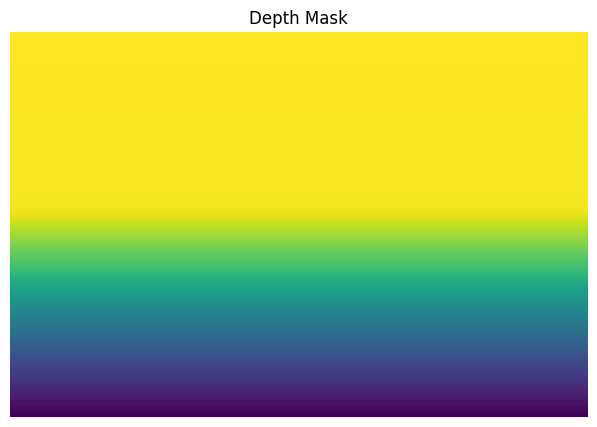

f:\Utilities\anaconda\envs\IMOS\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
f:\Utilities\anaconda\envs\IMOS\lib\site-packages\lightning_fabric\connector.py:572: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
f:\Utilities\anaconda\envs\IMOS\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory D:\Usefull Stuff\Usefull Stuff\Course Related\EPFL\Semester 4\DLAV\DLAV-2025\euro_truck_si


Model initialized with parameters:
Learning Rate: 0.0002
Weight Decay: 2.6551e-06
Number of Epochs: 50
Number of Modes: 4
Scheduler Patience: 5
depth_k: 0.3
semantic_k: 0.5
Mask depth: True

Smooth L1 Loss Beta: 1
Model version: 10
 
Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

f:\Utilities\anaconda\envs\IMOS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [16, 256]

In [92]:
model, val_loader, best_model_val_loss = run_experiment(max_epochs=50, batch_size=32, lr=2e-4, weight_decay=2.6551e-6, scheduler_patience=5, beta = 1,
                   augment_train=True, augment_val=False, seed=42, logger_name='multitask_driving_planner_with_semantics', mask_depth=True, depth_k = 0.3, semantic_k = 0.5)

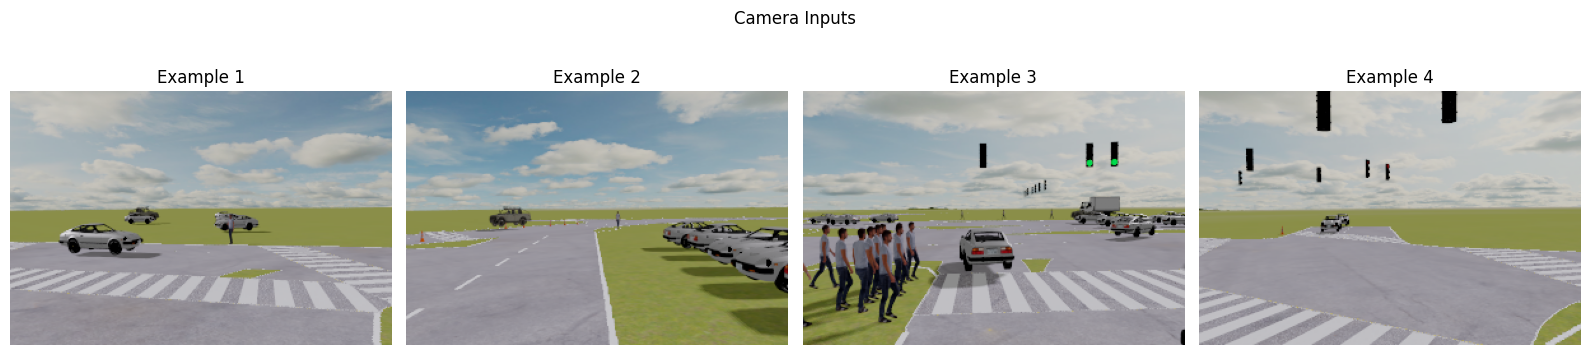

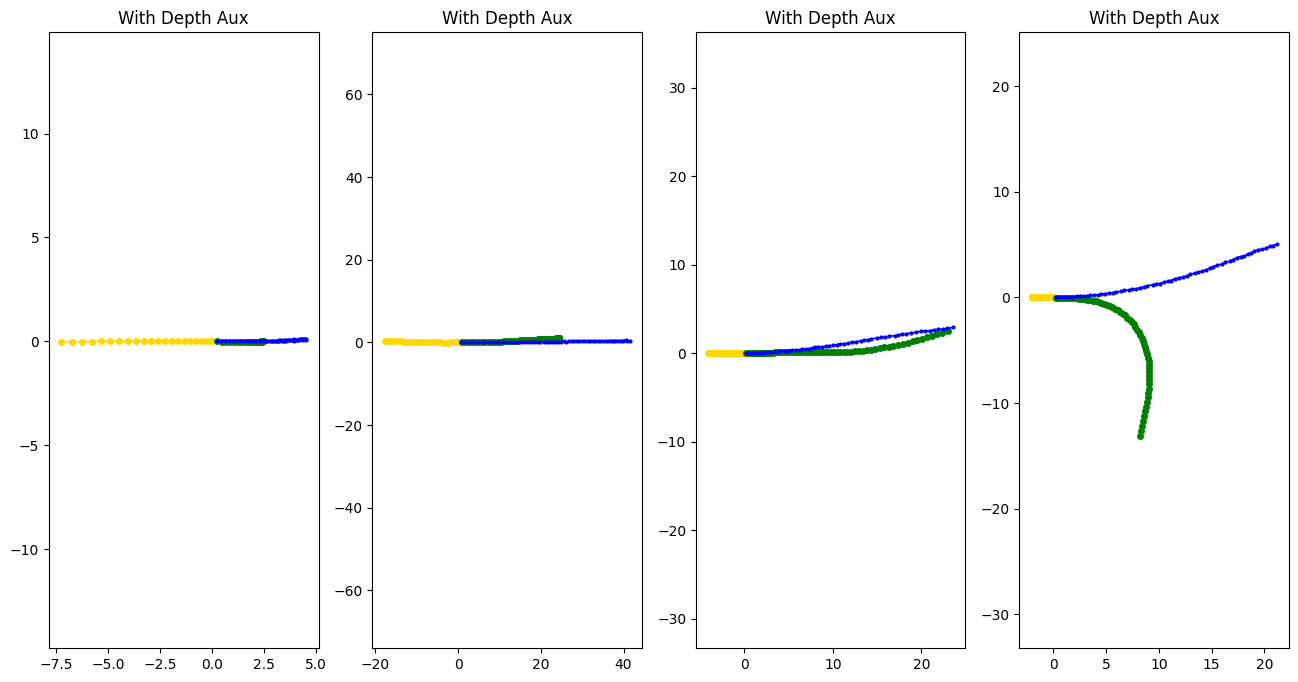

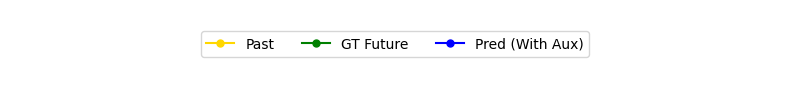

<Figure size 640x480 with 0 Axes>

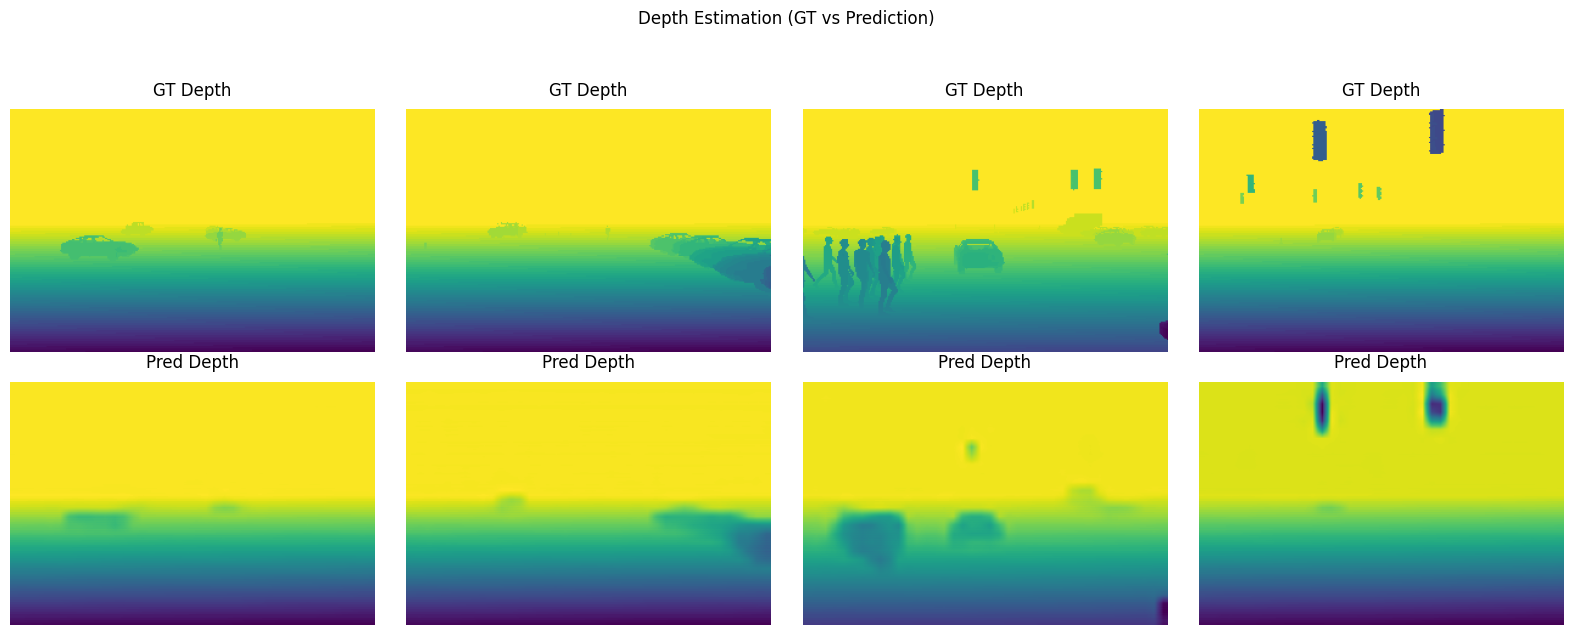

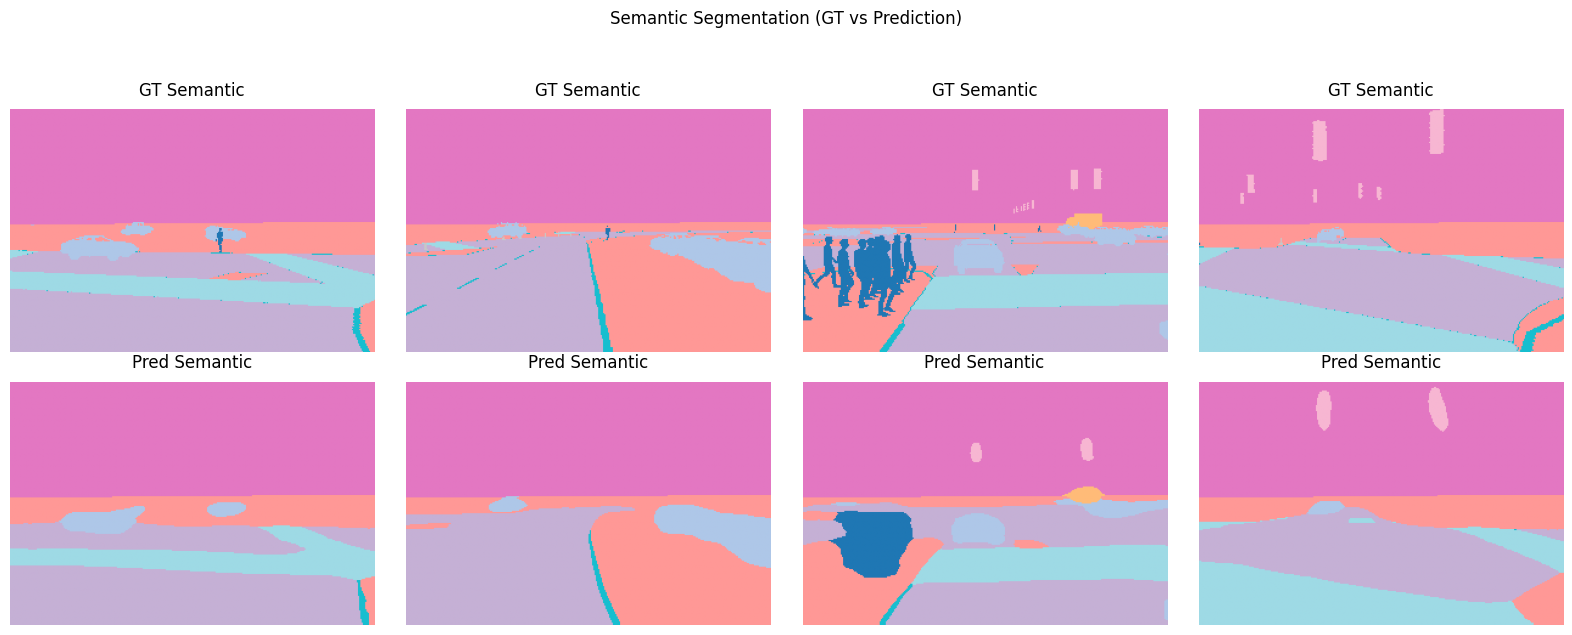

In [89]:
# checkpoint = "driving_planner_version_8_epoch=70_val_ade=1.1927.ckpt"
# checkpoint_path = os.path.join("checkpoints", "phase2", "optuna_multitask_planner", checkpoint)
# model = LightningDrivingPlanner.load_from_checkpoint(checkpoint_path)
# Call at the end after training 
model = model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
future, pred_with_aux, depth, pred_depth = visualize_comparison(val_loader, model, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

In [ ]:
import optuna

study_name = "optuna_trial_with_depth_and_semantics"

def objective(trial):
    # Define the hyperparameter search space
    num_nodes = trial.suggest_int("num_nodes", 4, 6)
    max_epochs = trial.suggest_int("max_epochs", 60, 120)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 5e-5)
    scheduler_patience = trial.suggest_int("scheduler_patience", 2, 10)
    lr = trial.suggest_loguniform("lr", 5e-5, 1e-3)
    mask_depth = trial.suggest_categorical("mask_depth", [True, False])
    # Run your experiment
    model, val_loader, best_model_val_ade = run_experiment(
        lr=lr,
        num_nodes=num_nodes,
        max_epochs=max_epochs,
        weight_decay=weight_decay,
        scheduler_patience=scheduler_patience,
        augment_train=True,
        logger_name=study_name
    )

    # The score Optuna will try to minimize or maximize
    return best_model_val_ade  

# Create the Optuna study
study = optuna.create_study(direction="minimize")  # or "minimize" depending on your metric
study.optimize(objective,  n_trials=10)

V18: last one was k = 1, beta = 0.8, Val_ade 1.19

f:\Utilities\anaconda\envs\IMOS\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Model initialized with parameters:
Learning Rate: 0.0001
Weight Decay: 2.6551e-06
Number of Epochs: 50
Number of Modes: 4
Scheduler Patience: 5
depth_k: 0.1
semantic_k: 0.1
Mask depth: False

Smooth L1 Loss Beta: 1


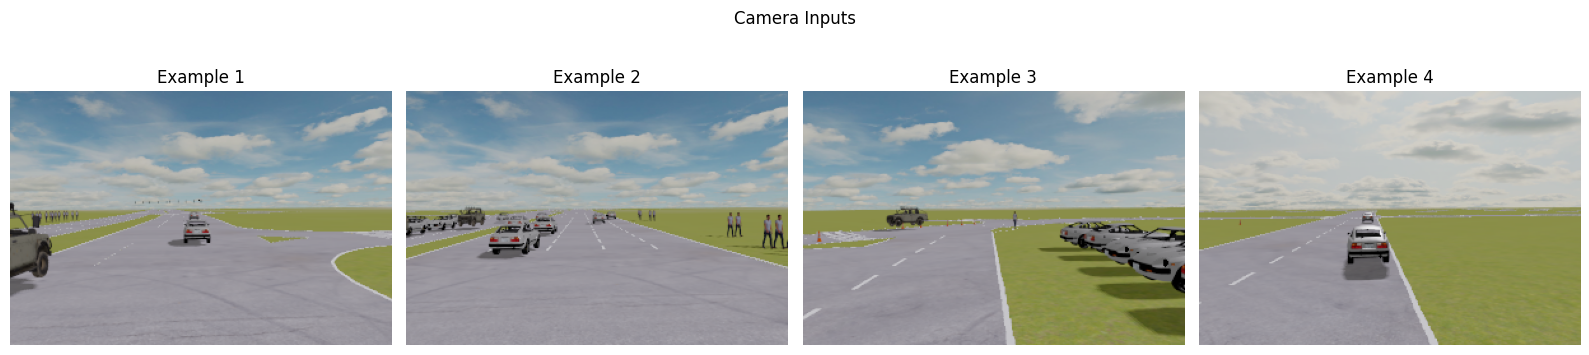

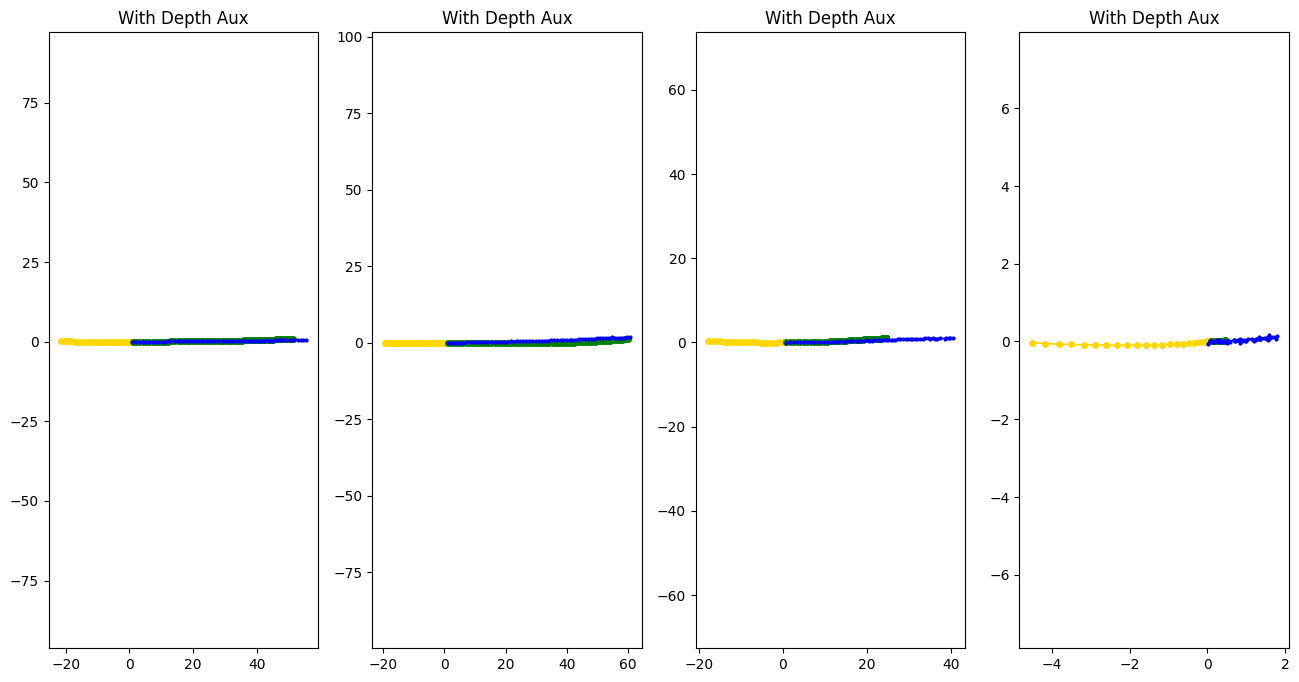

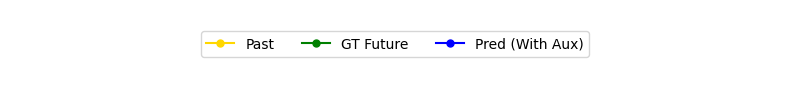

<Figure size 640x480 with 0 Axes>

Epoch 0: 100%|██████████| 313/313 [4:40:26<00:00,  0.02it/s, v_num=1, train_loss_step=2.590, train_depth_loss_step=3.670, train_traj_loss_step=0.0264, train_semantic_loss_step=0.546]


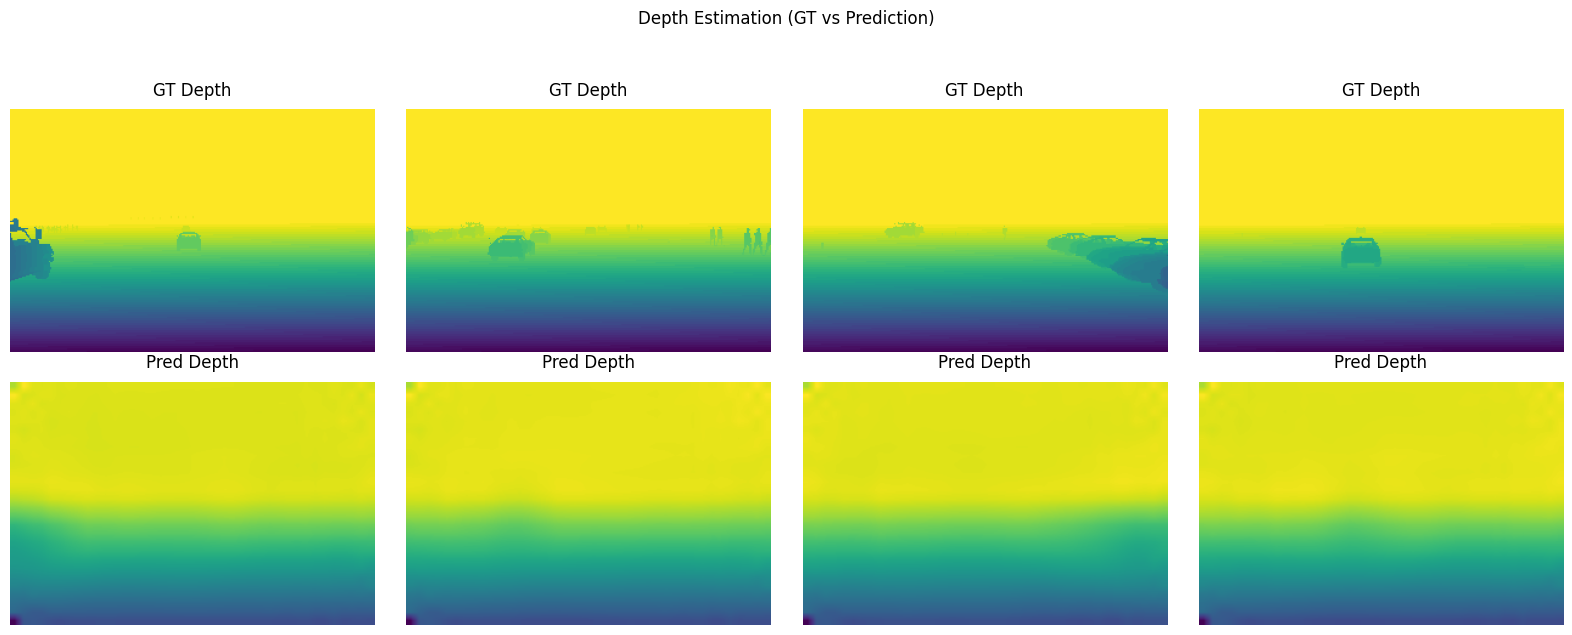

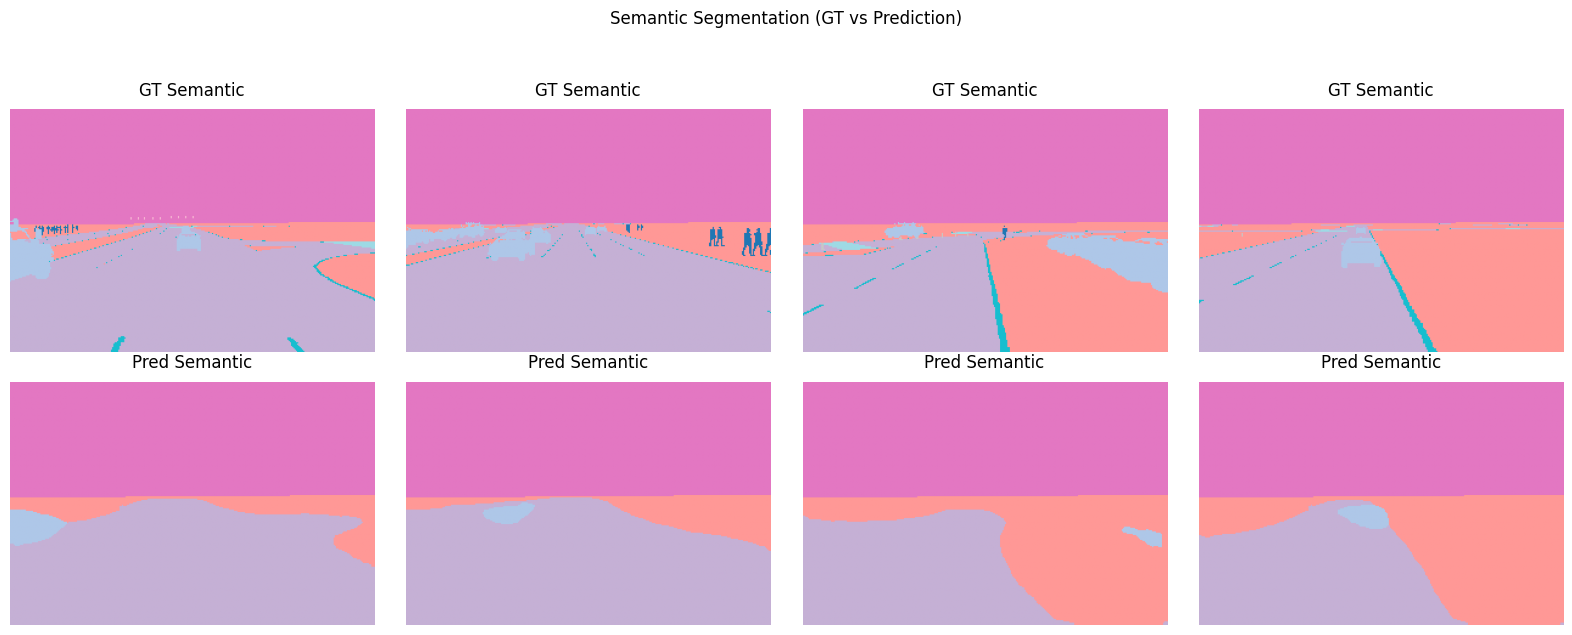

In [77]:
checkpoint = "driving_planner_version_4_epoch=41_val_ade=1.5011.ckpt"
checkpoint_path = os.path.join("checkpoints", "phase2", "multitask_driving_planner_with_semantics", checkpoint)
model = LightningDrivingPlanner.load_from_checkpoint(checkpoint_path)

model = model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
future, pred_with_aux, depth, pred_depth,= visualize_comparison(val_loader, model, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

In [44]:

test_data_dir = os.path.join("data", "phase2", "train")

with open(os.path.join(test_data_dir, "0.pkl"), "rb") as f:
    data = pickle.load(f)
print(data.keys())

dict_keys(['camera', 'depth', 'driving_command', 'sdc_history_feature', 'sdc_future_feature', 'semantic_label'])


In [90]:

test_data_dir = os.path.join("data", "phase2", "test_public")

with open(os.path.join(test_data_dir, "0.pkl"), "rb") as f:
    data = pickle.load(f)
print(data.keys())
# Note the absence of sdc_future_feature
device = "cuda"
import pandas as pd
test_files = [os.path.join(test_data_dir, fn) for fn in sorted([f for f in os.listdir(test_data_dir) if f.endswith(".pkl")], key=lambda fn: int(os.path.splitext(fn)[0]))]
test_dataset = DrivingDataset(test_files, test=True)
test_loader = DataLoader(test_dataset, batch_size=250)
model.eval()
all_plans = []
with torch.no_grad():
    for batch in test_loader:
        camera = batch['camera'].to(device)
        history = batch['history'].to(device)

        #pred_future, _ = model(camera, history)
        depth_pred, traj_pred, conf_pred, pred_future, semantic_pred_logits = model(camera, history)
        all_plans.append(pred_future.cpu().numpy()[..., :2])
all_plans = np.concatenate(all_plans, axis=0)

# Now save the plans as a csv file
pred_xy = all_plans[..., :2]  # shape: (total_samples, T, 2)

# Flatten to (total_samples, T*2)
total_samples, T, D = pred_xy.shape
pred_xy_flat = pred_xy.reshape(total_samples, T * D)

# Build a DataFrame with an ID column
ids = np.arange(total_samples)
df_xy = pd.DataFrame(pred_xy_flat)
df_xy.insert(0, "id", ids)

# Column names: id, x_1, y_1, x_2, y_2, ..., x_T, y_T
new_col_names = ["id"]
for t in range(1, T + 1):
    new_col_names.append(f"x_{t}")
    new_col_names.append(f"y_{t}")
df_xy.columns = new_col_names

# Save to CSV
df_xy.to_csv("submission_phase2_mask_semantic_k_1.csv", index=False)

print(f"Shape of df_xy: {df_xy.shape}")

dict_keys(['camera', 'depth', 'driving_command', 'sdc_history_feature', 'semantic_label'])
Shape of df_xy: (1000, 121)


## 🔍 Final Visualization and Comparison

Now that we’ve trained two models — one **with** the depth auxiliary task and one **without** — let’s visualize and compare their predictions.

We’ll show:
1. The **camera image** from selected validation examples
2. The **past trajectory**, **ground-truth future**, and **predicted future** trajectory
3. The **predicted vs. ground-truth depth maps** (only for the model trained with the auxiliary task)

These visualizations help us understand:
- Does the predicted trajectory better match the future when the depth task is included?
- Is the predicted depth map reasonably accurate?

Let’s see the difference! 📈

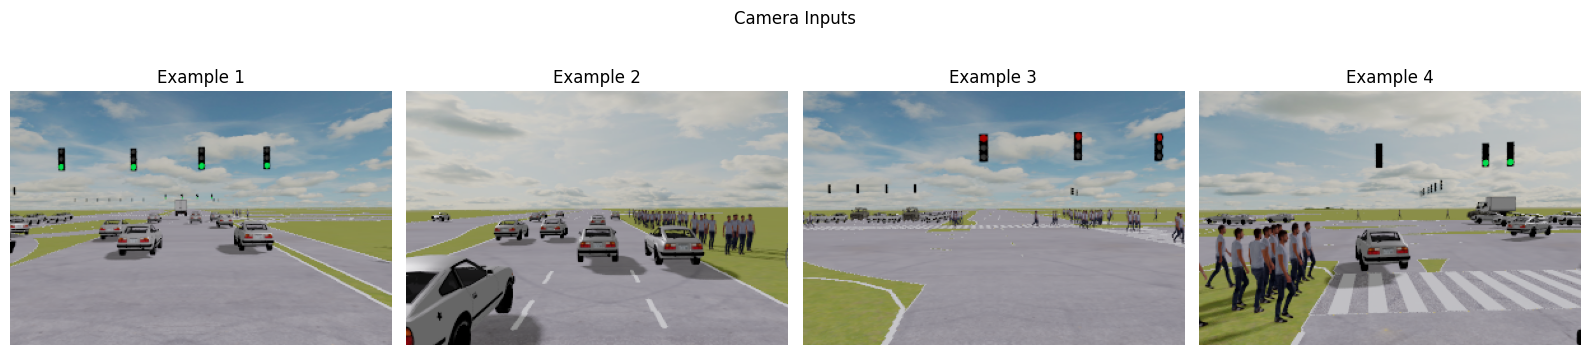

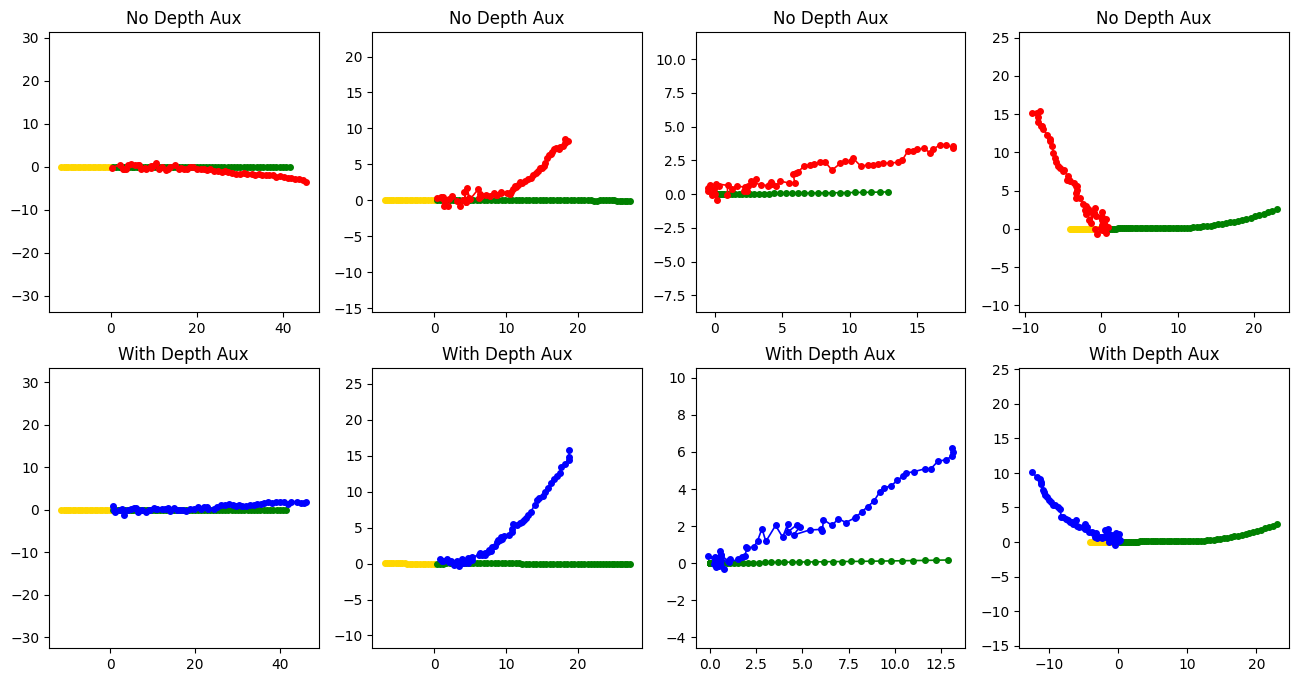

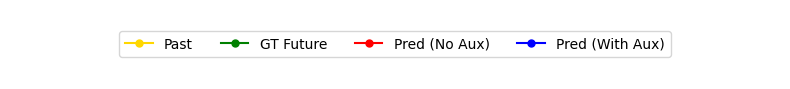

<Figure size 640x480 with 0 Axes>

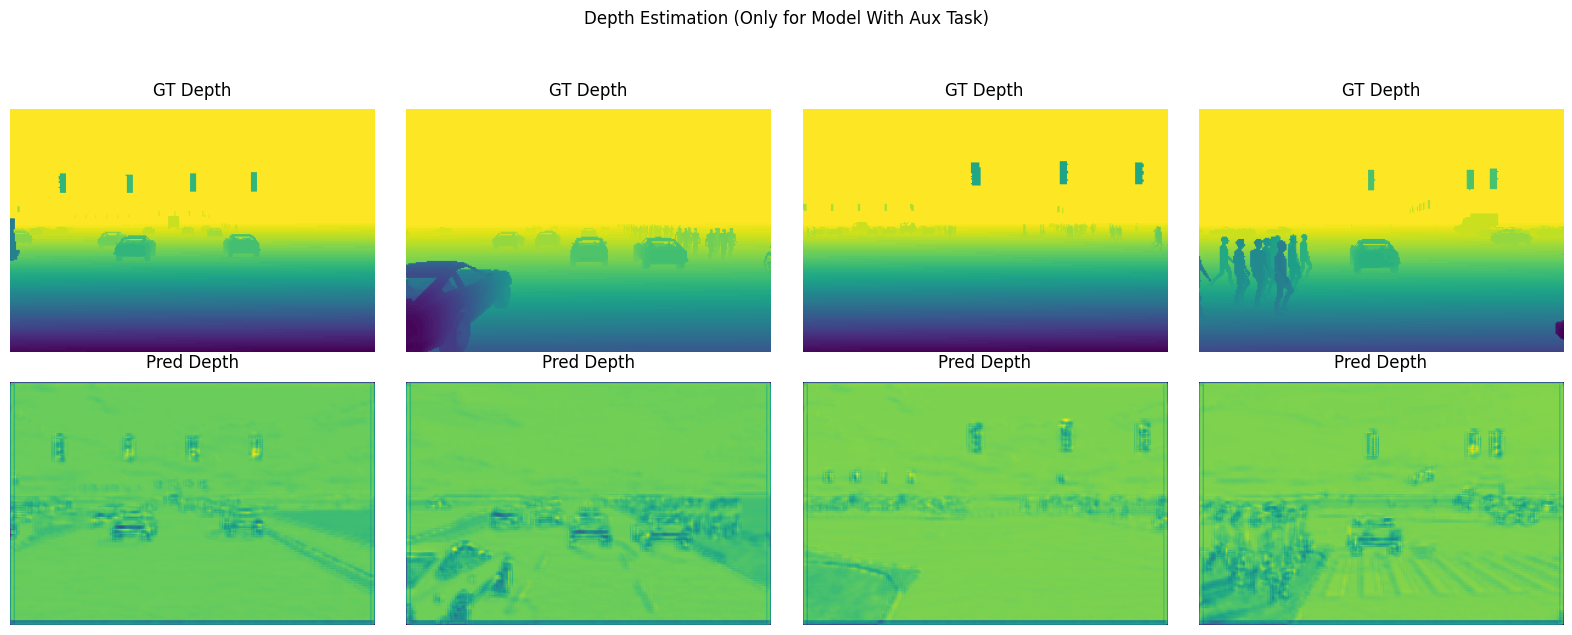

In [13]:
import matplotlib.pyplot as plt
import random

random.seed(40)

def visualize_comparison(val_loader, model_no_aux, model_with_aux, device):
    model_no_aux.eval()
    model_with_aux.eval()
    val_batch = next(iter(val_loader))

    camera = val_batch['camera'].to(device)
    history = val_batch['history'].to(device)
    future = val_batch['future'].to(device)
    depth = val_batch['depth'].to(device)

    with torch.no_grad():
        pred_no_aux, _ = model_no_aux(camera, history)
        pred_with_aux, pred_depth = model_with_aux(camera, history)

    camera = camera.cpu().numpy()
    history = history.cpu().numpy()
    future = future.cpu().numpy()
    pred_no_aux = pred_no_aux.cpu().numpy()
    pred_with_aux = pred_with_aux.cpu().numpy()
    depth = depth.cpu().numpy()
    pred_depth = pred_depth.cpu().numpy() if pred_depth is not None else None

    k = 4
    indices = random.choices(np.arange(len(camera)), k=k)

    # Show the input camera images
    fig, ax = plt.subplots(1, k, figsize=(4 * k, 4))
    for i, idx in enumerate(indices):
        ax[i].imshow(camera[idx].transpose(1, 2, 0))
        ax[i].set_title(f"Example {i+1}")
        ax[i].axis("off")
    plt.suptitle("Camera Inputs")
    plt.tight_layout()
    plt.show()

    # Compare predicted trajectories
    fig, ax = plt.subplots(2, k, figsize=(4 * k, 8))
    for i, idx in enumerate(indices):
        # Without aux
        ax[0, i].plot(history[idx, :, 0], history[idx, :, 1], 'o-', label='Past', color='gold', markersize=4, linewidth=1.2)
        ax[0, i].plot(future[idx, :, 0], future[idx, :, 1], 'o-', label='GT Future', color='green', markersize=4, linewidth=1.2)
        ax[0, i].plot(pred_no_aux[idx, :, 0], pred_no_aux[idx, :, 1], 'o-', label='Pred (No Aux)', color='red', markersize=4, linewidth=1.2)
        ax[0, i].set_title("No Depth Aux")
        ax[0, i].axis("equal")

        # With aux
        ax[1, i].plot(history[idx, :, 0], history[idx, :, 1], 'o-', label='Past', color='gold', markersize=4, linewidth=1.2)
        ax[1, i].plot(future[idx, :, 0], future[idx, :, 1], 'o-', label='GT Future', color='green', markersize=4, linewidth=1.2)
        ax[1, i].plot(pred_with_aux[idx, :, 0], pred_with_aux[idx, :, 1], 'o-', label='Pred (With Aux)', color='blue', markersize=4, linewidth=1.2)
        ax[1, i].set_title("With Depth Aux")
        ax[1, i].axis("equal")

    # Show full legend in a new figure
    fig_legend = plt.figure(figsize=(8, 1))
    legend_handles = [
        plt.Line2D([0], [0], color='gold', marker='o', linestyle='-', markersize=5, label='Past'),
        plt.Line2D([0], [0], color='green', marker='o', linestyle='-', markersize=5, label='GT Future'),
        plt.Line2D([0], [0], color='red', marker='o', linestyle='-', markersize=5, label='Pred (No Aux)'),
        plt.Line2D([0], [0], color='blue', marker='o', linestyle='-', markersize=5, label='Pred (With Aux)')
    ]
    fig_legend.legend(handles=legend_handles, loc='center', ncol=4)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    plt.suptitle("Trajectory Prediction: Without vs With Depth Aux Task")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Show predicted vs GT depth (only for bottom row)
    if pred_depth is not None:
        fig, ax = plt.subplots(2, k, figsize=(4 * k, 6))
        for i, idx in enumerate(indices):
            ax[0, i].imshow(depth[idx, :, :, 0], cmap='viridis')
            ax[0, i].set_title("GT Depth", pad=10)
            ax[0, i].axis("off")
            # increase vertical distance between rows

            ax[1, i].imshow(pred_depth[idx, :, :, 0], cmap='viridis')
            ax[1, i].set_title("Pred Depth", pad=10)
            ax[1, i].axis("off")

        plt.suptitle("Depth Estimation (Only for Model With Aux Task)", y=1.05)
        plt.subplots_adjust(hspace=0.4)
        plt.tight_layout()
        plt.show()


# 🔚 Call at the end after training both models
visualize_comparison(val_loader, model_no_aux, model_with_aux, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

Now we run our model on the test set once, to get the plan of our model and save it for submission. Notice that the ground truth plans are removed for the test set, so you can not calculate the ADE metric on the test set yourself, and need to submit it to the leader board. By running the last cell, you'll be able to see a csv file called submission_phase2.csv by clicking on the folder icon on the left. Download it and submit it to the leaderboard to get your score.

In [19]:
import pandas as pd
test_data_dir = os.path.join("data", "phase2", "test_public")
test_files = [os.path.join(test_data_dir, fn) for fn in sorted([f for f in os.listdir(test_data_dir) if f.endswith(".pkl")], key=lambda fn: int(os.path.splitext(fn)[0]))]
test_dataset = DrivingDataset(test_files, test=True)
test_loader = DataLoader(test_dataset, batch_size=250)
model_with_aux.eval()
all_plans = []
with torch.no_grad():
    for batch in test_loader:
        camera = batch['camera'].to(device)
        history = batch['history'].to(device)

        pred_future, _ = model_with_aux(camera, history)
        all_plans.append(pred_future.cpu().numpy()[..., :2])
all_plans = np.concatenate(all_plans, axis=0)

# Now save the plans as a csv file
pred_xy = all_plans[..., :2]  # shape: (total_samples, T, 2)

# Flatten to (total_samples, T*2)
total_samples, T, D = pred_xy.shape
pred_xy_flat = pred_xy.reshape(total_samples, T * D)

# Build a DataFrame with an ID column
ids = np.arange(total_samples)
df_xy = pd.DataFrame(pred_xy_flat)
df_xy.insert(0, "id", ids)

# Column names: id, x_1, y_1, x_2, y_2, ..., x_T, y_T
new_col_names = ["id"]
for t in range(1, T + 1):
    new_col_names.append(f"x_{t}")
    new_col_names.append(f"y_{t}")
df_xy.columns = new_col_names

file_name = "submission.csv"
# Save to CSV
if not os.path.exists("submission/phase2"):
    os.makedirs("submission/phase2")
df_xy.to_csv(os.path.join("submission", "phase2", file_name), index=False)

print(f"Shape of df_xy: {df_xy.shape}")

Shape of df_xy: (1000, 121)
